# Convolutional Neural Network for GDP Time Series Forecasting

## Table of Contents

1. Load packages and data
2. Prepare data for training
3. Create baseline model
4. Hyperparameter Tuning

## Load packages and data

In [137]:
# load relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from keras.callbacks import EarlyStopping
import keras_tuner as kt
import pydot

In [249]:
# load cleaned data
data = pd.read_csv('data_cleaned.csv', index_col=0)

data

Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars  \
Period                                                                                         
1997-01-31                                           5.766667                                  
1997-02-28                                           5.733333                                  
1997-03-31                                           5.700000                                  
1997-04-30                                           6.966667                                  
1997-05-31                                           8.233333                                  
...                                                       ...                                  
2022-11-30                                           2.733333                                  
2022-12-31                                           2.100000                                  
2023-01-31                                           1.533333                                  
2023-02-28                                           0.966667                                  
2023-03-31                                           0.400000                                  

            Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total  \
Period                                                                                      
1997-01-31                                            111.147                               
1997-02-28                                            109.571                               
1997-03-31                                            118.447                               
1997-04-30                                            107.974                               
1997-05-31                                            113.795                               
...                                                       ...                               
2022-11-30                                             94.672                               
2022-12-31                                            102.994                               
2023-01-31                                             99.578                               
2023-02-28                                             88.697                               
2023-03-31                                             94.430                               

            Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total  \
Period                                                                          
1997-01-31                                          15.715098                   
1997-02-28                                         -19.711470                   
1997-03-31                                           3.658993                   
1997-04-30                                           2.971000                   
1997-05-31                                           2.081662                   
...                                                       ...                   
2022-11-30                                           3.528764                   
2022-12-31                                           4.257838                   
2023-01-31                                          -4.899654                   
2023-02-28                                           8.642604                   
2023-03-31                                           2.485396                   

            Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units)  \
Period                                                                                                                             
1997-01-31                                           5.488212                                                                      
1997-02-28                                           0.511269                                          

## Prepare data for training

In this section, we will prepare the data for the 1D CNN by 
1. normalizing the data
2. prepare the time sequence with a lookback 6 (6 months) to perform 1 step prediction (1 month)
3. Train test split

In [143]:
target = 'Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars'

#Normalize the data
X = data.drop([target],axis=1).values
X_train = X[:253]
X_test = X[253:]
transformer = Normalizer().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X = np.concatenate((X_train, X_test), axis=0)
y=np.expand_dims(data[target].values,1)

In [144]:
def convert2matrix(X_arr, Y_arr, lookback):
    X, Y = [], []
    # iterating through the data with window as look back
    for i in range(len(X_arr) - lookback):
        d = i + lookback
        # extracting the X as features and target of n days and Y as target at (n+1)th day
        X.append(np.hstack((X_arr[i:d], Y_arr[i:d])))
        # X.append(X_arr[i:d])
        Y.append(Y_arr[d])
    return np.array(X), np.array(Y)


#prepare inputs for baseline model with lookback 6
lookback = 6
x,y = convert2matrix(X,y,lookback)

In [145]:
#split train, test dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(247, 6, 15) (247, 1)
(62, 6, 15) (62, 1)


In [250]:
#prepare inputs for model experimentation with lookback 12
X2 = data.drop([target],axis=1).values
X_train2 = X2[:253]
X_test2 = X2[253:]
transformer2 = Normalizer().fit(X_train2)
X_train2 = transformer.transform(X_train2)
X_test2 = transformer.transform(X_test2)
X2 = np.concatenate((X_train2, X_test2), axis=0)
y2=np.expand_dims(data[target].values,1)

lookback = 12
x2,y2 = convert2matrix(X2,y2,lookback)

X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, shuffle=False)
print(X_train2.shape,y_train2.shape)
print(X_test2.shape,y_test2.shape)

(242, 12, 15) (242, 1)
(61, 12, 15) (61, 1)


## Create baseline CNN

In this section, we will create a baseline CNN with a single Conv1D layer.

Note that it is possible to add more layers however, we will have to consider a longer lookback period. eg. lookback (12 months) for 1 step prediction.

In [9]:
class CNNModel:
    def __init__(self, conv_filters=32, kernel_size=6, dense_units=32, learning_rate =0.001):

        self.model = tf.keras.Sequential()

        self.model.add(tf.keras.layers.Conv1D(filters=conv_filters,
                                              kernel_size=(kernel_size,),
                                              activation="relu"))
        self.model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) 
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(units=dense_units, activation="relu"))
        self.model.add(tf.keras.layers.Dense(units=1))
        self.learning_rate = learning_rate


    def fit(self, X_train, 
            y_train, 
            epochs=400, 
            batch_size=10, 
            validation_split=0.1, 
            verbose=1,      
            shuffle=False, 
            callbacks=None):

        self.model.compile(
            loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(self.learning_rate),
            metrics=[tf.keras.metrics.MeanAbsoluteError()],
        )

        history = self.model.fit(
            X_train, y_train, epochs=epochs, batch_size=batch_size, 
            validation_split=validation_split, verbose=verbose, 
            shuffle=shuffle, callbacks=callbacks
        )

        return history

    def evaluate(self, eval_data, verbose=0):

        mse, mae = self.model.evaluate(eval_data, verbose=verbose)

        return mse, mae

    def predict(self, pred_data):
        return self.model.predict(pred_data)
    
    def summary(self):
        self.model.summary()    


In [91]:
class DeepCNNModel:
    def __init__(self, conv_filters=[16,32,64], kernel_size=3, dense_units=32, learning_rate =0.001):

        self.model = tf.keras.Sequential()

        self.model.add(tf.keras.layers.Conv1D(filters=conv_filters[0],
                                              kernel_size=(kernel_size,),
                                              activation="relu"))
        self.model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) 
        self.model.add(tf.keras.layers.Conv1D(filters=conv_filters[1],
                                              kernel_size=(kernel_size,),
                                              activation="relu"))
        self.model.add(tf.keras.layers.MaxPooling1D(pool_size=2))          
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(units=dense_units, activation="relu"))
        self.model.add(tf.keras.layers.Dense(units=1))
        self.learning_rate = learning_rate


    def fit(self, X_train, 
            y_train, 
            epochs=400, 
            batch_size=10, 
            validation_split=0.1, 
            verbose=1,      
            shuffle=False, 
            callbacks=None):

        self.model.compile(
            loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(self.learning_rate),
            metrics=[tf.keras.metrics.MeanAbsoluteError()],
        )

        history = self.model.fit(
            X_train, y_train, epochs=epochs, batch_size=batch_size, 
            validation_split=validation_split, verbose=verbose, 
            shuffle=shuffle, callbacks=callbacks
        )

        return history

    def evaluate(self, eval_data, verbose=0):

        mse, mae = self.model.evaluate(eval_data, verbose=verbose)

        return mse, mae

    def predict(self, pred_data):
        return self.model.predict(pred_data)
    
    def summary(self):
        self.model.summary()    


In [20]:
conv_filters = 32
kernel_size = 3
dense_units =32

# Set the random seed for TensorFlow
tf.random.set_seed(42)

# Set the random seed for numpy
np.random.seed(42)

model_baseline = CNNModel(conv_filters=conv_filters, 
                          kernel_size=kernel_size,
                          dense_units=dense_units)
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model_baseline.fit(X_train, y_train, 
                             epochs=400, 
                             batch_size=10, 
                             validation_split=0.1, 
                             verbose=1, 
                             shuffle=False, 
                             callbacks=[early_stop])

Epoch 1/400
23/23 [==============================] - 0s 5ms/step - loss: 25.4190 - mean_absolute_error: 4.2146 - val_loss: 2.5479 - val_mean_absolute_error: 1.4954
Epoch 2/400
23/23 [==============================] - 0s 2ms/step - loss: 9.2223 - mean_absolute_error: 2.4301 - val_loss: 0.4375 - val_mean_absolute_error: 0.5050
Epoch 3/400
23/23 [==============================] - 0s 2ms/step - loss: 7.3289 - mean_absolute_error: 2.0799 - val_loss: 0.4141 - val_mean_absolute_error: 0.4980
Epoch 4/400
23/23 [==============================] - 0s 2ms/step - loss: 6.2603 - mean_absolute_error: 1.9612 - val_loss: 0.3889 - val_mean_absolute_error: 0.4930
Epoch 5/400
23/23 [==============================] - 0s 2ms/step - loss: 5.0422 - mean_absolute_error: 1.7685 - val_loss: 0.4449 - val_mean_absolute_error: 0.5299
Epoch 6/400
23/23 [==============================] - 0s 1ms/step - loss: 3.9779 - mean_absolute_error: 1.5938 - val_loss: 0.4202 - val_mean_absolute_error: 0.5088
Epoch 7/400
23/23 [==

In [21]:
model_baseline.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 4, 32)             1472      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 32)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
____________________________________________________

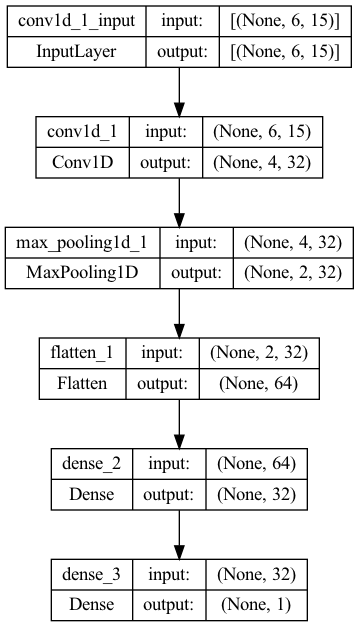

In [13]:
img_file = "./cnn_baseline.png"
tf.keras.utils.plot_model(model_baseline.model, to_file=img_file, show_shapes=True, show_layer_names=True)

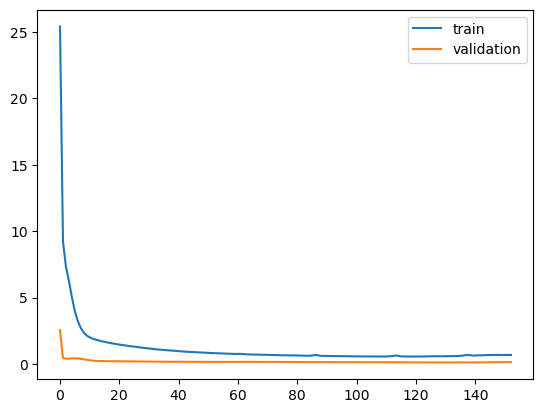

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

2/2 [==============================] - 0s 2ms/step


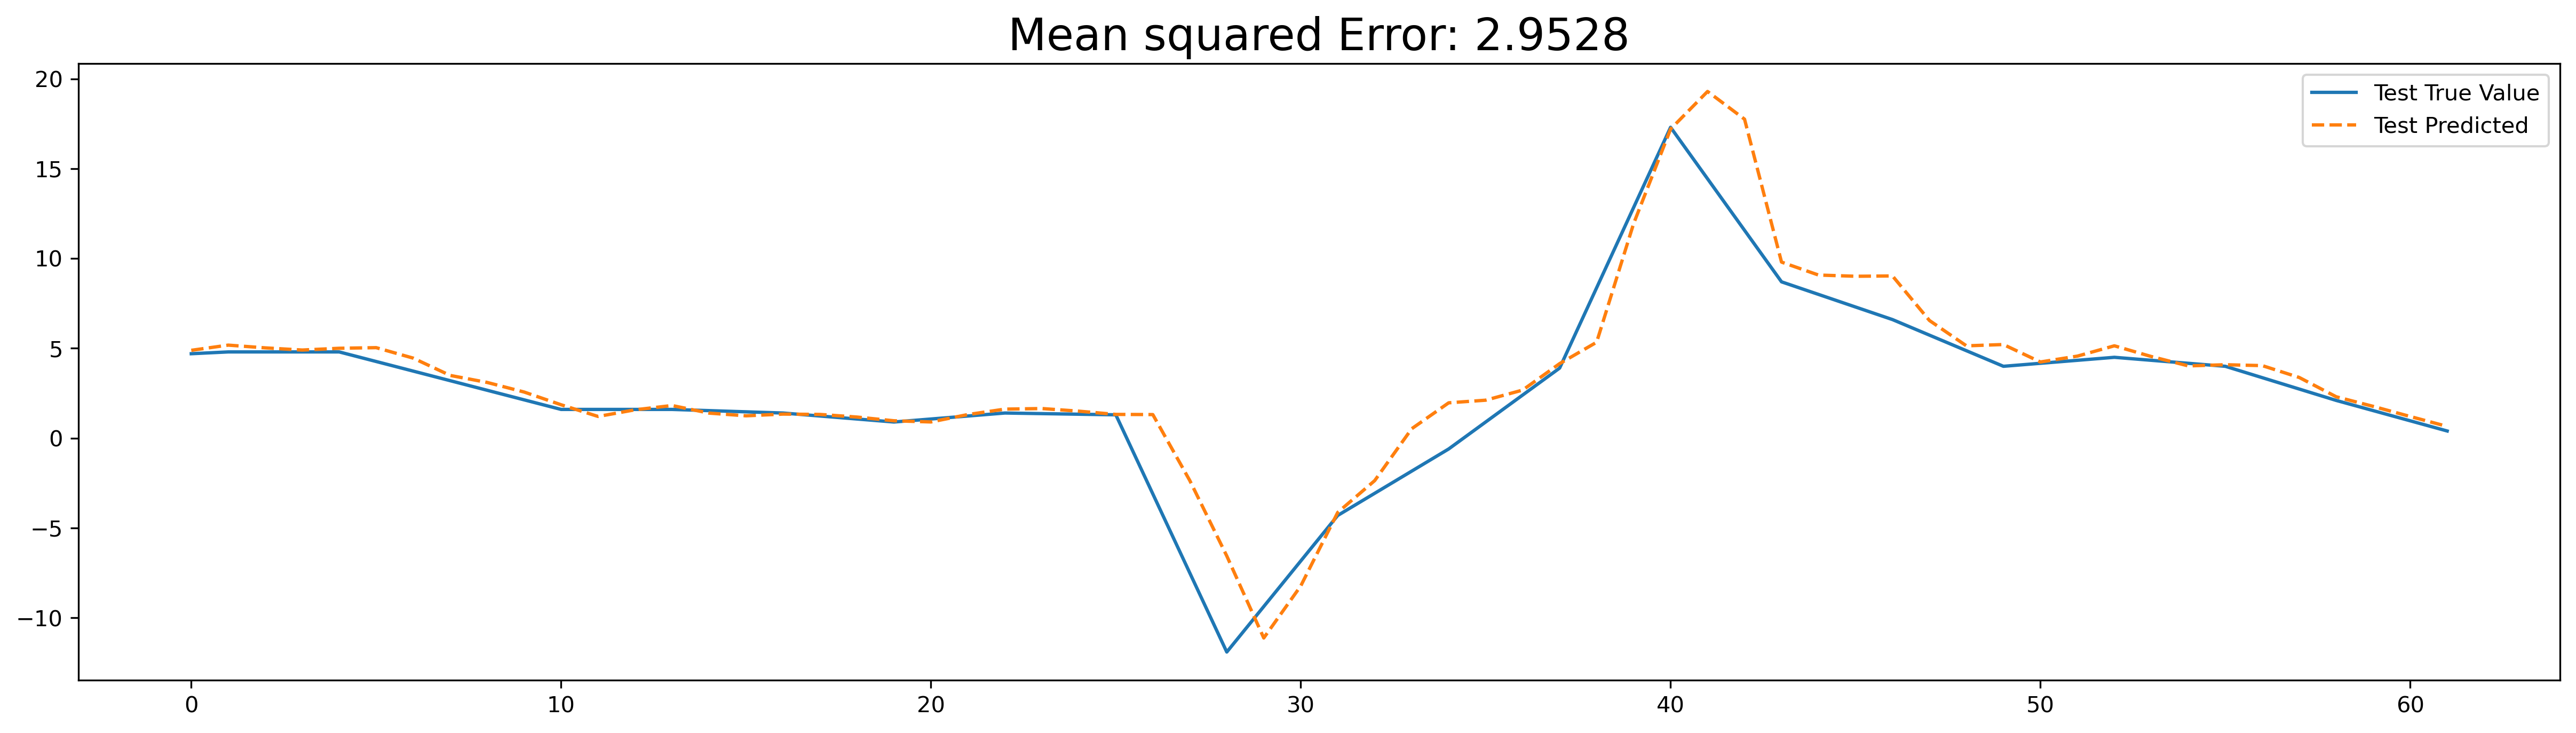

In [23]:
pred = model_baseline.predict(X_test)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_test,label='Test True Value')
plt.plot(pred,linestyle='--', label = 'Test Predicted')
plt.legend()
plt.title('Mean squared Error: '+str(mean_squared_error(pred,y_test))[:6],fontsize=20)
plt.show()

8/8 [==============================] - 0s 2ms/step


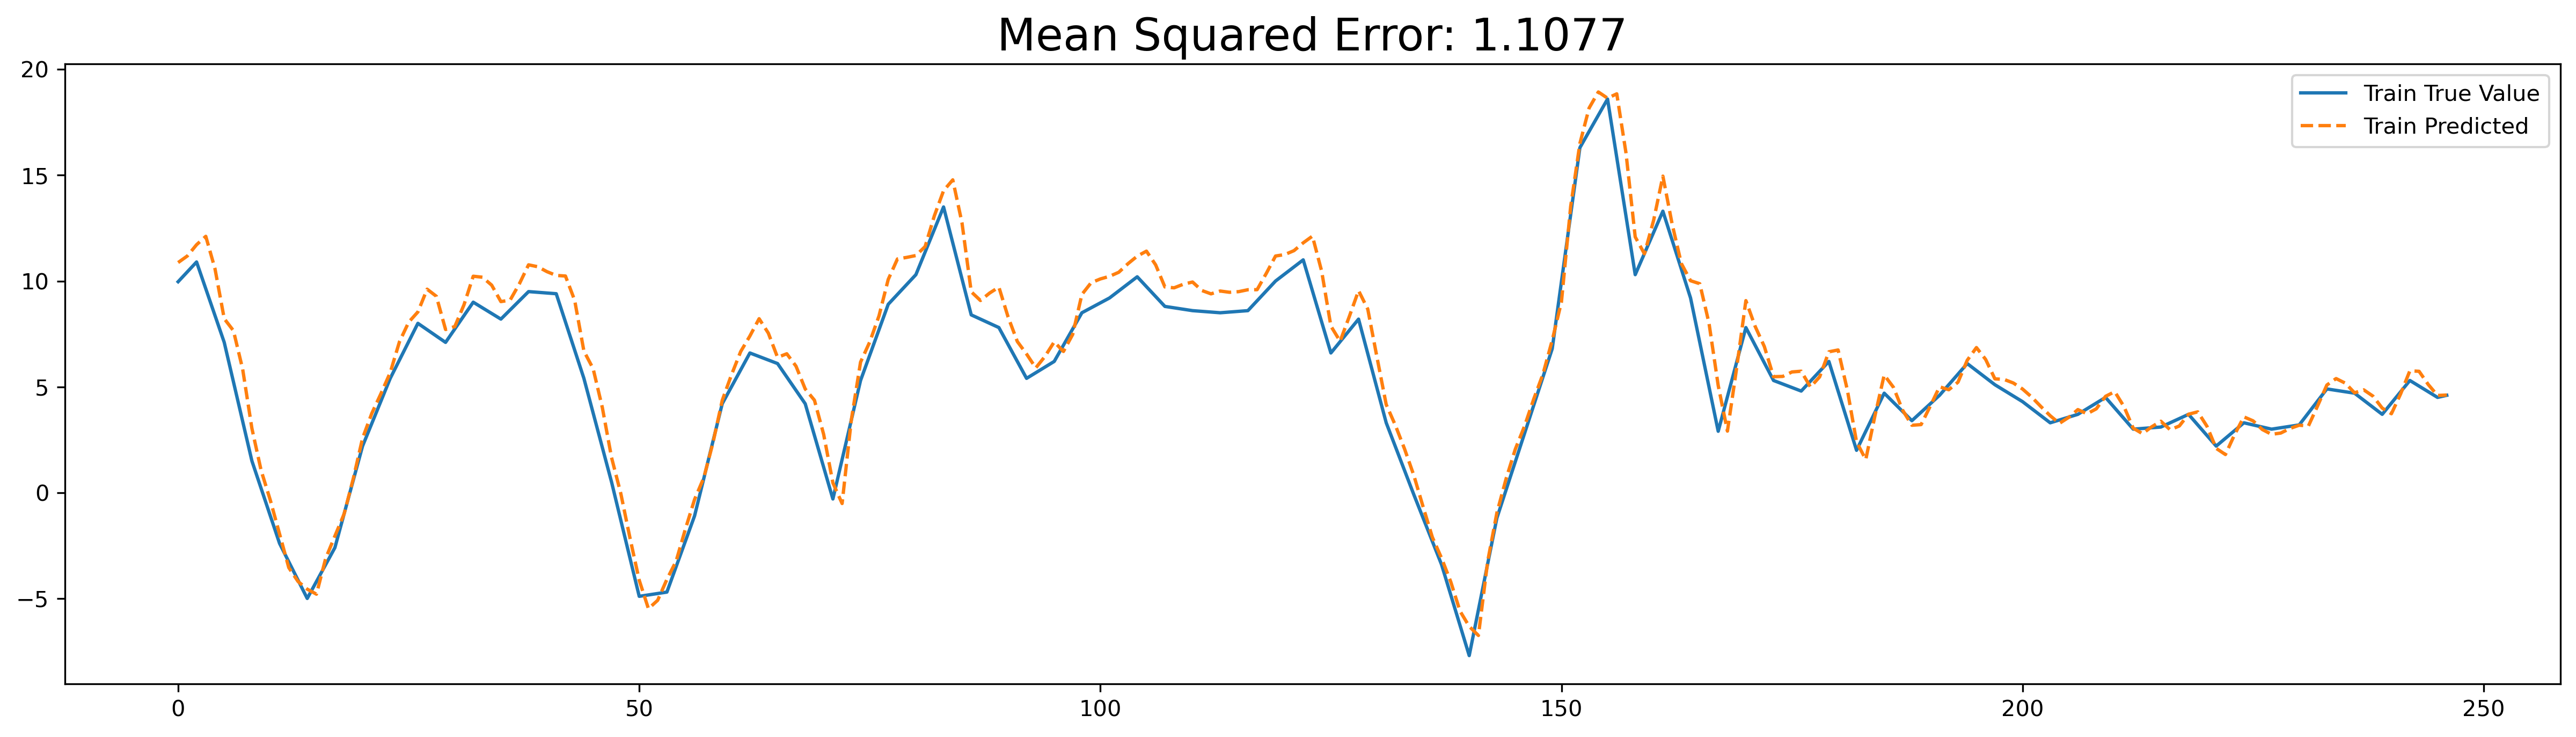

In [24]:
pred_train = model_baseline.predict(X_train)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_train,label='Train True Value')
plt.plot(pred_train,linestyle='--', label = 'Train Predicted')
plt.legend()
plt.title('Mean Squared Error: ' + str(mean_squared_error(pred_train,y_train))[:6],fontsize=20)
plt.show()

In [25]:
model_baseline.model.save('./cnn_baseline.h5')

## Model Experimentation

We have a built a single layer Conv1d with lookback 6 in the previous section.

With longer lookback period, we can design a deeper 1D CNN architecture to see how it affects the model performance.

Next, we will perform a few experiments as follows:
1. Construct a model with data input of longer lookback 12 with the same architecture.
2. Construct a model with data input of longer lookback 12 with the deeper architecture.

### Single layer Conv1D NN with Longer Lookback

In [251]:
conv_filters = 32
kernel_size = 3
dense_units =32

# Set the random seed for TensorFlow
tf.random.set_seed(42)

# Set the random seed for numpy
np.random.seed(42)

model_single_12 = CNNModel(conv_filters=conv_filters, 
                          kernel_size=kernel_size,
                          dense_units=dense_units)
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history_single_12 = model_single_12.fit(X_train2, y_train2, 
                             epochs=400, 
                             batch_size=10, 
                             validation_split=0.1, 
                             verbose=1, 
                             shuffle=False, 
                             callbacks=[early_stop])

Epoch 1/400
22/22 [==============================] - 0s 6ms/step - loss: 26.0835 - mean_absolute_error: 4.0687 - val_loss: 0.3961 - val_mean_absolute_error: 0.4507
Epoch 2/400
22/22 [==============================] - 0s 2ms/step - loss: 11.1038 - mean_absolute_error: 2.4242 - val_loss: 0.4958 - val_mean_absolute_error: 0.5401
Epoch 3/400
22/22 [==============================] - 0s 3ms/step - loss: 7.9290 - mean_absolute_error: 2.1254 - val_loss: 0.2779 - val_mean_absolute_error: 0.3998
Epoch 4/400
22/22 [==============================] - 0s 2ms/step - loss: 5.8089 - mean_absolute_error: 1.8087 - val_loss: 0.2798 - val_mean_absolute_error: 0.3842
Epoch 5/400
22/22 [==============================] - 0s 2ms/step - loss: 4.8284 - mean_absolute_error: 1.7385 - val_loss: 0.2576 - val_mean_absolute_error: 0.4064
Epoch 6/400
22/22 [==============================] - 0s 2ms/step - loss: 4.2999 - mean_absolute_error: 1.6520 - val_loss: 0.2594 - val_mean_absolute_error: 0.4090
Epoch 7/400
22/22 [=

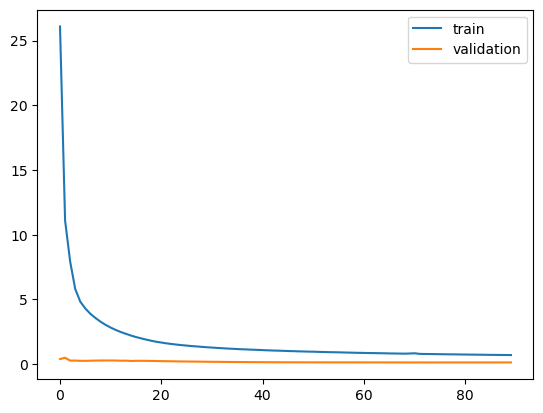

In [252]:
plt.plot(history_single_12.history['loss'], label='train')
plt.plot(history_single_12.history['val_loss'], label='validation')
plt.legend()
plt.show()

2/2 [==============================] - 0s 2ms/step


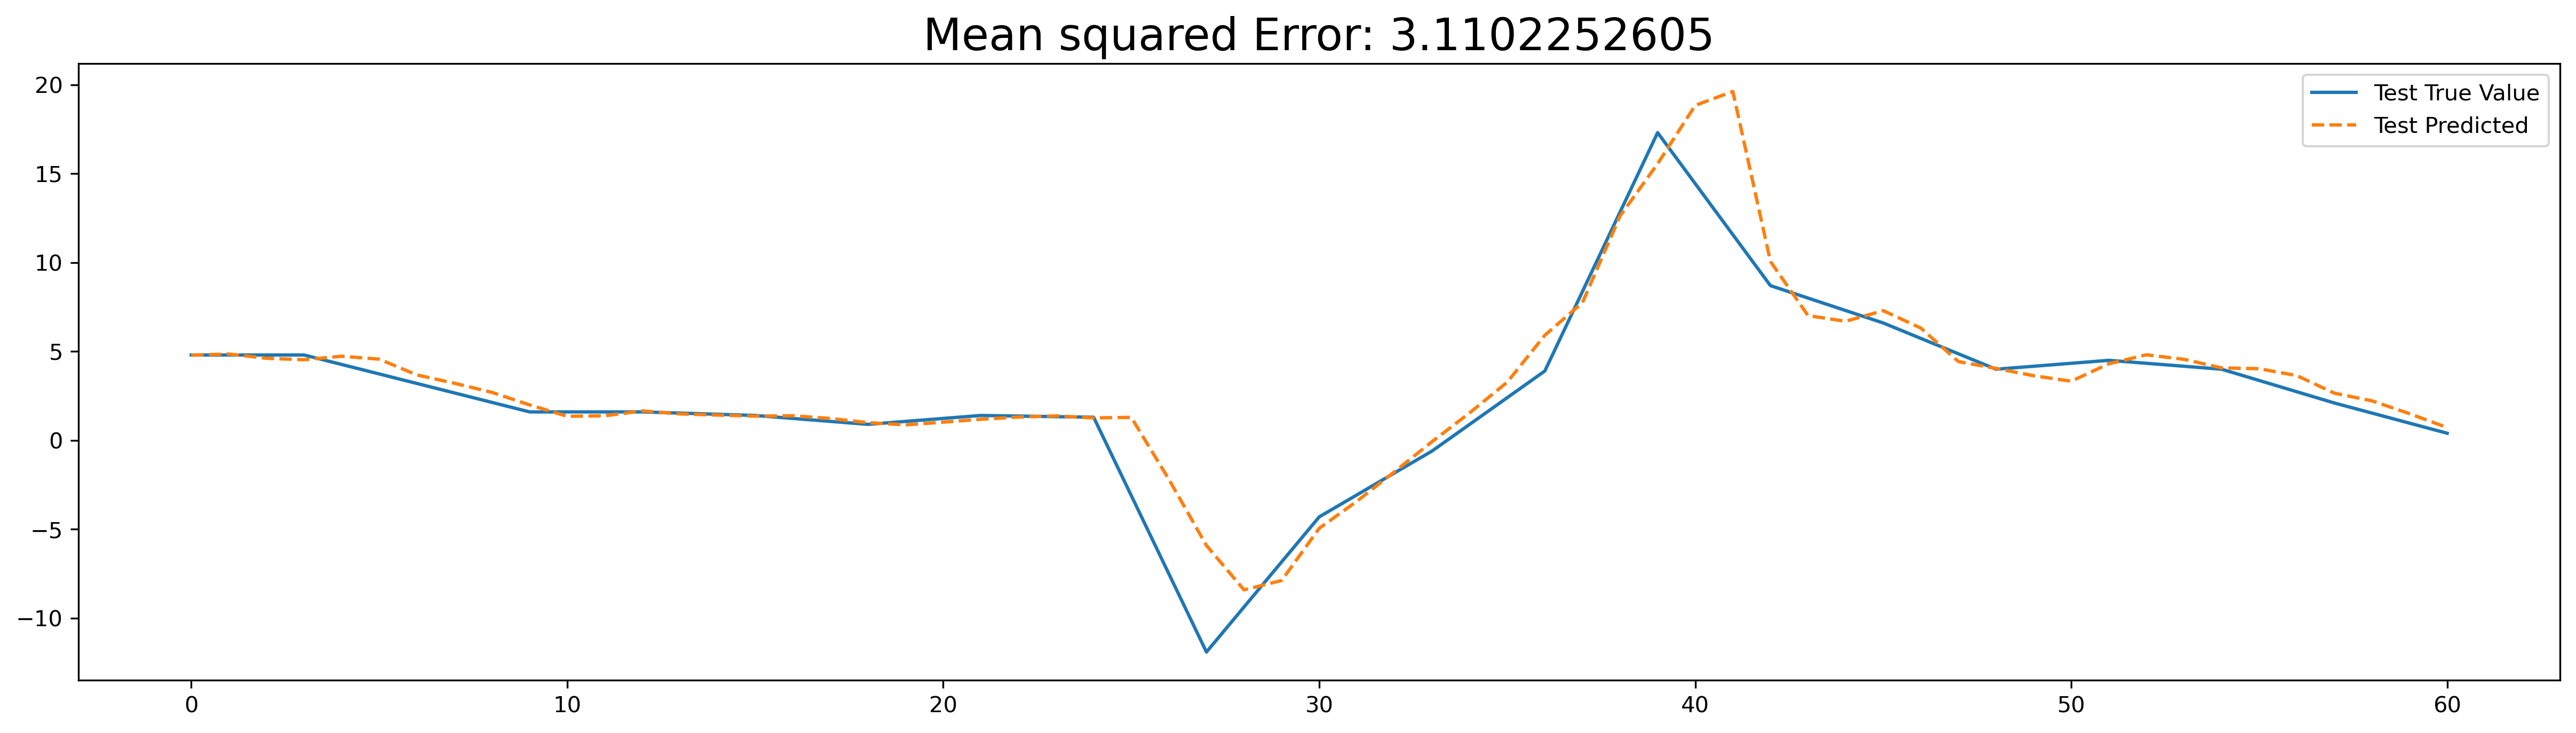

In [253]:
pred_single_12 = model_single_12.predict(X_test2)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_test2,label='Test True Value')
plt.plot(pred_single_12,linestyle='--', label = 'Test Predicted')
plt.legend()
plt.title('Mean squared Error: '+str(mean_squared_error(pred_single_12,y_test2))[:12],fontsize=20)
plt.show()

8/8 [==============================] - 0s 5ms/step


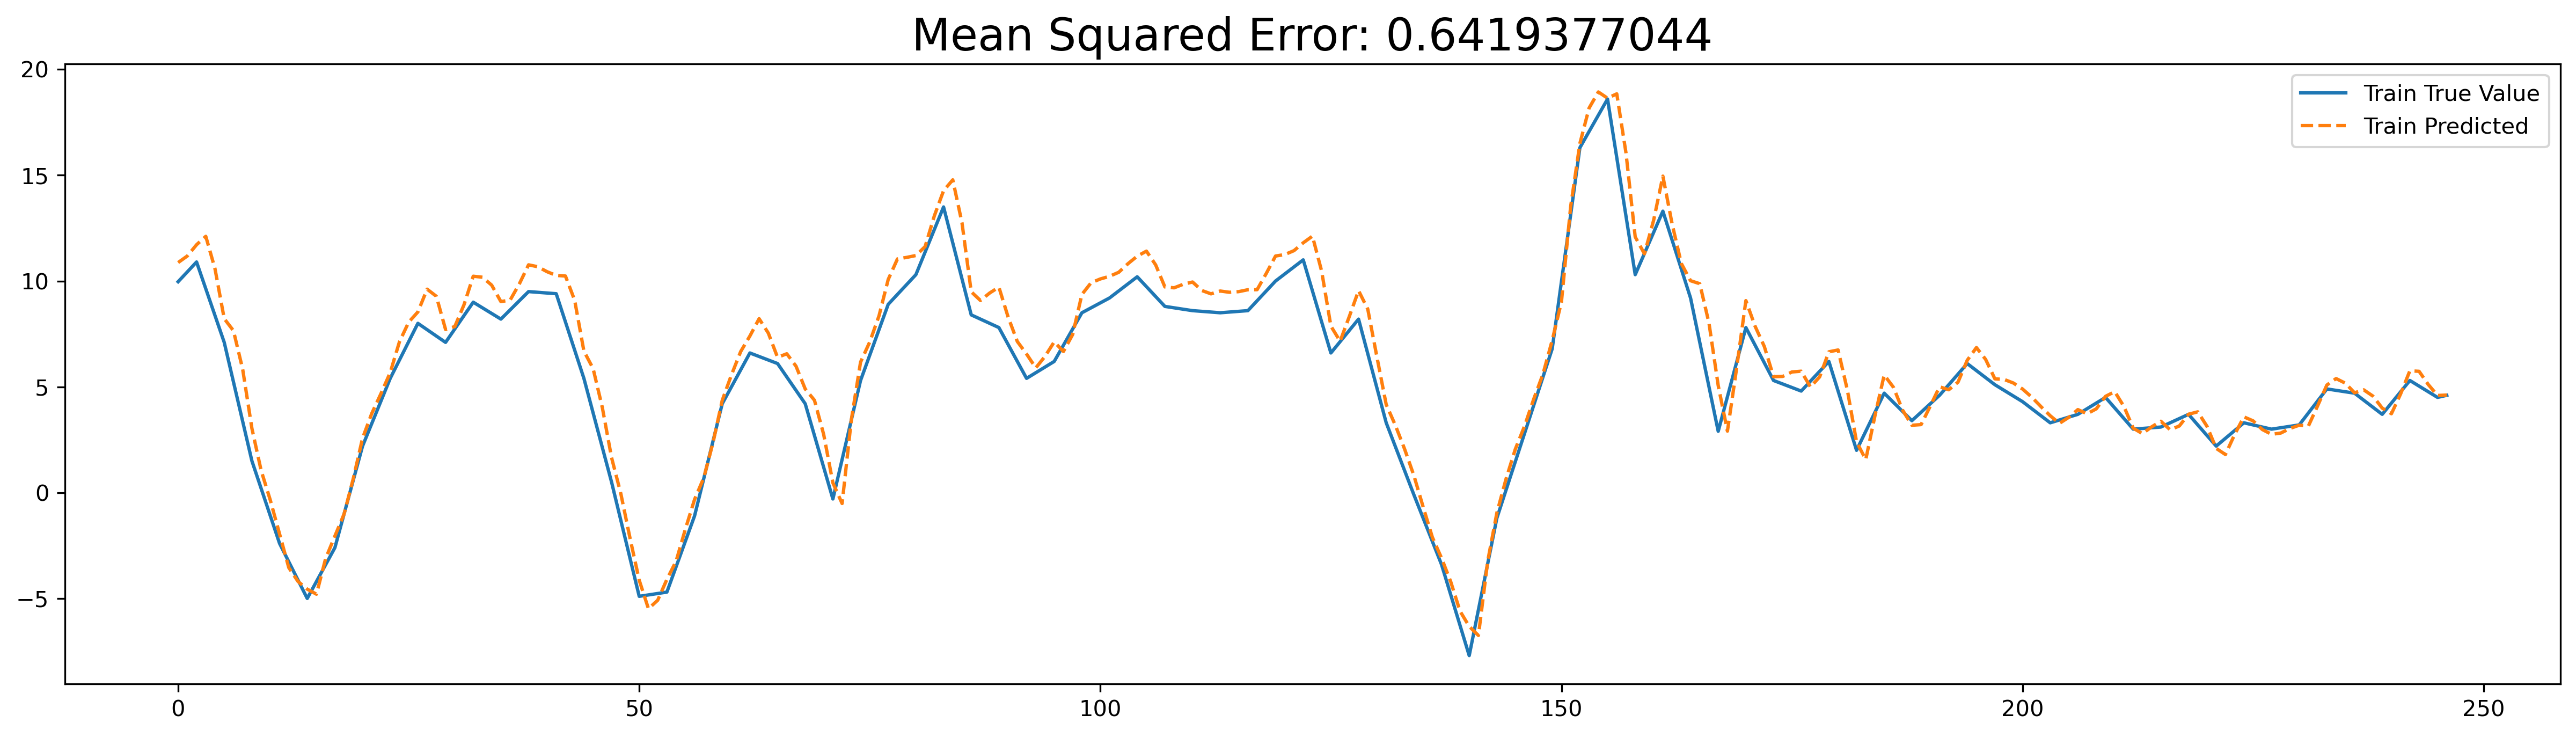

In [254]:
pred_train_single_12 = model_single_12.predict(X_train2)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_train,label='Train True Value')
plt.plot(pred_train,linestyle='--', label = 'Train Predicted')
plt.legend()
plt.title('Mean Squared Error: ' + str(mean_squared_error(pred_train_single_12,y_train2))[:12],fontsize=20)
plt.show()

In [230]:
model_single_12.model.save('./cnn_single_12.h5')

### Multilayer CNN

In this section, we will build a 2 layer "deeper" 1D CNN and compare with the baseline above.

In [92]:
conv_filters = [16, 32, 64]
kernel_size = 3
dense_units =32

# Set the random seed for TensorFlow
tf.random.set_seed(42)

# Set the random seed for numpy
np.random.seed(42)

model_deep = DeepCNNModel(conv_filters=conv_filters, 
                          kernel_size=kernel_size,
                          dense_units=dense_units)
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history_deep = model_deep.fit(X_train2, y_train2, 
                             epochs=400, 
                             batch_size=10, 
                             validation_split=0.1, 
                             verbose=1, 
                             shuffle=False, 
                             callbacks=[early_stop])

Epoch 1/400
22/22 [==============================] - 0s 5ms/step - loss: 46.7491 - mean_absolute_error: 5.7822 - val_loss: 8.4173 - val_mean_absolute_error: 2.8237
Epoch 2/400
22/22 [==============================] - 0s 2ms/step - loss: 23.6384 - mean_absolute_error: 3.7683 - val_loss: 1.7673 - val_mean_absolute_error: 1.1759
Epoch 3/400
22/22 [==============================] - 0s 2ms/step - loss: 19.8875 - mean_absolute_error: 3.2775 - val_loss: 1.6334 - val_mean_absolute_error: 1.1156
Epoch 4/400
22/22 [==============================] - 0s 2ms/step - loss: 18.0443 - mean_absolute_error: 3.1495 - val_loss: 1.5164 - val_mean_absolute_error: 1.0631
Epoch 5/400
22/22 [==============================] - 0s 2ms/step - loss: 15.5805 - mean_absolute_error: 2.9378 - val_loss: 1.1176 - val_mean_absolute_error: 0.8793
Epoch 6/400
22/22 [==============================] - 0s 2ms/step - loss: 13.7152 - mean_absolute_error: 2.7781 - val_loss: 0.7978 - val_mean_absolute_error: 0.7356
Epoch 7/400
22/2

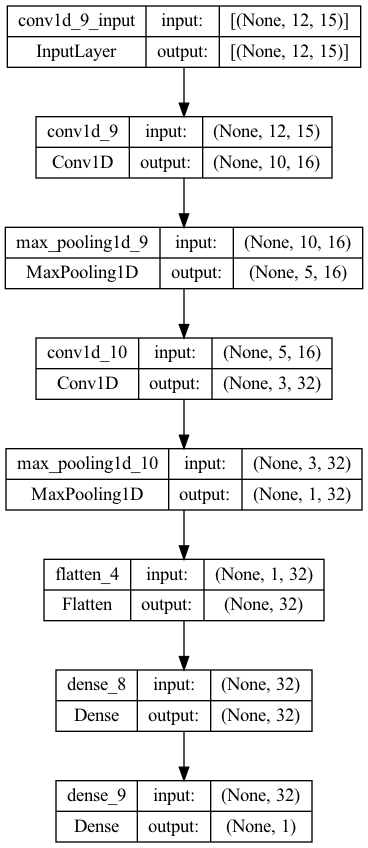

In [94]:
img_file = "./cnn_baseline_deep.png"
tf.keras.utils.plot_model(model_deep.model, to_file=img_file, show_shapes=True, show_layer_names=True)

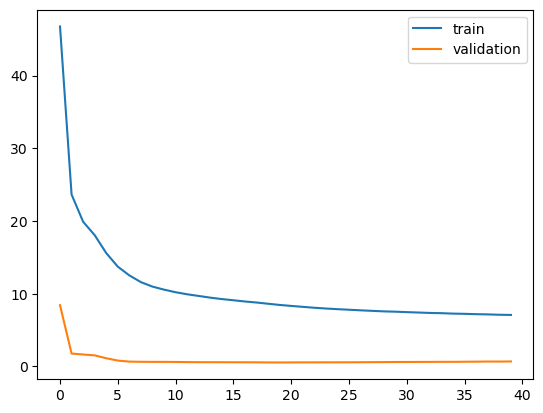

In [95]:
plt.plot(history_deep.history['loss'], label='train')
plt.plot(history_deep.history['val_loss'], label='validation')
plt.legend()
plt.show()

2/2 [==============================] - 0s 4ms/step


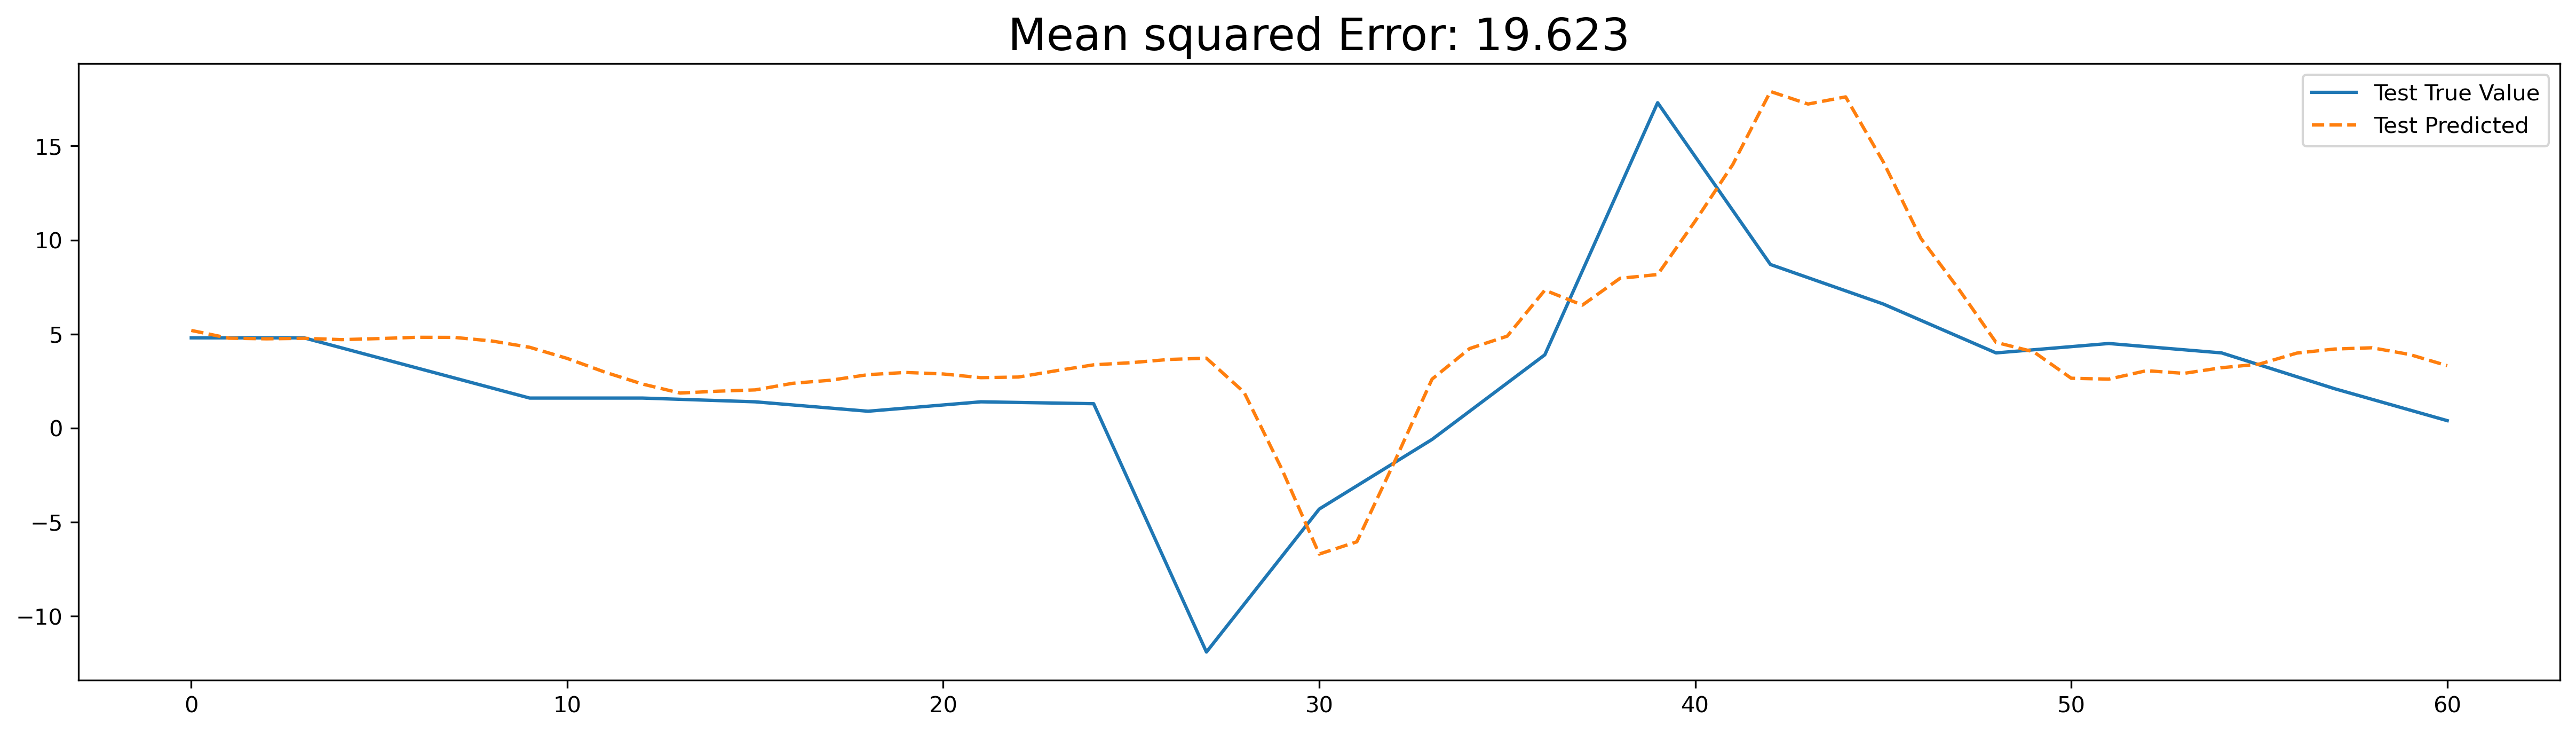

In [96]:
pred2 = model_deep.predict(X_test2)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_test2,label='Test True Value')
plt.plot(pred2,linestyle='--', label = 'Test Predicted')
plt.legend()
plt.title('Mean squared Error: '+str(mean_squared_error(pred2,y_test2))[:6],fontsize=20)
plt.show()

8/8 [==============================] - 0s 604us/step


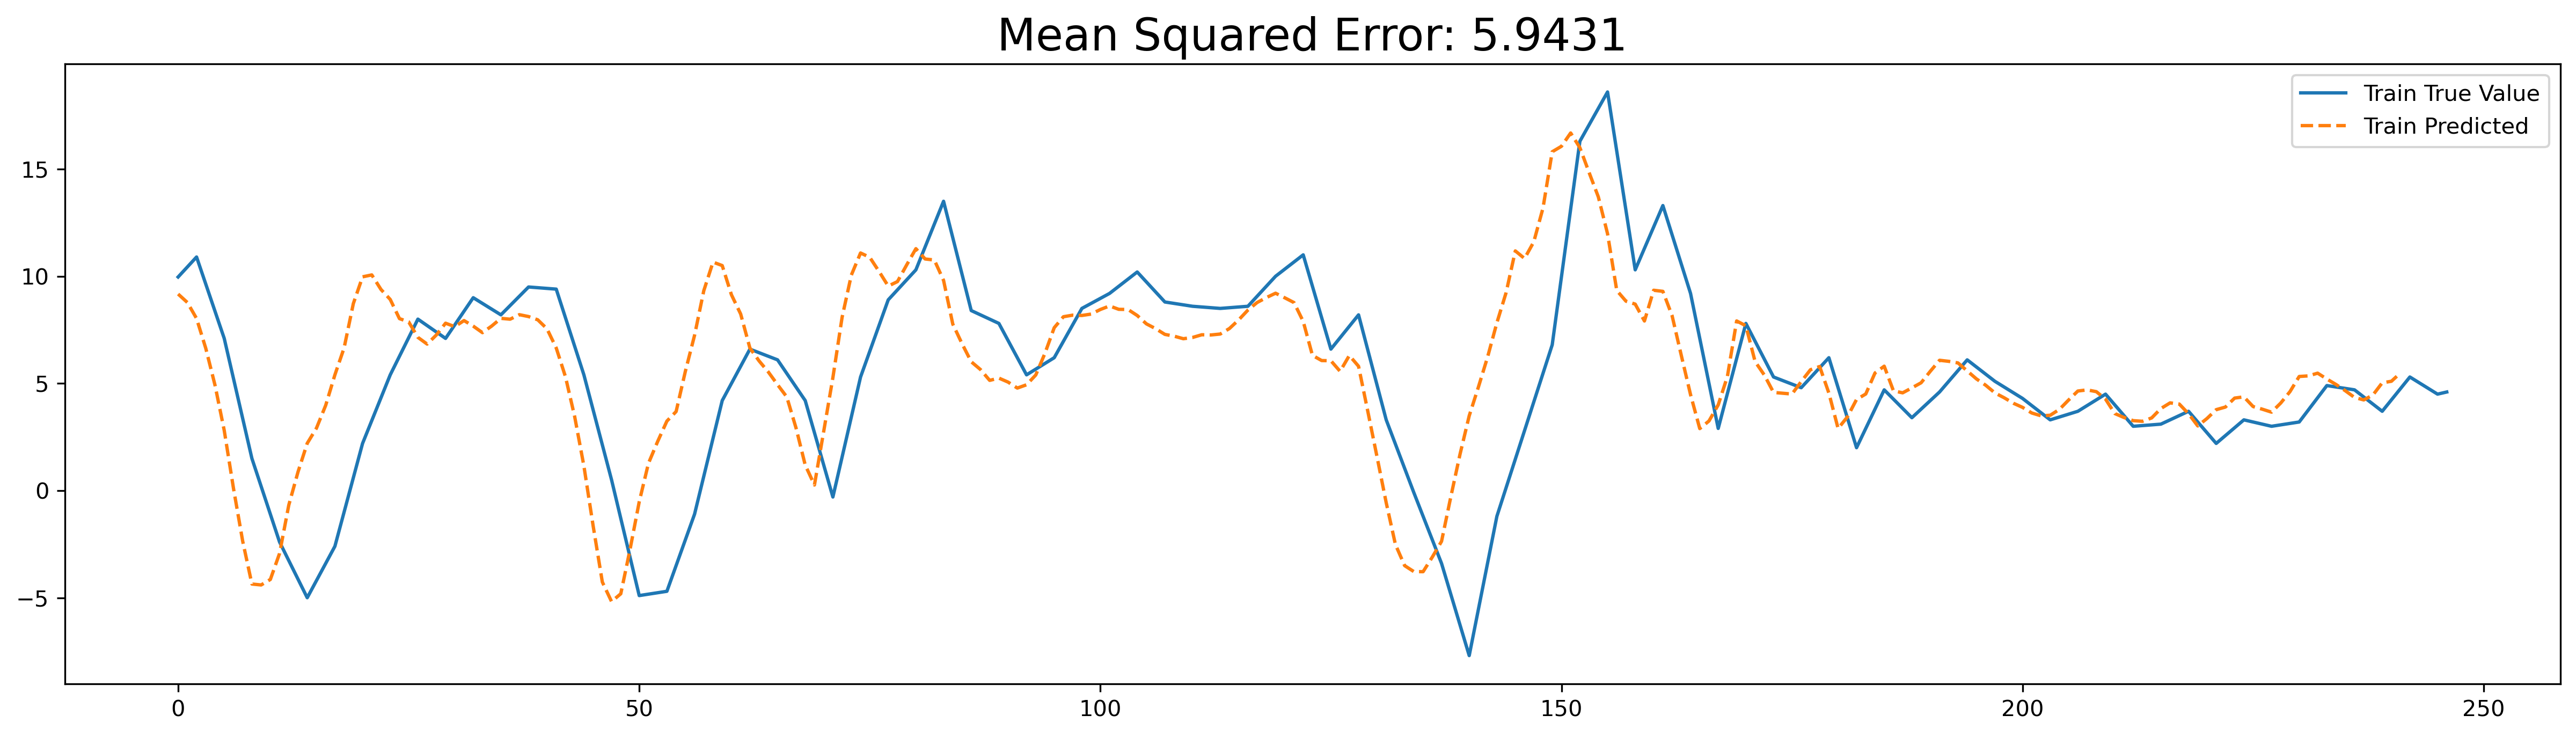

In [97]:
pred_train2 = model_deep.predict(X_train2)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_train,label='Train True Value')
plt.plot(pred_train2,linestyle='--', label = 'Train Predicted')
plt.legend()
plt.title('Mean Squared Error: ' + str(mean_squared_error(pred_train2,y_train2))[:6],fontsize=20)
plt.show()

In [98]:
model_deep.model.save('./cnn_deep.h5')

With deeper 1D CNN and longer lookback period, the model seems to perform worse than a simpler architecture. Subsequently, we will perform hyperparameter tuning on the baseline CNN only.

## Hyperparameter Tuning

In this section, we will use Keras Tuner to perform hyperparameter tuning with Bayesian Optimization strategy.

### Tune Single Layer 1D CNN with Lookback 6

In [26]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=16, max_value=64, step=16),
        kernel_size=hp.Int('kernel_size', min_value=3, max_value=5),
        activation='relu'
    ))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dense(units=1))

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    return model

In [28]:

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='tuner_cnn',
    project_name='CNN'
)

tuner.search(
    x=X_train,
    y=y_train,
    epochs=400,
    batch_size=10,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
)


Trial 10 Complete [00h 00m 08s]
val_loss: 0.22523431479930878

Best val_loss So Far: 0.0809627075990041
Total elapsed time: 00h 01m 59s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [30]:
best_parameters = tuner.get_best_hyperparameters(1)[0]

In [31]:
best_parameters.values

{'filters': 16,
 'kernel_size': 3,
 'dense_units': 16,
 'learning_rate': 0.006489108709865806}

In [32]:
best_model = tuner.get_best_models()[0]

In [33]:
train_results = best_model.predict(X_train)
test_results = best_model.predict(X_test)

2/2 [==============================] - 0s 949us/step


In [59]:
test_results.shape

(62, 1)

In [71]:
date = data.index
date = date[6:]
date_train = date[:len(train_results)]
date_test = date[len(train_results):]
test = pd.DataFrame(zip(date_test, test_results, y_test), columns = ['Period','Predicted', 'Actual'])
test['Predicted'] = test['Predicted'].apply(lambda x: float(x))
test['Actual'] = test['Actual'].apply(lambda x: float(x))
test['Period'] = test['Period'].apply(lambda x: x[:7])
test.set_index(test['Period'], inplace = True)

<AxesSubplot: title={'center': 'Nowcasting GDP using 1D CNN'}, xlabel='Period'>

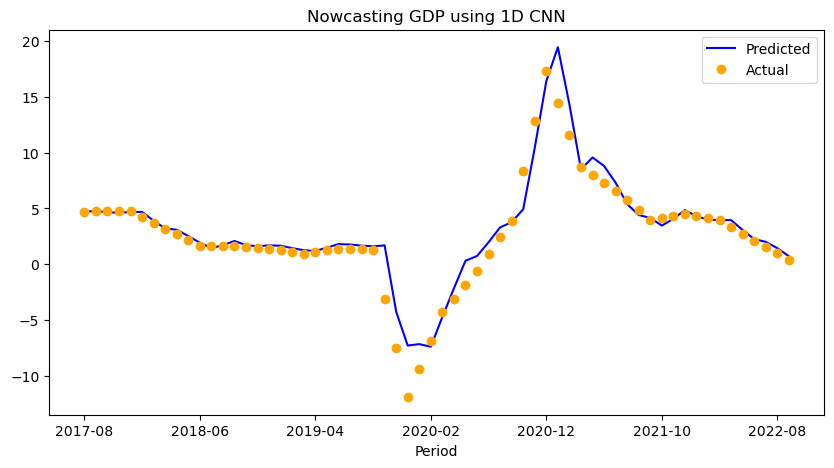

In [73]:
test.plot(
    use_index = True,
    style=['-','o'],
    color=['blue',"orange"],
    figsize=(10,5),
    title = 'Nowcasting GDP using 1D CNN')

In [54]:
print('RMSE: '+ str(mean_squared_error(test_results,y_test, squared = False))[:6])
print('MSE: '+ str(mean_squared_error(test_results,y_test))[:6])
print('MAE: '+ str(mean_absolute_error(test_results,y_test))[:6])

RMSE: 1.4468
MSE: 2.0933
MAE: 0.8417


In [38]:
best_model.save('./cnn_tuned.h5')

### Tune Single Layer 1D CNN with Lookback 12

In [232]:
tuner_single_12 = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='tuner_cnn',
    project_name='CNN_Single_12'
)

tuner_single_12.search(
    x=X_train2,
    y=y_train2,
    epochs=400,
    batch_size=10,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
)


Trial 10 Complete [00h 00m 42s]
val_loss: 0.0626235914727052

Best val_loss So Far: 0.046162703384955726
Total elapsed time: 00h 03m 26s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [233]:
best_parameters_single_12 = tuner_single_12.get_best_hyperparameters(1)[0]

In [234]:
best_parameters_single_12.values

{'filters': 48,
 'kernel_size': 3,
 'dense_units': 64,
 'learning_rate': 0.006749602440758899}

In [235]:
best_model_single_12 = tuner_single_12.get_best_models()[0]

In [236]:
train_results_single_12 = best_model_single_12.predict(X_train2)
test_results_single_12 = best_model_single_12.predict(X_test2)

2/2 [==============================] - 0s 13ms/step


<AxesSubplot: title={'center': 'Nowcasting GDP using 1D CNN'}, xlabel='Period'>

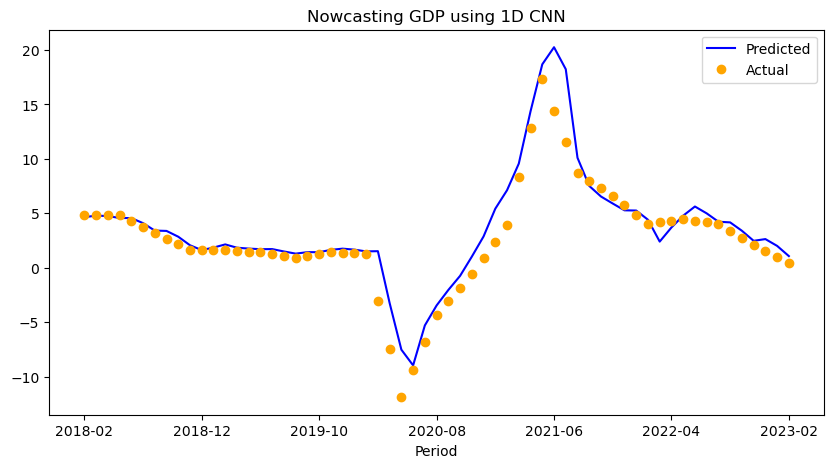

In [258]:
date = data.index
date = date[6:]
date_train_single_12 = date[:len(train_results)]
date_test_single_12 = date[len(train_results):]
test_single_12 = pd.DataFrame(zip(date_test_single_12, test_results_single_12, y_test2),
                              columns = ['Period','Predicted', 'Actual'])
test_single_12['Predicted'] = test_single_12['Predicted'].apply(lambda x: float(x))
test_single_12['Actual'] = test_single_12['Actual'].apply(lambda x: float(x))
test_single_12['Period'] = test_single_12['Period'].apply(lambda x: x[:7])
test_single_12.set_index(test_single_12['Period'], inplace = True)

test_single_12.plot(
    use_index = True,
    style=['-','o'],
    color=['blue',"orange"],
    figsize=(10,5),
    title = 'Nowcasting GDP using 1D CNN')

In [245]:
print('RMSE: '+ str(mean_squared_error(test_results_single_12,y_test2, squared = False))[:6])
print('MSE: '+ str(mean_squared_error(test_results_single_12,y_test2))[:6])
print('MAE: '+ str(mean_absolute_error(test_results_single_12,y_test2))[:6])

RMSE: 1.7704
MSE: 3.1344
MAE: 1.0941


In [260]:
best_model_single_12.save('./cnn_single_12_tuned.h5')

### Tune Multi Layer 1D CNN with Lookback 12

In [264]:
def build_deep_model_(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters1', min_value=16, max_value=64, step=16),
        kernel_size=hp.Int('kernel_size1', min_value=3, max_value=5),
        activation='relu'
    ))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters2', min_value=16, max_value=64, step=16),
        kernel_size=hp.Int('kernel_size2', min_value=3, max_value=5),
        activation='relu'
    ))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))        
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dense(units=1))

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    return model


tuner_multi_12 = kt.BayesianOptimization(
    build_deep_model_,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='tuner_cnn',
    project_name='CNN_Multi_12'
)

tuner_multi_12.search(
    x=X_train2,
    y=y_train2,
    epochs=400,
    batch_size=10,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
)


Trial 10 Complete [00h 00m 25s]
val_loss: 0.38094507654507953

Best val_loss So Far: 0.14039563884337744
Total elapsed time: 00h 01m 28s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [267]:
tuner_multi_12.search_space_summary()

Search space summary
Default search space size: 6
filters1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
kernel_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
filters2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
kernel_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [265]:
best_parameters_multi_12 = tuner_multi_12.get_best_hyperparameters(1)[0]

In [266]:
best_parameters_multi_12.values

{'filters1': 16,
 'kernel_size1': 5,
 'filters2': 48,
 'kernel_size2': 3,
 'dense_units': 64,
 'learning_rate': 0.002751957617648741}

In [268]:
best_model_multi_12 = tuner_multi_12.get_best_models()[0]

In [269]:
train_results_multi_12 = best_model_multi_12.predict(X_train2)
test_results_multi_12 = best_model_multi_12.predict(X_test2)

2/2 [==============================] - 0s 4ms/step


<AxesSubplot: title={'center': 'Nowcasting GDP using 1D CNN'}, xlabel='Period'>

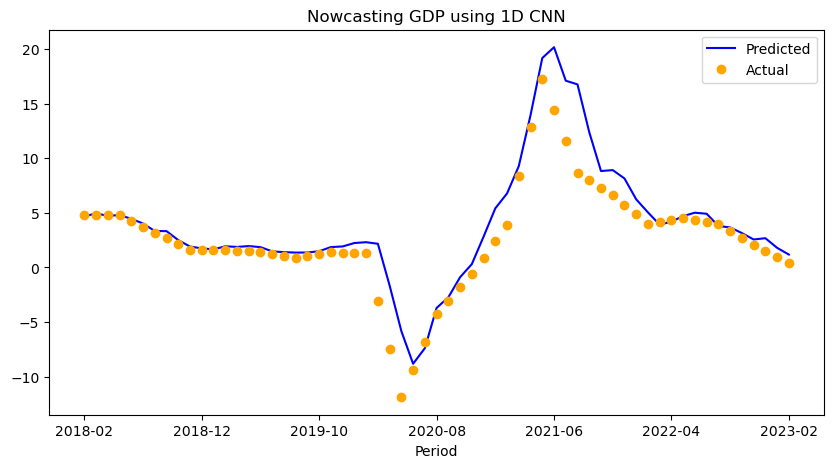

In [270]:
date = data.index
date = date[6:]
date_train_multi_12 = date[:len(train_results)]
date_test_multi_12 = date[len(train_results):]
test_multi_12 = pd.DataFrame(zip(date_test_multi_12, test_results_multi_12, y_test2),
                              columns = ['Period','Predicted', 'Actual'])
test_multi_12['Predicted'] = test_multi_12['Predicted'].apply(lambda x: float(x))
test_multi_12['Actual'] = test_multi_12['Actual'].apply(lambda x: float(x))
test_multi_12['Period'] = test_multi_12['Period'].apply(lambda x: x[:7])
test_multi_12.set_index(test_multi_12['Period'], inplace = True)

test_multi_12.plot(
    use_index = True,
    style=['-','o'],
    color=['blue',"orange"],
    figsize=(10,5),
    title = 'Nowcasting GDP using 1D CNN')

In [271]:
print('RMSE: '+ str(mean_squared_error(test_results_multi_12,y_test2, squared = False))[:6])
print('MSE: '+ str(mean_squared_error(test_results_multi_12,y_test2))[:6])
print('MAE: '+ str(mean_absolute_error(test_results_multi_12,y_test2))[:6])

RMSE: 2.2261
MSE: 4.9557
MAE: 1.3144


In [272]:
best_model_multi_12.save('./cnn_multi_12_tuned.h5')

## Model Comparision

In this section, we plot the 3 tuned models side by side.

In [285]:
date = data.index
date = date[6:]
date_train_compare = date[:len(train_results)]
date_test_compare = date[len(train_results):]
test_compare = pd.DataFrame(zip(date_test_multi_12, test_results, test_results_single_12, test_results_multi_12, y_test),
                              columns = ['Period','1 Conv1D with lookback 6', '1 Conv1D with lookback 12',
                                         '2 Conv1D with lookback 12', 'Actual'])
test_compare['1 Conv1D with lookback 6'] = test_compare['1 Conv1D with lookback 6'].apply(lambda x: float(x))
test_compare['1 Conv1D with lookback 12'] = test_compare['1 Conv1D with lookback 12'].apply(lambda x: float(x))
test_compare['2 Conv1D with lookback 12'] = test_compare['2 Conv1D with lookback 12'].apply(lambda x: float(x))
test_compare['Actual'] = test_compare['Actual'].apply(lambda x: float(x))
test_compare['Period'] = test_compare['Period'].apply(lambda x: x[:7])
test_compare.set_index(test_compare['Period'], inplace = True)

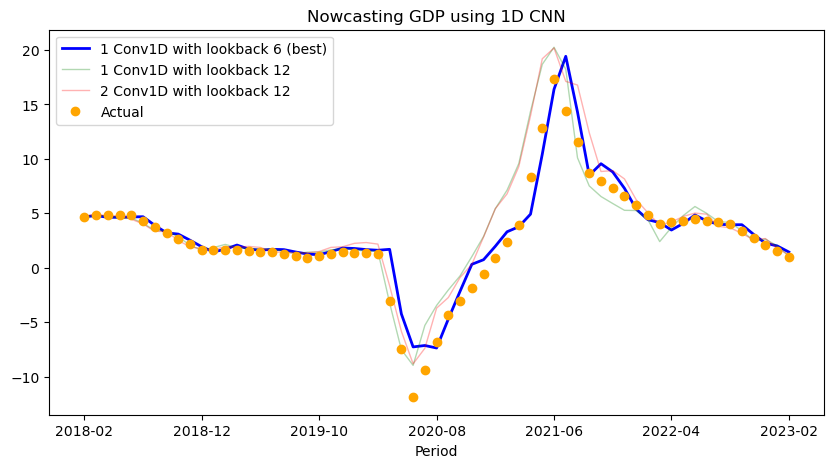

In [297]:
fig, ax = plt.subplots(figsize=(10, 5))
test_compare.plot(
    ax=ax,
    use_index=True,
    style=['-', '-', '-', 'o'],
    color=['blue', 'green', 'red', 'orange'],
    title='Nowcasting GDP using 1D CNN'
)

ax.lines[0].set_label('1 Conv1D with lookback 6 (best)')

ax.lines[1].set_alpha(0.3)
ax.lines[2].set_alpha(0.3)

ax.lines[0].set_linewidth(2)
ax.lines[1].set_linewidth(1)
ax.lines[2].set_linewidth(1)
ax.lines[3].set_linewidth(2)

ax.legend()

plt.show()

## Model Evaluation

This section loads the trained model for evaluation on the test set without training.

### Best Tuned Model

Single Conv1d layer with lookback 6

In [42]:
model_eval1 = tf.keras.models.load_model('./cnn_tuned.h5')

In [43]:
train_results = model_eval1.predict(X_train)
test_results = model_eval1.predict(X_test)

2/2 [==============================] - 0s 8ms/step


<AxesSubplot: title={'center': 'Nowcasting GDP using CNN'}, xlabel='Period'>

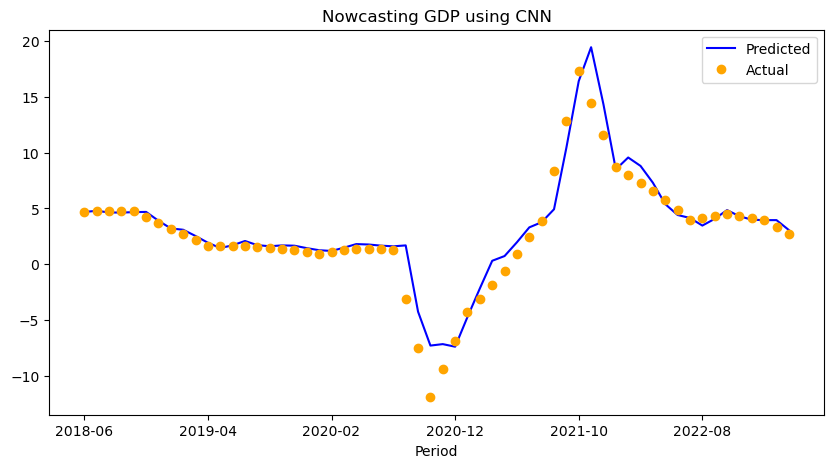

In [46]:
date = data.index
date = date[6:]
date_train = date[:len(train_results)]
date_test = date[len(train_results):]
test = pd.DataFrame(zip(date_test, test_results, y_test), columns = ['Period','Predicted', 'Actual'])
test['Predicted'] = test['Predicted'].apply(lambda x: float(x))
test['Actual'] = test['Actual'].apply(lambda x: float(x))
test['Period'] = test['Period'].apply(lambda x: x[:7])
test.set_index(test['Period'], inplace = True)

test.plot(
    use_index = True,
    style=['-','o'],
    color=['blue',"orange"],
    figsize=(10,5),
    title = 'Nowcasting GDP using CNN')

In [45]:
print('RMSE: '+ str(mean_squared_error(test_results,y_test, squared = False))[:6])
print('MSE: '+ str(mean_squared_error(test_results,y_test))[:6])
print('MAE: '+ str(mean_absolute_error(test_results,y_test))[:6])

RMSE: 1.4468
MSE: 2.0933
MAE: 0.8417


In [110]:
model_eval1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 16)             736       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 16)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
______________________________________________________

### Multilayer Model

In [151]:
model_eval2 = tf.keras.models.load_model('./cnn_deep.h5')

2/2 [==============================] - 0s 2ms/step


<AxesSubplot: title={'center': 'Nowcasting GDP using CNN'}, xlabel='Period'>

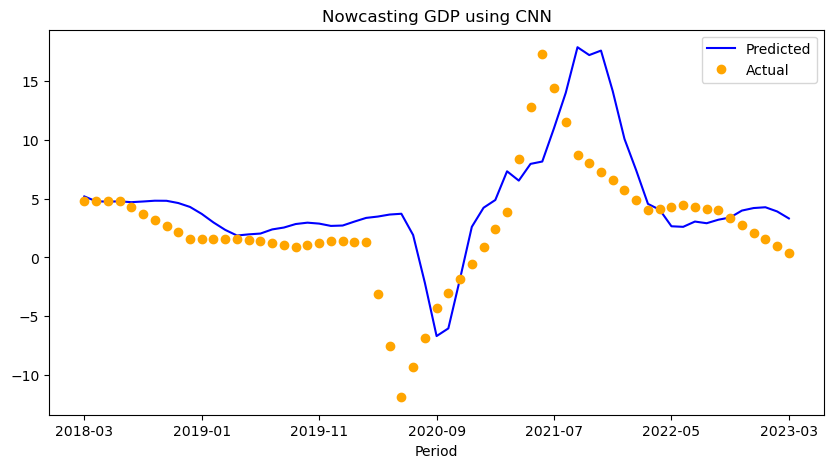

In [154]:
train_results2 = model_eval2.predict(X_train2)
test_results2 = model_eval2.predict(X_test2)

date2 = data.index
date2 = date2[12:]
date_train2 = date2[:len(train_results2)]
date_test2 = date2[len(train_results2):]
test2 = pd.DataFrame(zip(date_test2, test_results2, y_test2), columns = ['Period','Predicted', 'Actual'])
test2['Predicted'] = test2['Predicted'].apply(lambda x: float(x))
test2['Actual'] = test2['Actual'].apply(lambda x: float(x))
test2['Period'] = test2['Period'].apply(lambda x: x[:7])
test2.set_index(test2['Period'], inplace = True)

test2.plot(
    use_index = True,
    style=['-','o'],
    color=['blue',"orange"],
    figsize=(10,5),
    title = 'Nowcasting GDP using CNN')

In [155]:
print('RMSE: '+ str(mean_squared_error(test_results2,y_test2, squared = False))[:6])
print('MSE: '+ str(mean_squared_error(test_results2,y_test2))[:6])
print('MAE: '+ str(mean_absolute_error(test_results2,y_test2))[:6])

RMSE: 4.4297
MSE: 19.623
MAE: 2.9970


## Explainability

### Explainability for Tuned Model

0
1/1 [==============================] - 0s 26ms/step
Model prediction = (4.681412696838379), True Value = [4.7]


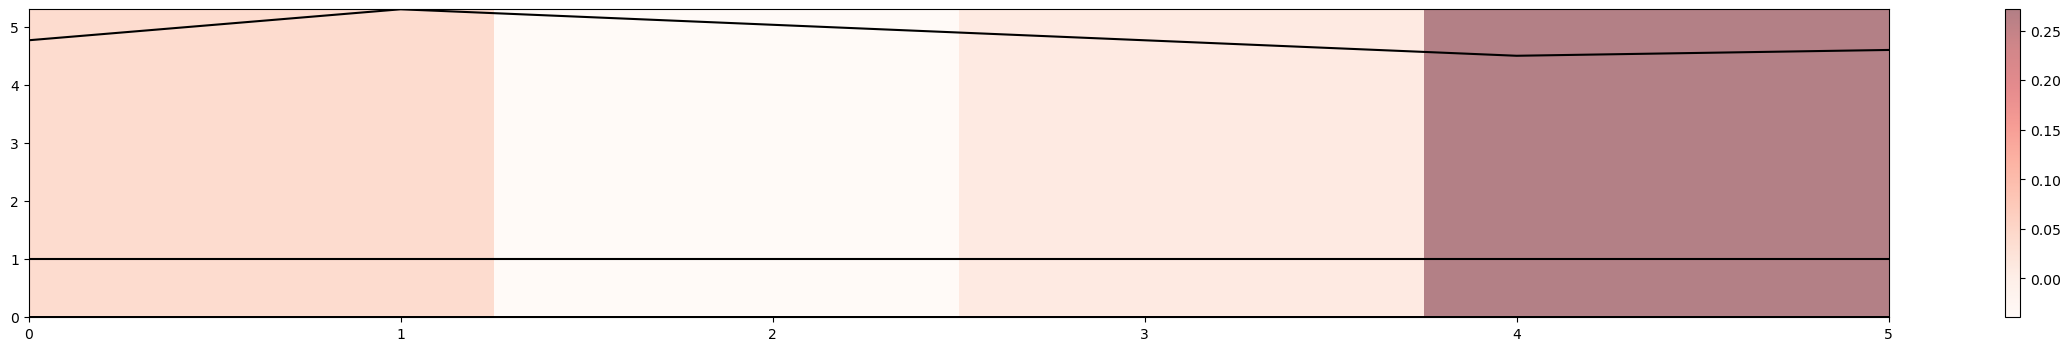

1
1/1 [==============================] - 0s 17ms/step
Model prediction = (4.782772541046143), True Value = [4.8]


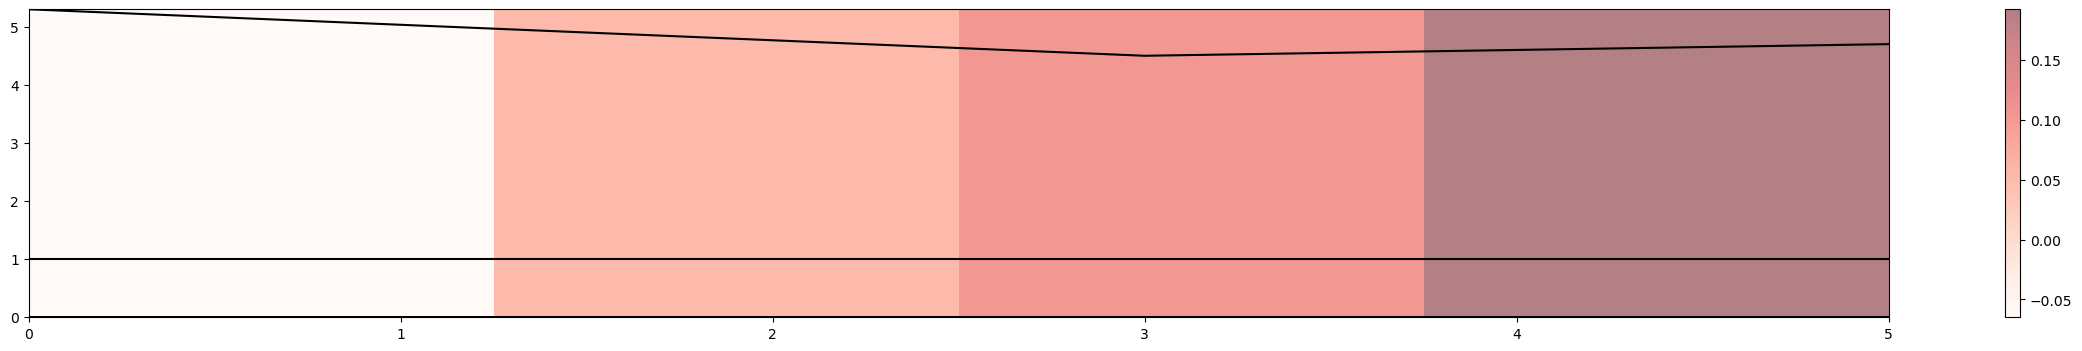

2
1/1 [==============================] - 0s 15ms/step
Model prediction = (4.637109756469727), True Value = [4.8]


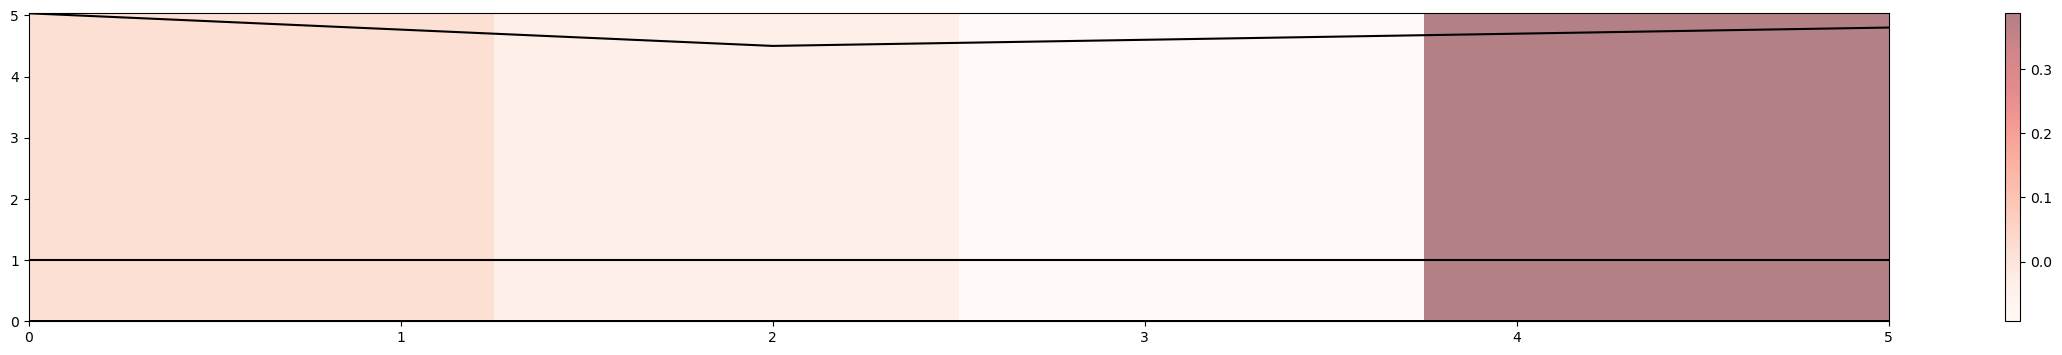

3
1/1 [==============================] - 0s 27ms/step
Model prediction = (4.625502586364746), True Value = [4.8]


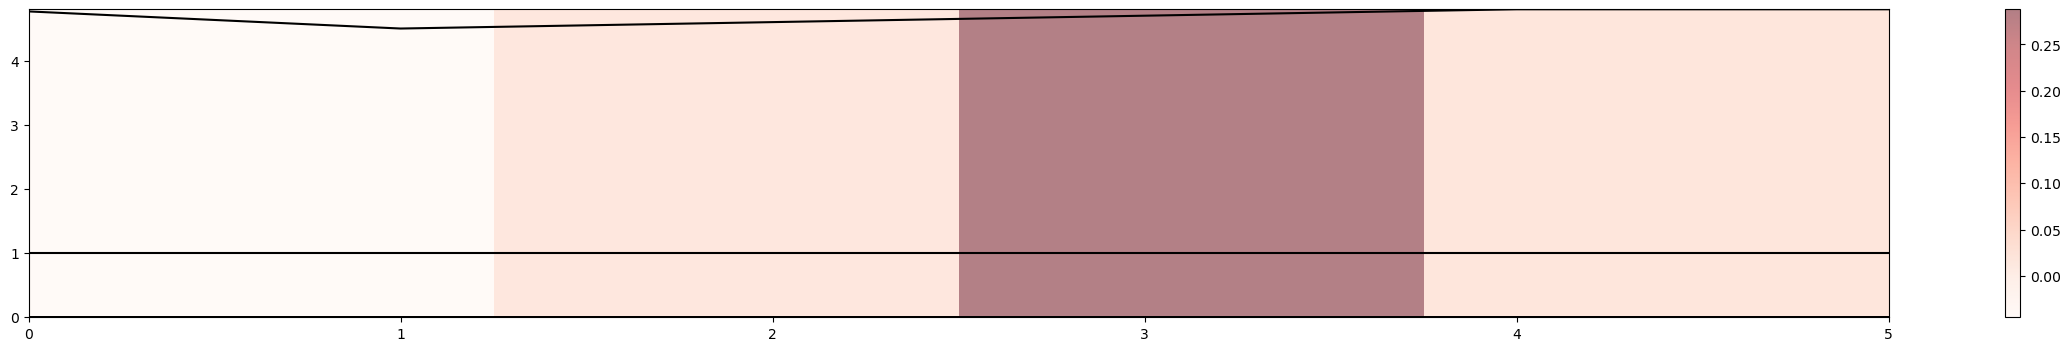

4
1/1 [==============================] - 0s 11ms/step
Model prediction = (4.666624069213867), True Value = [4.8]


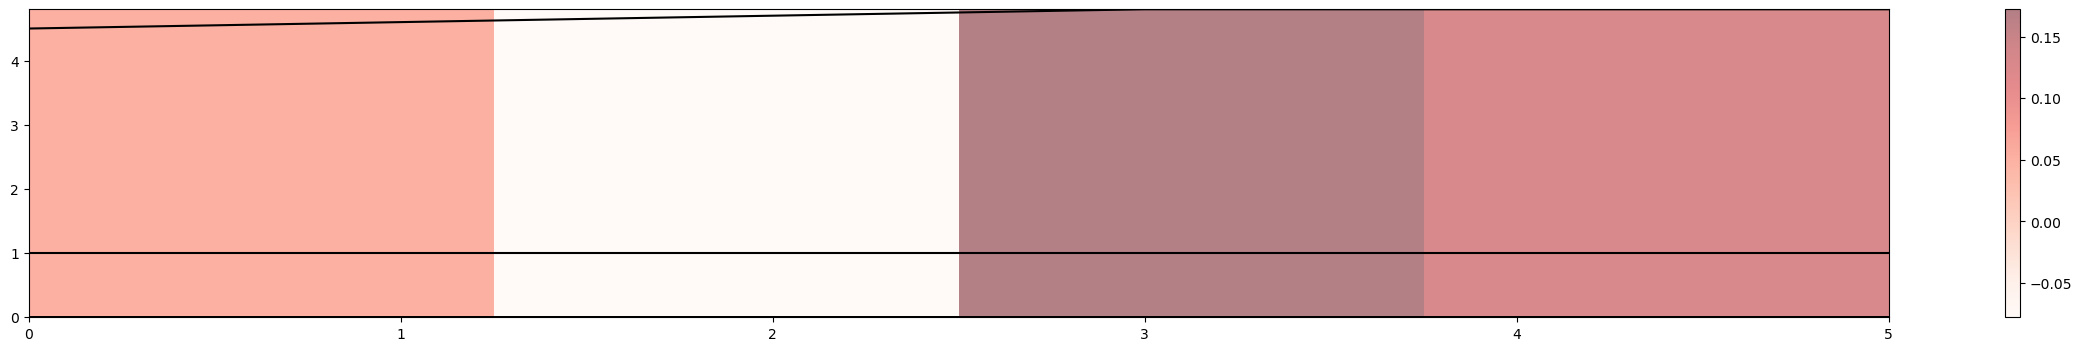

5
1/1 [==============================] - 0s 13ms/step
Model prediction = (4.685090065002441), True Value = [4.26666667]


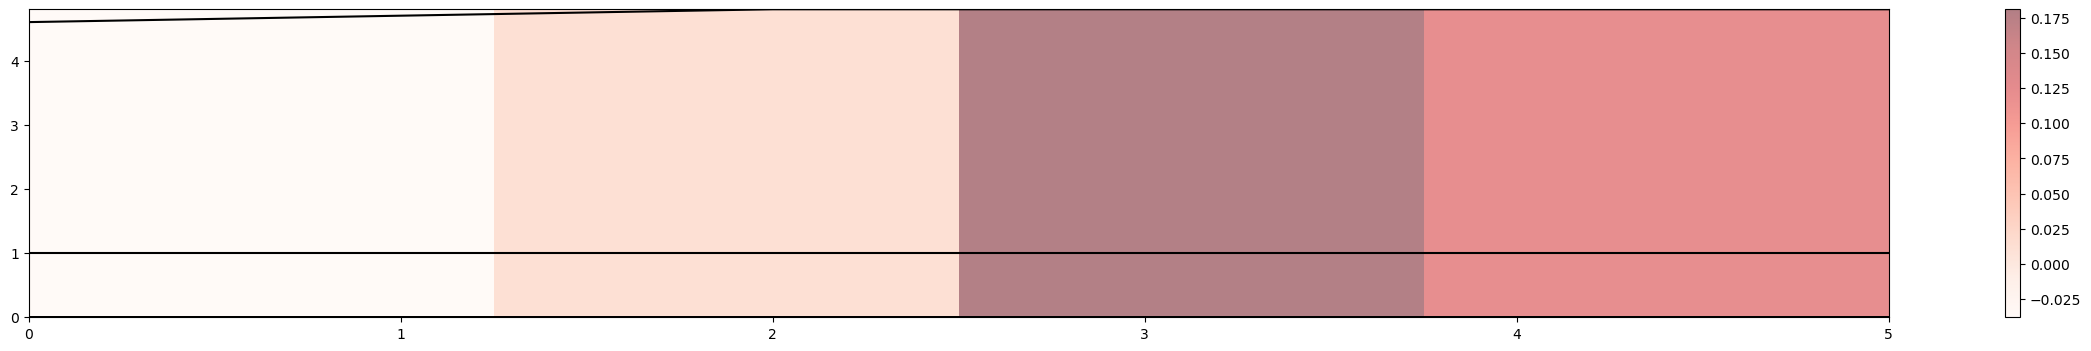

6
1/1 [==============================] - 0s 12ms/step
Model prediction = (3.8928768634796143), True Value = [3.73333333]


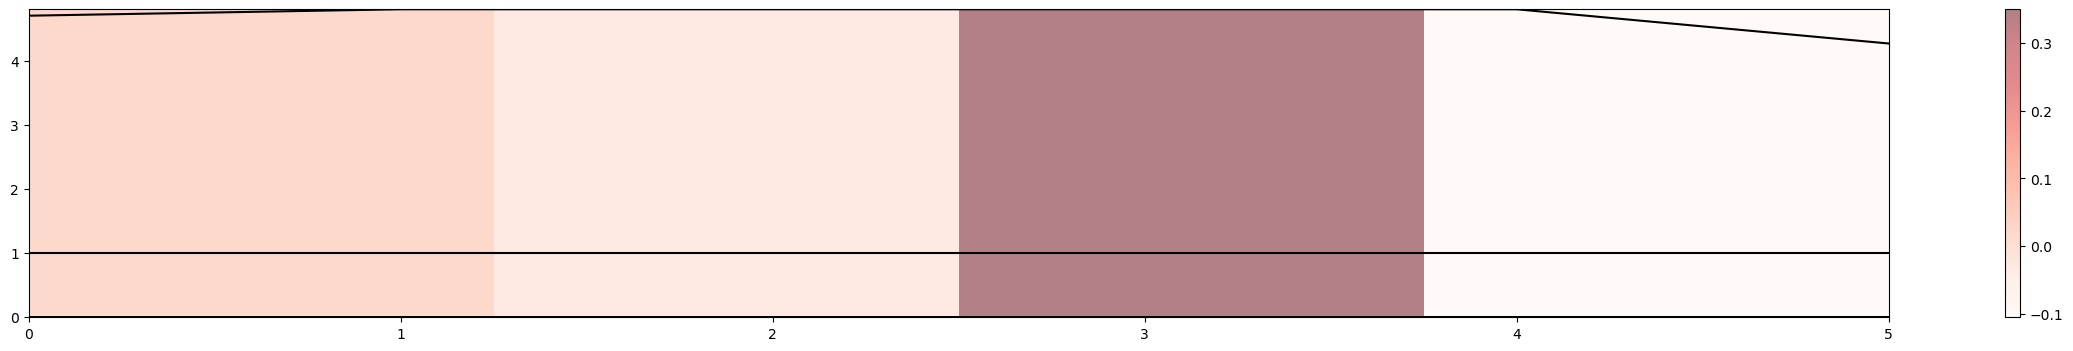

7
1/1 [==============================] - 0s 12ms/step
Model prediction = (3.2066972255706787), True Value = [3.2]


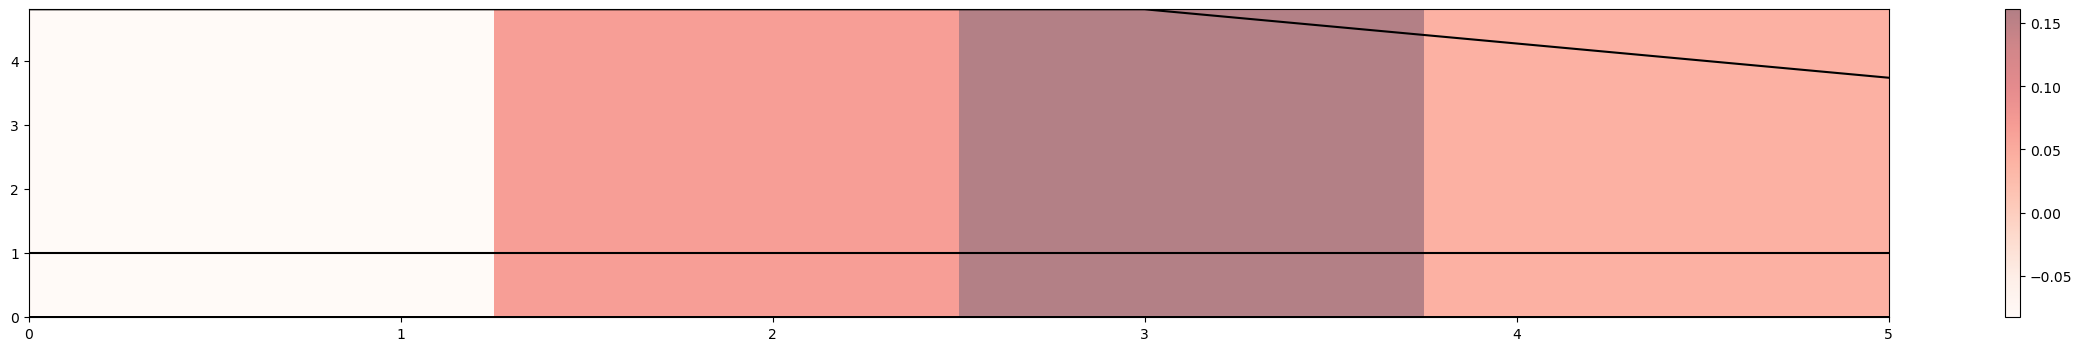

8
1/1 [==============================] - 0s 13ms/step
Model prediction = (3.088303565979004), True Value = [2.66666667]


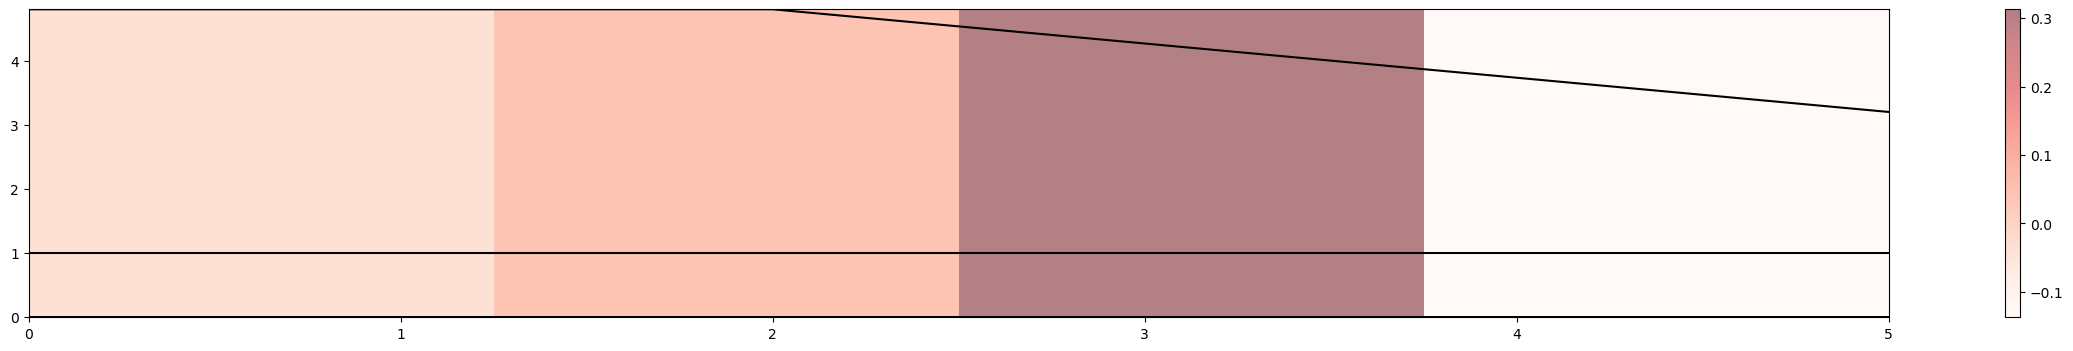

9
1/1 [==============================] - 0s 13ms/step
Model prediction = (2.528160572052002), True Value = [2.13333333]


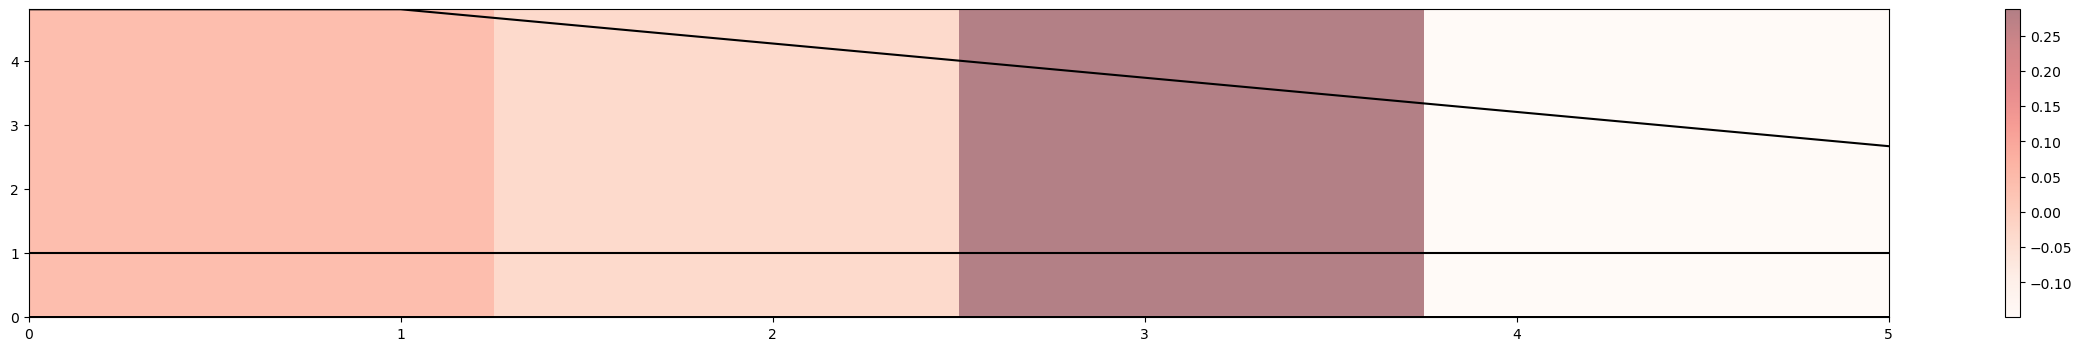

10
1/1 [==============================] - 0s 12ms/step
Model prediction = (1.9255403280258179), True Value = [1.6]


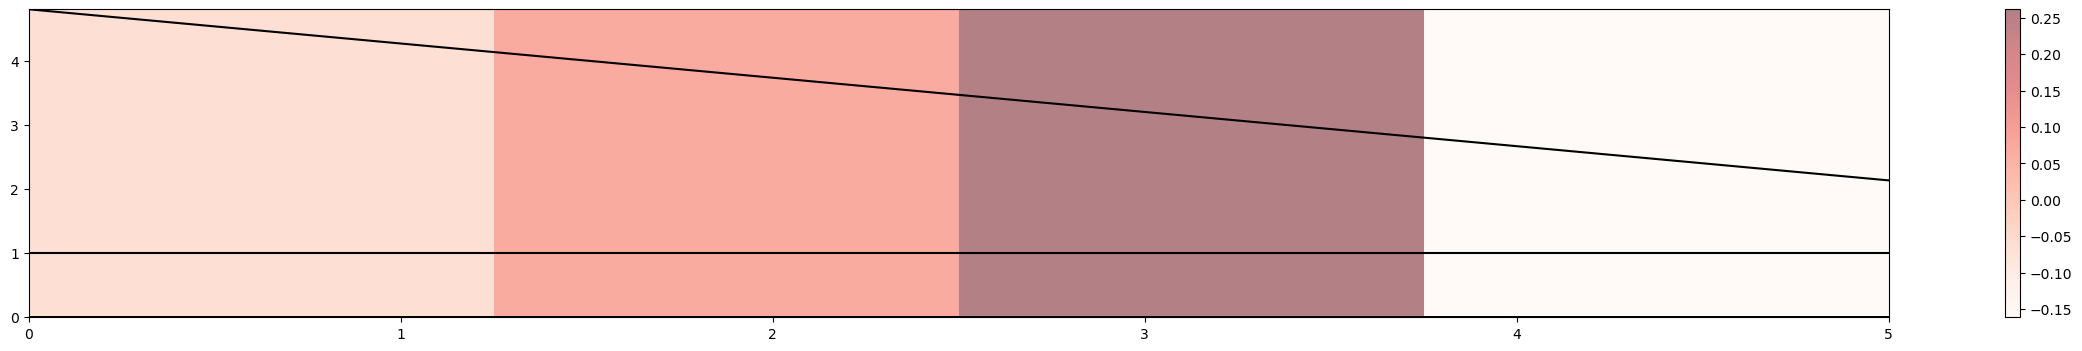

11
1/1 [==============================] - 0s 12ms/step
Model prediction = (1.4517983198165894), True Value = [1.6]


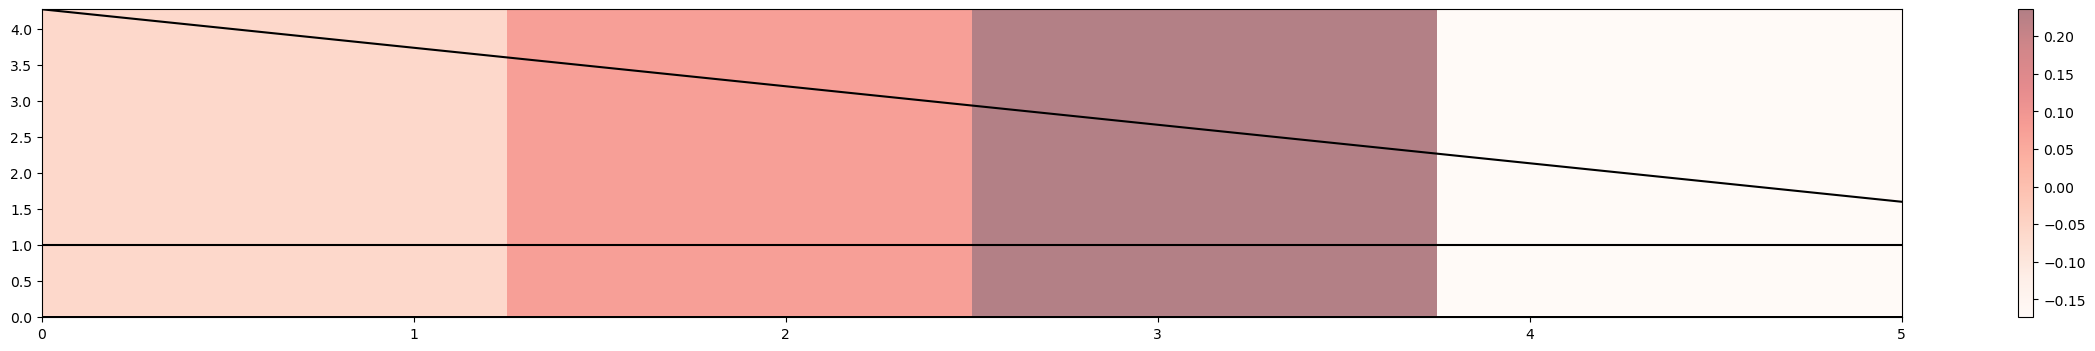

12
1/1 [==============================] - 0s 11ms/step
Model prediction = (1.6992337703704834), True Value = [1.6]


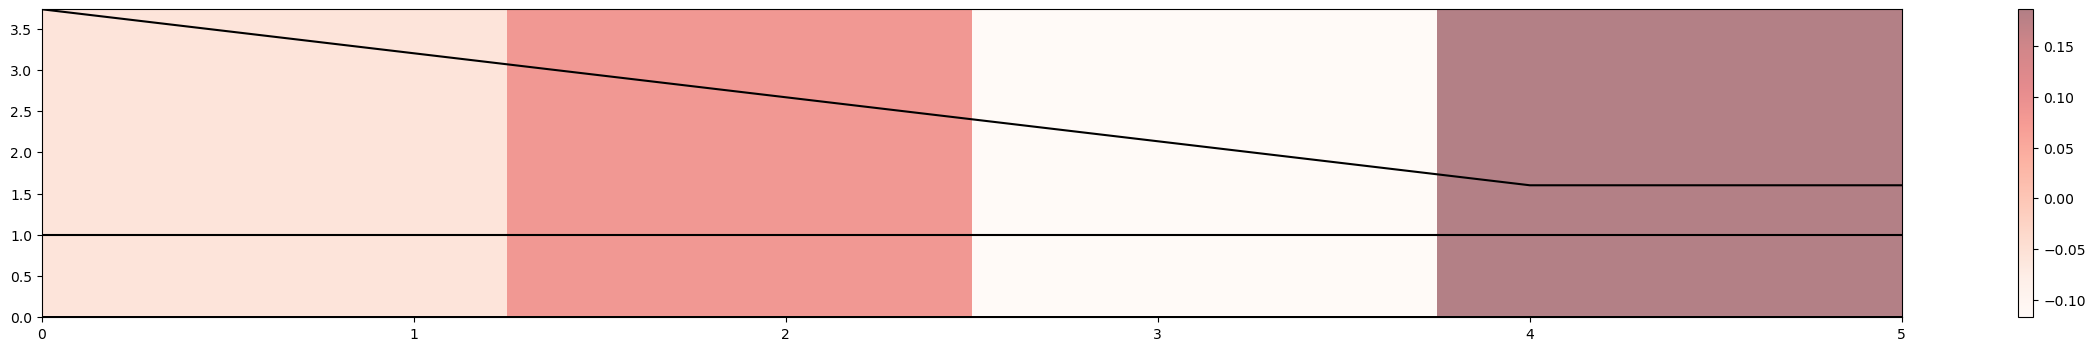

13
1/1 [==============================] - 0s 13ms/step
Model prediction = (2.083160161972046), True Value = [1.6]


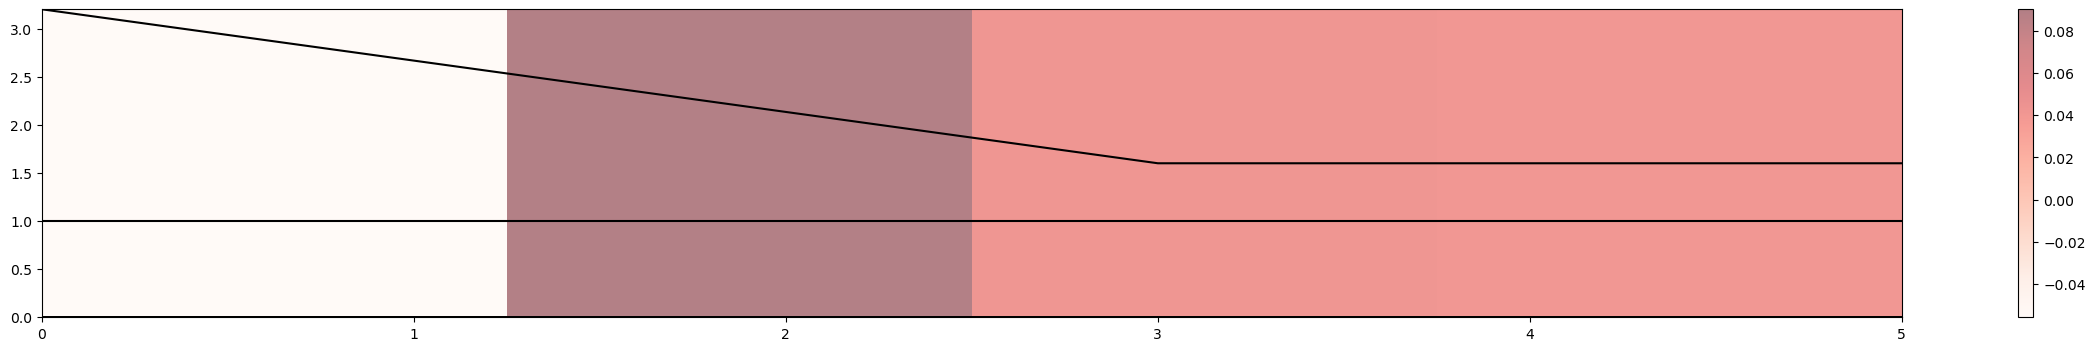

14
1/1 [==============================] - 0s 12ms/step
Model prediction = (1.709537148475647), True Value = [1.53333333]


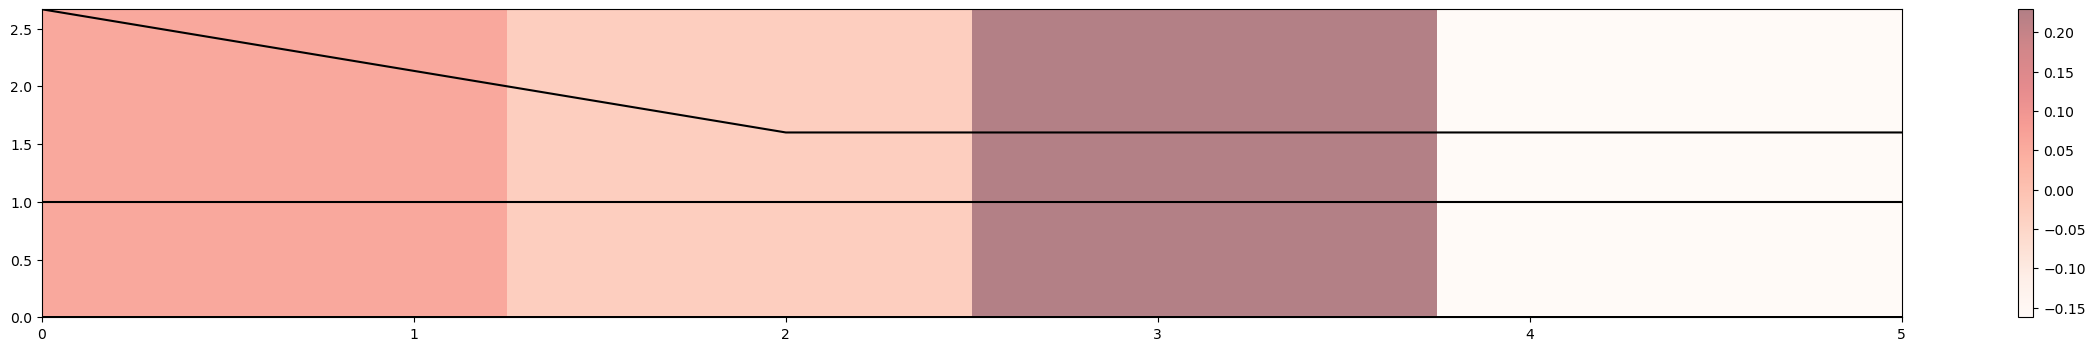

15
1/1 [==============================] - 0s 12ms/step
Model prediction = (1.6119920015335083), True Value = [1.46666667]


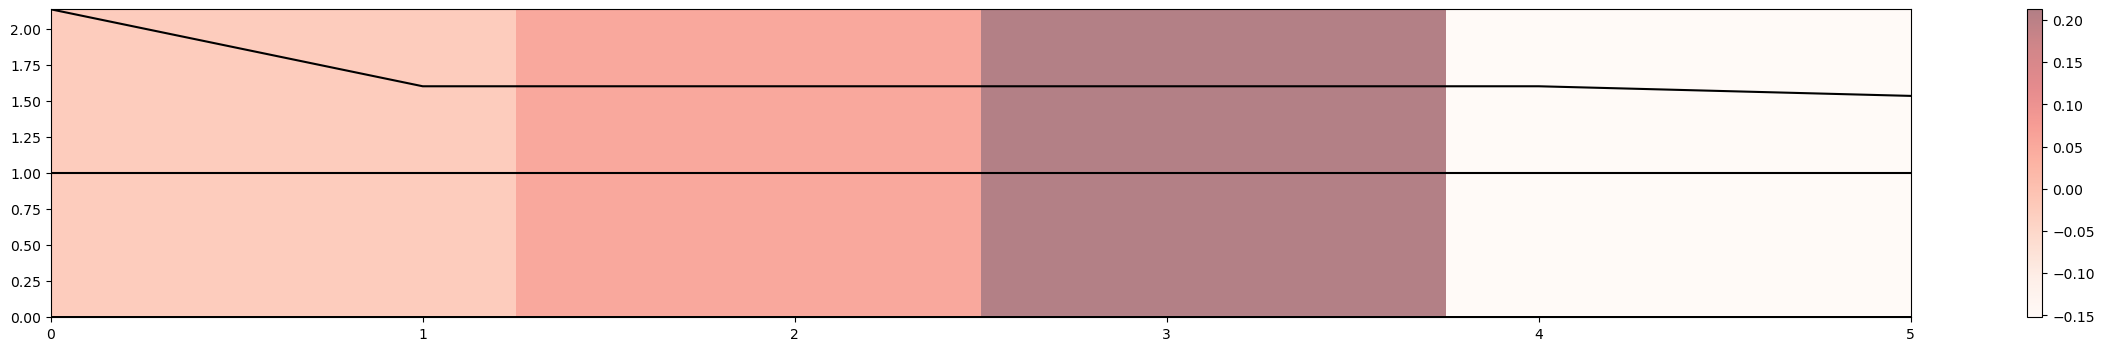

16
1/1 [==============================] - 0s 11ms/step
Model prediction = (1.6881667375564575), True Value = [1.4]


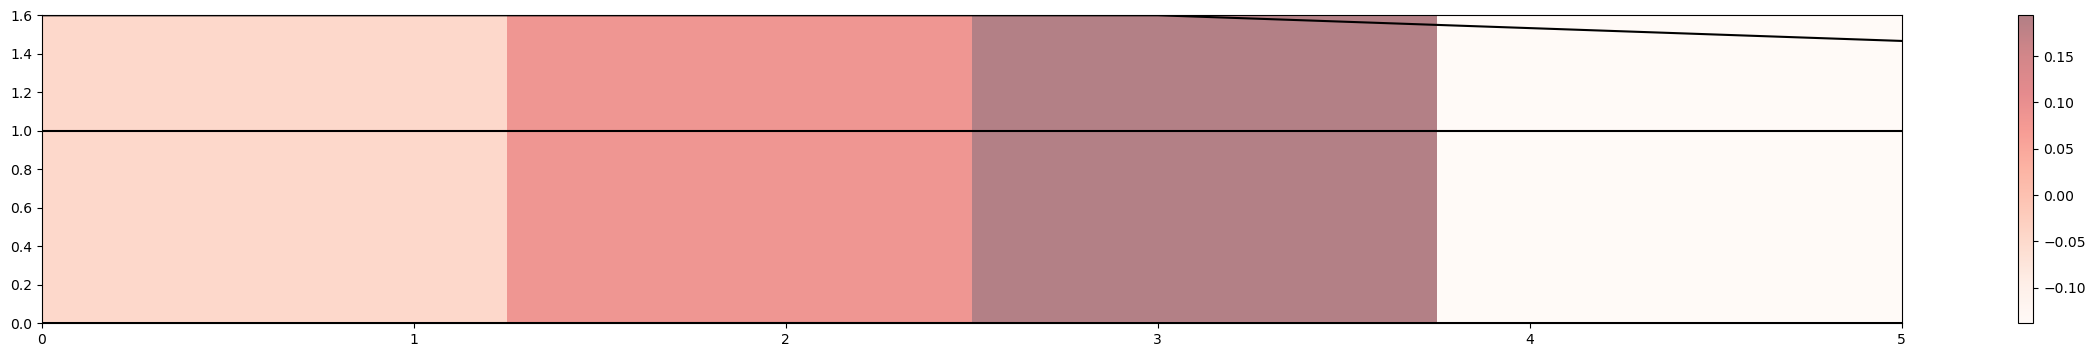

17
1/1 [==============================] - 0s 10ms/step
Model prediction = (1.6624914407730103), True Value = [1.23333333]


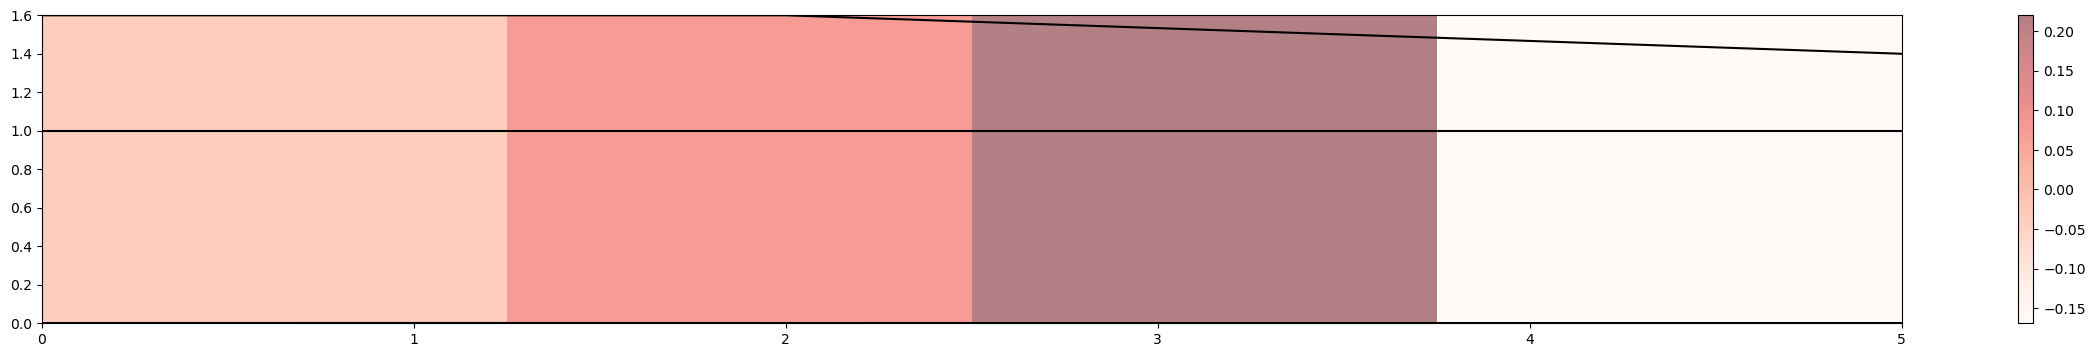

18
1/1 [==============================] - 0s 12ms/step
Model prediction = (1.4422035217285156), True Value = [1.06666667]


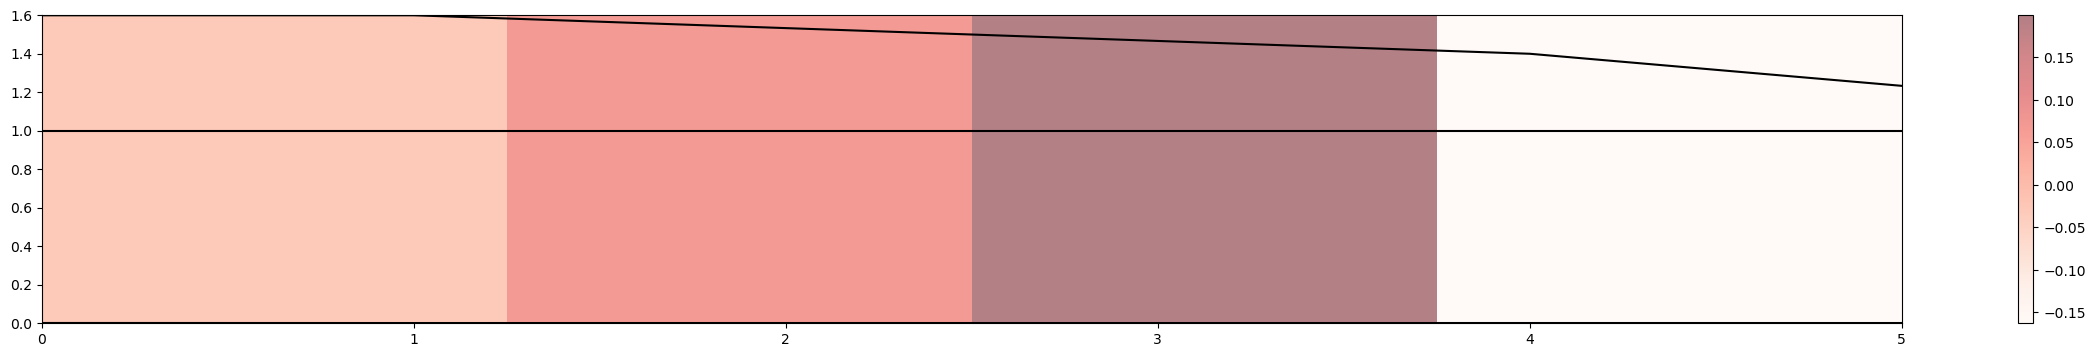

19
1/1 [==============================] - 0s 13ms/step
Model prediction = (1.2570372819900513), True Value = [0.9]


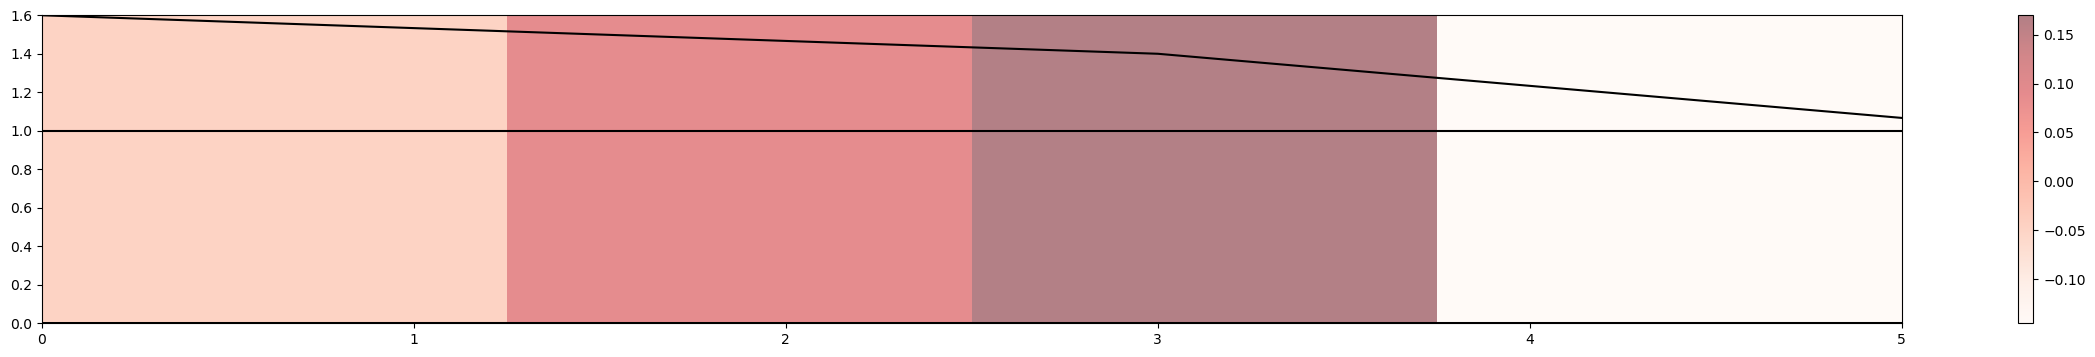

20
1/1 [==============================] - 0s 12ms/step
Model prediction = (1.1899491548538208), True Value = [1.06666667]


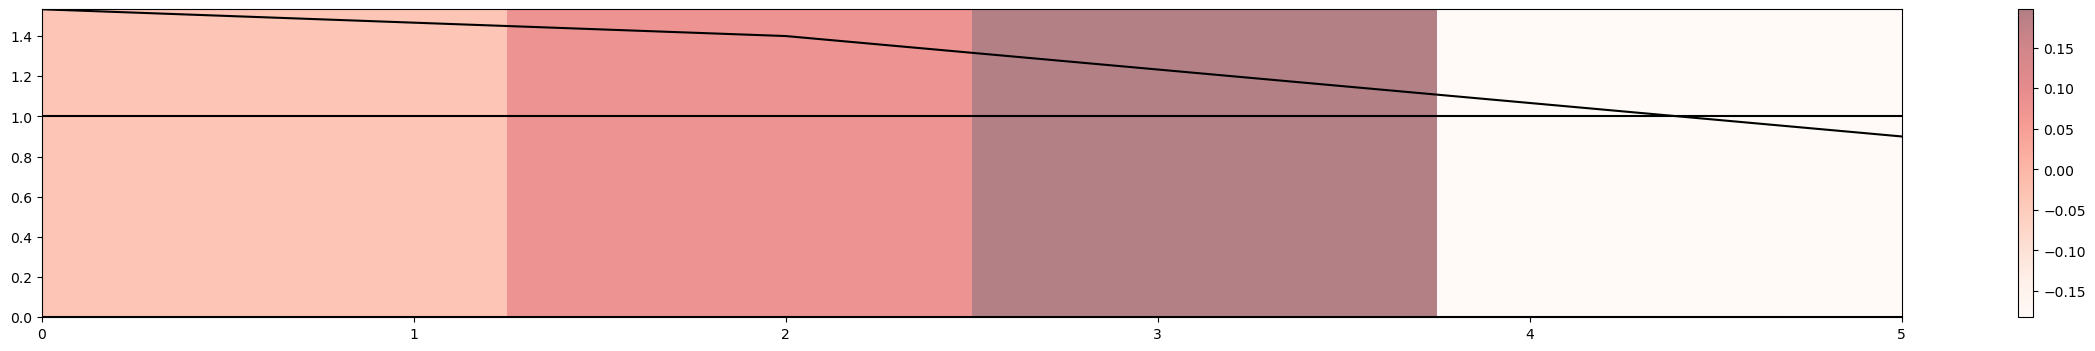

21
1/1 [==============================] - 0s 23ms/step
Model prediction = (1.482327938079834), True Value = [1.23333333]


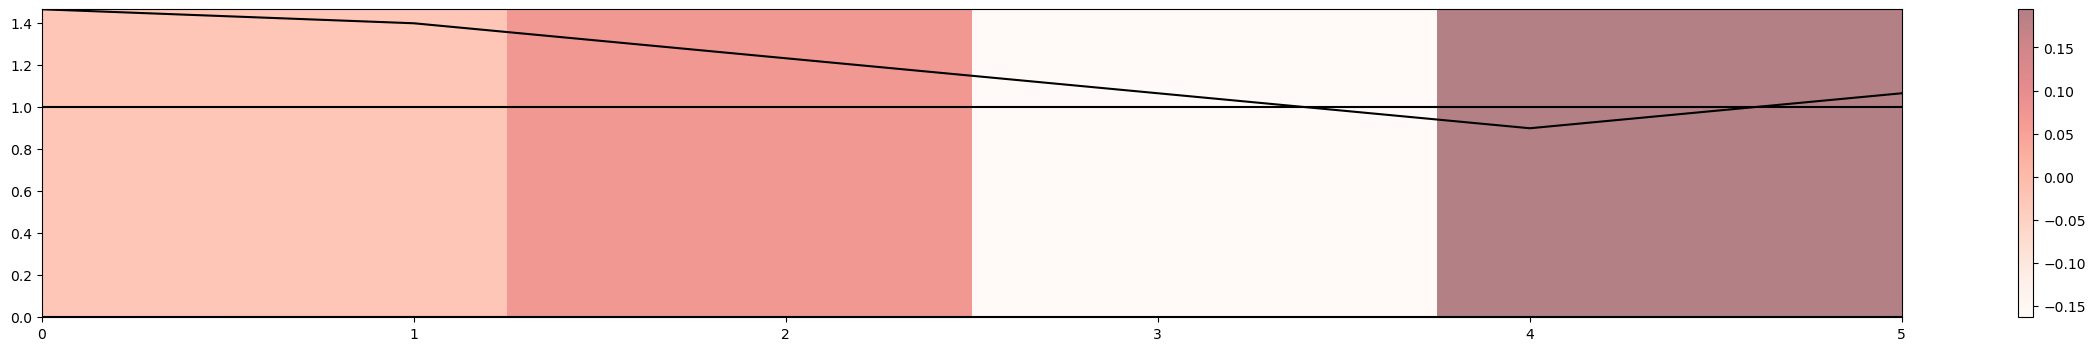

22
1/1 [==============================] - 0s 110ms/step
Model prediction = (1.8053278923034668), True Value = [1.4]


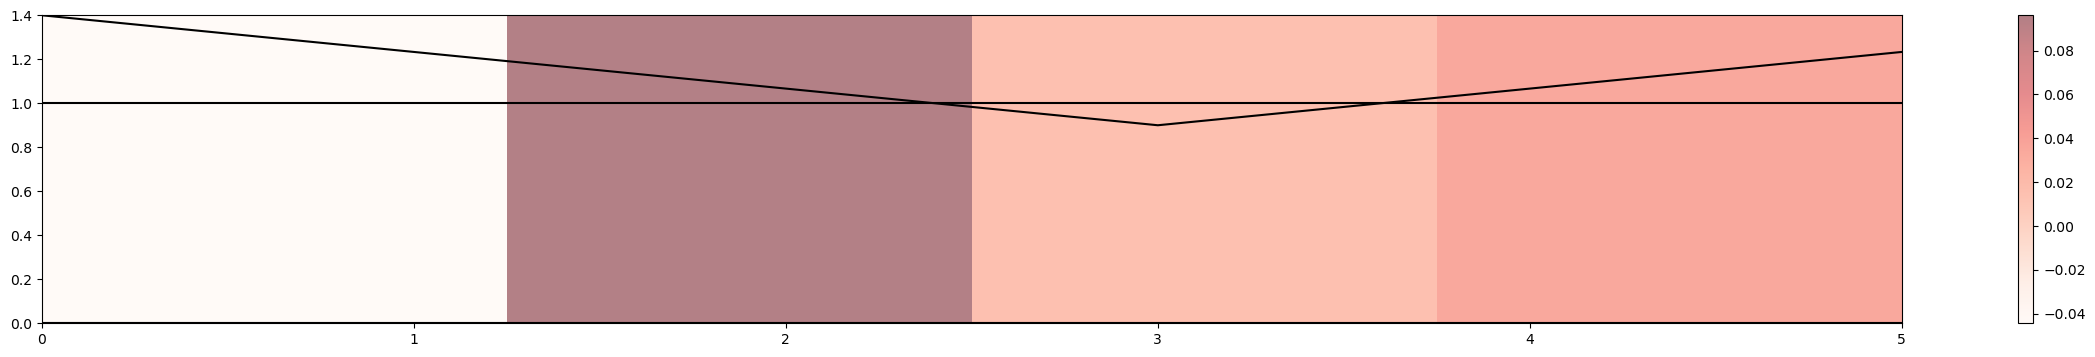

23
1/1 [==============================] - 0s 10ms/step
Model prediction = (1.768607258796692), True Value = [1.36666667]


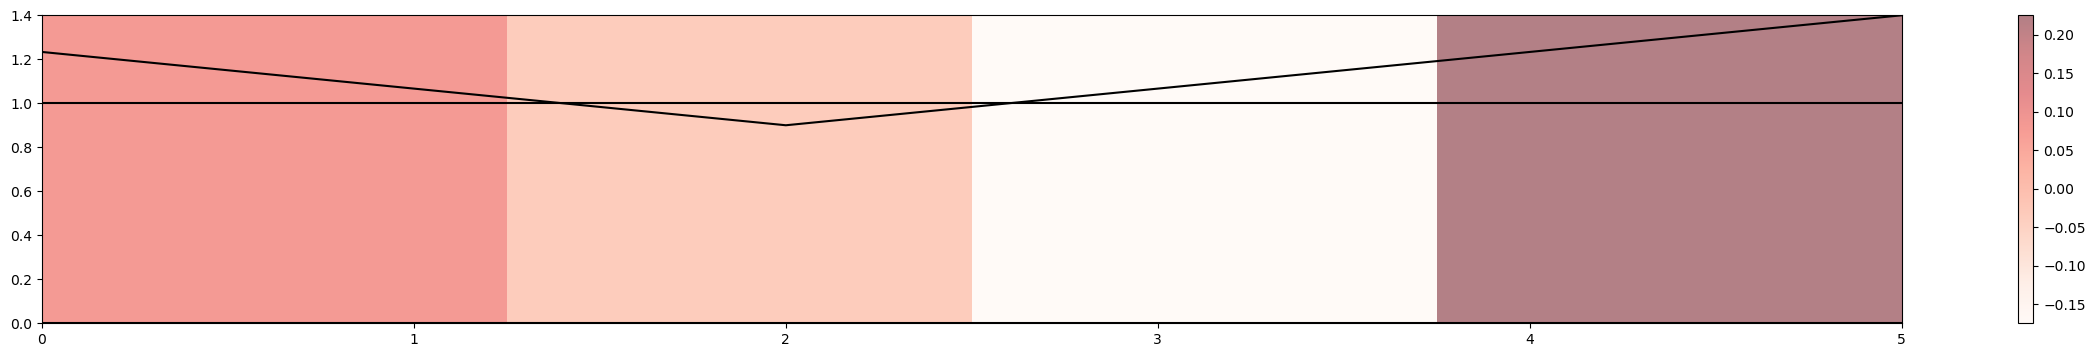

24
1/1 [==============================] - 0s 12ms/step
Model prediction = (1.665494441986084), True Value = [1.33333333]


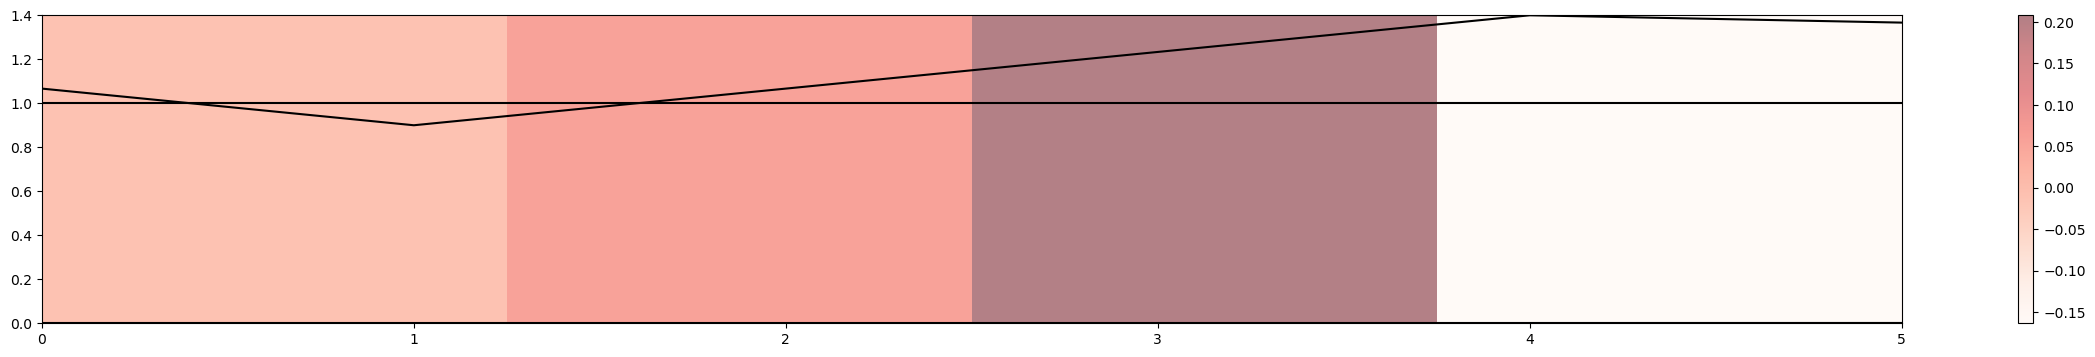

25
1/1 [==============================] - 0s 11ms/step
Model prediction = (1.6051439046859741), True Value = [1.3]


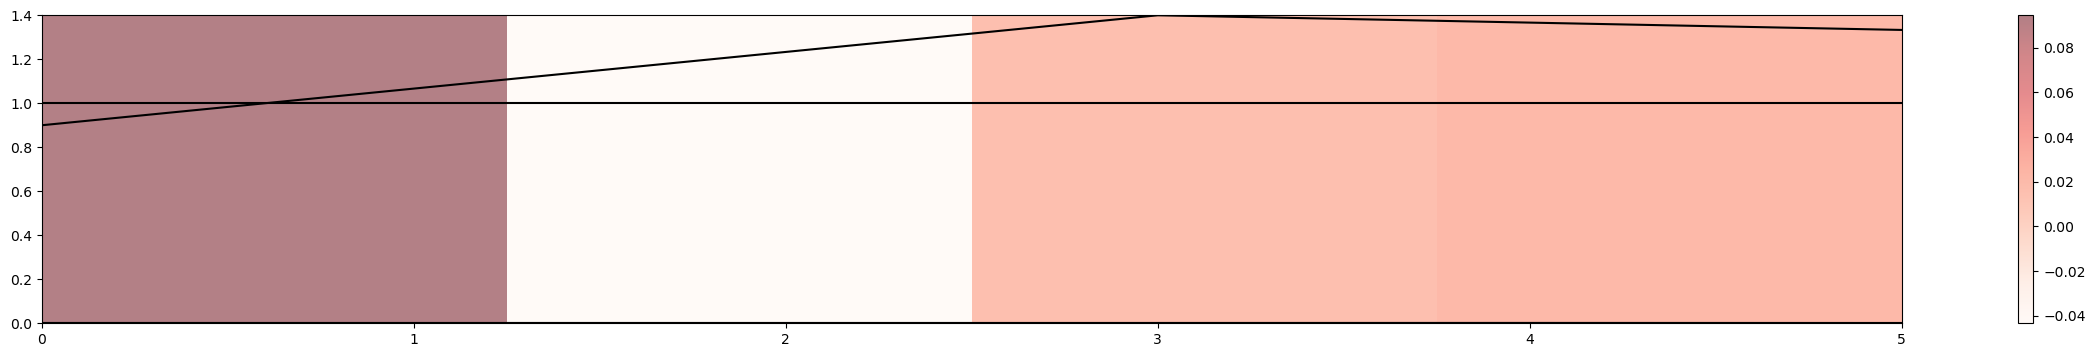

26
1/1 [==============================] - 0s 11ms/step
Model prediction = (1.6882011890411377), True Value = [-3.1]


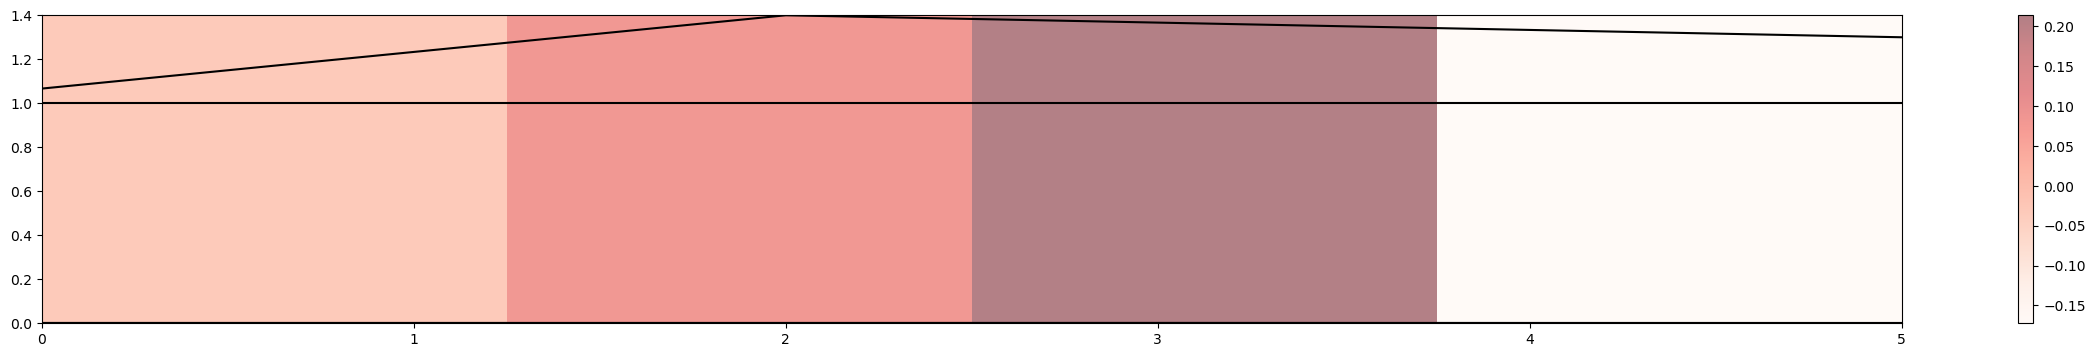

27
1/1 [==============================] - 0s 13ms/step
Model prediction = (-4.244691371917725), True Value = [-7.5]


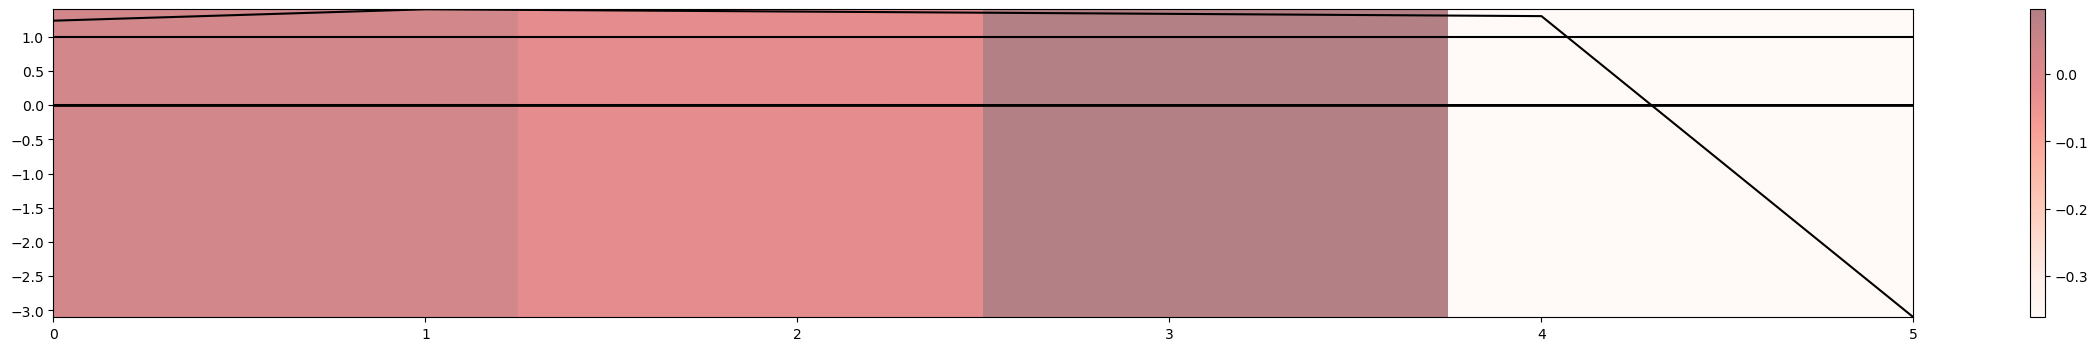

28
1/1 [==============================] - 0s 12ms/step
Model prediction = (-7.277329444885254), True Value = [-11.9]


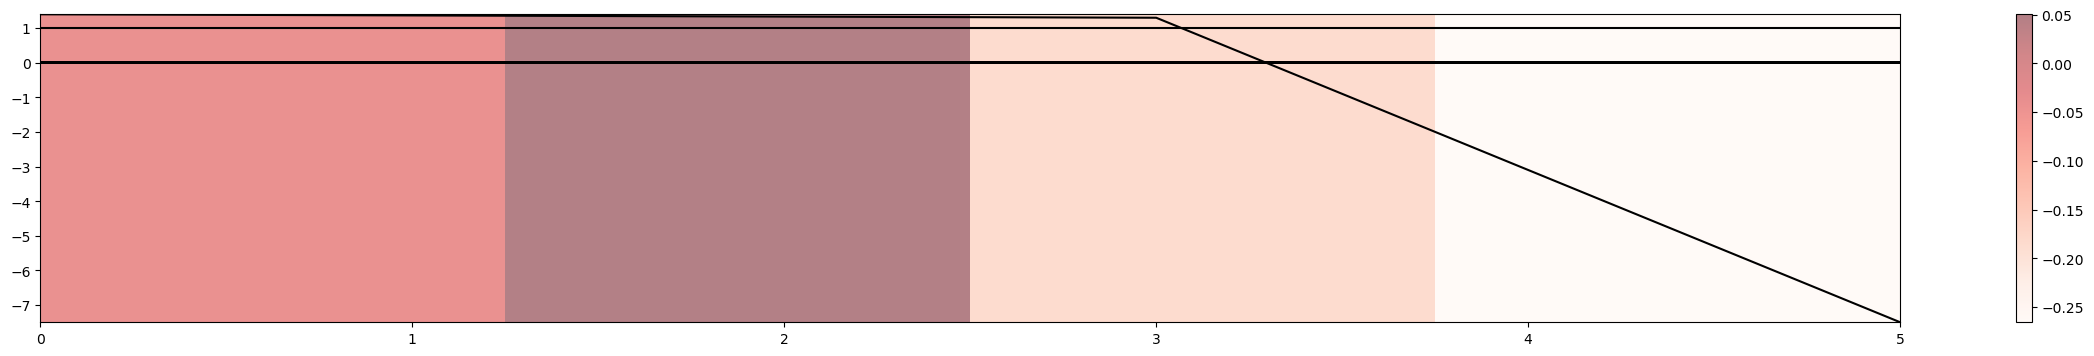

29
1/1 [==============================] - 0s 19ms/step
Model prediction = (-7.147454261779785), True Value = [-9.36666667]


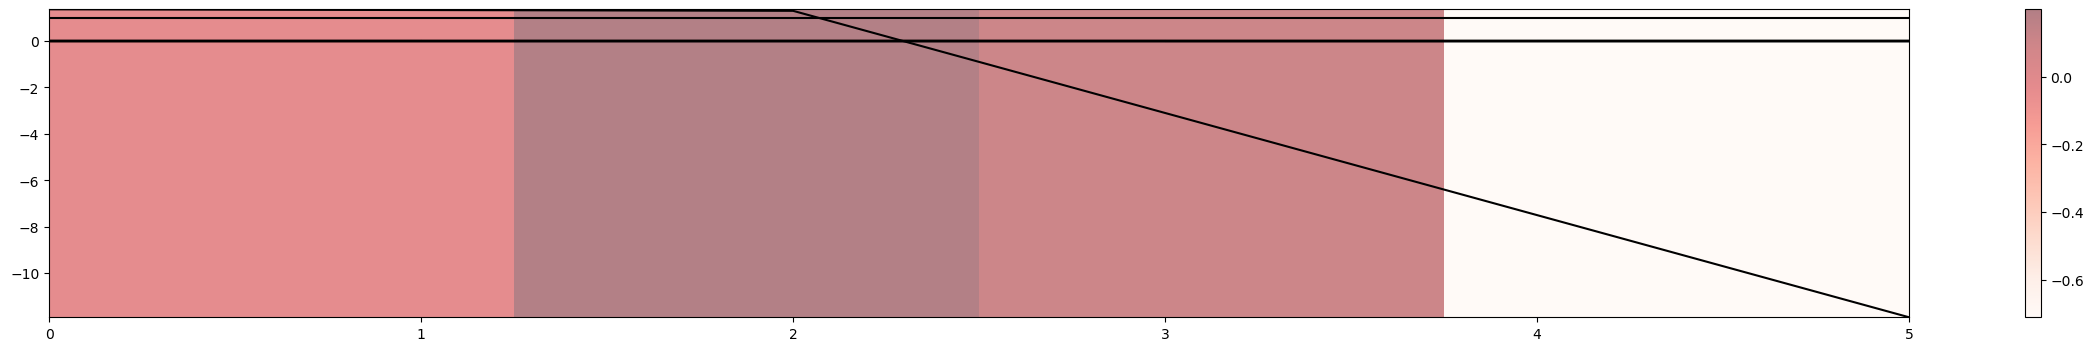

30
1/1 [==============================] - 0s 11ms/step
Model prediction = (-7.3780837059021), True Value = [-6.83333333]


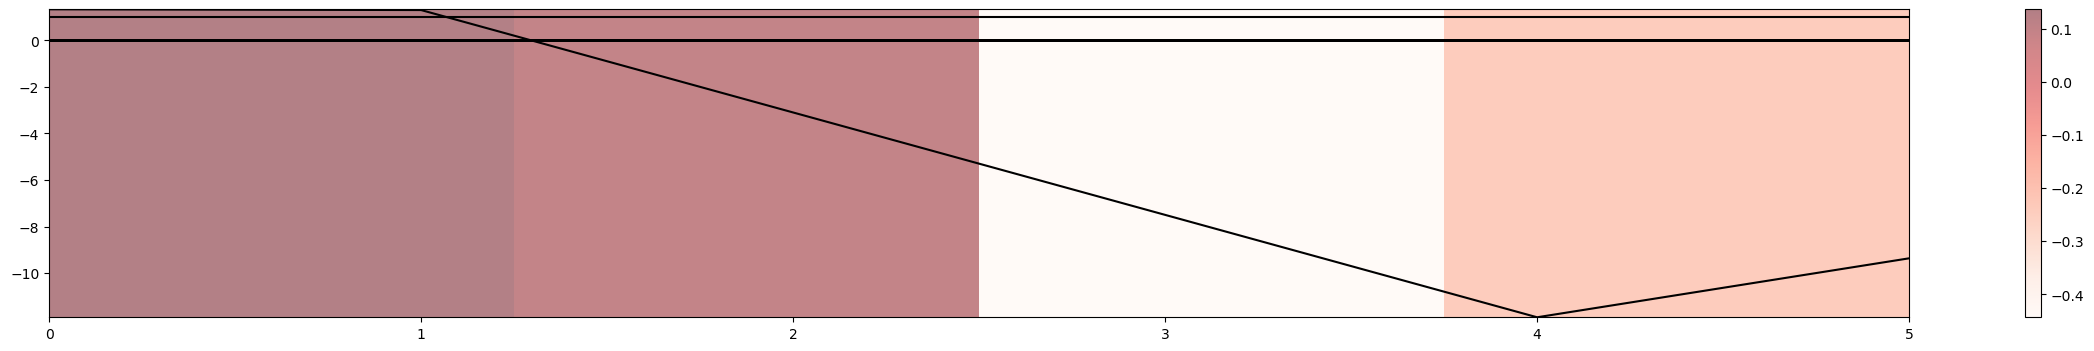

31
1/1 [==============================] - 0s 10ms/step
Model prediction = (-4.713075160980225), True Value = [-4.3]


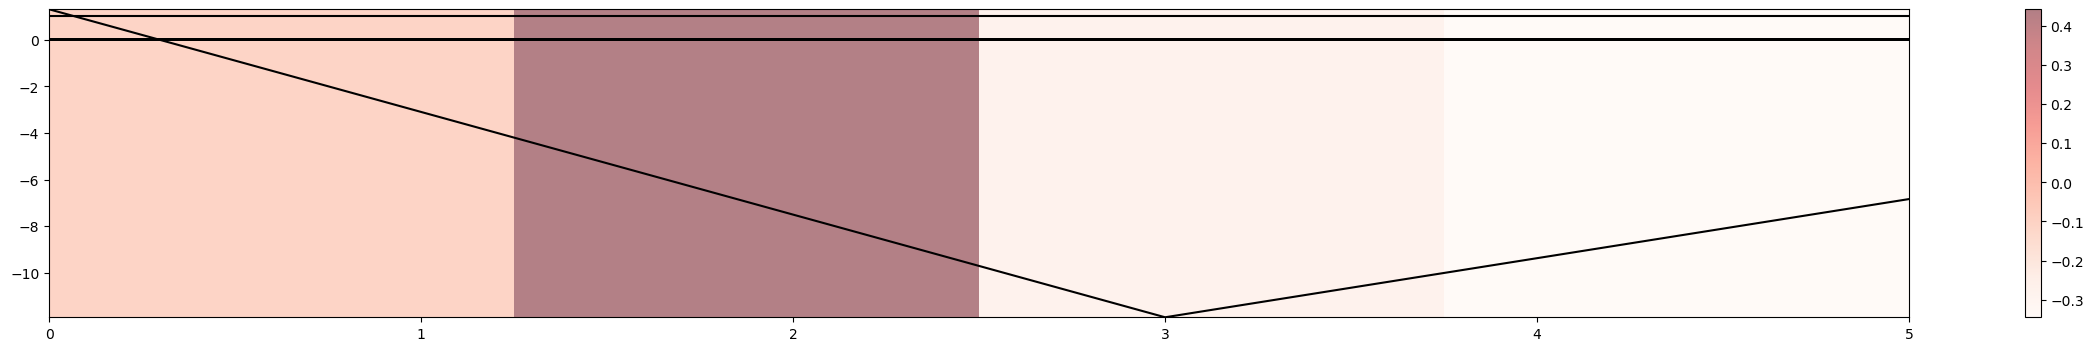

32
1/1 [==============================] - 0s 10ms/step
Model prediction = (-2.161052942276001), True Value = [-3.06666667]


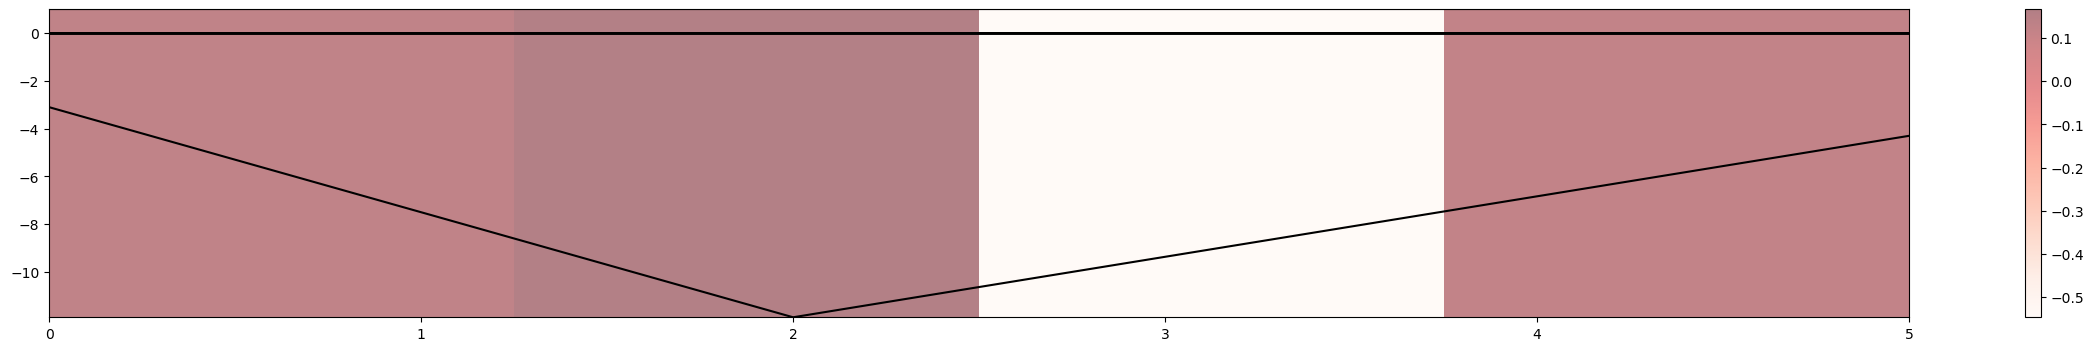

33
1/1 [==============================] - 0s 11ms/step
Model prediction = (0.31187522411346436), True Value = [-1.83333333]


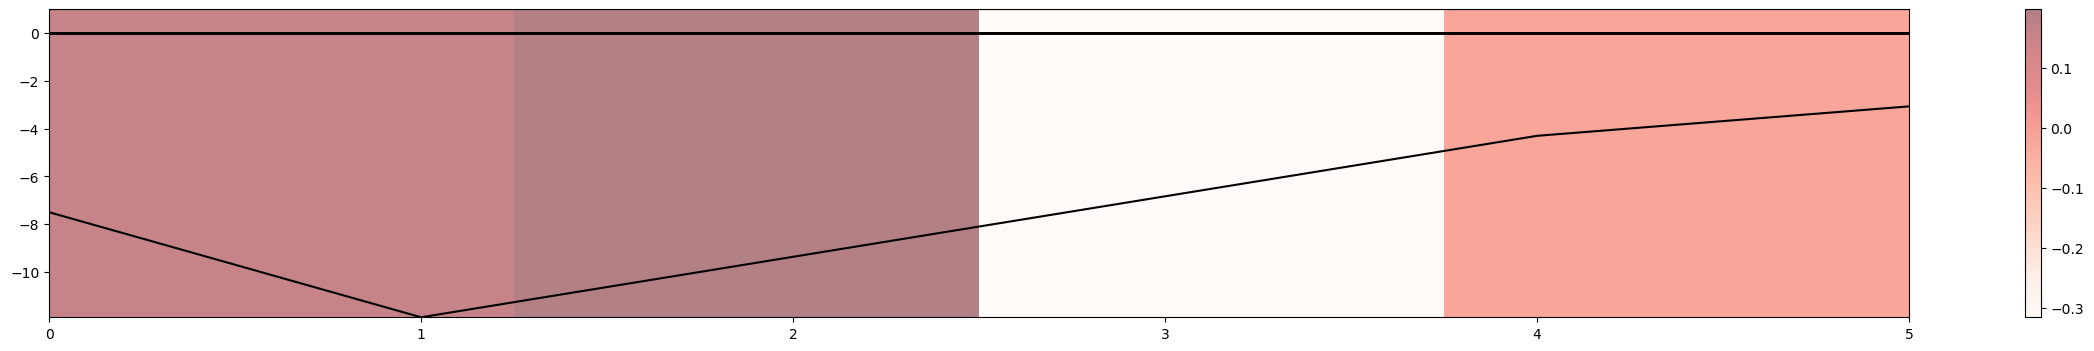

34
1/1 [==============================] - 0s 10ms/step
Model prediction = (0.7359280586242676), True Value = [-0.6]


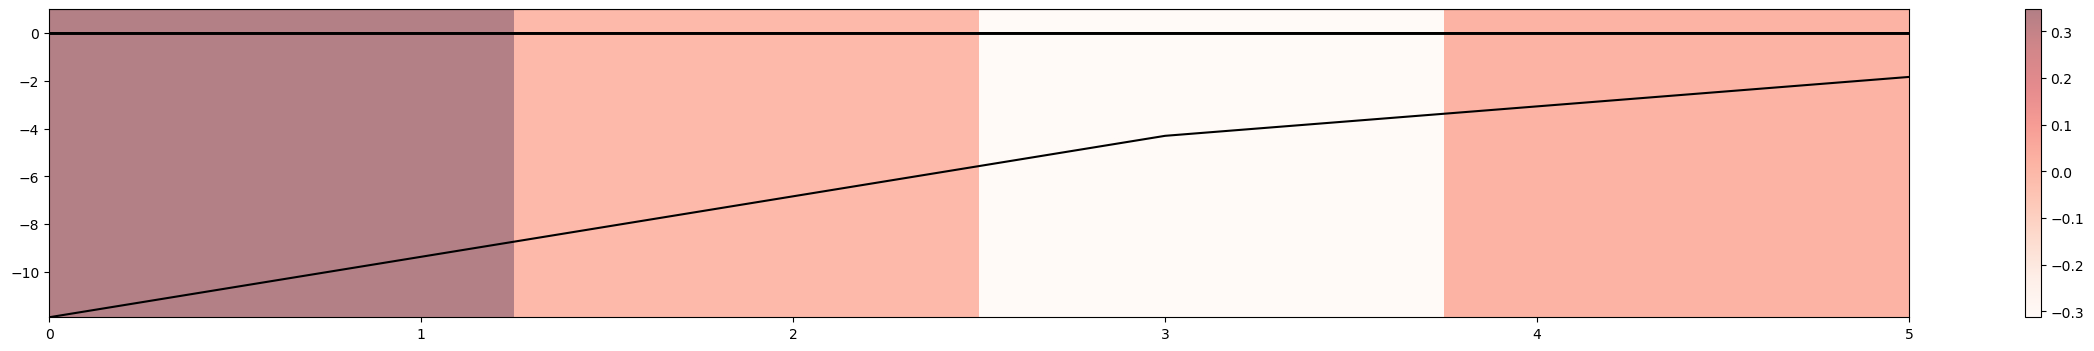

35
1/1 [==============================] - 0s 15ms/step
Model prediction = (1.9697701930999756), True Value = [0.9]


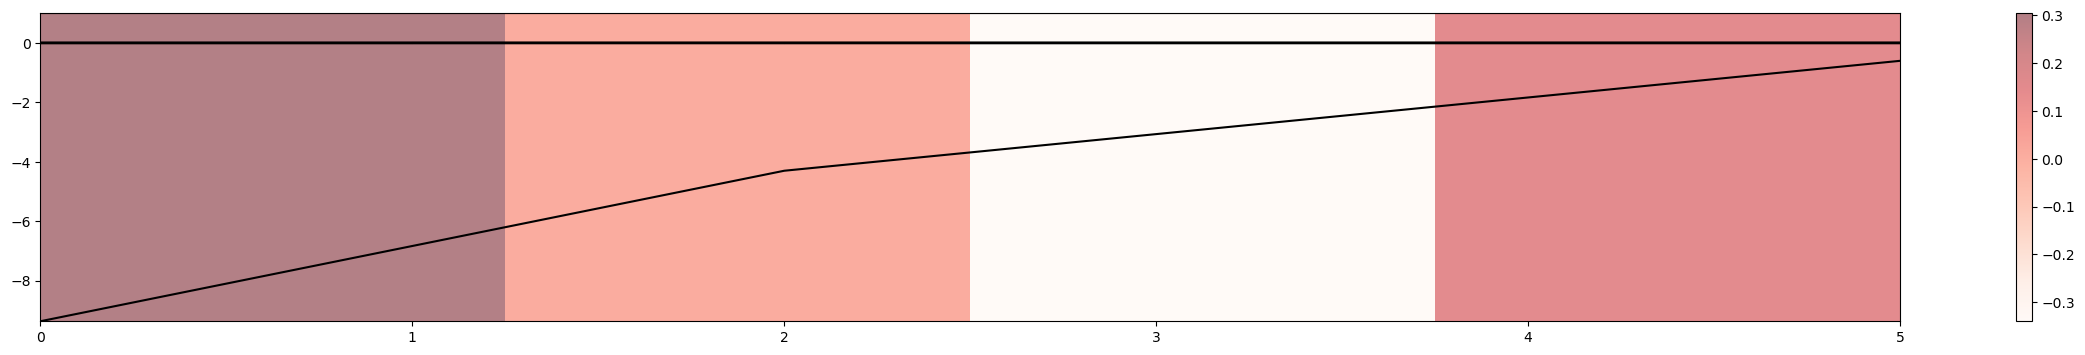

36
1/1 [==============================] - 0s 11ms/step
Model prediction = (3.301077127456665), True Value = [2.4]


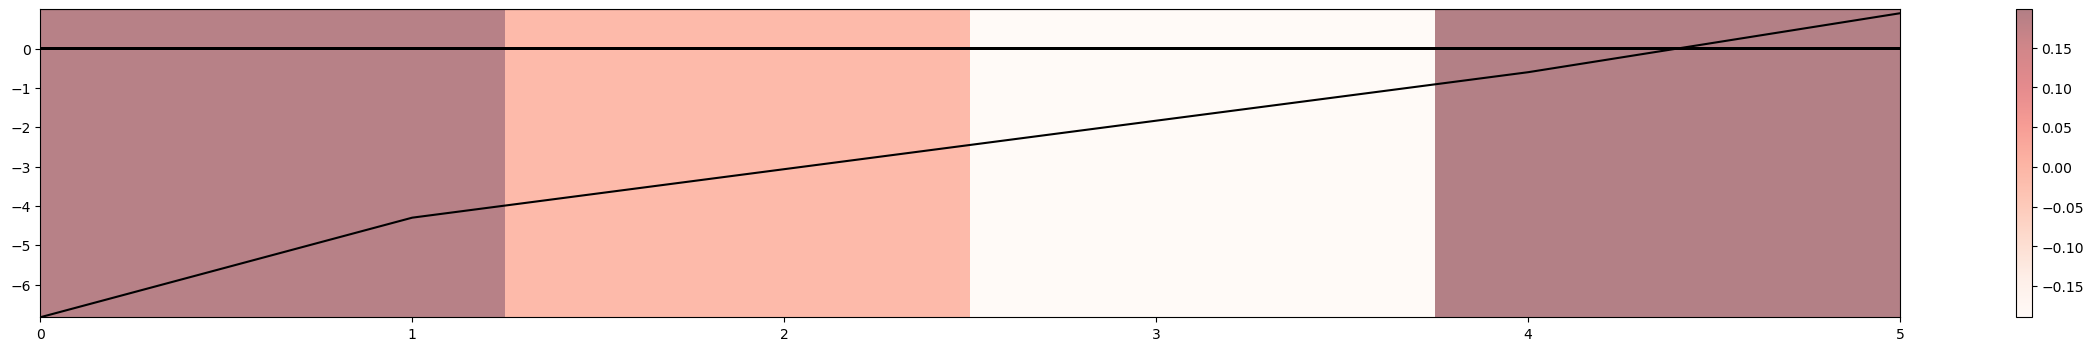

37
1/1 [==============================] - 0s 37ms/step
Model prediction = (3.7646608352661133), True Value = [3.9]


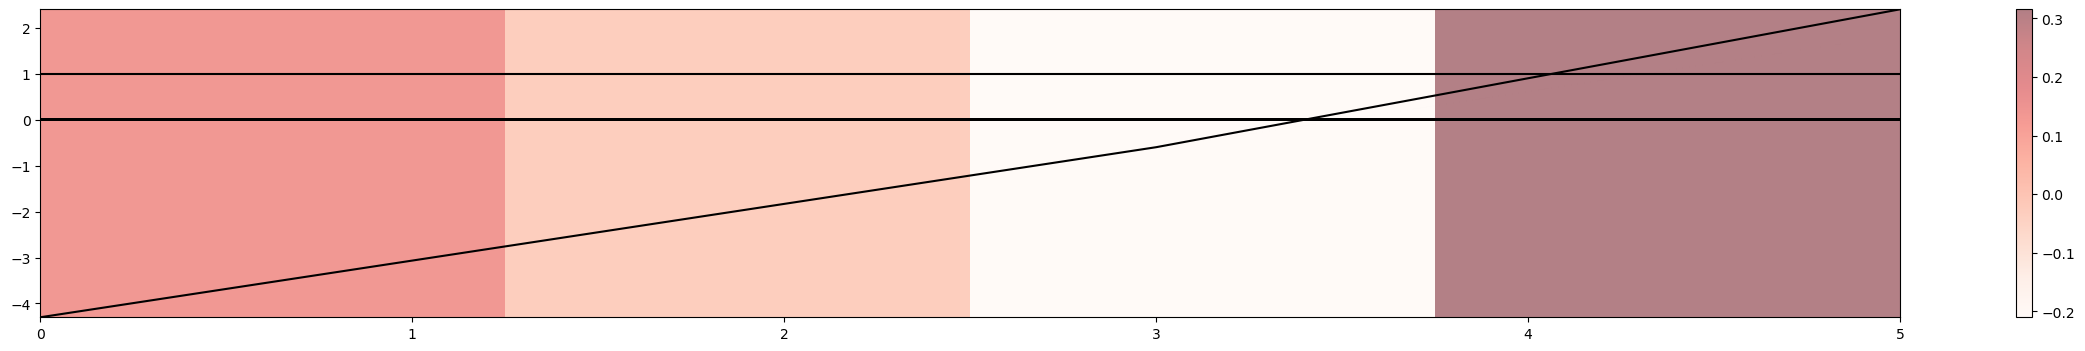

38
1/1 [==============================] - 0s 10ms/step
Model prediction = (4.923012733459473), True Value = [8.36666667]


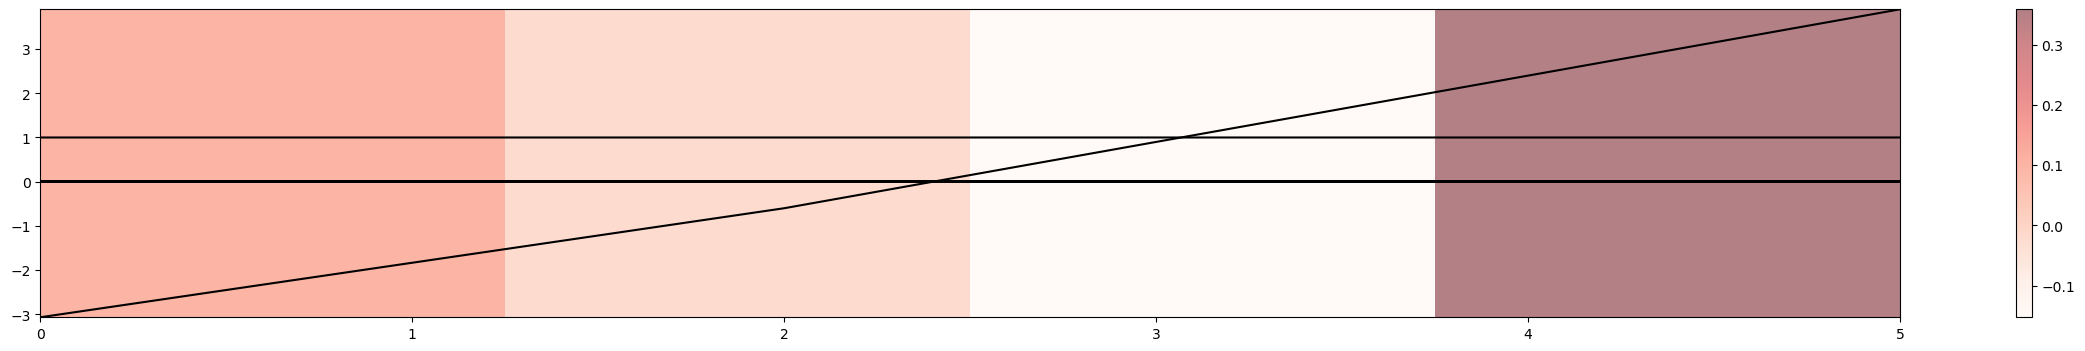

39
1/1 [==============================] - 0s 12ms/step
Model prediction = (10.432215690612793), True Value = [12.83333333]


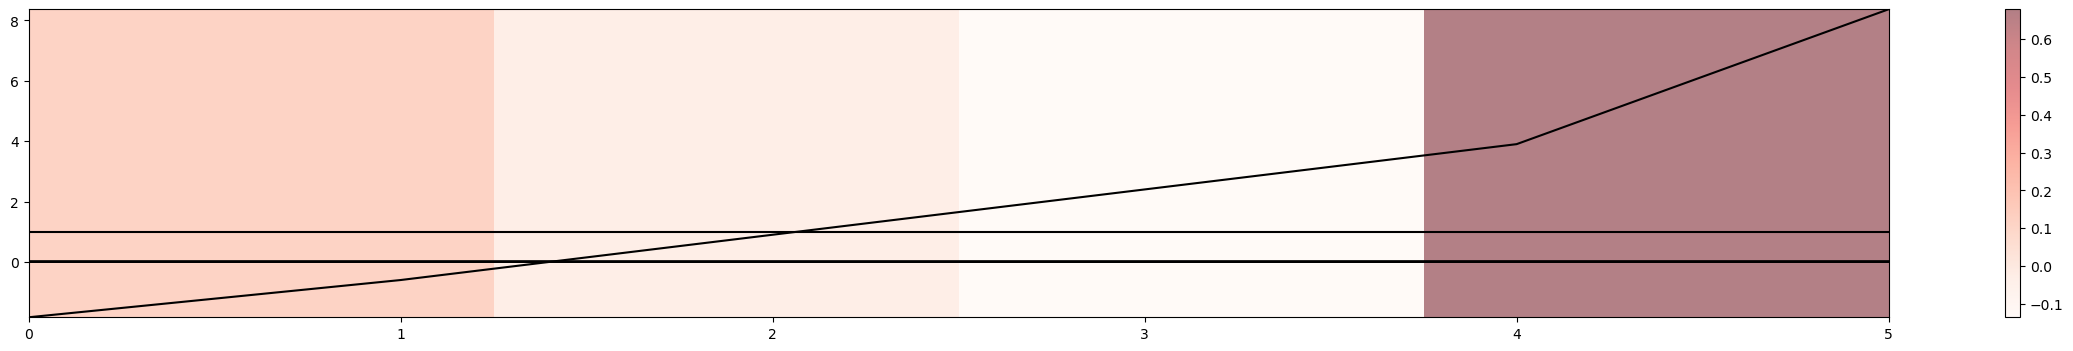

40
1/1 [==============================] - 0s 16ms/step
Model prediction = (16.39365577697754), True Value = [17.3]


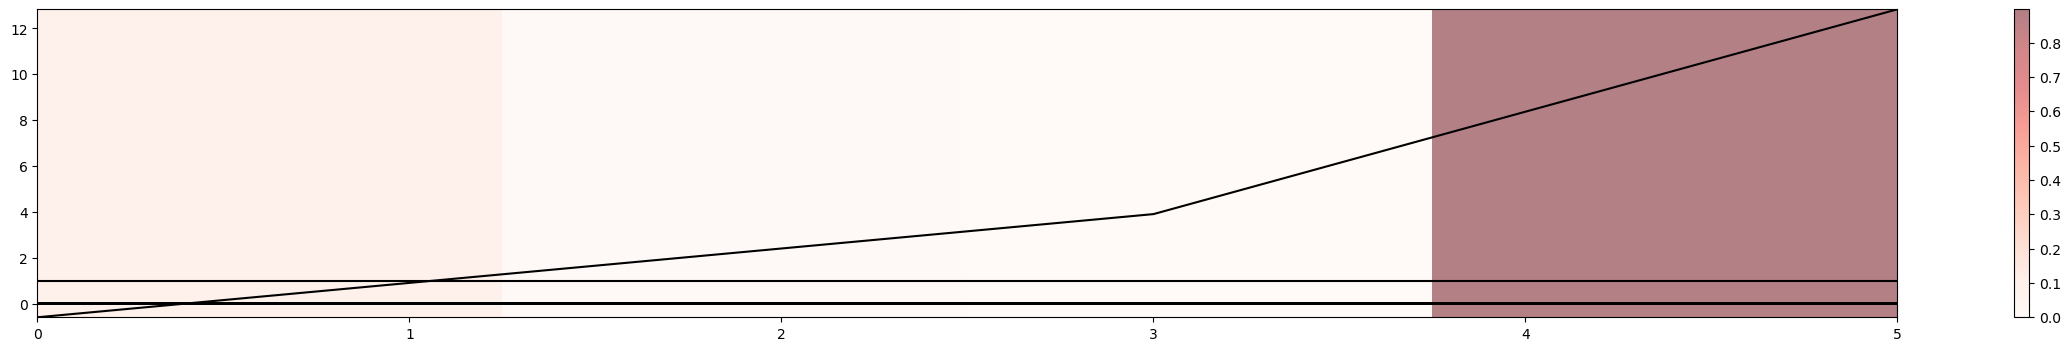

41
1/1 [==============================] - 0s 10ms/step
Model prediction = (19.424875259399414), True Value = [14.43333333]


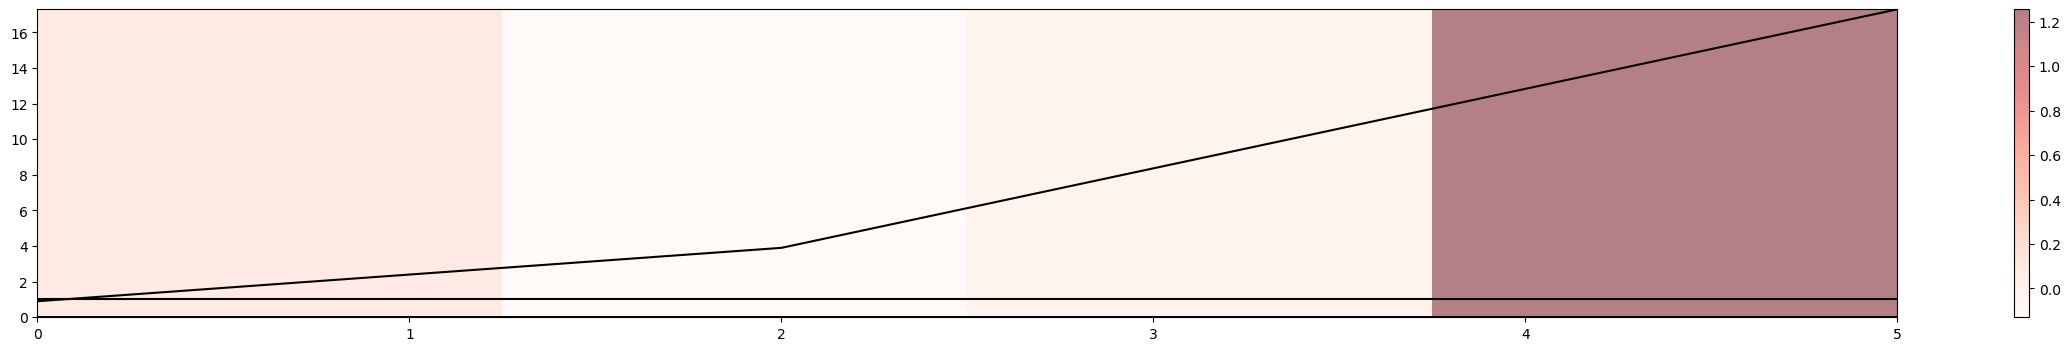

42
1/1 [==============================] - 0s 15ms/step
Model prediction = (14.304106712341309), True Value = [11.56666667]


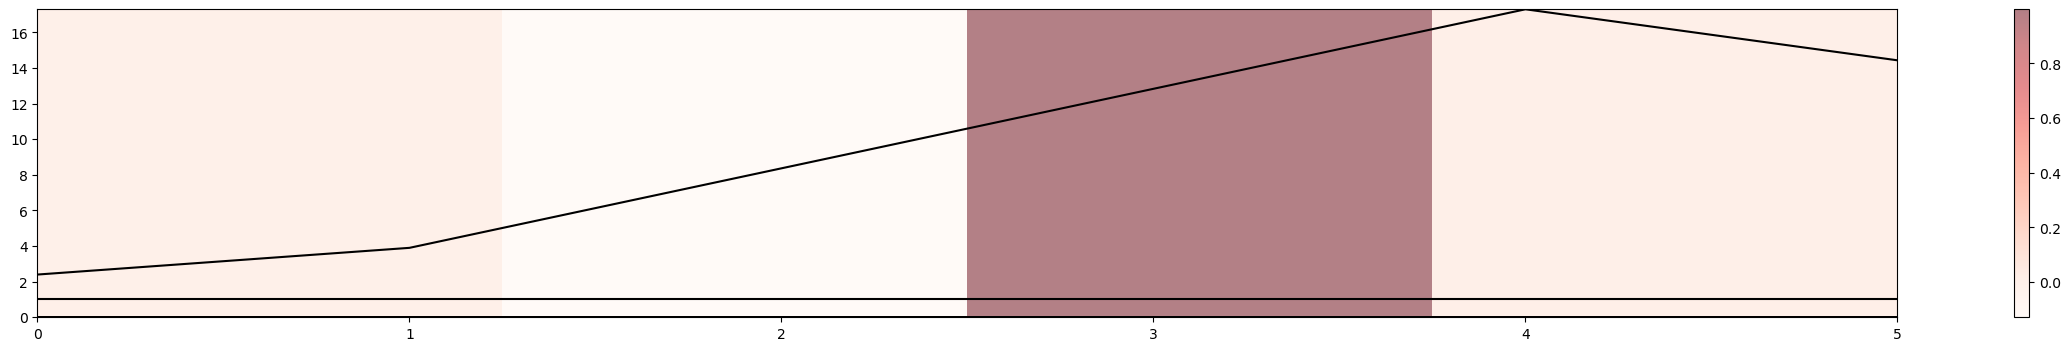

43
1/1 [==============================] - 0s 10ms/step
Model prediction = (8.492769241333008), True Value = [8.7]


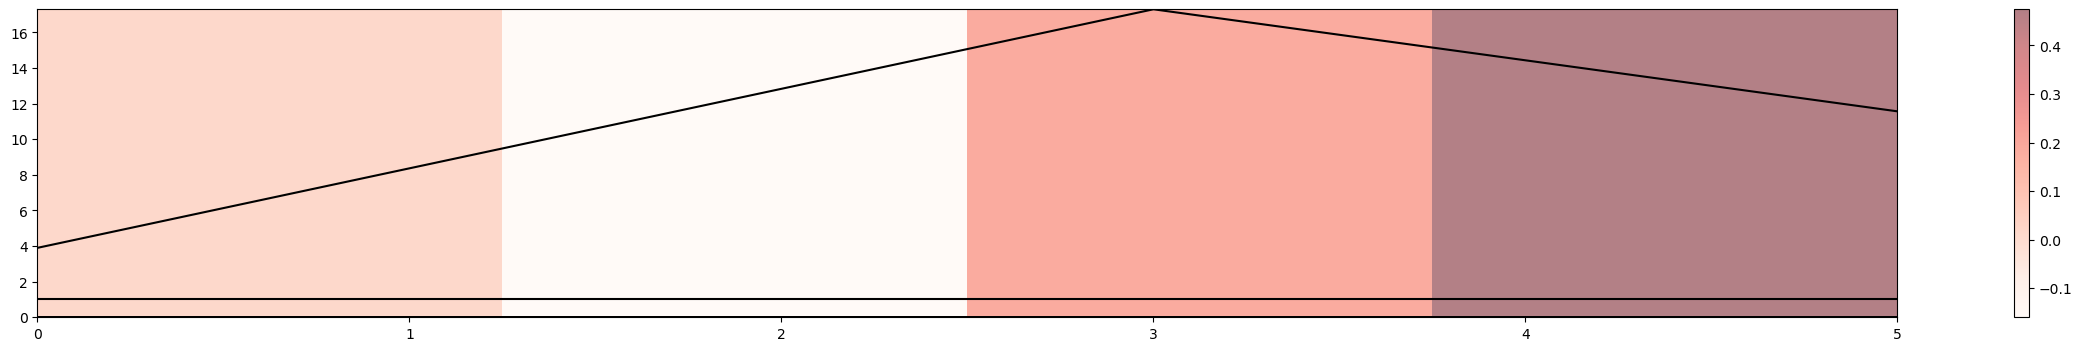

44
1/1 [==============================] - 0s 10ms/step
Model prediction = (9.555463790893555), True Value = [8.]


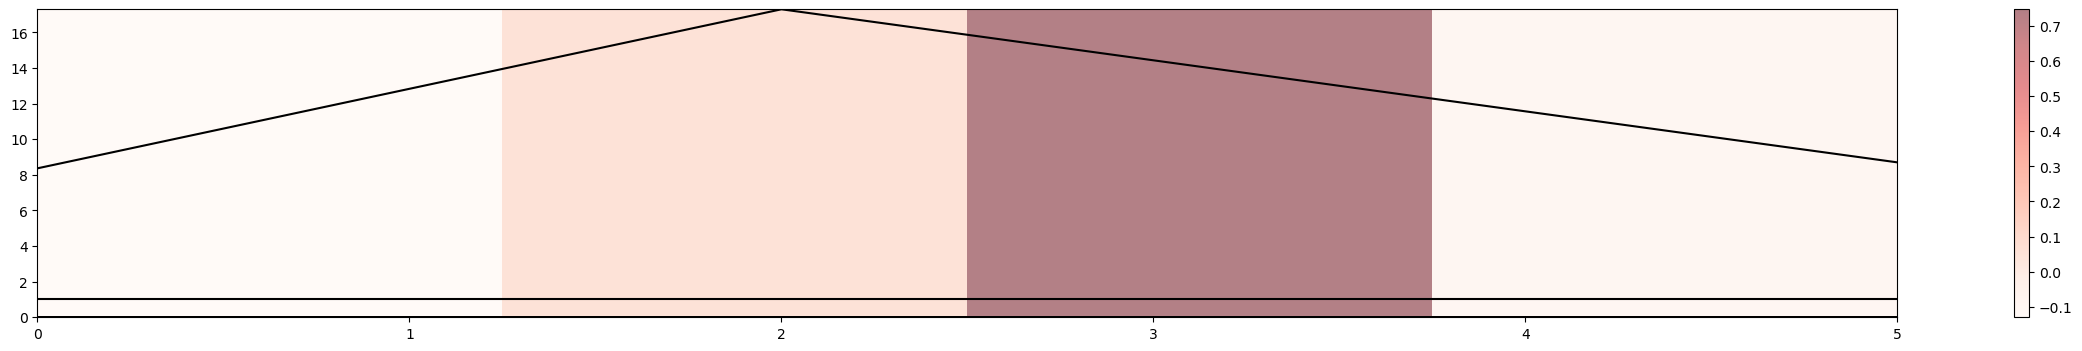

45
1/1 [==============================] - 0s 25ms/step
Model prediction = (8.798842430114746), True Value = [7.3]


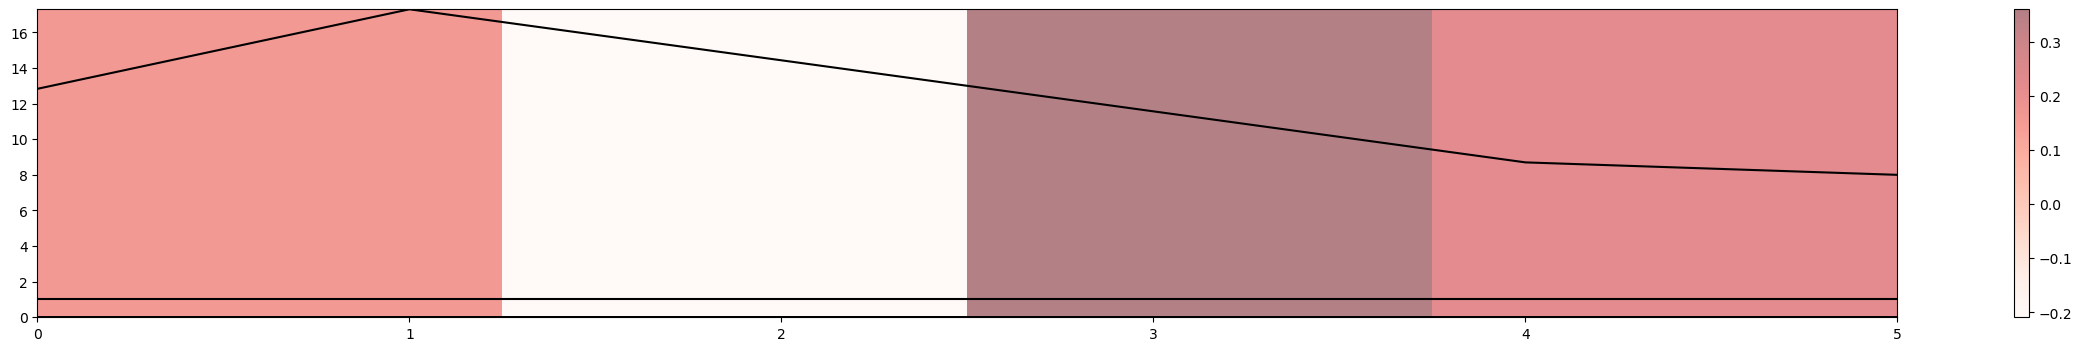

46
1/1 [==============================] - 0s 10ms/step
Model prediction = (7.294088840484619), True Value = [6.6]


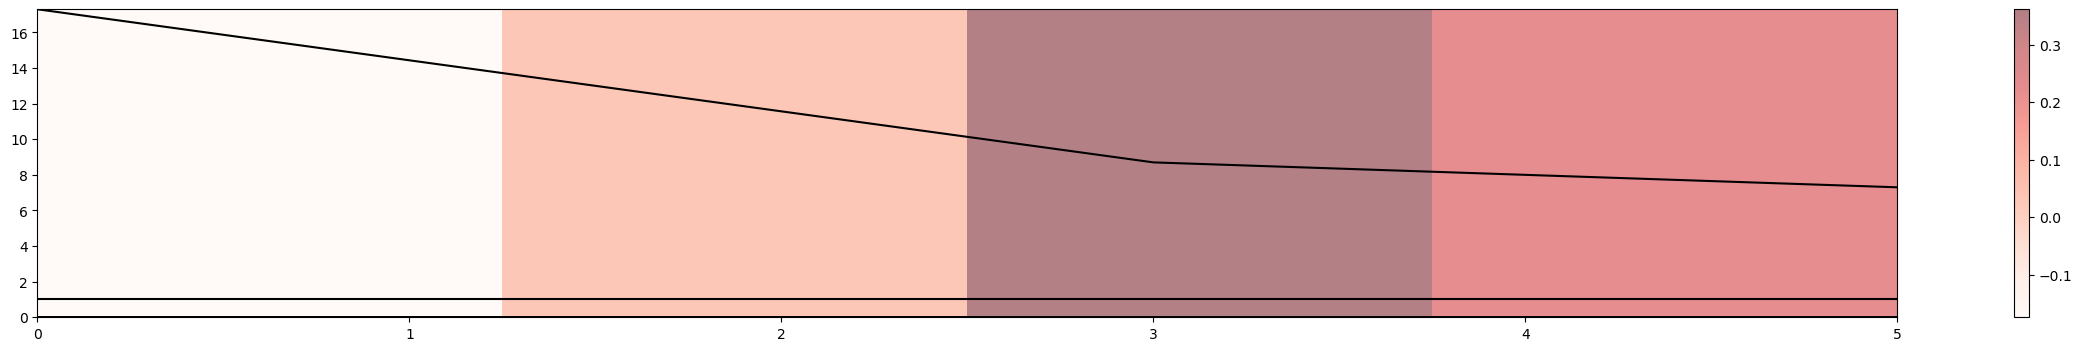

47
1/1 [==============================] - 0s 10ms/step
Model prediction = (5.383187294006348), True Value = [5.73333333]


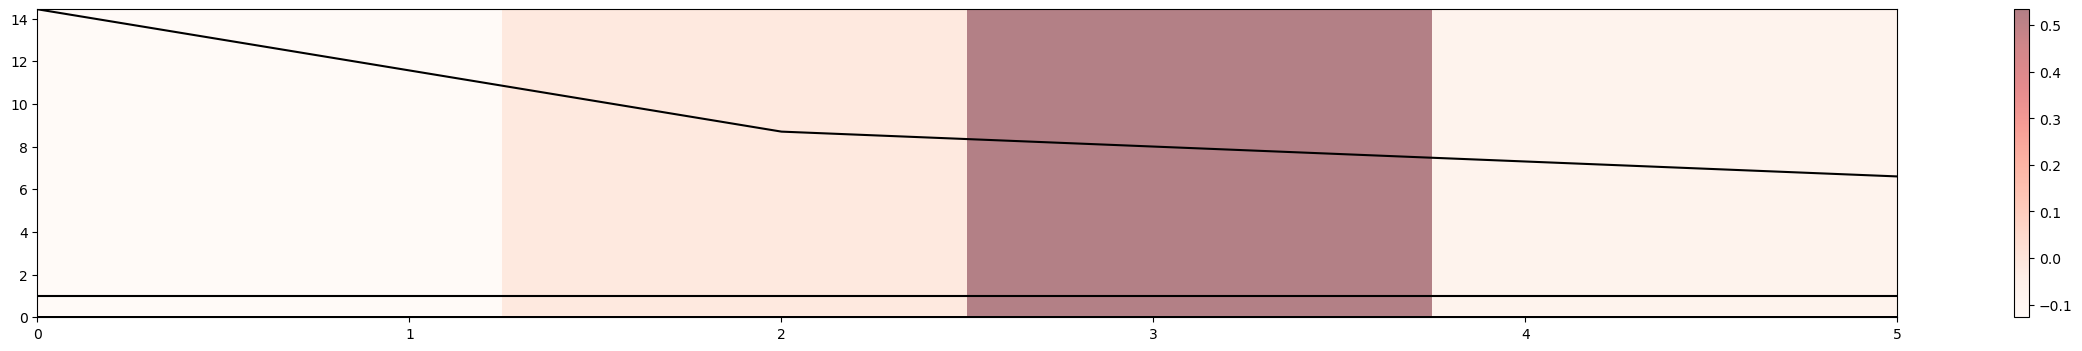

48
1/1 [==============================] - 0s 28ms/step
Model prediction = (4.408256530761719), True Value = [4.86666667]


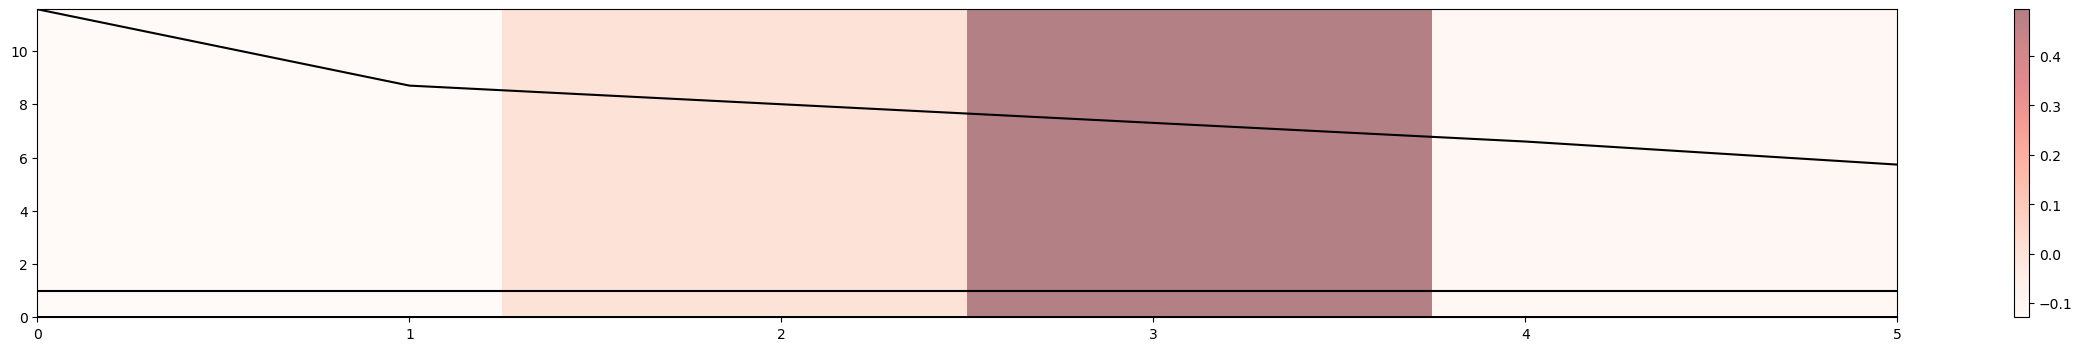

49
1/1 [==============================] - 0s 11ms/step
Model prediction = (4.14440393447876), True Value = [4.]


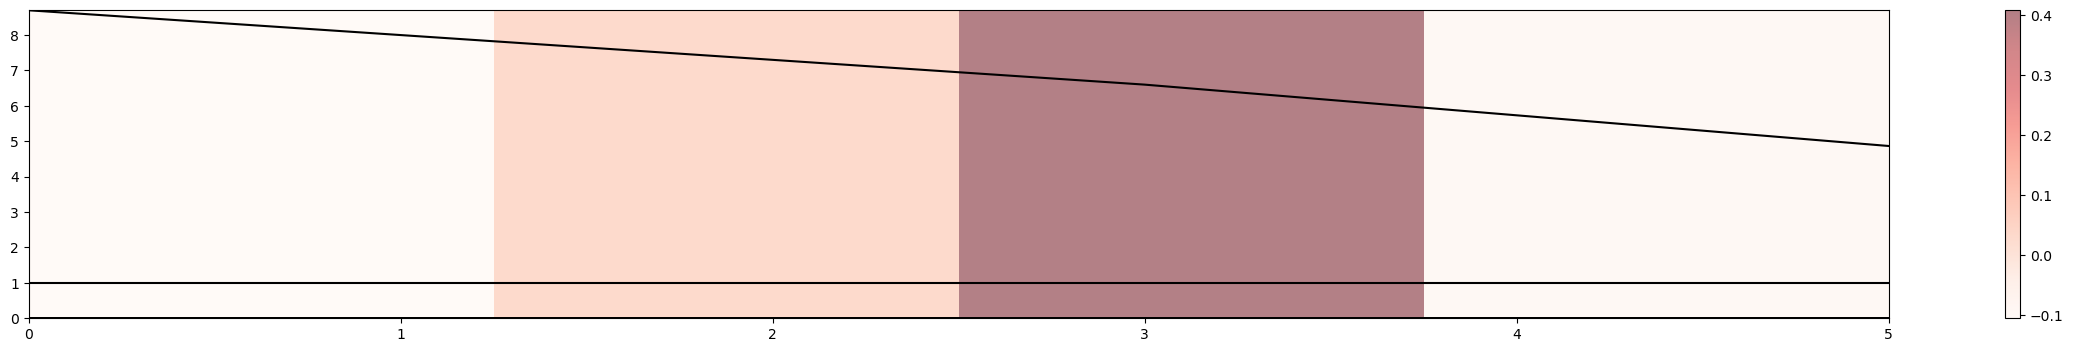

50
1/1 [==============================] - 0s 12ms/step
Model prediction = (3.463106632232666), True Value = [4.16666667]


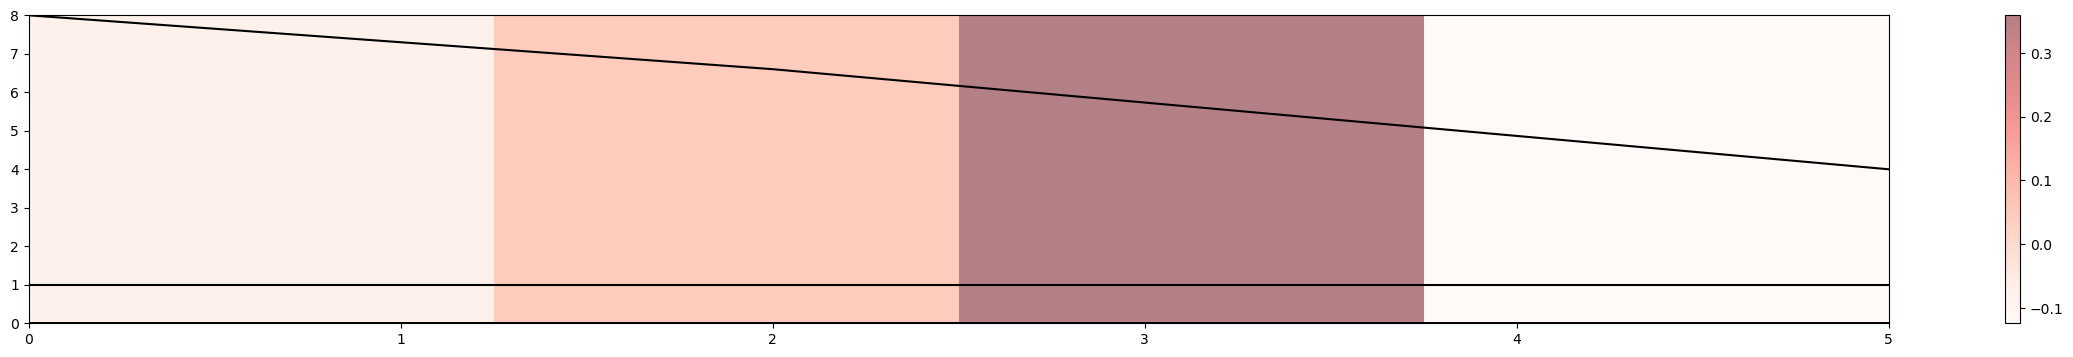

51
1/1 [==============================] - 0s 14ms/step
Model prediction = (4.065332889556885), True Value = [4.33333333]


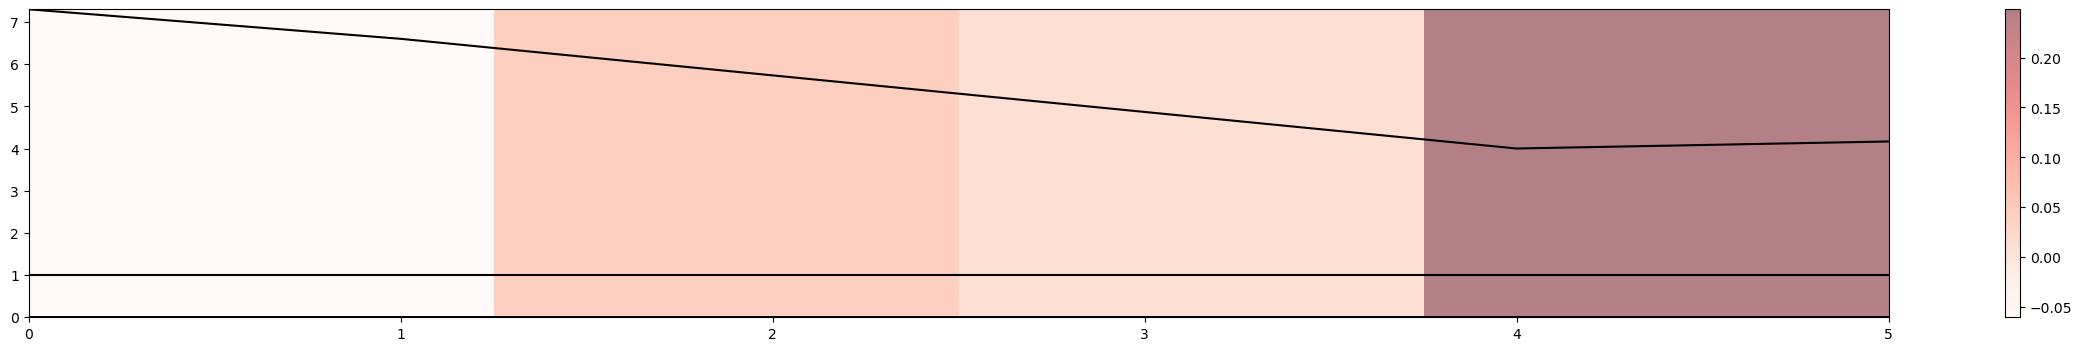

52
1/1 [==============================] - 0s 11ms/step
Model prediction = (4.847259998321533), True Value = [4.5]


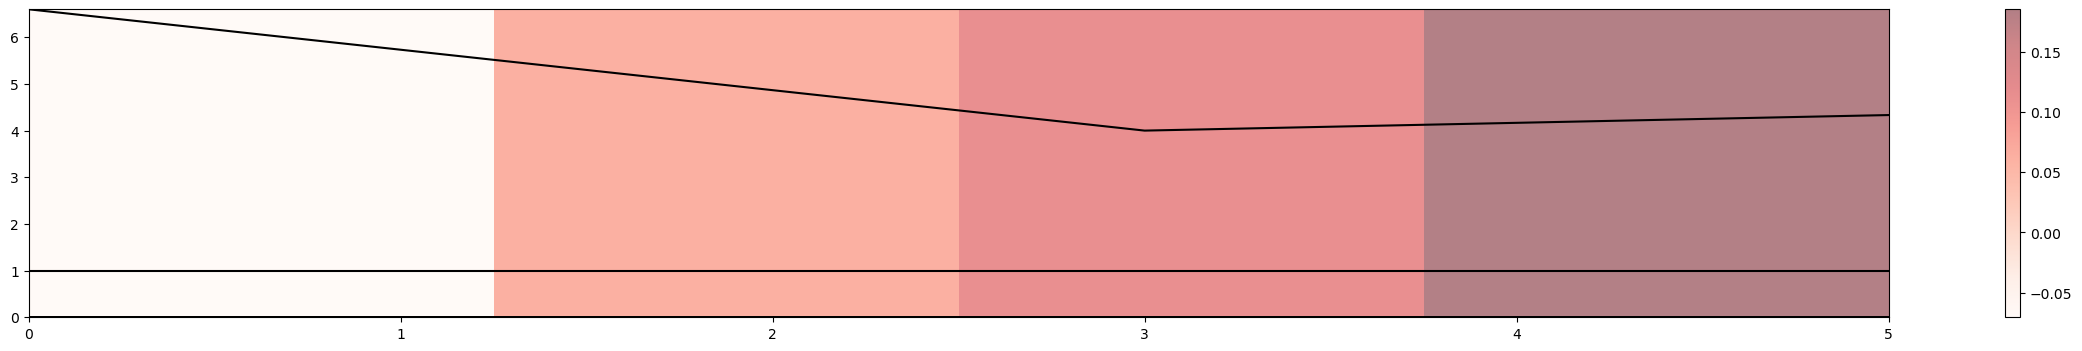

53
1/1 [==============================] - 0s 11ms/step
Model prediction = (4.296726703643799), True Value = [4.33333333]


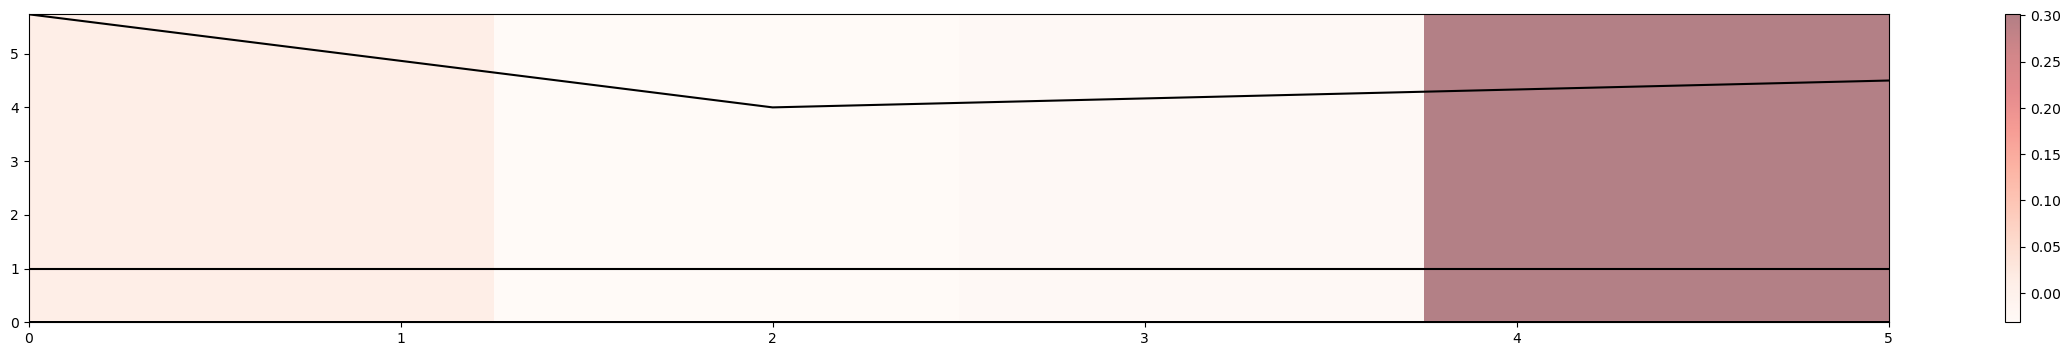

54
1/1 [==============================] - 0s 12ms/step
Model prediction = (3.990461826324463), True Value = [4.16666667]


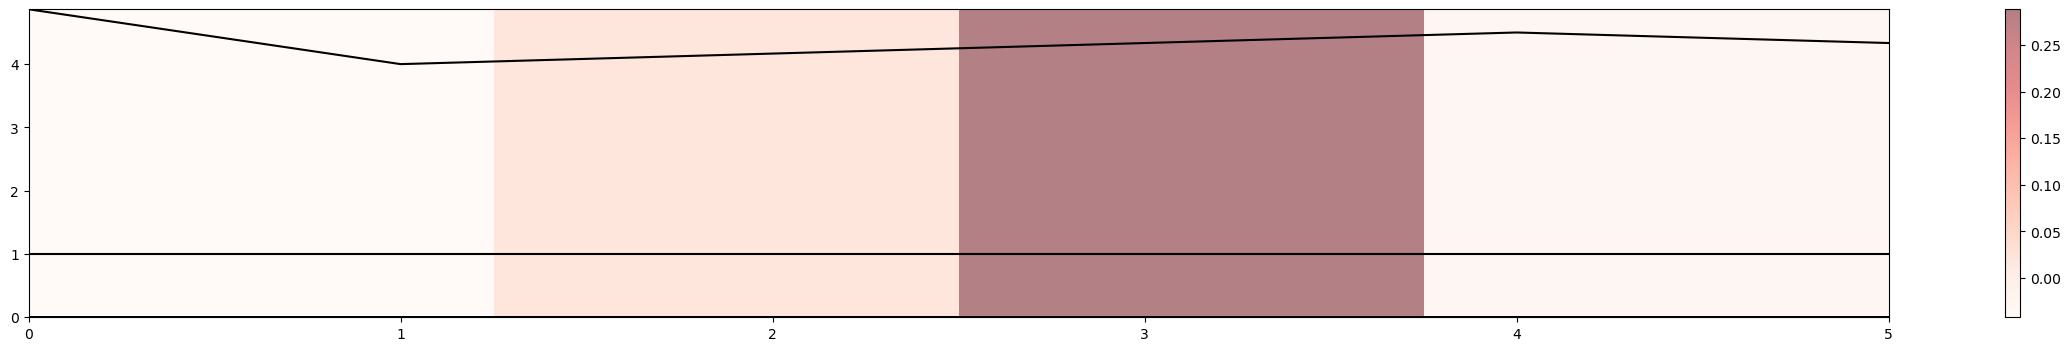

55
1/1 [==============================] - 0s 12ms/step
Model prediction = (3.9484944343566895), True Value = [4.]


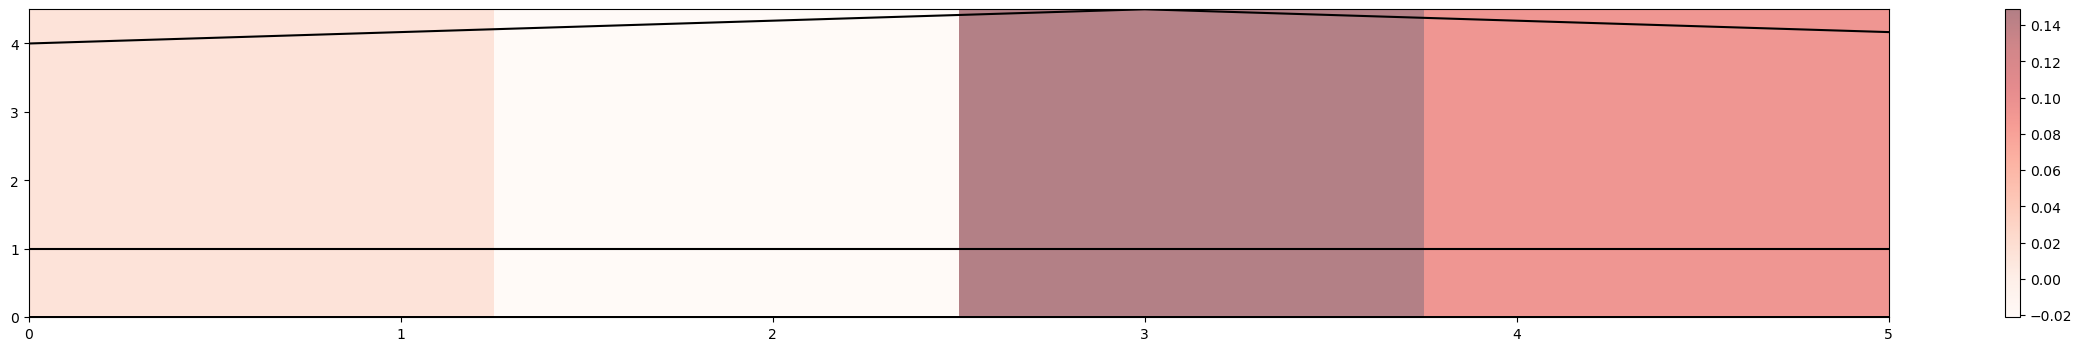

56
1/1 [==============================] - 0s 10ms/step
Model prediction = (3.9504613876342773), True Value = [3.36666667]


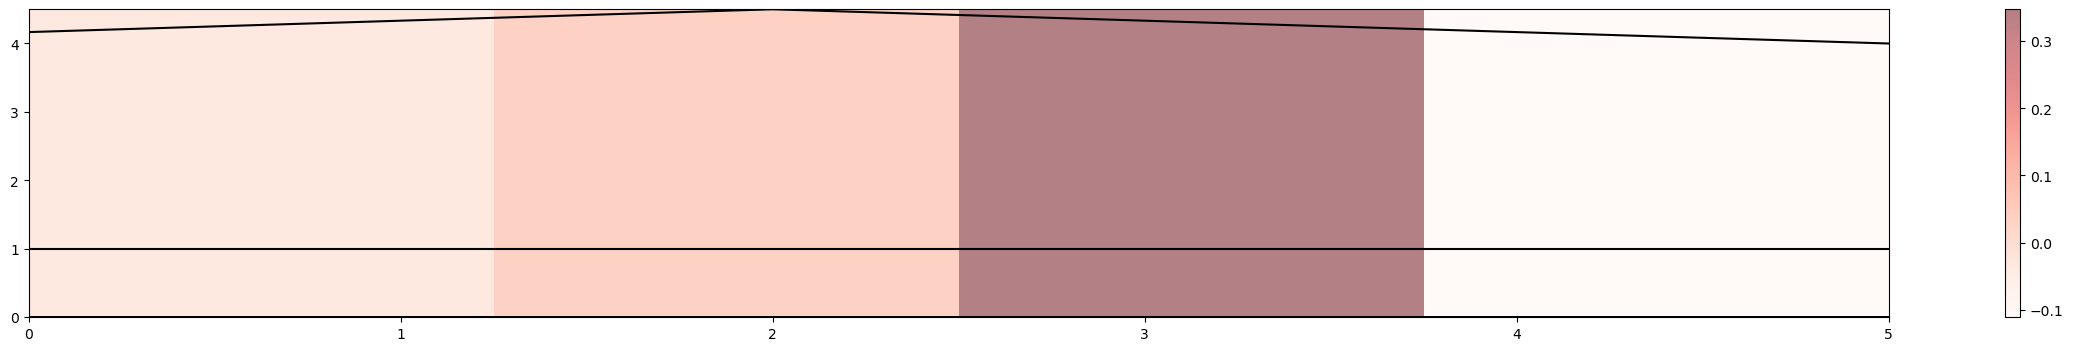

57
1/1 [==============================] - 0s 12ms/step
Model prediction = (3.0617575645446777), True Value = [2.73333333]


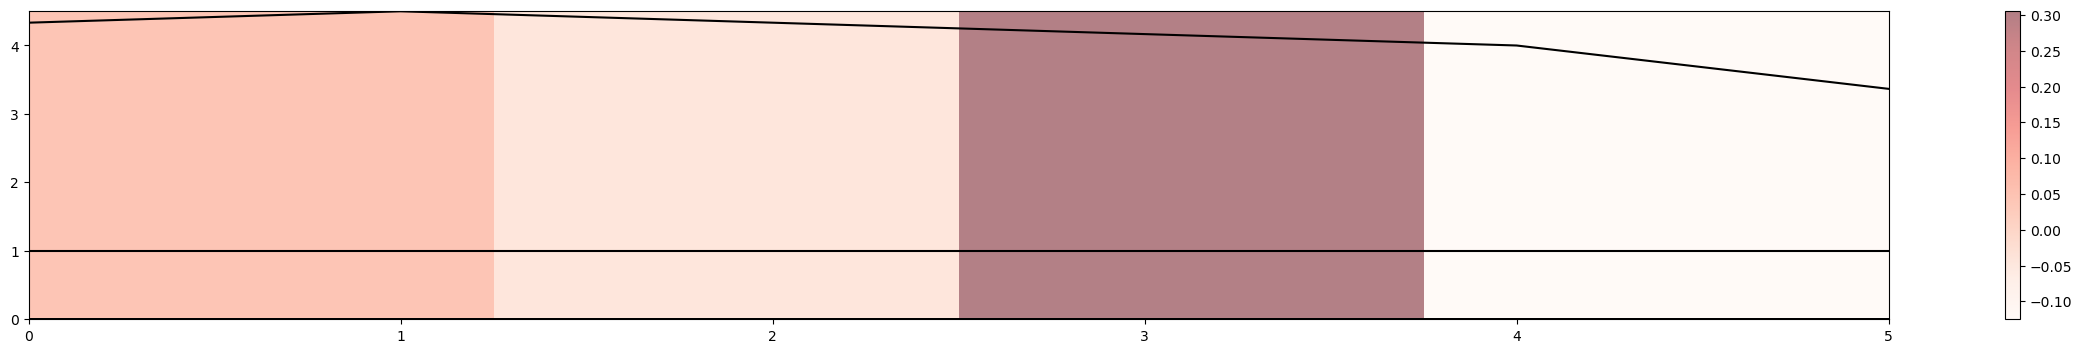

58
1/1 [==============================] - 0s 18ms/step
Model prediction = (2.2494282722473145), True Value = [2.1]


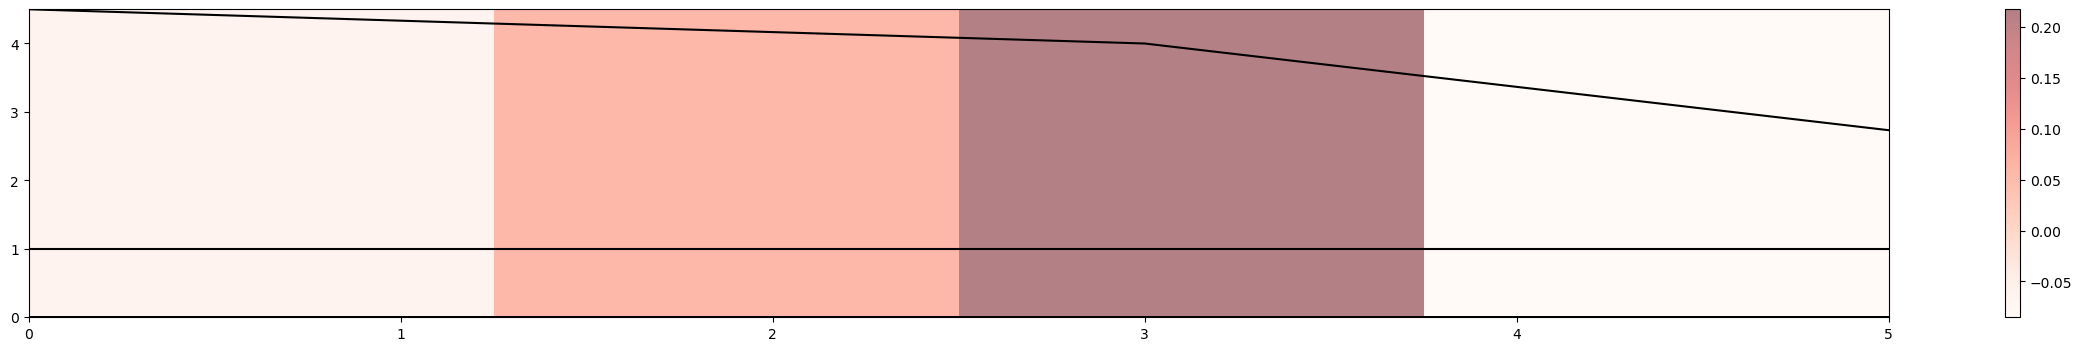

59
1/1 [==============================] - 0s 11ms/step
Model prediction = (2.0056803226470947), True Value = [1.53333333]


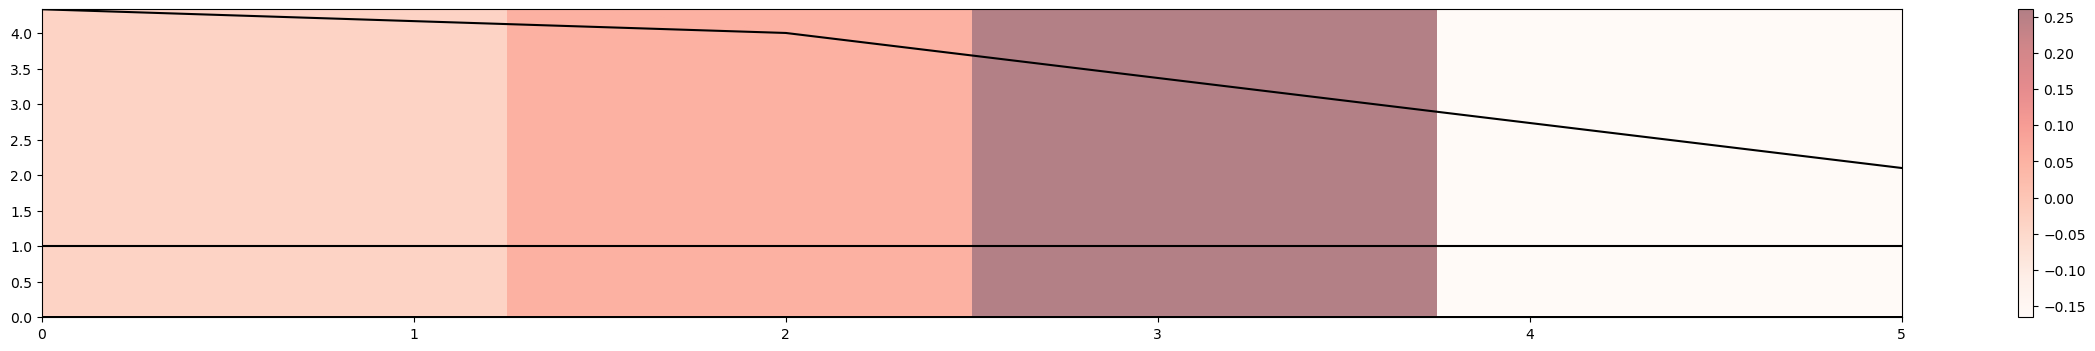

60
1/1 [==============================] - 0s 13ms/step
Model prediction = (1.4418855905532837), True Value = [0.96666667]


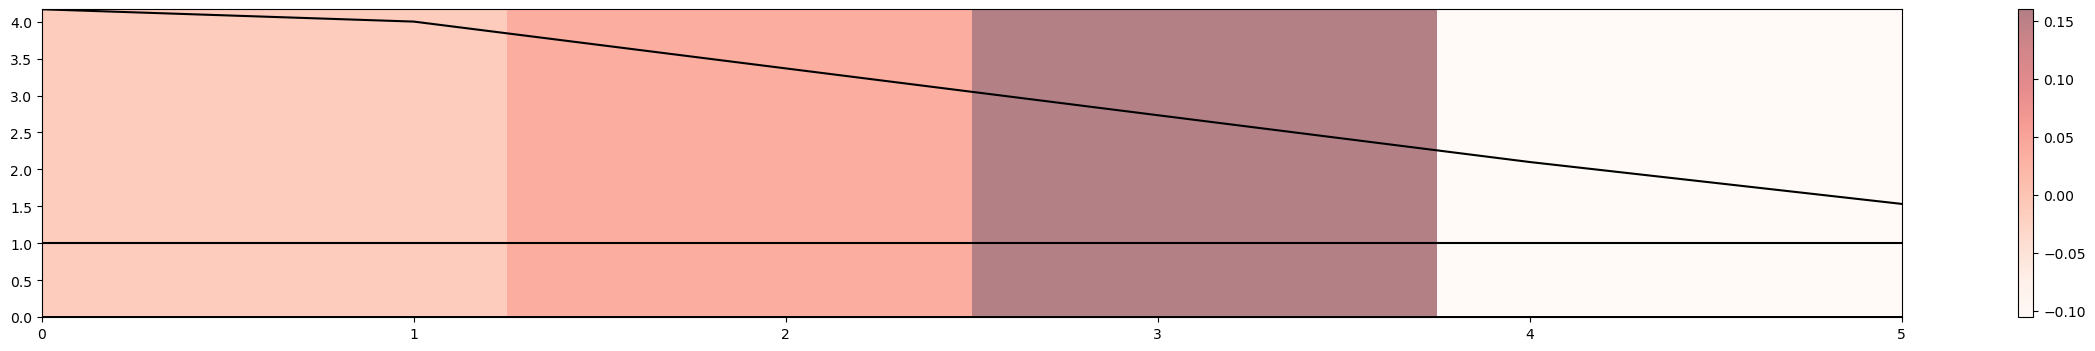

61
1/1 [==============================] - 0s 11ms/step
Model prediction = (0.7210689783096313), True Value = [0.4]


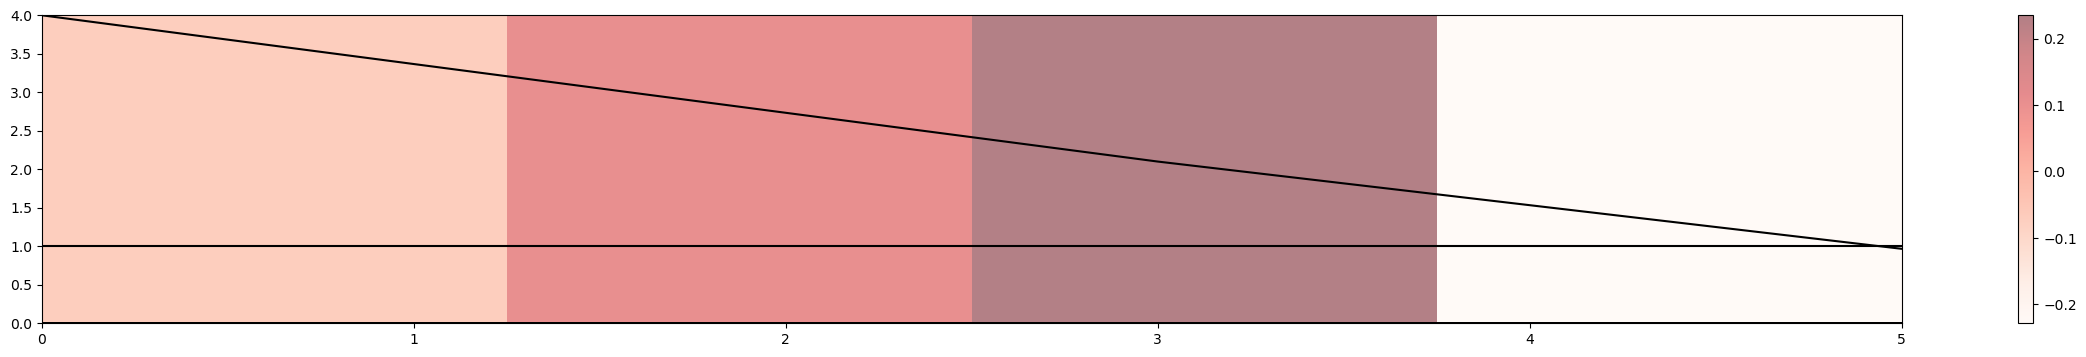

In [127]:
def grad_cam(model, layer_name, data):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    last_conv_layer_output, preds = grad_model(data)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output * pooled_grads
    heatmap = tf.reduce_mean(heatmap, axis=(1))
    heatmap = np.expand_dims(heatmap,0)
    return heatmap

model = model_eval1
layer_name = "conv1d"
for count, i in enumerate(X_test):
    print(count)
    data = np.expand_dims(i,0)
    pred = model.predict(data)[0][0]
    print(f"Model prediction = ({pred}), True Value = {y_test[count]}")
    heatmap = grad_cam(model,layer_name,data)

    plt.figure(figsize=(30,4))
    plt.imshow(np.expand_dims(heatmap,axis=2),cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,5,i.min(),i.max()], alpha=0.5)
    plt.plot(i,'k')
    plt.colorbar()
    plt.show()

### Explainability for Multilayer Model

In [156]:
model_eval2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 10, 16)            736       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 5, 16)            0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 3, 32)             1568      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 1, 32)            0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

0
1/1 [==============================] - 0s 41ms/step
Model prediction = (5.194704055786133), True Value = [4.8]
[[ 9.16015915e-04  2.35155897e-05  6.31490200e-05  9.99999536e-01
   1.72120034e-04  8.15316539e-05  1.02494465e-04  4.75119032e-05
   6.30412169e-05 -9.15951799e-06 -1.89330712e-05  4.99900051e-05
  -7.26059353e-05  1.52658633e-04  4.70000000e+00]
 [ 9.52064223e-04  5.29149635e-06  7.67431733e-05  9.99999522e-01
   7.06399432e-05  8.86067353e-05  6.59445394e-05  5.35786951e-05
   6.34695717e-05  9.88356680e-06  5.53292545e-06  4.57663121e-05
  -5.54921343e-05  1.21583560e-04  4.36666667e+00]
 [ 9.61482985e-04  1.75433444e-06  1.20328745e-04  9.99999453e-01
   1.86370672e-04  8.09030977e-05  4.89292987e-05  3.11880711e-04
   5.87340543e-05  2.95598376e-05  3.13990422e-05  3.74757744e-05
  -3.25389020e-05  7.82006286e-05  4.03333333e+00]
 [ 9.31486130e-04  1.40017563e-05  8.53945501e-05  9.99999535e-01
   6.80616203e-05  1.36040257e-04  1.36125277e-04  5.27973417e-05
   5.429

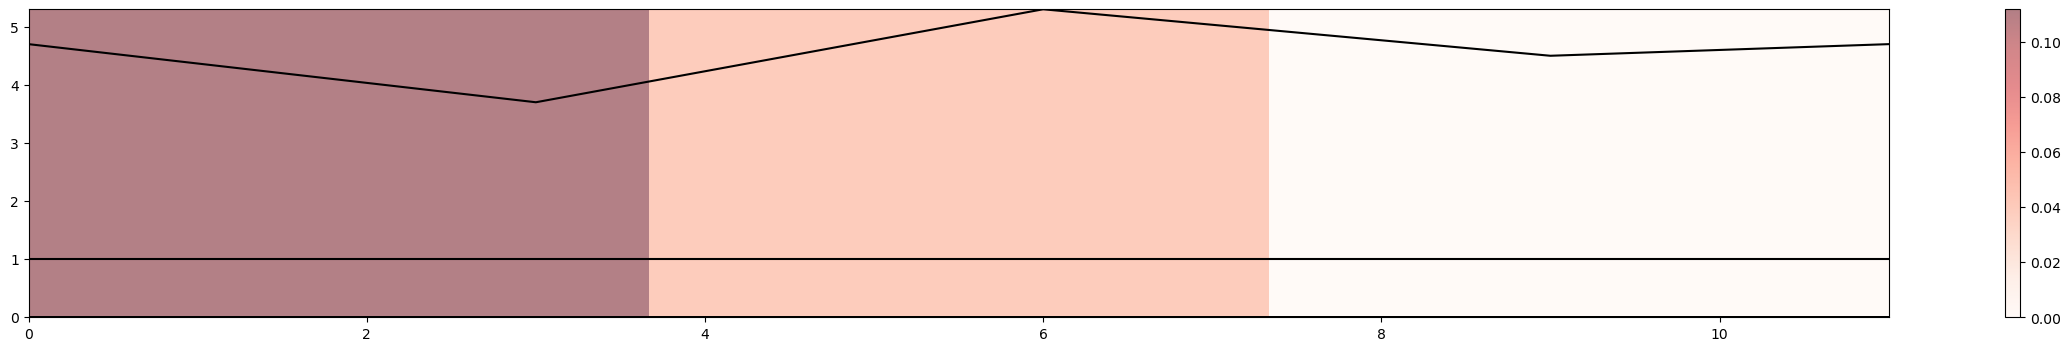

1
1/1 [==============================] - 0s 12ms/step
Model prediction = (4.782069683074951), True Value = [4.8]
[[ 9.52064223e-04  5.29149635e-06  7.67431733e-05  9.99999522e-01
   7.06399432e-05  8.86067353e-05  6.59445394e-05  5.35786951e-05
   6.34695717e-05  9.88356680e-06  5.53292545e-06  4.57663121e-05
  -5.54921343e-05  1.21583560e-04  4.36666667e+00]
 [ 9.61482985e-04  1.75433444e-06  1.20328745e-04  9.99999453e-01
   1.86370672e-04  8.09030977e-05  4.89292987e-05  3.11880711e-04
   5.87340543e-05  2.95598376e-05  3.13990422e-05  3.74757744e-05
  -3.25389020e-05  7.82006286e-05  4.03333333e+00]
 [ 9.31486130e-04  1.40017563e-05  8.53945501e-05  9.99999535e-01
   6.80616203e-05  1.36040257e-04  1.36125277e-04  5.27973417e-05
   5.42973665e-05  4.93612423e-05  5.73923922e-05  2.93819414e-05
  -9.77450342e-06  3.52580302e-05  3.70000000e+00]
 [ 9.35518626e-04  7.85545360e-06  1.10018432e-04  9.99999498e-01
   1.44096316e-04  1.28790757e-04  2.15565304e-04  1.49867014e-04
   5.294

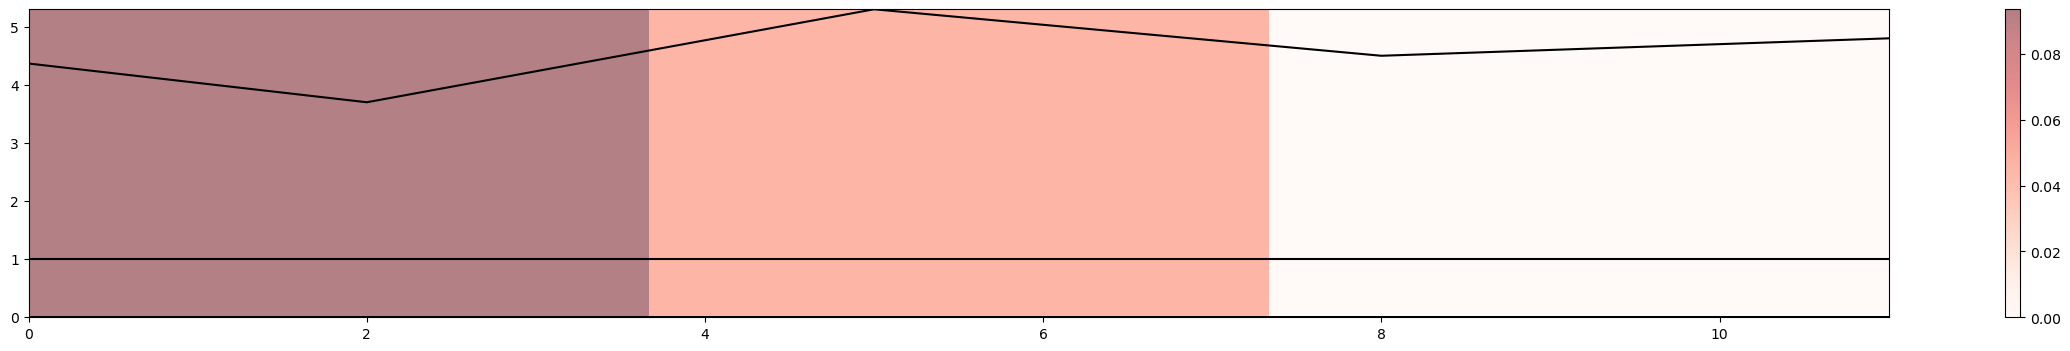

2
1/1 [==============================] - 0s 12ms/step
Model prediction = (4.749035358428955), True Value = [4.8]
[[ 9.61482985e-04  1.75433444e-06  1.20328745e-04  9.99999453e-01
   1.86370672e-04  8.09030977e-05  4.89292987e-05  3.11880711e-04
   5.87340543e-05  2.95598376e-05  3.13990422e-05  3.74757744e-05
  -3.25389020e-05  7.82006286e-05  4.03333333e+00]
 [ 9.31486130e-04  1.40017563e-05  8.53945501e-05  9.99999535e-01
   6.80616203e-05  1.36040257e-04  1.36125277e-04  5.27973417e-05
   5.42973665e-05  4.93612423e-05  5.73923922e-05  2.93819414e-05
  -9.77450342e-06  3.52580302e-05  3.70000000e+00]
 [ 9.35518626e-04  7.85545360e-06  1.10018432e-04  9.99999498e-01
   1.44096316e-04  1.28790757e-04  2.15565304e-04  1.49867014e-04
   5.29413807e-05  5.86077580e-05  3.76451927e-05  3.26245290e-05
  -1.01216007e-05  3.91697631e-05  4.23333333e+00]
 [ 9.53392206e-04  2.39407678e-05  9.30385958e-05  9.99999479e-01
   1.45298045e-04  1.20525660e-04  1.93105559e-04  1.95172498e-04
   5.593

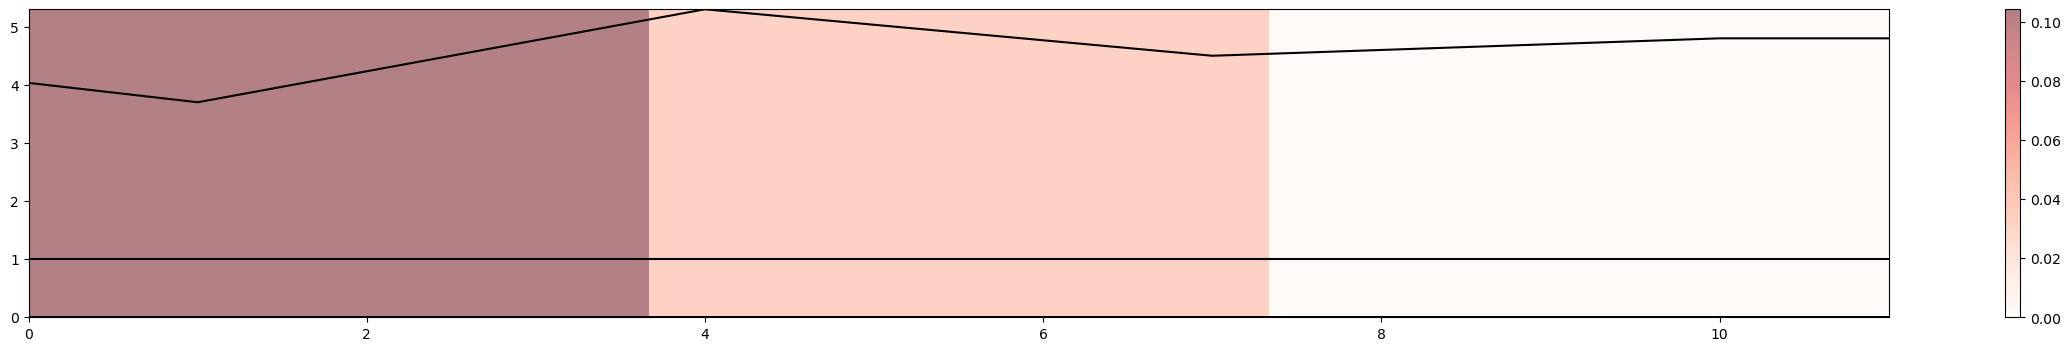

3
1/1 [==============================] - 0s 14ms/step
Model prediction = (4.775538921356201), True Value = [4.8]
[[ 9.31486130e-04  1.40017563e-05  8.53945501e-05  9.99999535e-01
   6.80616203e-05  1.36040257e-04  1.36125277e-04  5.27973417e-05
   5.42973665e-05  4.93612423e-05  5.73923922e-05  2.93819414e-05
  -9.77450342e-06  3.52580302e-05  3.70000000e+00]
 [ 9.35518626e-04  7.85545360e-06  1.10018432e-04  9.99999498e-01
   1.44096316e-04  1.28790757e-04  2.15565304e-04  1.49867014e-04
   5.29413807e-05  5.86077580e-05  3.76451927e-05  3.26245290e-05
  -1.01216007e-05  3.91697631e-05  4.23333333e+00]
 [ 9.53392206e-04  2.39407678e-05  9.30385958e-05  9.99999479e-01
   1.45298045e-04  1.20525660e-04  1.93105559e-04  1.95172498e-04
   5.59363961e-05  7.21717690e-05  2.18642931e-05  3.83589506e-05
  -1.12723815e-05  4.60723853e-05  4.76666667e+00]
 [ 9.29148253e-04 -1.54775310e-05  7.28619976e-05  9.99999536e-01
   8.45377608e-05  1.13636634e-04  1.36212711e-04 -7.07323695e-05
   5.744

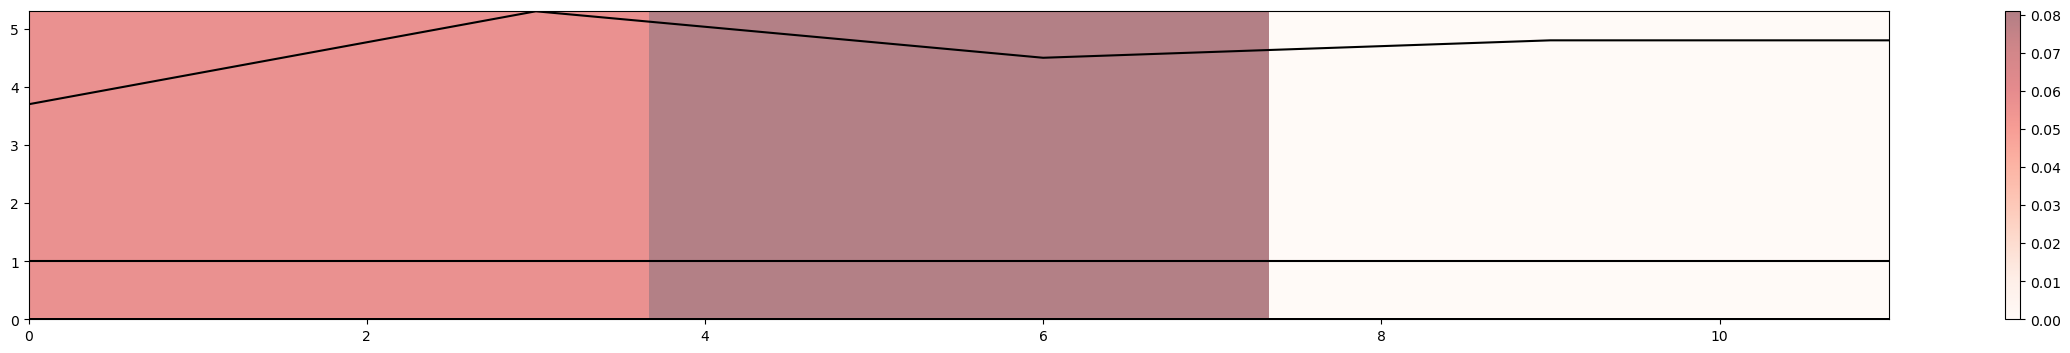

4
1/1 [==============================] - 0s 11ms/step
Model prediction = (4.705824851989746), True Value = [4.26666667]
[[ 9.35518626e-04  7.85545360e-06  1.10018432e-04  9.99999498e-01
   1.44096316e-04  1.28790757e-04  2.15565304e-04  1.49867014e-04
   5.29413807e-05  5.86077580e-05  3.76451927e-05  3.26245290e-05
  -1.01216007e-05  3.91697631e-05  4.23333333e+00]
 [ 9.53392206e-04  2.39407678e-05  9.30385958e-05  9.99999479e-01
   1.45298045e-04  1.20525660e-04  1.93105559e-04  1.95172498e-04
   5.59363961e-05  7.21717690e-05  2.18642931e-05  3.83589506e-05
  -1.12723815e-05  4.60723853e-05  4.76666667e+00]
 [ 9.29148253e-04 -1.54775310e-05  7.28619976e-05  9.99999536e-01
   8.45377608e-05  1.13636634e-04  1.36212711e-04 -7.07323695e-05
   5.74474419e-05  8.38917966e-05  5.37977735e-06  4.31025538e-05
  -1.21280995e-05  5.17850596e-05  5.30000000e+00]
 [ 9.38528251e-04 -1.18187803e-05  1.57160468e-04  9.99999513e-01
   1.49911244e-04  1.09931233e-04  1.43512610e-04  4.44008978e-05
 

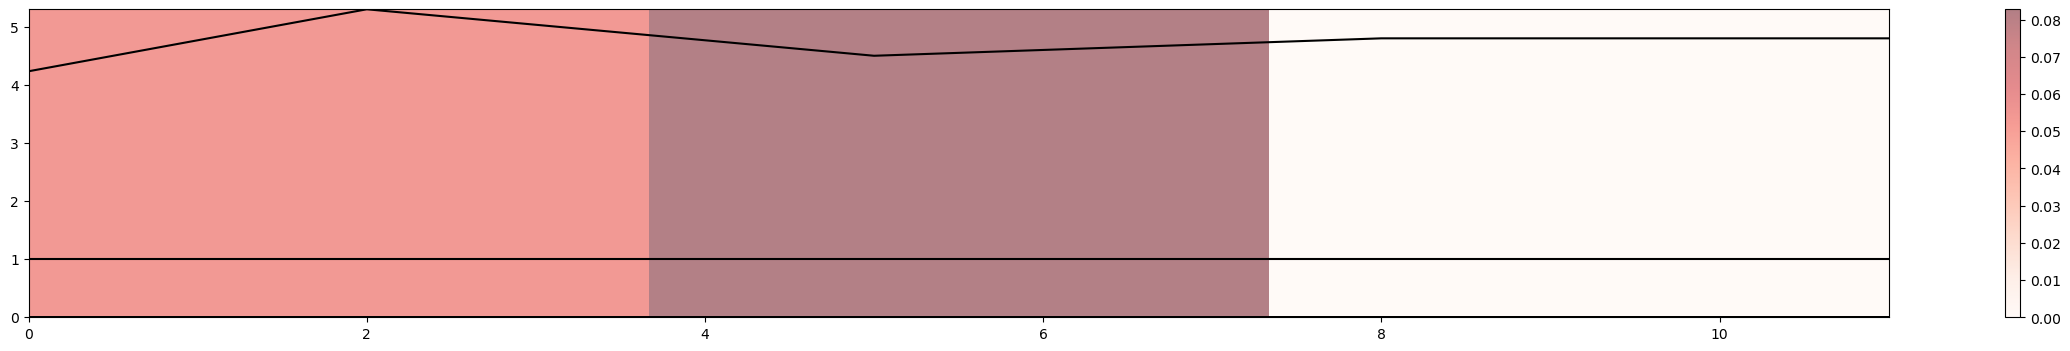

5
1/1 [==============================] - 0s 24ms/step
Model prediction = (4.76263427734375), True Value = [3.73333333]
[[ 9.53392206e-04  2.39407678e-05  9.30385958e-05  9.99999479e-01
   1.45298045e-04  1.20525660e-04  1.93105559e-04  1.95172498e-04
   5.59363961e-05  7.21717690e-05  2.18642931e-05  3.83589506e-05
  -1.12723815e-05  4.60723853e-05  4.76666667e+00]
 [ 9.29148253e-04 -1.54775310e-05  7.28619976e-05  9.99999536e-01
   8.45377608e-05  1.13636634e-04  1.36212711e-04 -7.07323695e-05
   5.74474419e-05  8.38917966e-05  5.37977735e-06  4.31025538e-05
  -1.21280995e-05  5.17850596e-05  5.30000000e+00]
 [ 9.38528251e-04 -1.18187803e-05  1.57160468e-04  9.99999513e-01
   1.49911244e-04  1.09931233e-04  1.43512610e-04  4.44008978e-05
   6.10204768e-05  6.57245819e-05 -2.13912868e-06  4.30463321e-05
   6.62525894e-06  1.83025848e-05  5.03333333e+00]
 [ 8.92797841e-04  3.81301074e-05  1.43114046e-04  9.99999575e-01
   9.71246682e-05  9.22773378e-05  5.54824574e-05  4.65700774e-05
  

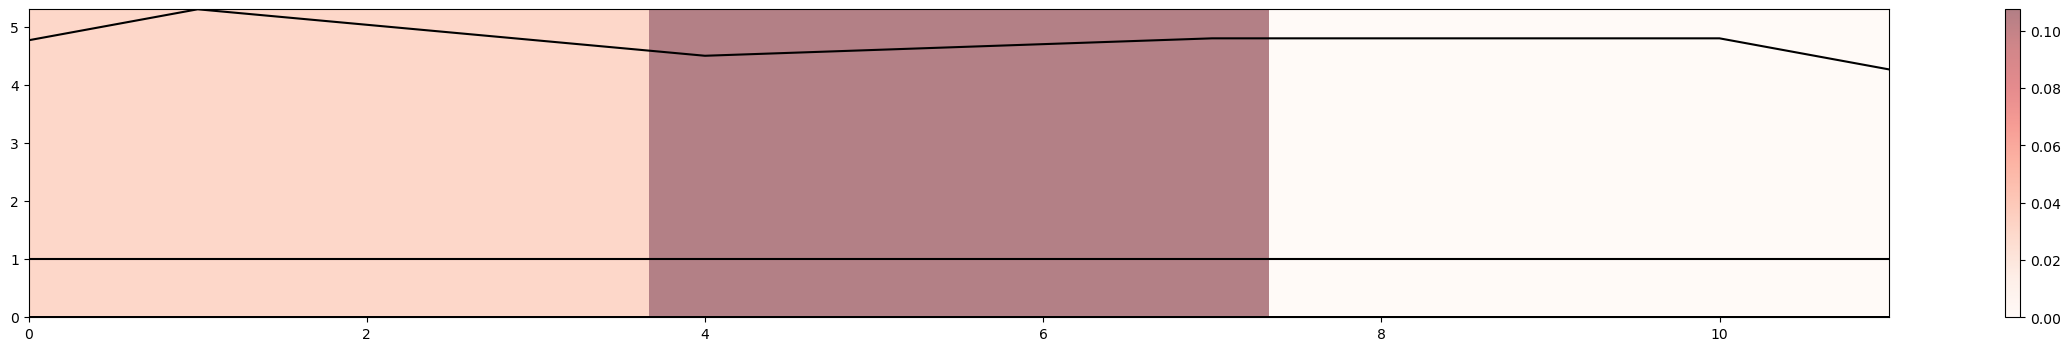

6
1/1 [==============================] - 0s 11ms/step
Model prediction = (4.829773426055908), True Value = [3.2]
[[ 9.29148253e-04 -1.54775310e-05  7.28619976e-05  9.99999536e-01
   8.45377608e-05  1.13636634e-04  1.36212711e-04 -7.07323695e-05
   5.74474419e-05  8.38917966e-05  5.37977735e-06  4.31025538e-05
  -1.21280995e-05  5.17850596e-05  5.30000000e+00]
 [ 9.38528251e-04 -1.18187803e-05  1.57160468e-04  9.99999513e-01
   1.49911244e-04  1.09931233e-04  1.43512610e-04  4.44008978e-05
   6.10204768e-05  6.57245819e-05 -2.13912868e-06  4.30463321e-05
   6.62525894e-06  1.83025848e-05  5.03333333e+00]
 [ 8.92797841e-04  3.81301074e-05  1.43114046e-04  9.99999575e-01
   9.71246682e-05  9.22773378e-05  5.54824574e-05  4.65700774e-05
   6.23007529e-05  4.55750930e-05 -9.41402933e-06  4.14297324e-05
   2.47232331e-05 -1.51028573e-05  4.76666667e+00]
 [ 9.27777564e-04  4.63369985e-05  6.20888264e-05  9.99999557e-01
   1.42519096e-05  8.14246551e-05 -2.14581299e-05 -4.69591254e-05
   6.393

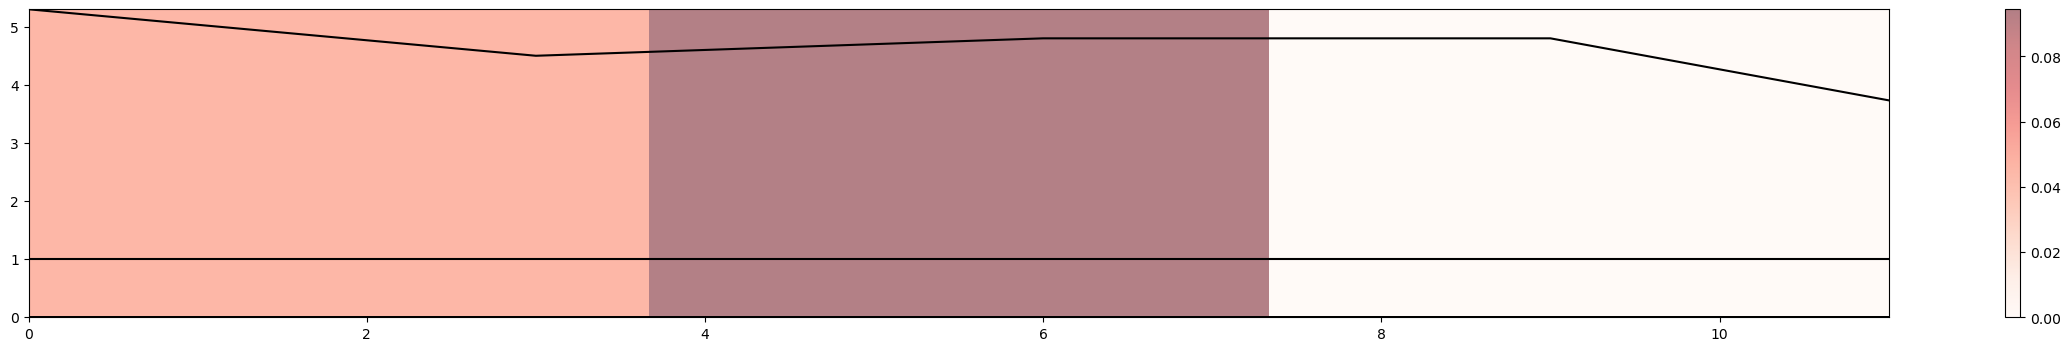

7
1/1 [==============================] - 0s 20ms/step
Model prediction = (4.823023796081543), True Value = [2.66666667]
[[ 9.38528251e-04 -1.18187803e-05  1.57160468e-04  9.99999513e-01
   1.49911244e-04  1.09931233e-04  1.43512610e-04  4.44008978e-05
   6.10204768e-05  6.57245819e-05 -2.13912868e-06  4.30463321e-05
   6.62525894e-06  1.83025848e-05  5.03333333e+00]
 [ 8.92797841e-04  3.81301074e-05  1.43114046e-04  9.99999575e-01
   9.71246682e-05  9.22773378e-05  5.54824574e-05  4.65700774e-05
   6.23007529e-05  4.55750930e-05 -9.41402933e-06  4.14297324e-05
   2.47232331e-05 -1.51028573e-05  4.76666667e+00]
 [ 9.27777564e-04  4.63369985e-05  6.20888264e-05  9.99999557e-01
   1.42519096e-05  8.14246551e-05 -2.14581299e-05 -4.69591254e-05
   6.39301779e-05  2.67455840e-05 -1.63841696e-05  4.01699153e-05
   4.20717052e-05 -4.69220772e-05  4.50000000e+00]
 [ 9.24025547e-04 -8.24549685e-05  1.35169455e-04  9.99999531e-01
   4.58765540e-05  9.08591883e-05  1.75904387e-04 -3.79059330e-05
 

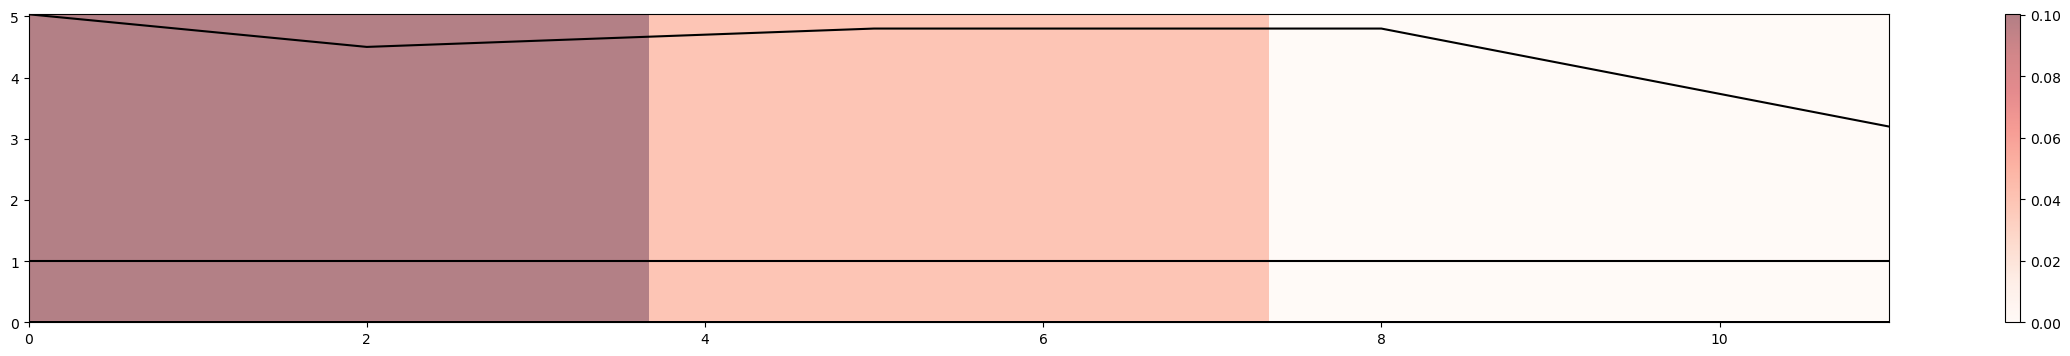

8
1/1 [==============================] - 0s 11ms/step
Model prediction = (4.6324992179870605), True Value = [2.13333333]
[[ 8.92797841e-04  3.81301074e-05  1.43114046e-04  9.99999575e-01
   9.71246682e-05  9.22773378e-05  5.54824574e-05  4.65700774e-05
   6.23007529e-05  4.55750930e-05 -9.41402933e-06  4.14297324e-05
   2.47232331e-05 -1.51028573e-05  4.76666667e+00]
 [ 9.27777564e-04  4.63369985e-05  6.20888264e-05  9.99999557e-01
   1.42519096e-05  8.14246551e-05 -2.14581299e-05 -4.69591254e-05
   6.39301779e-05  2.67455840e-05 -1.63841696e-05  4.01699153e-05
   4.20717052e-05 -4.69220772e-05  4.50000000e+00]
 [ 9.24025547e-04 -8.24549685e-05  1.35169455e-04  9.99999531e-01
   4.58765540e-05  9.08591883e-05  1.75904387e-04 -3.79059330e-05
   5.82810113e-05  4.47714685e-05  1.72492383e-06  3.86593446e-05
   7.81877406e-05 -6.41195396e-05  4.60000000e+00]
 [ 1.15414330e-03  1.02844655e-04  2.60754813e-04  9.99999255e-01
   5.43962036e-05  1.26331408e-04  5.96387147e-05 -1.44296963e-04


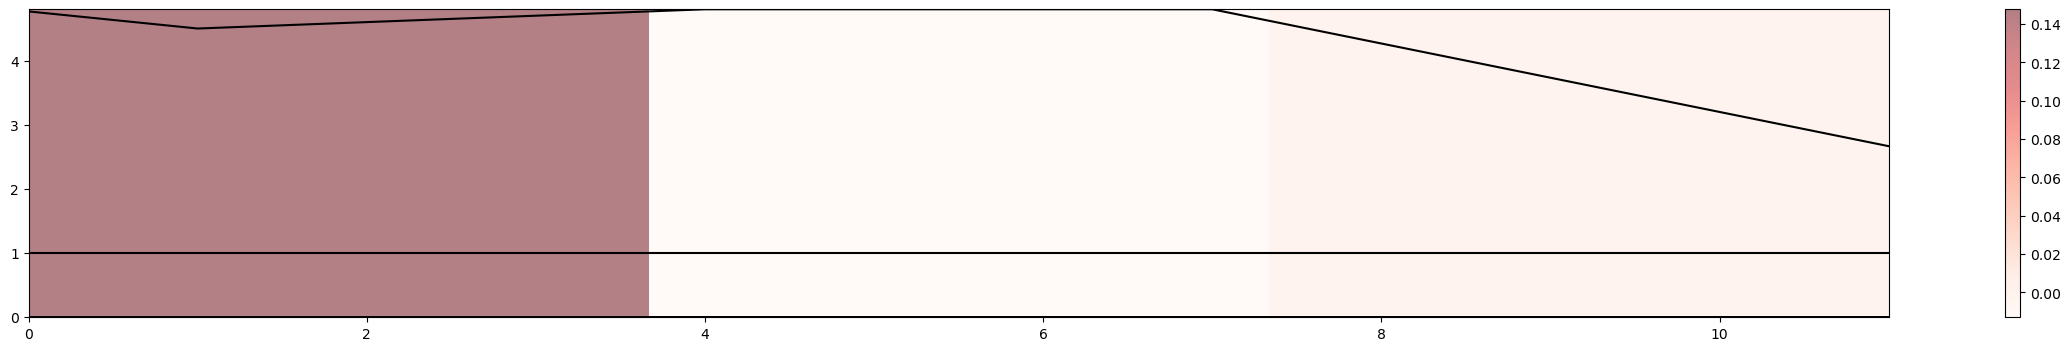

9
1/1 [==============================] - 0s 11ms/step
Model prediction = (4.299474239349365), True Value = [1.6]
[[ 9.27777564e-04  4.63369985e-05  6.20888264e-05  9.99999557e-01
   1.42519096e-05  8.14246551e-05 -2.14581299e-05 -4.69591254e-05
   6.39301779e-05  2.67455840e-05 -1.63841696e-05  4.01699153e-05
   4.20717052e-05 -4.69220772e-05  4.50000000e+00]
 [ 9.24025547e-04 -8.24549685e-05  1.35169455e-04  9.99999531e-01
   4.58765540e-05  9.08591883e-05  1.75904387e-04 -3.79059330e-05
   5.82810113e-05  4.47714685e-05  1.72492383e-06  3.86593446e-05
   7.81877406e-05 -6.41195396e-05  4.60000000e+00]
 [ 1.15414330e-03  1.02844655e-04  2.60754813e-04  9.99999255e-01
   5.43962036e-05  1.26331408e-04  5.96387147e-05 -1.44296963e-04
   5.67294264e-05  7.21648164e-05  2.50377938e-05  4.04888107e-05
   1.31952137e-04 -9.23359344e-05  4.70000000e+00]
 [ 9.12839588e-04 -1.79020923e-05  1.19209793e-04  9.99999550e-01
  -5.43859003e-06  9.93871722e-05  5.97988325e-05 -6.77922253e-05
   3.487

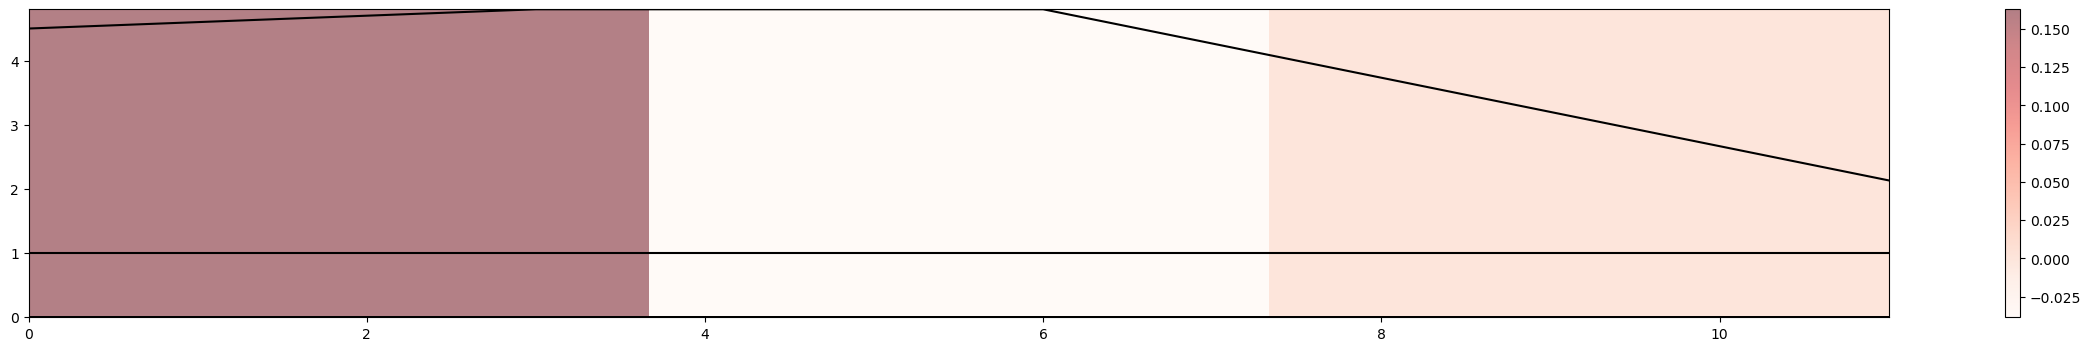

10
1/1 [==============================] - 0s 12ms/step
Model prediction = (3.705580234527588), True Value = [1.6]
[[ 9.24025547e-04 -8.24549685e-05  1.35169455e-04  9.99999531e-01
   4.58765540e-05  9.08591883e-05  1.75904387e-04 -3.79059330e-05
   5.82810113e-05  4.47714685e-05  1.72492383e-06  3.86593446e-05
   7.81877406e-05 -6.41195396e-05  4.60000000e+00]
 [ 1.15414330e-03  1.02844655e-04  2.60754813e-04  9.99999255e-01
   5.43962036e-05  1.26331408e-04  5.96387147e-05 -1.44296963e-04
   5.67294264e-05  7.21648164e-05  2.50377938e-05  4.04888107e-05
   1.31952137e-04 -9.23359344e-05  4.70000000e+00]
 [ 9.12839588e-04 -1.79020923e-05  1.19209793e-04  9.99999550e-01
  -5.43859003e-06  9.93871722e-05  5.97988325e-05 -6.77922253e-05
   3.48763430e-05  7.18622795e-05  3.78619258e-05  2.76416637e-05
   1.34840922e-04 -8.55503327e-05  4.80000000e+00]
 [ 8.93033800e-04  7.05626914e-06  6.61647390e-05  9.99999562e-01
   1.04990372e-04  1.09455561e-04  1.02696076e-04 -6.50823413e-05
   3.45

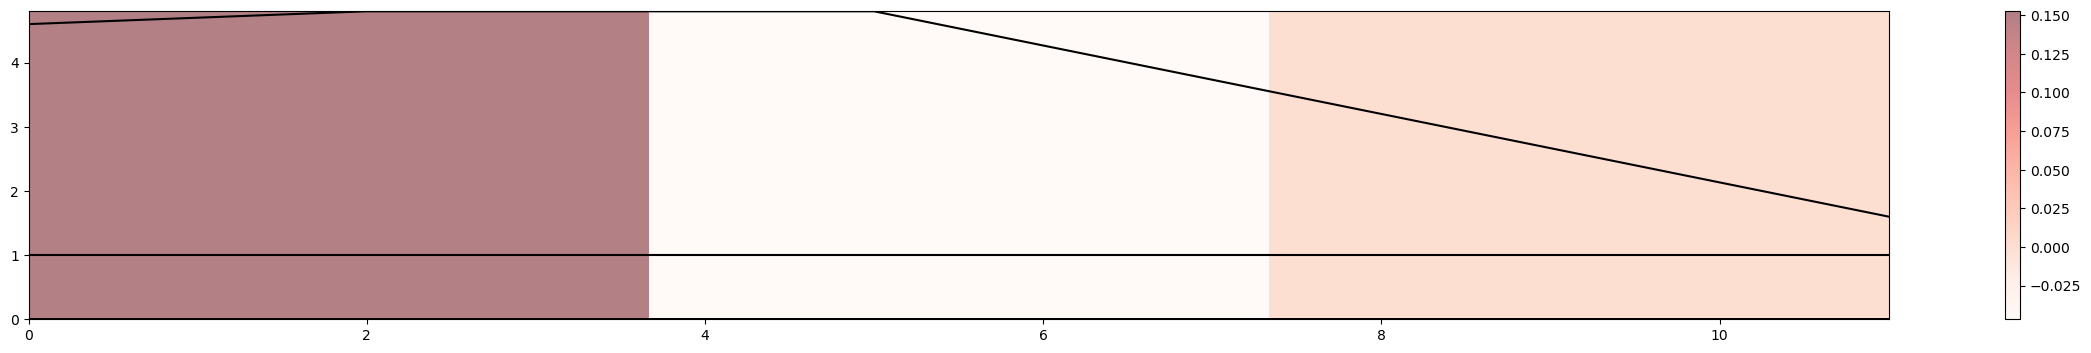

11
1/1 [==============================] - 0s 11ms/step
Model prediction = (2.9780657291412354), True Value = [1.6]
[[ 1.15414330e-03  1.02844655e-04  2.60754813e-04  9.99999255e-01
   5.43962036e-05  1.26331408e-04  5.96387147e-05 -1.44296963e-04
   5.67294264e-05  7.21648164e-05  2.50377938e-05  4.04888107e-05
   1.31952137e-04 -9.23359344e-05  4.70000000e+00]
 [ 9.12839588e-04 -1.79020923e-05  1.19209793e-04  9.99999550e-01
  -5.43859003e-06  9.93871722e-05  5.97988325e-05 -6.77922253e-05
   3.48763430e-05  7.18622795e-05  3.78619258e-05  2.76416637e-05
   1.34840922e-04 -8.55503327e-05  4.80000000e+00]
 [ 8.93033800e-04  7.05626914e-06  6.61647390e-05  9.99999562e-01
   1.04990372e-04  1.09455561e-04  1.02696076e-04 -6.50823413e-05
   3.45847789e-05  7.86883250e-05  9.48055533e-06  3.40632073e-05
   1.46744520e-04 -8.16601336e-05  4.80000000e+00]
 [ 9.34319178e-04 -5.13763391e-06  6.13589934e-05  9.99999523e-01
   9.13165304e-05  8.82059784e-05  1.24394747e-04 -7.49476403e-05
   3.2

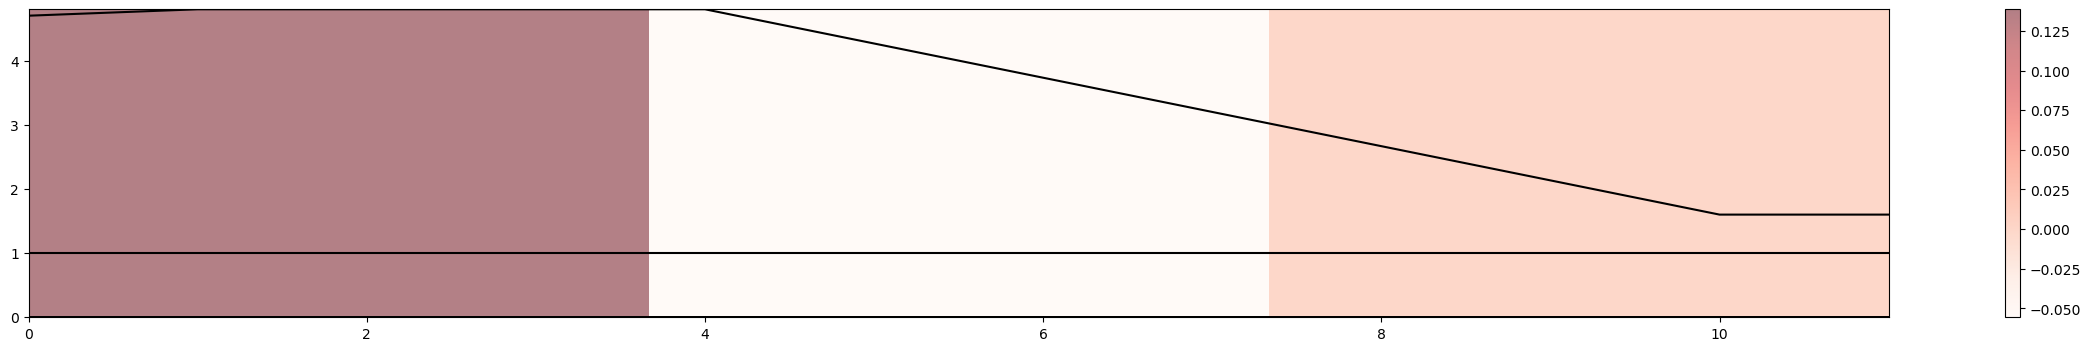

12
1/1 [==============================] - 0s 16ms/step
Model prediction = (2.345550060272217), True Value = [1.6]
[[ 9.12839588e-04 -1.79020923e-05  1.19209793e-04  9.99999550e-01
  -5.43859003e-06  9.93871722e-05  5.97988325e-05 -6.77922253e-05
   3.48763430e-05  7.18622795e-05  3.78619258e-05  2.76416637e-05
   1.34840922e-04 -8.55503327e-05  4.80000000e+00]
 [ 8.93033800e-04  7.05626914e-06  6.61647390e-05  9.99999562e-01
   1.04990372e-04  1.09455561e-04  1.02696076e-04 -6.50823413e-05
   3.45847789e-05  7.86883250e-05  9.48055533e-06  3.40632073e-05
   1.46744520e-04 -8.16601336e-05  4.80000000e+00]
 [ 9.34319178e-04 -5.13763391e-06  6.13589934e-05  9.99999523e-01
   9.13165304e-05  8.82059784e-05  1.24394747e-04 -7.49476403e-05
   3.29232883e-05  8.28814304e-05 -2.11051525e-05  3.95689934e-05
   1.53684606e-04 -7.43284269e-05  4.80000000e+00]
 [ 9.43170773e-04  1.06070907e-05  8.21031370e-05  9.99999514e-01
   1.24894279e-04  4.09206113e-05  8.05331273e-05 -8.39080579e-05
   3.16

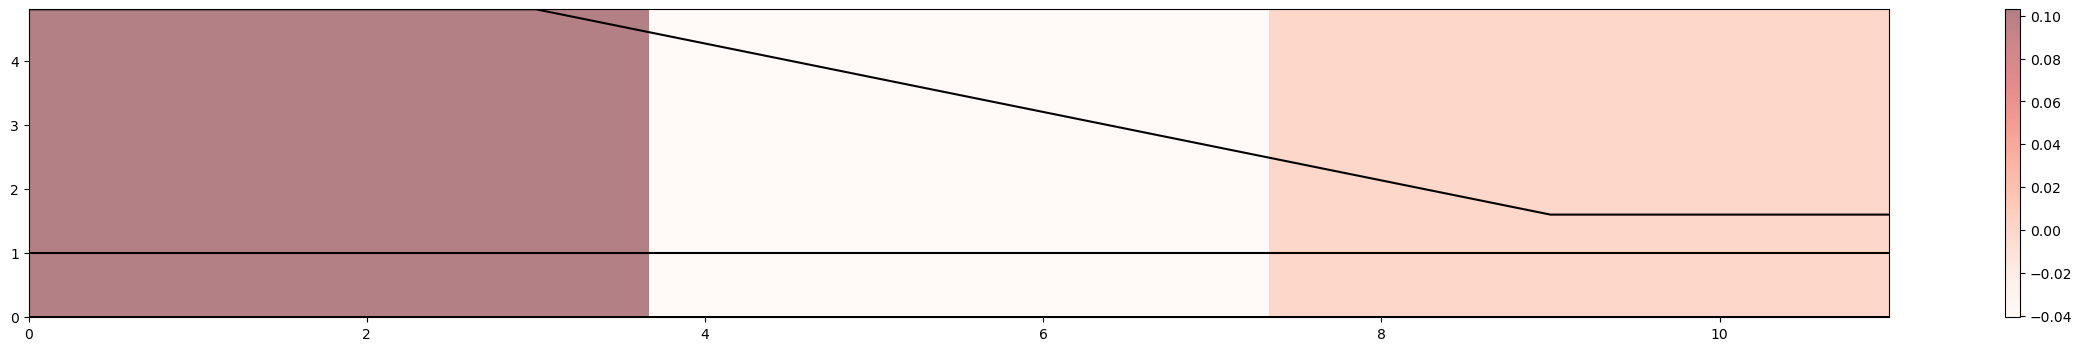

13
1/1 [==============================] - 0s 11ms/step
Model prediction = (1.8660708665847778), True Value = [1.53333333]
[[ 8.93033800e-04  7.05626914e-06  6.61647390e-05  9.99999562e-01
   1.04990372e-04  1.09455561e-04  1.02696076e-04 -6.50823413e-05
   3.45847789e-05  7.86883250e-05  9.48055533e-06  3.40632073e-05
   1.46744520e-04 -8.16601336e-05  4.80000000e+00]
 [ 9.34319178e-04 -5.13763391e-06  6.13589934e-05  9.99999523e-01
   9.13165304e-05  8.82059784e-05  1.24394747e-04 -7.49476403e-05
   3.29232883e-05  8.28814304e-05 -2.11051525e-05  3.95689934e-05
   1.53684606e-04 -7.43284269e-05  4.80000000e+00]
 [ 9.43170773e-04  1.06070907e-05  8.21031370e-05  9.99999514e-01
   1.24894279e-04  4.09206113e-05  8.05331273e-05 -8.39080579e-05
   3.16039270e-05  8.82586138e-05 -5.31299867e-05  4.57751181e-05
   1.62788110e-04 -6.76311217e-05  4.80000000e+00]
 [ 9.18958856e-04 -3.02399642e-05  8.21980828e-05  9.99999532e-01
   2.02465376e-04  2.94037872e-05  6.15217250e-05 -6.06007192e-05

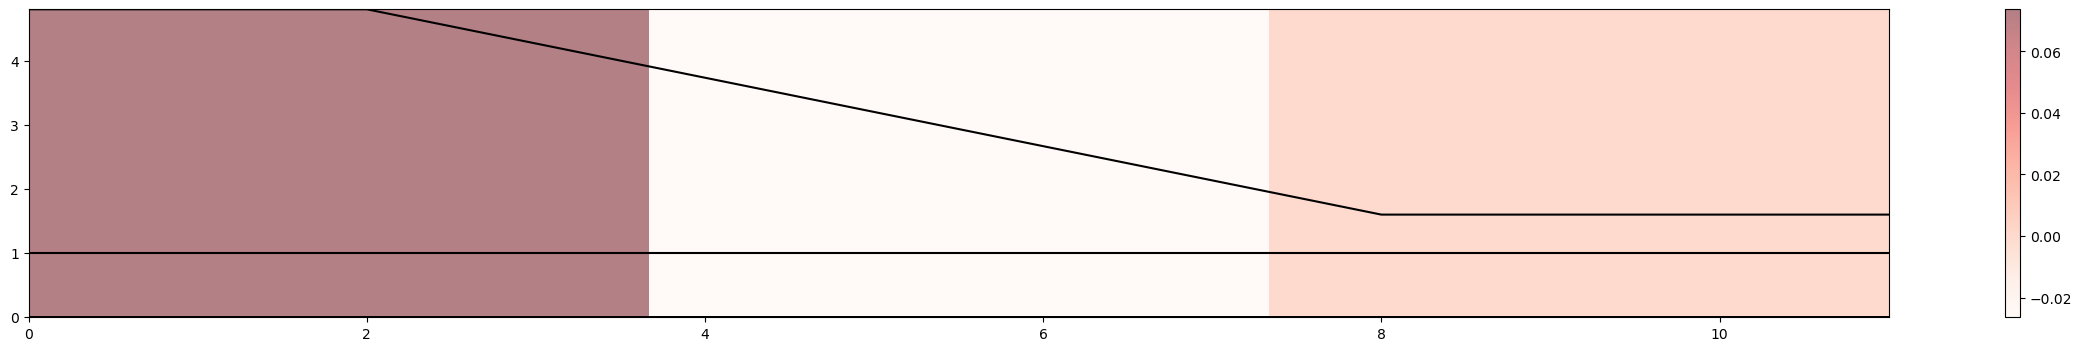

14
1/1 [==============================] - 0s 10ms/step
Model prediction = (1.9648933410644531), True Value = [1.46666667]
[[ 9.34319178e-04 -5.13763391e-06  6.13589934e-05  9.99999523e-01
   9.13165304e-05  8.82059784e-05  1.24394747e-04 -7.49476403e-05
   3.29232883e-05  8.28814304e-05 -2.11051525e-05  3.95689934e-05
   1.53684606e-04 -7.43284269e-05  4.80000000e+00]
 [ 9.43170773e-04  1.06070907e-05  8.21031370e-05  9.99999514e-01
   1.24894279e-04  4.09206113e-05  8.05331273e-05 -8.39080579e-05
   3.16039270e-05  8.82586138e-05 -5.31299867e-05  4.57751181e-05
   1.62788110e-04 -6.76311217e-05  4.80000000e+00]
 [ 9.18958856e-04 -3.02399642e-05  8.21980828e-05  9.99999532e-01
   2.02465376e-04  2.94037872e-05  6.15217250e-05 -6.06007192e-05
   2.41247122e-05  6.45375122e-05 -2.37612398e-05  2.80711596e-05
   1.61064240e-04 -4.23891706e-05  4.26666667e+00]
 [ 9.59053134e-04 -1.20637428e-05  6.56587477e-05  9.99999513e-01
   1.22054491e-04  2.87194410e-05  3.08060062e-05 -1.44555127e-05

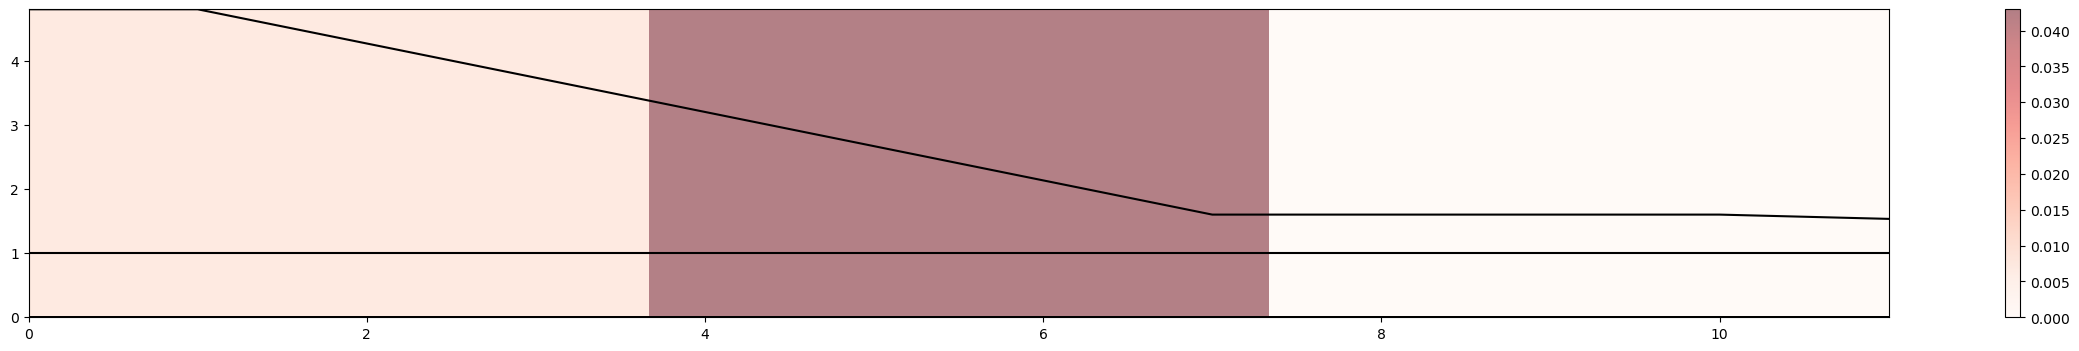

15
1/1 [==============================] - 0s 19ms/step
Model prediction = (2.0341944694519043), True Value = [1.4]
[[ 9.43170773e-04  1.06070907e-05  8.21031370e-05  9.99999514e-01
   1.24894279e-04  4.09206113e-05  8.05331273e-05 -8.39080579e-05
   3.16039270e-05  8.82586138e-05 -5.31299867e-05  4.57751181e-05
   1.62788110e-04 -6.76311217e-05  4.80000000e+00]
 [ 9.18958856e-04 -3.02399642e-05  8.21980828e-05  9.99999532e-01
   2.02465376e-04  2.94037872e-05  6.15217250e-05 -6.06007192e-05
   2.41247122e-05  6.45375122e-05 -2.37612398e-05  2.80711596e-05
   1.61064240e-04 -4.23891706e-05  4.26666667e+00]
 [ 9.59053134e-04 -1.20637428e-05  6.56587477e-05  9.99999513e-01
   1.22054491e-04  2.87194410e-05  3.08060062e-05 -1.44555127e-05
   1.86257778e-05  4.63194335e-05  2.43960875e-06  1.31694947e-05
   1.69893750e-04 -2.12962913e-05  3.73333333e+00]
 [ 9.09311204e-04  1.71323731e-05  6.20383792e-05  9.99999557e-01
   1.46879809e-04  7.12073767e-06  4.41856605e-06 -1.59747973e-05
   1.2

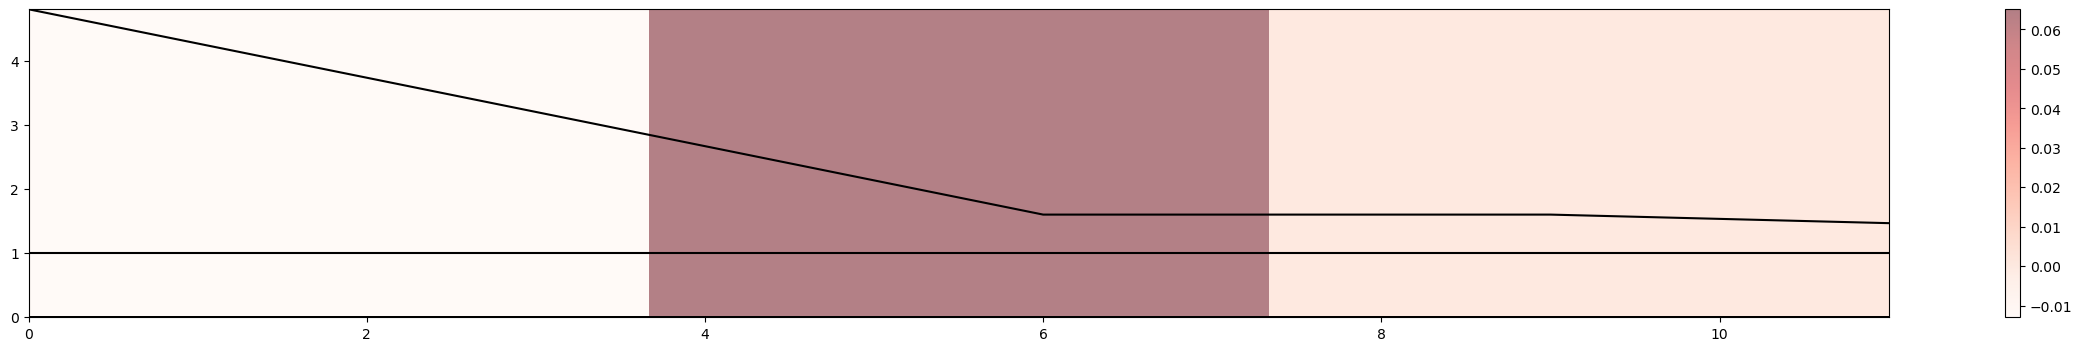

16
1/1 [==============================] - 0s 12ms/step
Model prediction = (2.3861145973205566), True Value = [1.23333333]
[[ 9.18958856e-04 -3.02399642e-05  8.21980828e-05  9.99999532e-01
   2.02465376e-04  2.94037872e-05  6.15217250e-05 -6.06007192e-05
   2.41247122e-05  6.45375122e-05 -2.37612398e-05  2.80711596e-05
   1.61064240e-04 -4.23891706e-05  4.26666667e+00]
 [ 9.59053134e-04 -1.20637428e-05  6.56587477e-05  9.99999513e-01
   1.22054491e-04  2.87194410e-05  3.08060062e-05 -1.44555127e-05
   1.86257778e-05  4.63194335e-05  2.43960875e-06  1.31694947e-05
   1.69893750e-04 -2.12962913e-05  3.73333333e+00]
 [ 9.09311204e-04  1.71323731e-05  6.20383792e-05  9.99999557e-01
   1.46879809e-04  7.12073767e-06  4.41856605e-06 -1.59747973e-05
   1.29153602e-05  2.75872094e-05  2.85429460e-05 -1.85314076e-06
   1.76641265e-04  0.00000000e+00  3.20000000e+00]
 [ 8.94605655e-04  5.32852053e-06  5.92504647e-05  9.99999563e-01
   1.76751924e-04 -8.92530780e-07  4.64787789e-05 -3.55556482e-05

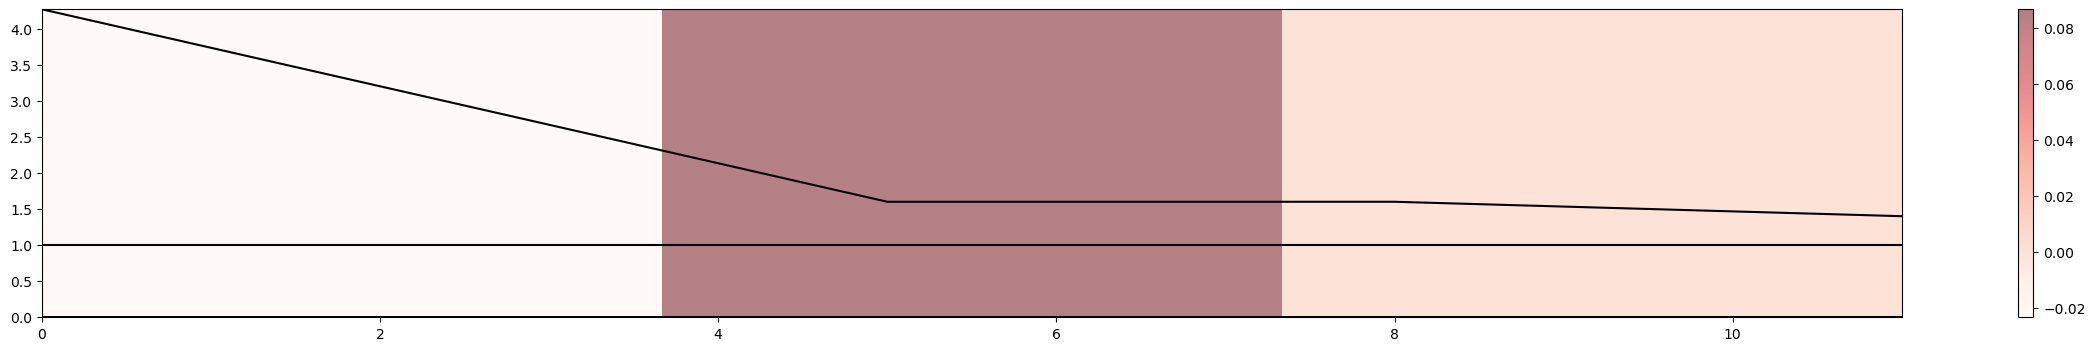

17
1/1 [==============================] - 0s 12ms/step
Model prediction = (2.5466198921203613), True Value = [1.06666667]
[[ 9.59053134e-04 -1.20637428e-05  6.56587477e-05  9.99999513e-01
   1.22054491e-04  2.87194410e-05  3.08060062e-05 -1.44555127e-05
   1.86257778e-05  4.63194335e-05  2.43960875e-06  1.31694947e-05
   1.69893750e-04 -2.12962913e-05  3.73333333e+00]
 [ 9.09311204e-04  1.71323731e-05  6.20383792e-05  9.99999557e-01
   1.46879809e-04  7.12073767e-06  4.41856605e-06 -1.59747973e-05
   1.29153602e-05  2.75872094e-05  2.85429460e-05 -1.85314076e-06
   1.76641265e-04  0.00000000e+00  3.20000000e+00]
 [ 8.94605655e-04  5.32852053e-06  5.92504647e-05  9.99999563e-01
   1.76751924e-04 -8.92530780e-07  4.64787789e-05 -3.55556482e-05
   5.91200377e-06  5.95950847e-06  3.68214980e-05 -8.51820812e-06
   1.86092845e-04  1.65541902e-05  2.66666667e+00]
 [ 9.06786050e-04 -1.08067005e-05  1.14955808e-05  9.99999560e-01
   7.98255666e-05  4.16858620e-08  6.21577178e-05  3.88116992e-05

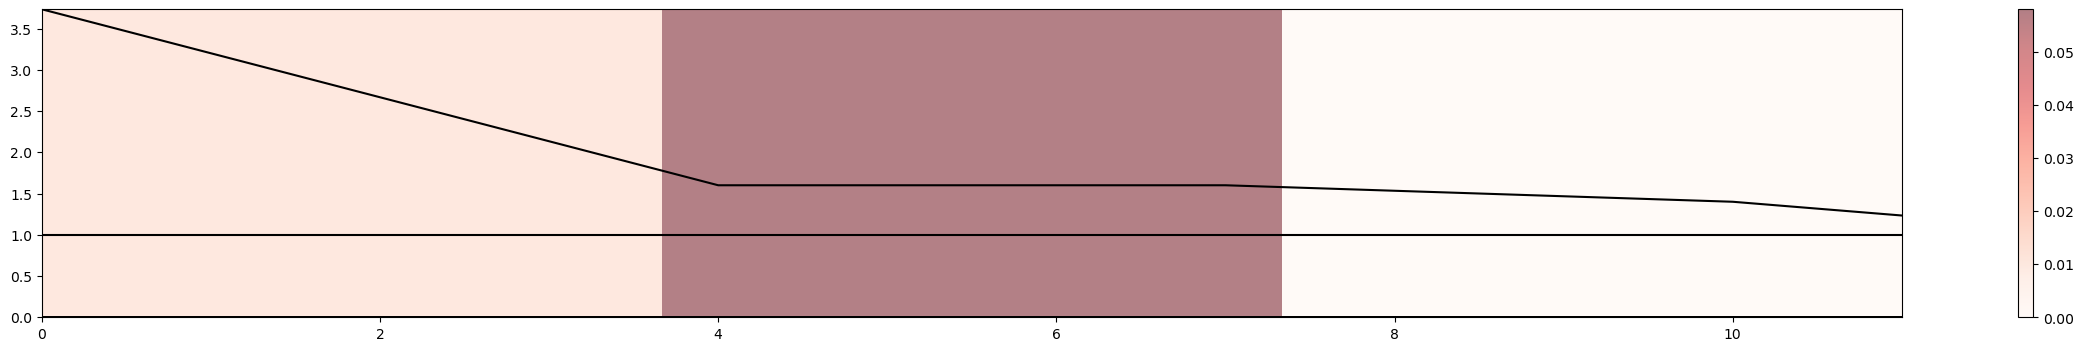

18
1/1 [==============================] - 0s 12ms/step
Model prediction = (2.8446500301361084), True Value = [0.9]
[[ 9.09311204e-04  1.71323731e-05  6.20383792e-05  9.99999557e-01
   1.46879809e-04  7.12073767e-06  4.41856605e-06 -1.59747973e-05
   1.29153602e-05  2.75872094e-05  2.85429460e-05 -1.85314076e-06
   1.76641265e-04  0.00000000e+00  3.20000000e+00]
 [ 8.94605655e-04  5.32852053e-06  5.92504647e-05  9.99999563e-01
   1.76751924e-04 -8.92530780e-07  4.64787789e-05 -3.55556482e-05
   5.91200377e-06  5.95950847e-06  3.68214980e-05 -8.51820812e-06
   1.86092845e-04  1.65541902e-05  2.66666667e+00]
 [ 9.06786050e-04 -1.08067005e-05  1.14955808e-05  9.99999560e-01
   7.98255666e-05  4.16858620e-08  6.21577178e-05  3.88116992e-05
  -7.44446330e-07 -1.51699883e-05  4.67316199e-05 -1.55122976e-05
   2.04120412e-04  3.37110851e-05  2.13333333e+00]
 [ 9.99403259e-04 -5.21615077e-05  5.45442452e-05  9.99999461e-01
   5.71942672e-05  1.31583412e-06  1.70468861e-05 -1.04759796e-04
  -7.6

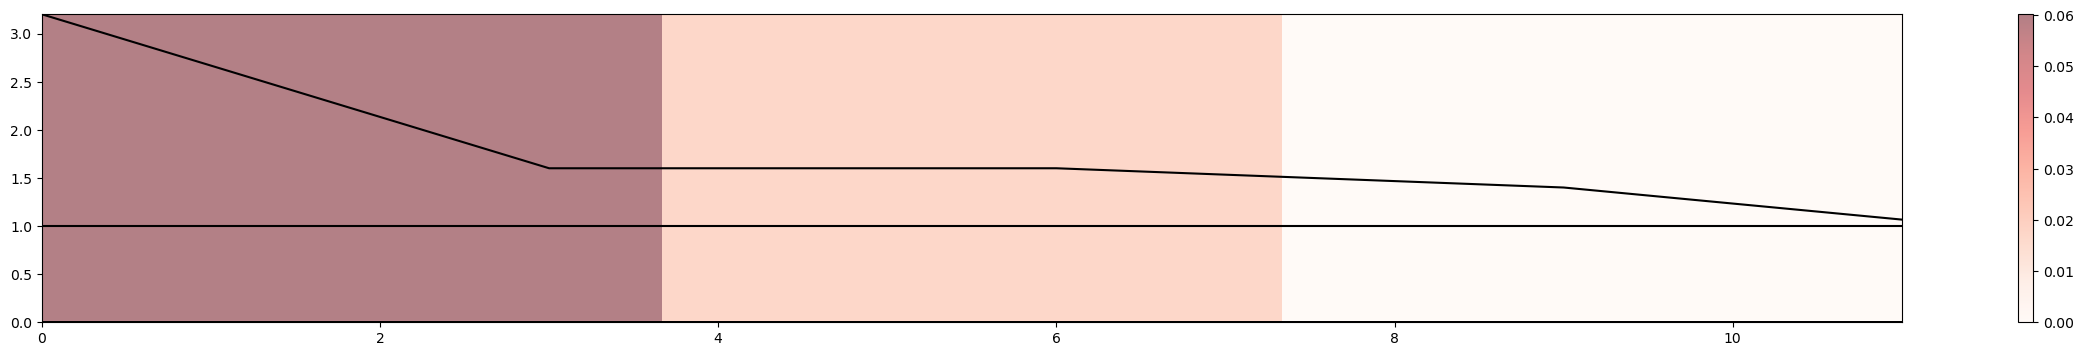

19
1/1 [==============================] - 0s 12ms/step
Model prediction = (2.9609522819519043), True Value = [1.06666667]
[[ 8.94605655e-04  5.32852053e-06  5.92504647e-05  9.99999563e-01
   1.76751924e-04 -8.92530780e-07  4.64787789e-05 -3.55556482e-05
   5.91200377e-06  5.95950847e-06  3.68214980e-05 -8.51820812e-06
   1.86092845e-04  1.65541902e-05  2.66666667e+00]
 [ 9.06786050e-04 -1.08067005e-05  1.14955808e-05  9.99999560e-01
   7.98255666e-05  4.16858620e-08  6.21577178e-05  3.88116992e-05
  -7.44446330e-07 -1.51699883e-05  4.67316199e-05 -1.55122976e-05
   2.04120412e-04  3.37110851e-05  2.13333333e+00]
 [ 9.99403259e-04 -5.21615077e-05  5.45442452e-05  9.99999461e-01
   5.71942672e-05  1.31583412e-06  1.70468861e-05 -1.04759796e-04
  -7.68478389e-06 -3.72626632e-05  5.72853951e-05 -2.28760277e-05
   2.23895830e-04  5.17536989e-05  1.60000000e+00]
 [ 1.00984023e-03  7.28852725e-05  2.07173399e-06  9.99999452e-01
   7.95588251e-05 -3.99928807e-06  4.57974735e-05 -1.60376116e-04

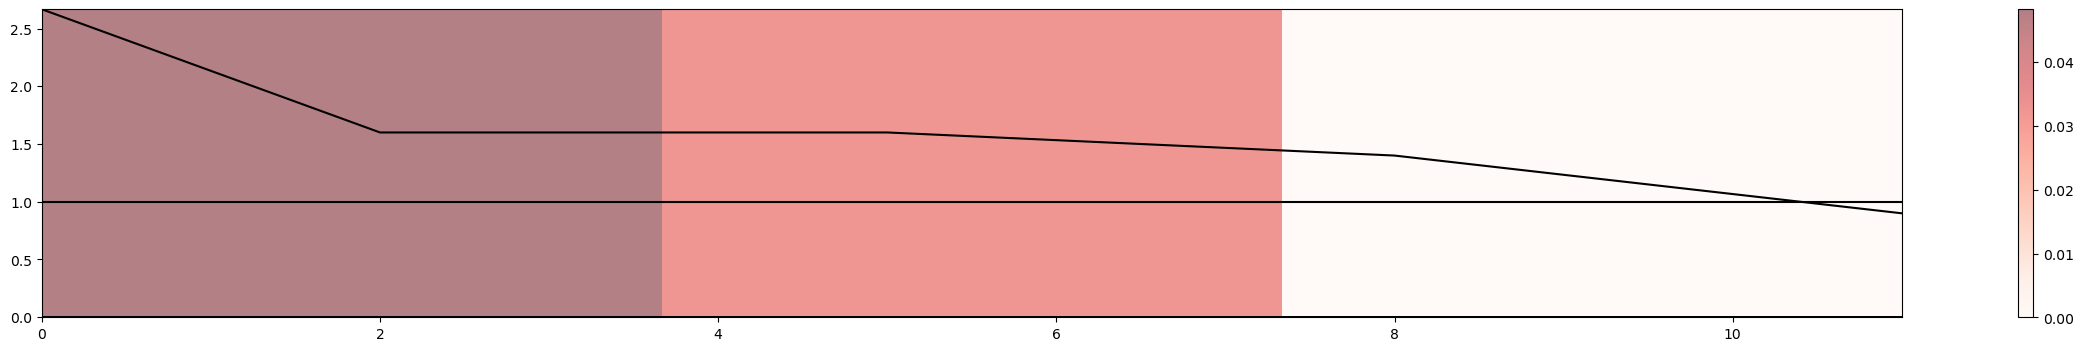

20
1/1 [==============================] - 0s 14ms/step
Model prediction = (2.8804931640625), True Value = [1.23333333]
[[ 9.06786050e-04 -1.08067005e-05  1.14955808e-05  9.99999560e-01
   7.98255666e-05  4.16858620e-08  6.21577178e-05  3.88116992e-05
  -7.44446330e-07 -1.51699883e-05  4.67316199e-05 -1.55122976e-05
   2.04120412e-04  3.37110851e-05  2.13333333e+00]
 [ 9.99403259e-04 -5.21615077e-05  5.45442452e-05  9.99999461e-01
   5.71942672e-05  1.31583412e-06  1.70468861e-05 -1.04759796e-04
  -7.68478389e-06 -3.72626632e-05  5.72853951e-05 -2.28760277e-05
   2.23895830e-04  5.17536989e-05  1.60000000e+00]
 [ 1.00984023e-03  7.28852725e-05  2.07173399e-06  9.99999452e-01
   7.95588251e-05 -3.99928807e-06  4.57974735e-05 -1.60376116e-04
  -1.55281228e-05 -1.33343928e-05  2.69406729e-05 -2.66506749e-05
   1.76877629e-04  5.45852336e-05  1.60000000e+00]
 [ 1.21337670e-03 -1.26254421e-04 -3.57854306e-05  9.99999234e-01
   5.18885755e-05 -8.51093568e-06  4.91689332e-05 -1.02923222e-04
  

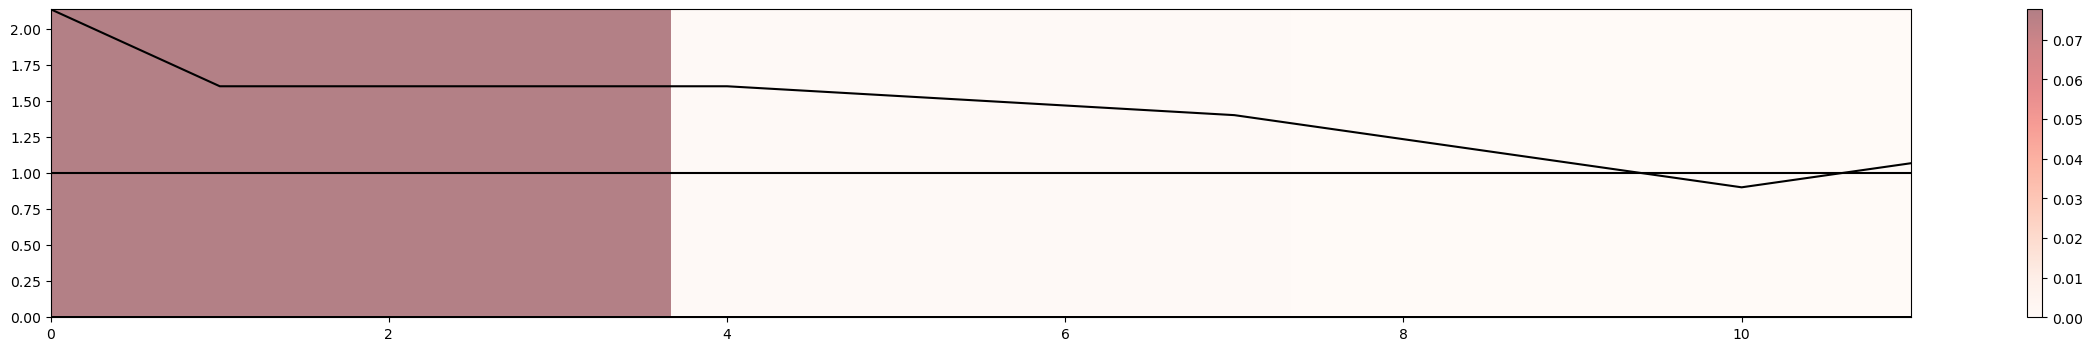

21
1/1 [==============================] - 0s 12ms/step
Model prediction = (2.6845035552978516), True Value = [1.4]
[[ 9.99403259e-04 -5.21615077e-05  5.45442452e-05  9.99999461e-01
   5.71942672e-05  1.31583412e-06  1.70468861e-05 -1.04759796e-04
  -7.68478389e-06 -3.72626632e-05  5.72853951e-05 -2.28760277e-05
   2.23895830e-04  5.17536989e-05  1.60000000e+00]
 [ 1.00984023e-03  7.28852725e-05  2.07173399e-06  9.99999452e-01
   7.95588251e-05 -3.99928807e-06  4.57974735e-05 -1.60376116e-04
  -1.55281228e-05 -1.33343928e-05  2.69406729e-05 -2.66506749e-05
   1.76877629e-04  5.45852336e-05  1.60000000e+00]
 [ 1.21337670e-03 -1.26254421e-04 -3.57854306e-05  9.99999234e-01
   5.18885755e-05 -8.51093568e-06  4.91689332e-05 -1.02923222e-04
  -2.79572485e-05  1.63460667e-05 -9.33754575e-06 -3.52346836e-05
   1.39003440e-04  6.57188353e-05  1.60000000e+00]
 [ 9.40890903e-04 -6.50386020e-06  3.49874797e-05  9.99999518e-01
   1.38655574e-05 -5.19553922e-06 -7.19607065e-05 -2.49154914e-04
  -2.7

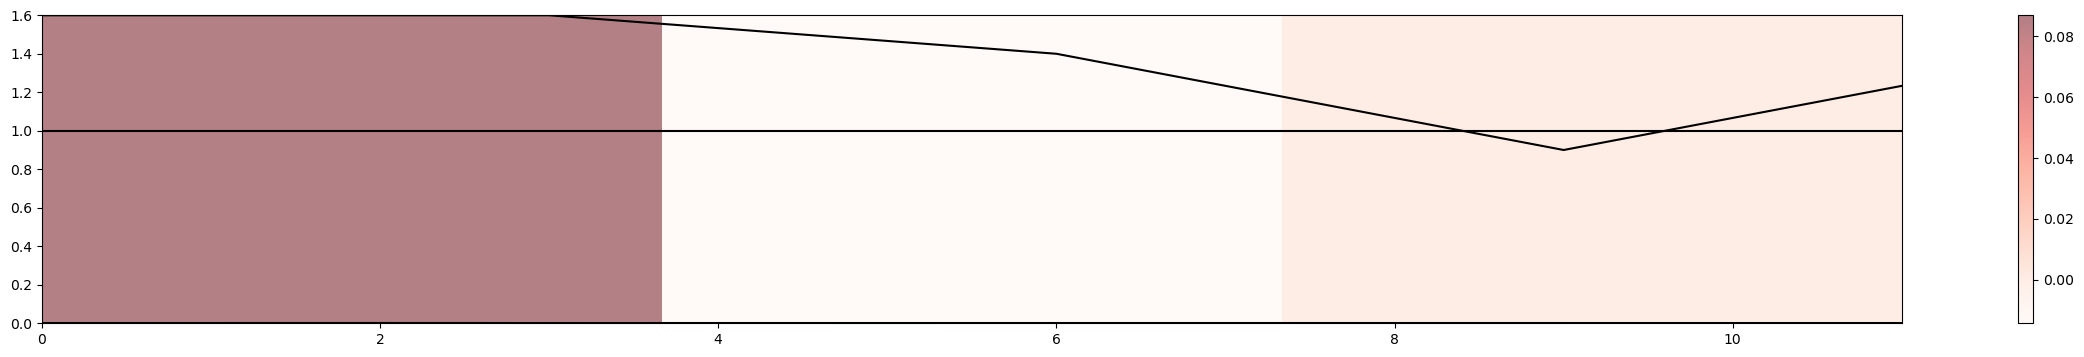

22
1/1 [==============================] - 0s 11ms/step
Model prediction = (2.717155933380127), True Value = [1.36666667]
[[ 1.00984023e-03  7.28852725e-05  2.07173399e-06  9.99999452e-01
   7.95588251e-05 -3.99928807e-06  4.57974735e-05 -1.60376116e-04
  -1.55281228e-05 -1.33343928e-05  2.69406729e-05 -2.66506749e-05
   1.76877629e-04  5.45852336e-05  1.60000000e+00]
 [ 1.21337670e-03 -1.26254421e-04 -3.57854306e-05  9.99999234e-01
   5.18885755e-05 -8.51093568e-06  4.91689332e-05 -1.02923222e-04
  -2.79572485e-05  1.63460667e-05 -9.33754575e-06 -3.52346836e-05
   1.39003440e-04  6.57188353e-05  1.60000000e+00]
 [ 9.40890903e-04 -6.50386020e-06  3.49874797e-05  9.99999518e-01
   1.38655574e-05 -5.19553922e-06 -7.19607065e-05 -2.49154914e-04
  -2.78787684e-05  3.70703138e-05 -3.90828885e-05 -2.85743953e-05
   4.62489520e-05  4.87767287e-05  1.60000000e+00]
 [ 1.03205963e-03 -1.95906638e-05  2.81998735e-05  9.99999441e-01
   8.12170671e-05 -1.03759500e-05  4.52189126e-05 -1.76972496e-04


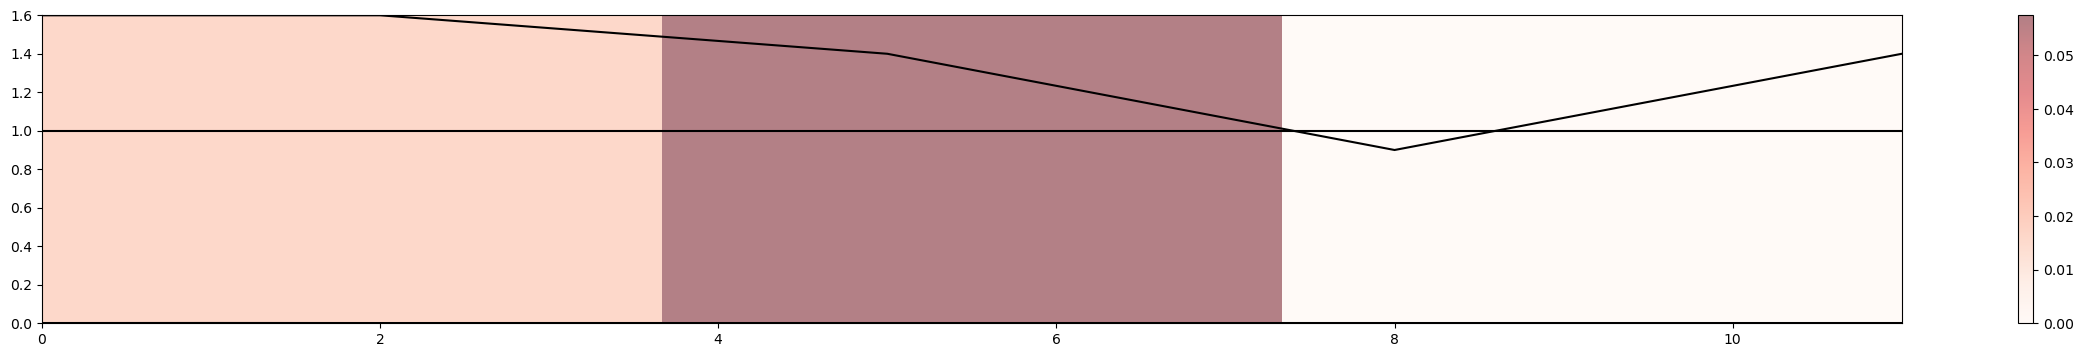

23
1/1 [==============================] - 0s 13ms/step
Model prediction = (3.0522823333740234), True Value = [1.33333333]
[[ 1.21337670e-03 -1.26254421e-04 -3.57854306e-05  9.99999234e-01
   5.18885755e-05 -8.51093568e-06  4.91689332e-05 -1.02923222e-04
  -2.79572485e-05  1.63460667e-05 -9.33754575e-06 -3.52346836e-05
   1.39003440e-04  6.57188353e-05  1.60000000e+00]
 [ 9.40890903e-04 -6.50386020e-06  3.49874797e-05  9.99999518e-01
   1.38655574e-05 -5.19553922e-06 -7.19607065e-05 -2.49154914e-04
  -2.78787684e-05  3.70703138e-05 -3.90828885e-05 -2.85743953e-05
   4.62489520e-05  4.87767287e-05  1.60000000e+00]
 [ 1.03205963e-03 -1.95906638e-05  2.81998735e-05  9.99999441e-01
   8.12170671e-05 -1.03759500e-05  4.52189126e-05 -1.76972496e-04
  -3.49016423e-05  3.56818972e-05 -4.07069648e-05 -3.45768991e-05
   8.68367613e-06  7.72064442e-05  1.53333333e+00]
 [ 9.81391324e-04 -2.31450541e-05 -1.41675302e-05  9.99999460e-01
  -5.84599631e-06  3.85135823e-08 -2.41228207e-05 -3.17972495e-04

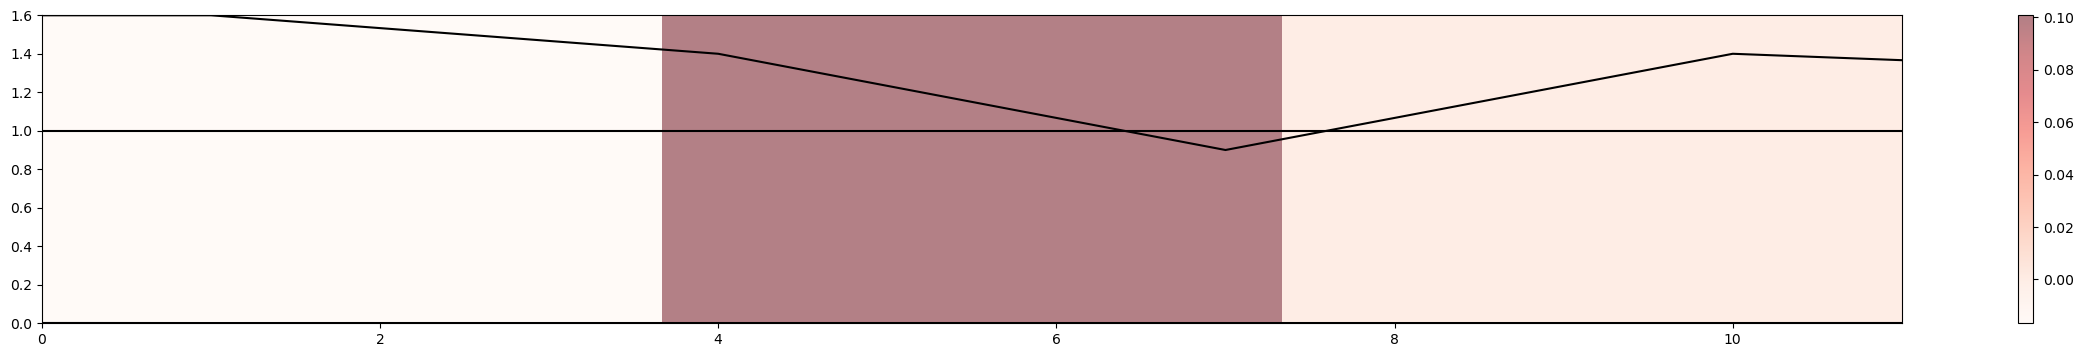

24
1/1 [==============================] - 0s 11ms/step
Model prediction = (3.366678237915039), True Value = [1.3]
[[ 9.40890903e-04 -6.50386020e-06  3.49874797e-05  9.99999518e-01
   1.38655574e-05 -5.19553922e-06 -7.19607065e-05 -2.49154914e-04
  -2.78787684e-05  3.70703138e-05 -3.90828885e-05 -2.85743953e-05
   4.62489520e-05  4.87767287e-05  1.60000000e+00]
 [ 1.03205963e-03 -1.95906638e-05  2.81998735e-05  9.99999441e-01
   8.12170671e-05 -1.03759500e-05  4.52189126e-05 -1.76972496e-04
  -3.49016423e-05  3.56818972e-05 -4.07069648e-05 -3.45768991e-05
   8.68367613e-06  7.72064442e-05  1.53333333e+00]
 [ 9.81391324e-04 -2.31450541e-05 -1.41675302e-05  9.99999460e-01
  -5.84599631e-06  3.85135823e-08 -2.41228207e-05 -3.17972495e-04
  -3.51989659e-05  2.67214312e-05 -3.39532637e-05 -3.38388380e-05
  -3.37489557e-05  9.18060868e-05  1.46666667e+00]
 [ 1.04148991e-03 -9.66816906e-05 -2.11563615e-05  9.99999382e-01
  -5.30014694e-05  1.30184078e-05 -3.24677160e-05 -3.35807076e-04
  -3.94

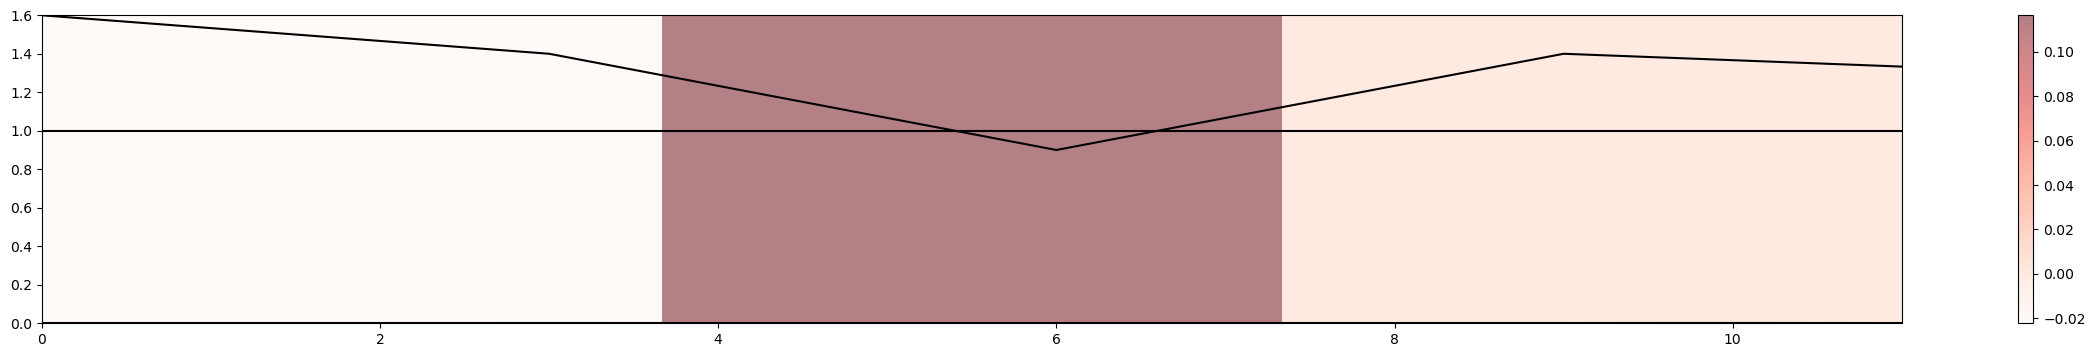

25
1/1 [==============================] - 0s 11ms/step
Model prediction = (3.4811437129974365), True Value = [-3.1]
[[ 1.03205963e-03 -1.95906638e-05  2.81998735e-05  9.99999441e-01
   8.12170671e-05 -1.03759500e-05  4.52189126e-05 -1.76972496e-04
  -3.49016423e-05  3.56818972e-05 -4.07069648e-05 -3.45768991e-05
   8.68367613e-06  7.72064442e-05  1.53333333e+00]
 [ 9.81391324e-04 -2.31450541e-05 -1.41675302e-05  9.99999460e-01
  -5.84599631e-06  3.85135823e-08 -2.41228207e-05 -3.17972495e-04
  -3.51989659e-05  2.67214312e-05 -3.39532637e-05 -3.38388380e-05
  -3.37489557e-05  9.18060868e-05  1.46666667e+00]
 [ 1.04148991e-03 -9.66816906e-05 -2.11563615e-05  9.99999382e-01
  -5.30014694e-05  1.30184078e-05 -3.24677160e-05 -3.35807076e-04
  -3.94865032e-05  2.09760010e-05 -3.11910009e-05 -3.69575192e-05
  -7.91547206e-05  1.16533339e-04  1.40000000e+00]
 [ 9.85552109e-04 -1.62447924e-05  3.17232754e-05  9.99999472e-01
  -6.38261331e-05 -2.36191524e-06  4.60842405e-05 -2.36566451e-04
  -3.

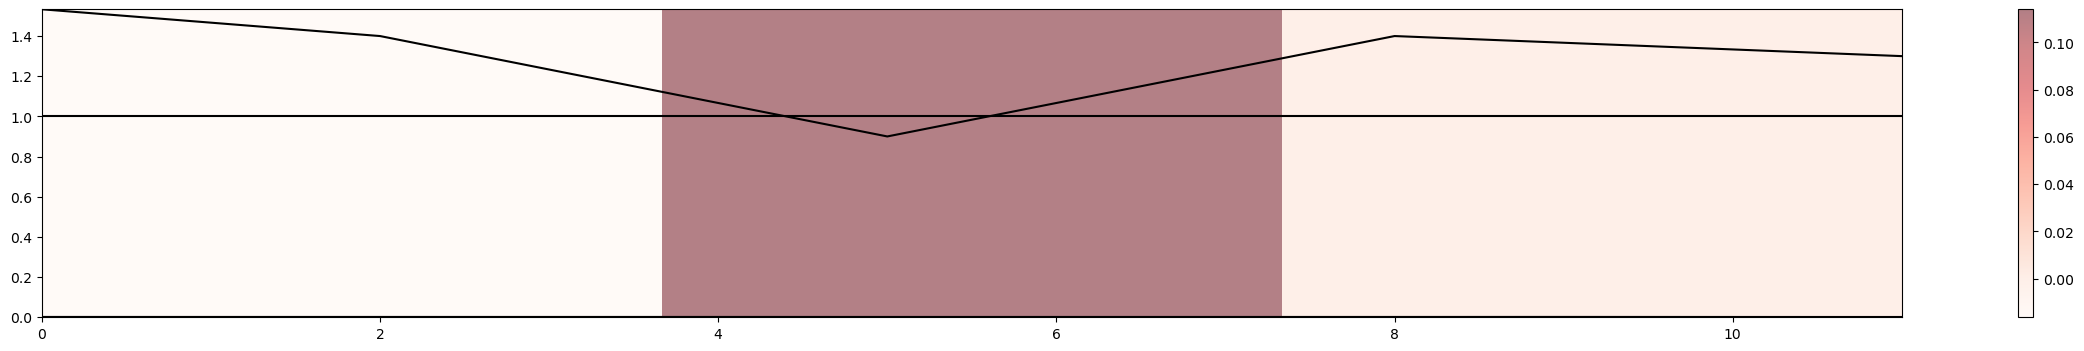

26
1/1 [==============================] - 0s 11ms/step
Model prediction = (3.652029514312744), True Value = [-7.5]
[[ 9.81391324e-04 -2.31450541e-05 -1.41675302e-05  9.99999460e-01
  -5.84599631e-06  3.85135823e-08 -2.41228207e-05 -3.17972495e-04
  -3.51989659e-05  2.67214312e-05 -3.39532637e-05 -3.38388380e-05
  -3.37489557e-05  9.18060868e-05  1.46666667e+00]
 [ 1.04148991e-03 -9.66816906e-05 -2.11563615e-05  9.99999382e-01
  -5.30014694e-05  1.30184078e-05 -3.24677160e-05 -3.35807076e-04
  -3.94865032e-05  2.09760010e-05 -3.11910009e-05 -3.69575192e-05
  -7.91547206e-05  1.16533339e-04  1.40000000e+00]
 [ 9.85552109e-04 -1.62447924e-05  3.17232754e-05  9.99999472e-01
  -6.38261331e-05 -2.36191524e-06  4.60842405e-05 -2.36566451e-04
  -3.28919112e-05  1.62585678e-05 -2.01383128e-05 -3.21637658e-05
  -1.02507147e-04  8.93745833e-05  1.23333333e+00]
 [ 1.03702034e-03 -4.11398414e-05 -7.06880802e-06  9.99999412e-01
  -6.31960252e-05  1.63783440e-05 -7.19000226e-05 -2.55577225e-04
  -2.9

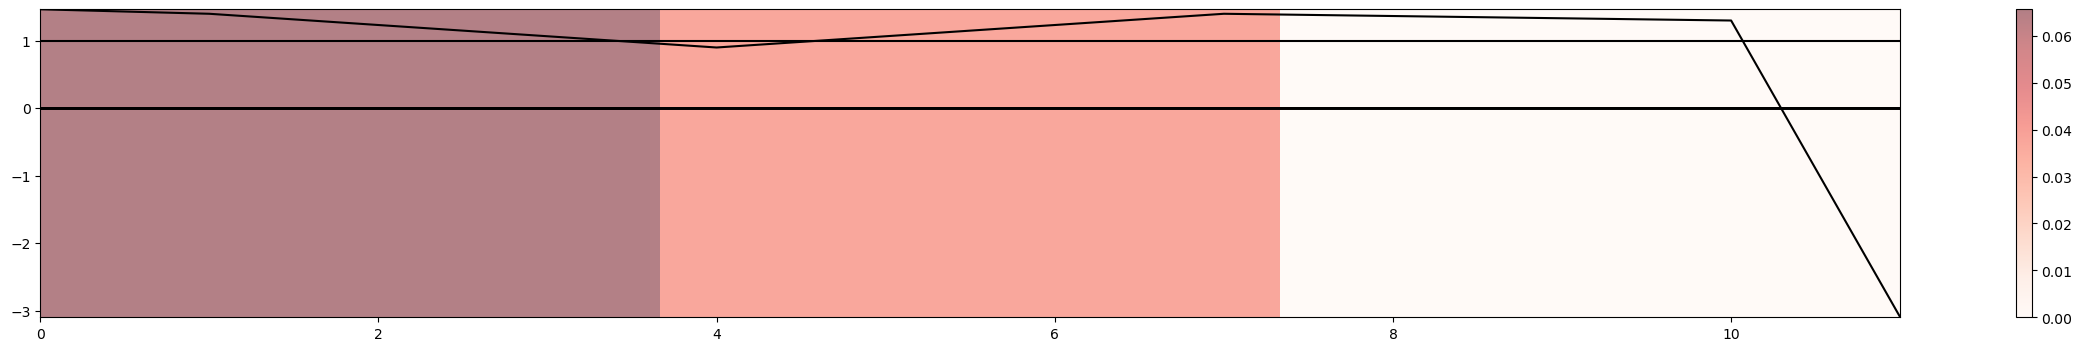

27
1/1 [==============================] - 0s 10ms/step
Model prediction = (3.719561815261841), True Value = [-11.9]
[[ 1.04148991e-03 -9.66816906e-05 -2.11563615e-05  9.99999382e-01
  -5.30014694e-05  1.30184078e-05 -3.24677160e-05 -3.35807076e-04
  -3.94865032e-05  2.09760010e-05 -3.11910009e-05 -3.69575192e-05
  -7.91547206e-05  1.16533339e-04  1.40000000e+00]
 [ 9.85552109e-04 -1.62447924e-05  3.17232754e-05  9.99999472e-01
  -6.38261331e-05 -2.36191524e-06  4.60842405e-05 -2.36566451e-04
  -3.28919112e-05  1.62585678e-05 -2.01383128e-05 -3.21637658e-05
  -1.02507147e-04  8.93745833e-05  1.23333333e+00]
 [ 1.03702034e-03 -4.11398414e-05 -7.06880802e-06  9.99999412e-01
  -6.31960252e-05  1.63783440e-05 -7.19000226e-05 -2.55577225e-04
  -2.94052905e-05  1.31629963e-05 -1.14003612e-05 -3.03120243e-05
  -1.32967881e-04  7.12033426e-05  1.06666667e+00]
 [ 9.85197980e-04 -2.74598064e-05  3.41415640e-05  9.99999469e-01
  -4.66466336e-05  1.70547163e-05 -1.38763496e-05 -2.40742253e-04
  -2.

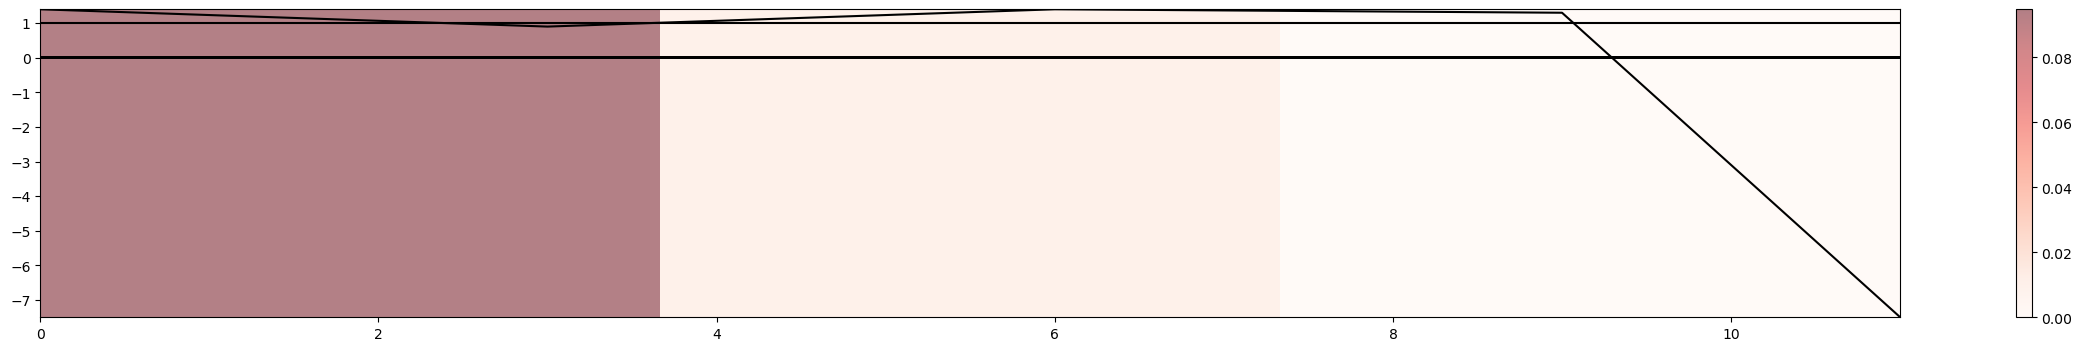

28
1/1 [==============================] - 0s 10ms/step
Model prediction = (1.9103660583496094), True Value = [-9.36666667]
[[ 9.85552109e-04 -1.62447924e-05  3.17232754e-05  9.99999472e-01
  -6.38261331e-05 -2.36191524e-06  4.60842405e-05 -2.36566451e-04
  -3.28919112e-05  1.62585678e-05 -2.01383128e-05 -3.21637658e-05
  -1.02507147e-04  8.93745833e-05  1.23333333e+00]
 [ 1.03702034e-03 -4.11398414e-05 -7.06880802e-06  9.99999412e-01
  -6.31960252e-05  1.63783440e-05 -7.19000226e-05 -2.55577225e-04
  -2.94052905e-05  1.31629963e-05 -1.14003612e-05 -3.03120243e-05
  -1.32967881e-04  7.12033426e-05  1.06666667e+00]
 [ 9.85197980e-04 -2.74598064e-05  3.41415640e-05  9.99999469e-01
  -4.66466336e-05  1.70547163e-05 -1.38763496e-05 -2.40742253e-04
  -2.51266779e-05  9.71864006e-06 -2.38299307e-06 -2.76373498e-05
  -1.59674339e-04  5.11507371e-05  9.00000000e-01]
 [ 9.80510437e-04 -4.56186265e-05  2.47541169e-05  9.99999487e-01
  -9.86903451e-05  1.76454938e-05  3.76661438e-05 -1.57717807e-0

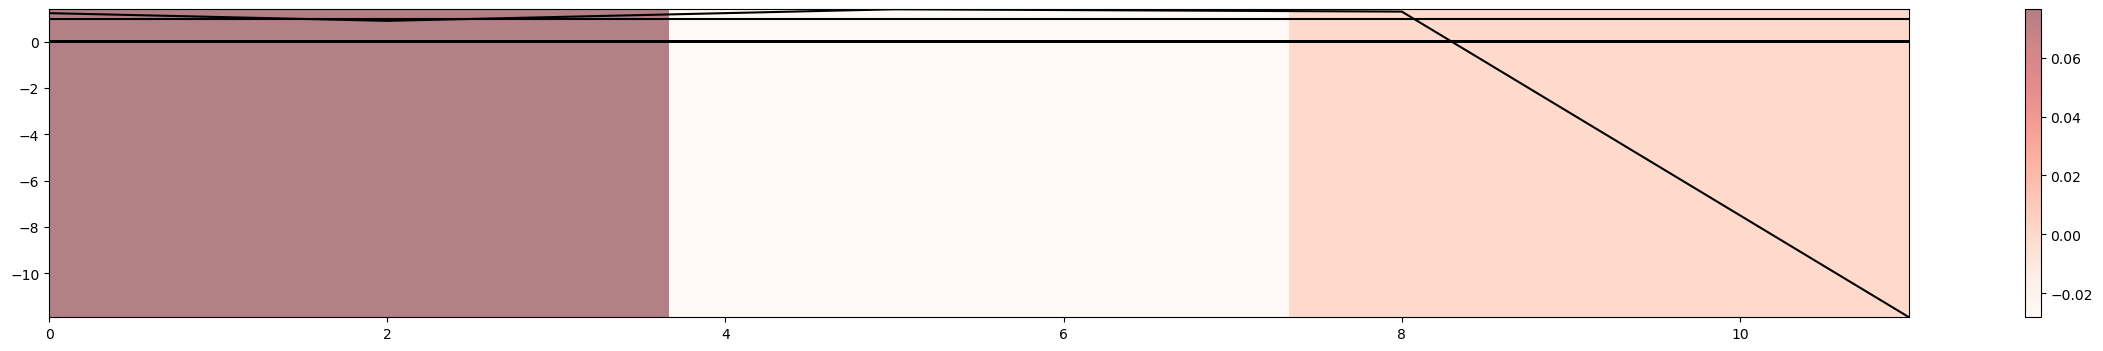

29
1/1 [==============================] - 0s 14ms/step
Model prediction = (-2.1559336185455322), True Value = [-6.83333333]
[[ 1.03702034e-03 -4.11398414e-05 -7.06880802e-06  9.99999412e-01
  -6.31960252e-05  1.63783440e-05 -7.19000226e-05 -2.55577225e-04
  -2.94052905e-05  1.31629963e-05 -1.14003612e-05 -3.03120243e-05
  -1.32967881e-04  7.12033426e-05  1.06666667e+00]
 [ 9.85197980e-04 -2.74598064e-05  3.41415640e-05  9.99999469e-01
  -4.66466336e-05  1.70547163e-05 -1.38763496e-05 -2.40742253e-04
  -2.51266779e-05  9.71864006e-06 -2.38299307e-06 -2.76373498e-05
  -1.59674339e-04  5.11507371e-05  9.00000000e-01]
 [ 9.80510437e-04 -4.56186265e-05  2.47541169e-05  9.99999487e-01
  -9.86903451e-05  1.76454938e-05  3.76661438e-05 -1.57717807e-04
  -2.74908098e-05  0.00000000e+00 -2.10732941e-05 -9.78010302e-06
  -1.48341464e-04  5.05290386e-05  1.06666667e+00]
 [ 9.71899204e-04 -5.45190402e-05  7.96700790e-05  9.99999477e-01
  -5.52303880e-05  4.09455524e-05 -1.16853521e-04 -2.21053178e-

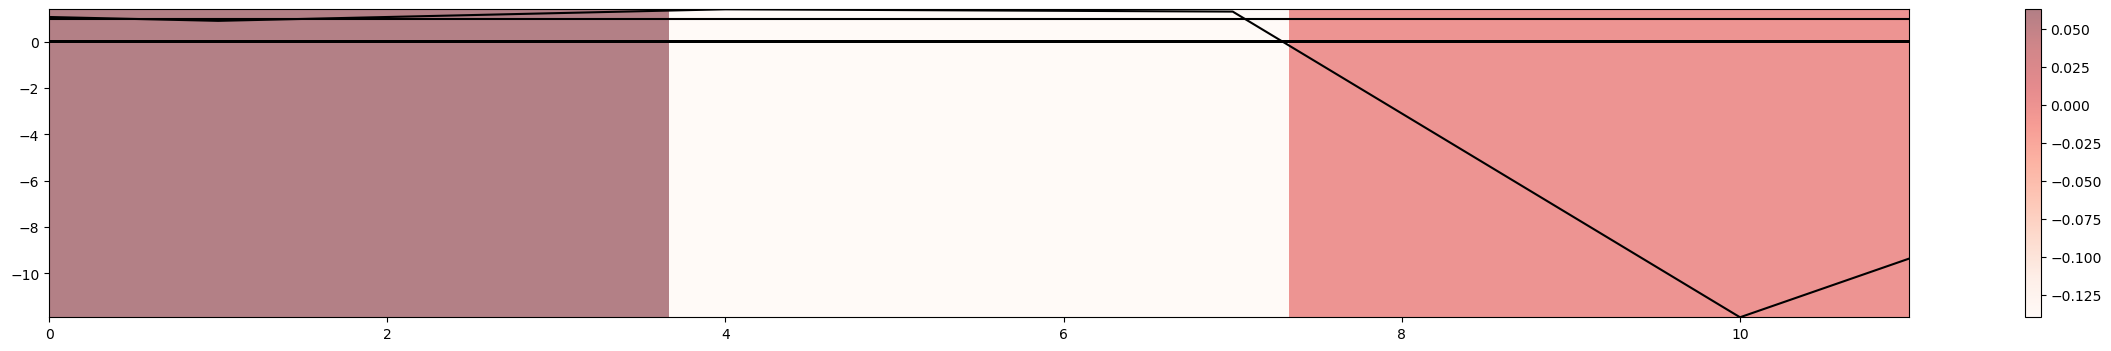

30
1/1 [==============================] - 0s 10ms/step
Model prediction = (-6.692807674407959), True Value = [-4.3]
[[ 9.85197980e-04 -2.74598064e-05  3.41415640e-05  9.99999469e-01
  -4.66466336e-05  1.70547163e-05 -1.38763496e-05 -2.40742253e-04
  -2.51266779e-05  9.71864006e-06 -2.38299307e-06 -2.76373498e-05
  -1.59674339e-04  5.11507371e-05  9.00000000e-01]
 [ 9.80510437e-04 -4.56186265e-05  2.47541169e-05  9.99999487e-01
  -9.86903451e-05  1.76454938e-05  3.76661438e-05 -1.57717807e-04
  -2.74908098e-05  0.00000000e+00 -2.10732941e-05 -9.78010302e-06
  -1.48341464e-04  5.05290386e-05  1.06666667e+00]
 [ 9.71899204e-04 -5.45190402e-05  7.96700790e-05  9.99999477e-01
  -5.52303880e-05  4.09455524e-05 -1.16853521e-04 -2.21053178e-04
  -2.98236222e-05 -9.49333546e-06 -3.93483075e-05  7.65480815e-06
  -1.37398054e-04  4.99649235e-05  1.23333333e+00]
 [ 1.00995073e-03 -4.10966085e-05  3.88823616e-05  9.99999455e-01
  -2.18265164e-05  3.42800805e-05 -3.52135976e-05 -2.00351251e-04
  -3.

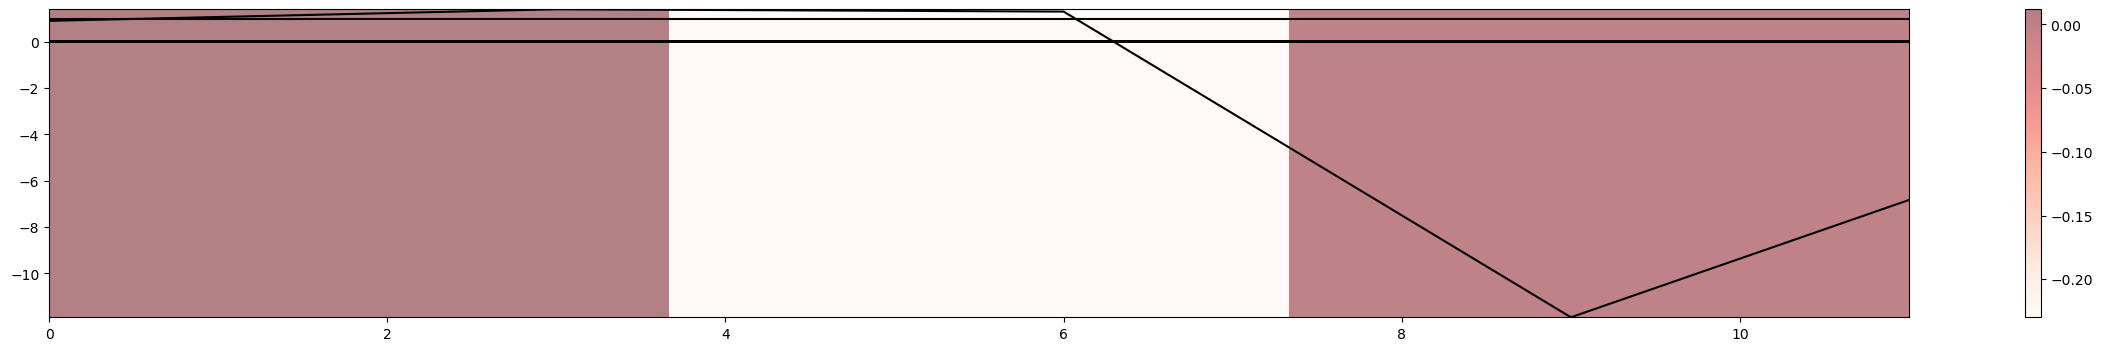

31
1/1 [==============================] - 0s 11ms/step
Model prediction = (-6.040879249572754), True Value = [-3.06666667]
[[ 9.80510437e-04 -4.56186265e-05  2.47541169e-05  9.99999487e-01
  -9.86903451e-05  1.76454938e-05  3.76661438e-05 -1.57717807e-04
  -2.74908098e-05  0.00000000e+00 -2.10732941e-05 -9.78010302e-06
  -1.48341464e-04  5.05290386e-05  1.06666667e+00]
 [ 9.71899204e-04 -5.45190402e-05  7.96700790e-05  9.99999477e-01
  -5.52303880e-05  4.09455524e-05 -1.16853521e-04 -2.21053178e-04
  -2.98236222e-05 -9.49333546e-06 -3.93483075e-05  7.65480815e-06
  -1.37398054e-04  4.99649235e-05  1.23333333e+00]
 [ 1.00995073e-03 -4.10966085e-05  3.88823616e-05  9.99999455e-01
  -2.18265164e-05  3.42800805e-05 -3.52135976e-05 -2.00351251e-04
  -3.22247282e-05 -1.88471113e-05 -5.74333031e-05  2.47969156e-05
  -1.27169090e-04  4.95976613e-05  1.40000000e+00]
 [ 1.14114724e-03 -6.91458316e-05  6.51243508e-05  9.99999291e-01
  -9.56407438e-06  5.60516137e-05  3.92497776e-05 -1.38282840e-0

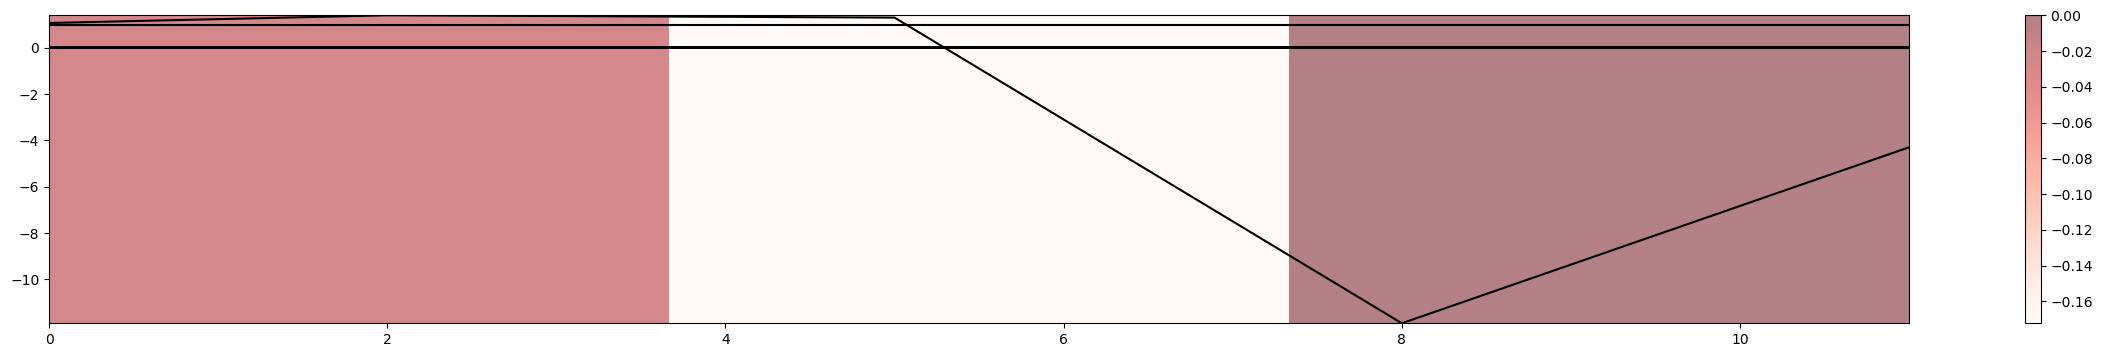

32
1/1 [==============================] - 0s 31ms/step
Model prediction = (-1.7972412109375), True Value = [-1.83333333]
[[ 9.71899204e-04 -5.45190402e-05  7.96700790e-05  9.99999477e-01
  -5.52303880e-05  4.09455524e-05 -1.16853521e-04 -2.21053178e-04
  -2.98236222e-05 -9.49333546e-06 -3.93483075e-05  7.65480815e-06
  -1.37398054e-04  4.99649235e-05  1.23333333e+00]
 [ 1.00995073e-03 -4.10966085e-05  3.88823616e-05  9.99999455e-01
  -2.18265164e-05  3.42800805e-05 -3.52135976e-05 -2.00351251e-04
  -3.22247282e-05 -1.88471113e-05 -5.74333031e-05  2.47969156e-05
  -1.27169090e-04  4.95976613e-05  1.40000000e+00]
 [ 1.14114724e-03 -6.91458316e-05  6.51243508e-05  9.99999291e-01
  -9.56407438e-06  5.60516137e-05  3.92497776e-05 -1.38282840e-04
  -3.89370248e-05 -2.19972667e-04 -2.94958019e-05  2.05357412e-05
  -1.62565481e-04  7.28262649e-05  1.36666667e+00]
 [ 8.85209372e-04 -1.12500900e-04  6.19584225e-05  9.99999481e-01
   1.01104739e-04  7.38845125e-05 -5.63539435e-06  2.72878045e-05


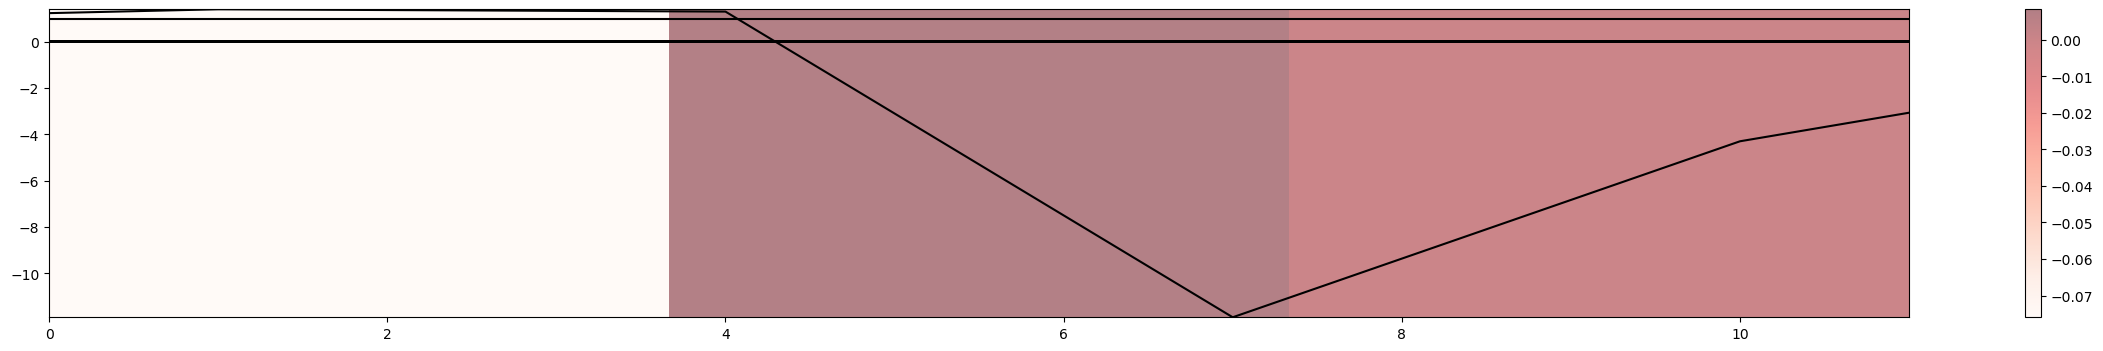

33
1/1 [==============================] - 0s 12ms/step
Model prediction = (2.605370283126831), True Value = [-0.6]
[[ 1.00995073e-03 -4.10966085e-05  3.88823616e-05  9.99999455e-01
  -2.18265164e-05  3.42800805e-05 -3.52135976e-05 -2.00351251e-04
  -3.22247282e-05 -1.88471113e-05 -5.74333031e-05  2.47969156e-05
  -1.27169090e-04  4.95976613e-05  1.40000000e+00]
 [ 1.14114724e-03 -6.91458316e-05  6.51243508e-05  9.99999291e-01
  -9.56407438e-06  5.60516137e-05  3.92497776e-05 -1.38282840e-04
  -3.89370248e-05 -2.19972667e-04 -2.94958019e-05  2.05357412e-05
  -1.62565481e-04  7.28262649e-05  1.36666667e+00]
 [ 8.85209372e-04 -1.12500900e-04  6.19584225e-05  9.99999481e-01
   1.01104739e-04  7.38845125e-05 -5.63539435e-06  2.72878045e-05
  -4.18241350e-05 -4.22167145e-04  5.92818238e-06  1.31730516e-05
  -1.83015801e-04  9.03836885e-05  1.33333333e+00]
 [ 7.80826996e-04 -1.51658146e-04  1.07881912e-05  9.99999459e-01
   2.31268310e-06  1.09383800e-04  2.15995596e-04  5.84614029e-05
  -4.1

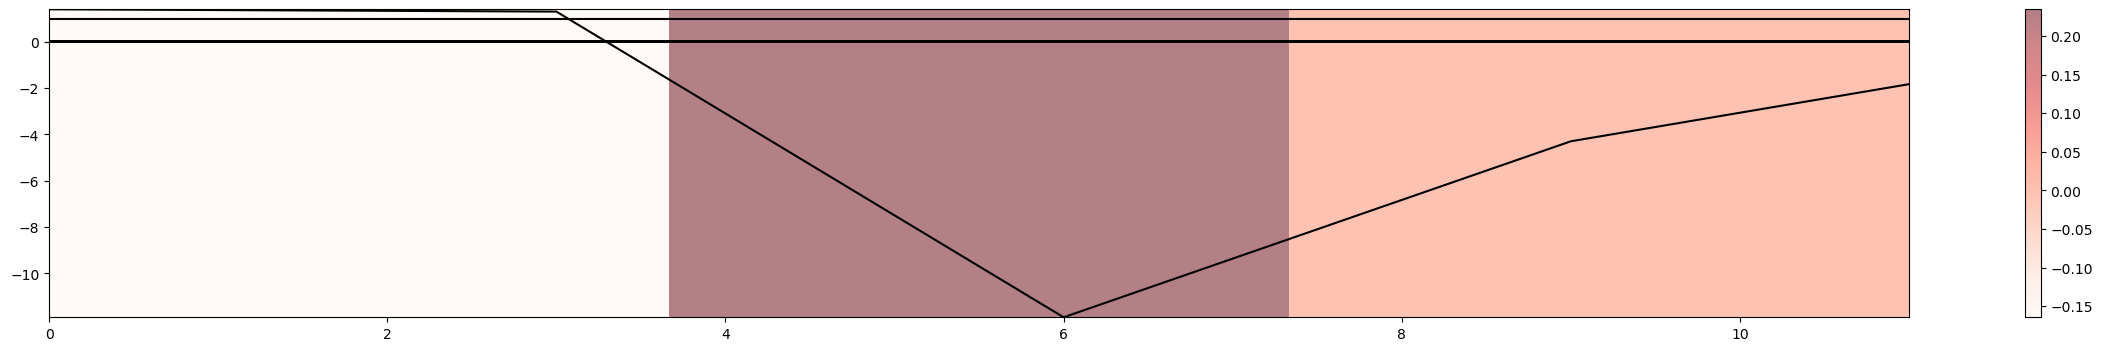

34
1/1 [==============================] - 0s 12ms/step
Model prediction = (4.231689453125), True Value = [0.9]
[[ 1.14114724e-03 -6.91458316e-05  6.51243508e-05  9.99999291e-01
  -9.56407438e-06  5.60516137e-05  3.92497776e-05 -1.38282840e-04
  -3.89370248e-05 -2.19972667e-04 -2.94958019e-05  2.05357412e-05
  -1.62565481e-04  7.28262649e-05  1.36666667e+00]
 [ 8.85209372e-04 -1.12500900e-04  6.19584225e-05  9.99999481e-01
   1.01104739e-04  7.38845125e-05 -5.63539435e-06  2.72878045e-05
  -4.18241350e-05 -4.22167145e-04  5.92818238e-06  1.31730516e-05
  -1.83015801e-04  9.03836885e-05  1.33333333e+00]
 [ 7.80826996e-04 -1.51658146e-04  1.07881912e-05  9.99999459e-01
   2.31268310e-06  1.09383800e-04  2.15995596e-04  5.84614029e-05
  -4.15148538e-05 -5.82264696e-04  3.89095384e-05  5.27364086e-06
  -1.89035062e-04  1.00390465e-04  1.30000000e+00]
 [ 6.16187584e-04 -5.46306939e-04 -6.58229617e-05  9.99999342e-01
  -1.73828863e-04  2.10302986e-04  1.59210971e-04 -7.99028005e-06
  -5.38224

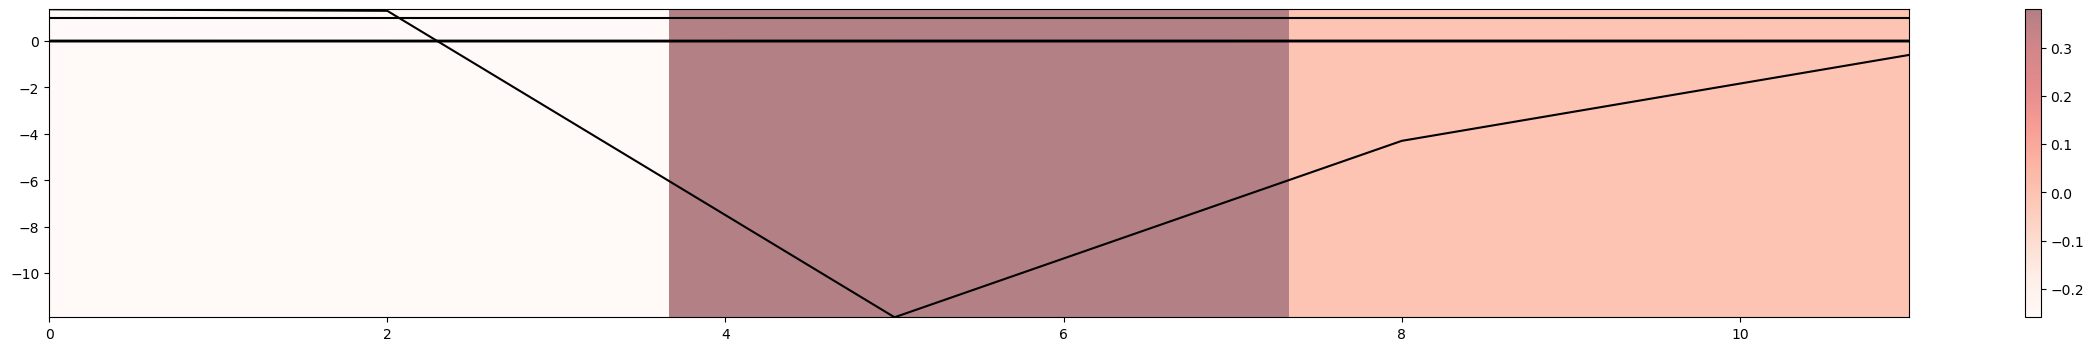

35
1/1 [==============================] - 0s 18ms/step
Model prediction = (4.891141414642334), True Value = [2.4]
[[ 8.85209372e-04 -1.12500900e-04  6.19584225e-05  9.99999481e-01
   1.01104739e-04  7.38845125e-05 -5.63539435e-06  2.72878045e-05
  -4.18241350e-05 -4.22167145e-04  5.92818238e-06  1.31730516e-05
  -1.83015801e-04  9.03836885e-05  1.33333333e+00]
 [ 7.80826996e-04 -1.51658146e-04  1.07881912e-05  9.99999459e-01
   2.31268310e-06  1.09383800e-04  2.15995596e-04  5.84614029e-05
  -4.15148538e-05 -5.82264696e-04  3.89095384e-05  5.27364086e-06
  -1.89035062e-04  1.00390465e-04  1.30000000e+00]
 [ 6.16187584e-04 -5.46306939e-04 -6.58229617e-05  9.99999342e-01
  -1.73828863e-04  2.10302986e-04  1.59210971e-04 -7.99028005e-06
  -5.38224915e-05 -6.49427678e-04 -1.91943352e-05  2.01101653e-05
  -2.57357389e-04  2.06167517e-04 -3.10000000e+00]
 [ 6.01232598e-04 -6.50196934e-04 -1.31156970e-04  9.99999301e-01
  -3.25897568e-04  2.64417907e-04 -9.77452090e-05  1.48019192e-04
  -4.95

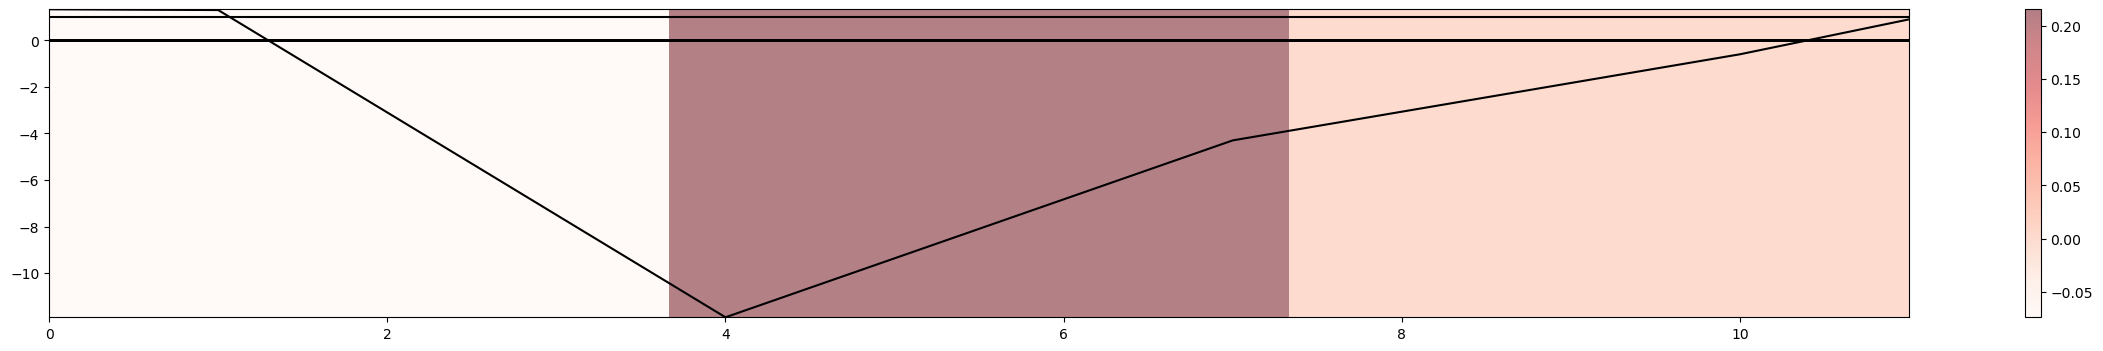

36
1/1 [==============================] - 0s 12ms/step
Model prediction = (7.335062026977539), True Value = [3.9]
[[ 7.80826996e-04 -1.51658146e-04  1.07881912e-05  9.99999459e-01
   2.31268310e-06  1.09383800e-04  2.15995596e-04  5.84614029e-05
  -4.15148538e-05 -5.82264696e-04  3.89095384e-05  5.27364086e-06
  -1.89035062e-04  1.00390465e-04  1.30000000e+00]
 [ 6.16187584e-04 -5.46306939e-04 -6.58229617e-05  9.99999342e-01
  -1.73828863e-04  2.10302986e-04  1.59210971e-04 -7.99028005e-06
  -5.38224915e-05 -6.49427678e-04 -1.91943352e-05  2.01101653e-05
  -2.57357389e-04  2.06167517e-04 -3.10000000e+00]
 [ 6.01232598e-04 -6.50196934e-04 -1.31156970e-04  9.99999301e-01
  -3.25897568e-04  2.64417907e-04 -9.77452090e-05  1.48019192e-04
  -4.95517361e-05 -4.97184344e-04 -8.41768594e-05  3.11902785e-05
  -2.48664122e-04  2.62402848e-04 -7.50000000e+00]
 [ 6.83014719e-04 -3.40928669e-04 -3.59413374e-05  9.99999457e-01
  -1.19415646e-04  2.82852662e-04 -7.30174642e-05  2.67963246e-04
  -4.71

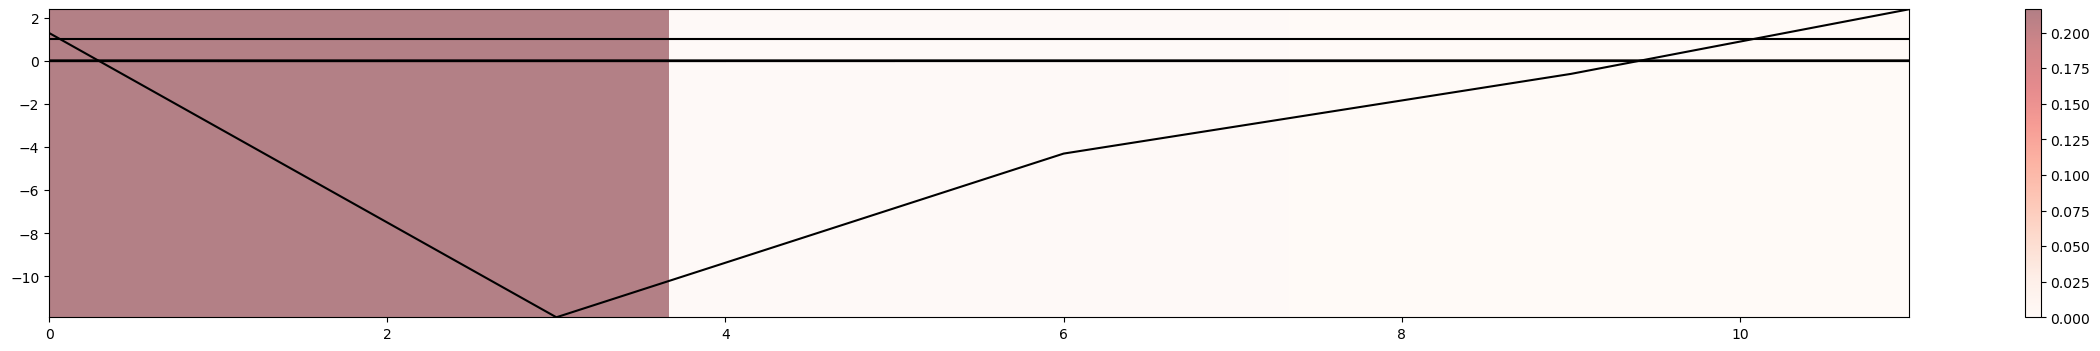

37
1/1 [==============================] - 0s 13ms/step
Model prediction = (6.541470527648926), True Value = [8.36666667]
[[ 6.16187584e-04 -5.46306939e-04 -6.58229617e-05  9.99999342e-01
  -1.73828863e-04  2.10302986e-04  1.59210971e-04 -7.99028005e-06
  -5.38224915e-05 -6.49427678e-04 -1.91943352e-05  2.01101653e-05
  -2.57357389e-04  2.06167517e-04 -3.10000000e+00]
 [ 6.01232598e-04 -6.50196934e-04 -1.31156970e-04  9.99999301e-01
  -3.25897568e-04  2.64417907e-04 -9.77452090e-05  1.48019192e-04
  -4.95517361e-05 -4.97184344e-04 -8.41768594e-05  3.11902785e-05
  -2.48664122e-04  2.62402848e-04 -7.50000000e+00]
 [ 6.83014719e-04 -3.40928669e-04 -3.59413374e-05  9.99999457e-01
  -1.19415646e-04  2.82852662e-04 -7.30174642e-05  2.67963246e-04
  -4.71902297e-05 -3.73930777e-04 -1.45909459e-04  4.22345571e-05
  -2.48406944e-04  3.21660883e-04 -1.19000000e+01]
 [ 8.75036699e-04 -1.07847251e-04 -7.75799756e-05  9.99999391e-01
  -1.14108001e-04  3.22300132e-04 -8.18238416e-05  2.42400150e-05


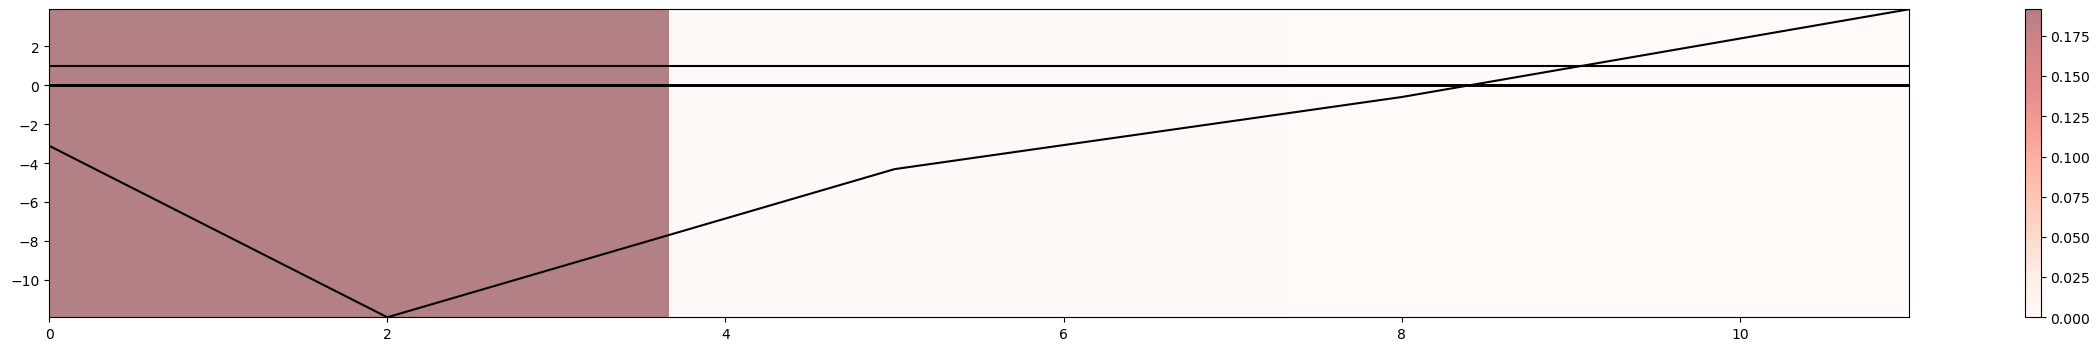

38
1/1 [==============================] - 0s 11ms/step
Model prediction = (7.964998722076416), True Value = [12.83333333]
[[ 6.01232598e-04 -6.50196934e-04 -1.31156970e-04  9.99999301e-01
  -3.25897568e-04  2.64417907e-04 -9.77452090e-05  1.48019192e-04
  -4.95517361e-05 -4.97184344e-04 -8.41768594e-05  3.11902785e-05
  -2.48664122e-04  2.62402848e-04 -7.50000000e+00]
 [ 6.83014719e-04 -3.40928669e-04 -3.59413374e-05  9.99999457e-01
  -1.19415646e-04  2.82852662e-04 -7.30174642e-05  2.67963246e-04
  -4.71902297e-05 -3.73930777e-04 -1.45909459e-04  4.22345571e-05
  -2.48406944e-04  3.21660883e-04 -1.19000000e+01]
 [ 8.75036699e-04 -1.07847251e-04 -7.75799756e-05  9.99999391e-01
  -1.14108001e-04  3.22300132e-04 -8.18238416e-05  2.42400150e-05
  -2.40876617e-05 -2.55851985e-04 -1.79189501e-04  3.18827411e-05
  -1.54394225e-04  4.32784452e-04 -9.36666667e+00]
 [ 8.92926757e-04 -8.02406974e-05  1.52221224e-05  9.99999318e-01
  -1.28436705e-04  3.13454682e-04  1.90444787e-04  6.64976266e-05

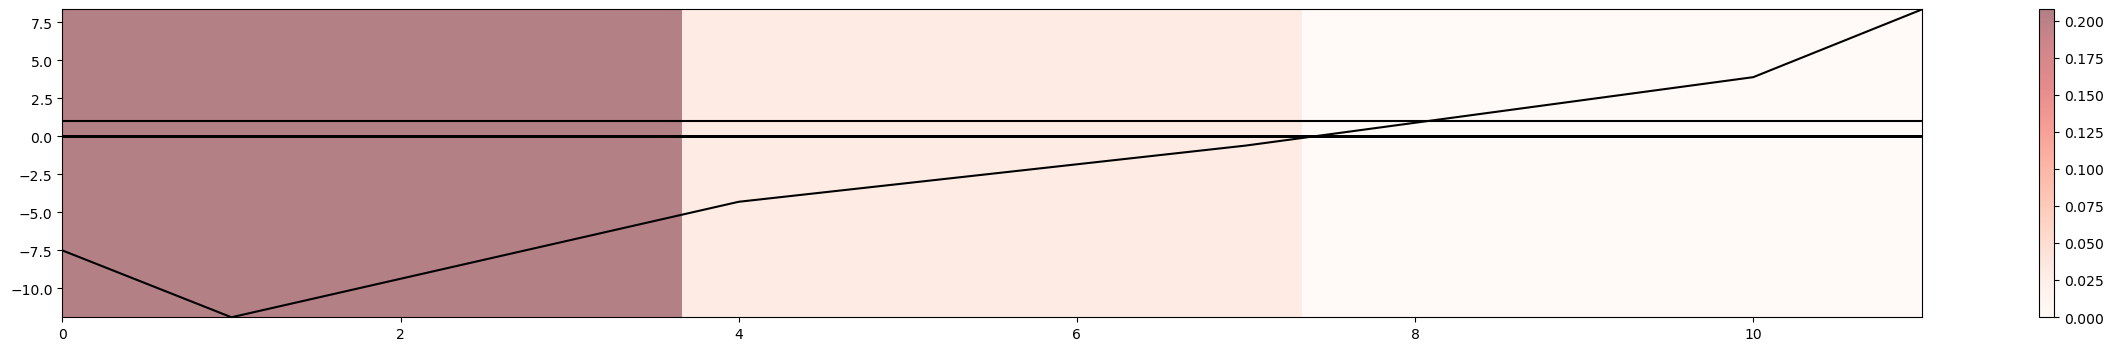

39
1/1 [==============================] - 0s 11ms/step
Model prediction = (8.165895462036133), True Value = [17.3]
[[ 6.83014719e-04 -3.40928669e-04 -3.59413374e-05  9.99999457e-01
  -1.19415646e-04  2.82852662e-04 -7.30174642e-05  2.67963246e-04
  -4.71902297e-05 -3.73930777e-04 -1.45909459e-04  4.22345571e-05
  -2.48406944e-04  3.21660883e-04 -1.19000000e+01]
 [ 8.75036699e-04 -1.07847251e-04 -7.75799756e-05  9.99999391e-01
  -1.14108001e-04  3.22300132e-04 -8.18238416e-05  2.42400150e-05
  -2.40876617e-05 -2.55851985e-04 -1.79189501e-04  3.18827411e-05
  -1.54394225e-04  4.32784452e-04 -9.36666667e+00]
 [ 8.92926757e-04 -8.02406974e-05  1.52221224e-05  9.99999318e-01
  -1.28436705e-04  3.13454682e-04  1.90444787e-04  6.64976266e-05
  -3.40906557e-06 -1.59005216e-04 -2.23226846e-04  2.40220303e-05
  -7.40010458e-05  5.68799148e-04 -6.83333333e+00]
 [ 8.11155985e-04 -1.24037049e-04  4.07751381e-05  9.99999289e-01
  -1.82428254e-05  3.14619021e-04  2.87502581e-04  2.36841116e-04
   1.6

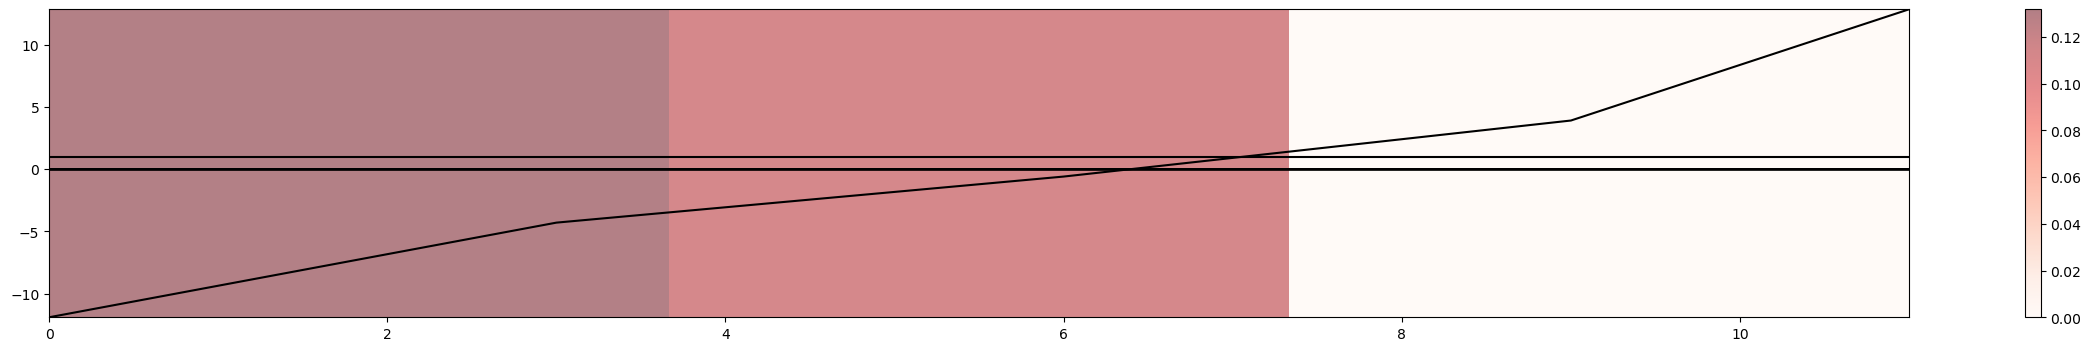

40
1/1 [==============================] - 0s 11ms/step
Model prediction = (11.010708808898926), True Value = [14.43333333]
[[ 8.75036699e-04 -1.07847251e-04 -7.75799756e-05  9.99999391e-01
  -1.14108001e-04  3.22300132e-04 -8.18238416e-05  2.42400150e-05
  -2.40876617e-05 -2.55851985e-04 -1.79189501e-04  3.18827411e-05
  -1.54394225e-04  4.32784452e-04 -9.36666667e+00]
 [ 8.92926757e-04 -8.02406974e-05  1.52221224e-05  9.99999318e-01
  -1.28436705e-04  3.13454682e-04  1.90444787e-04  6.64976266e-05
  -3.40906557e-06 -1.59005216e-04 -2.23226846e-04  2.40220303e-05
  -7.40010458e-05  5.68799148e-04 -6.83333333e+00]
 [ 8.11155985e-04 -1.24037049e-04  4.07751381e-05  9.99999289e-01
  -1.82428254e-05  3.14619021e-04  2.87502581e-04  2.36841116e-04
   1.68122939e-05 -5.54280316e-05 -2.51994748e-04  1.49255684e-05
   8.38231101e-06  6.65136379e-04 -4.30000000e+00]
 [ 8.37749953e-04 -9.86541113e-05  1.41845114e-06  9.99999390e-01
  -1.03677351e-04  3.53135826e-04 -4.57106744e-06 -5.29924351e-0

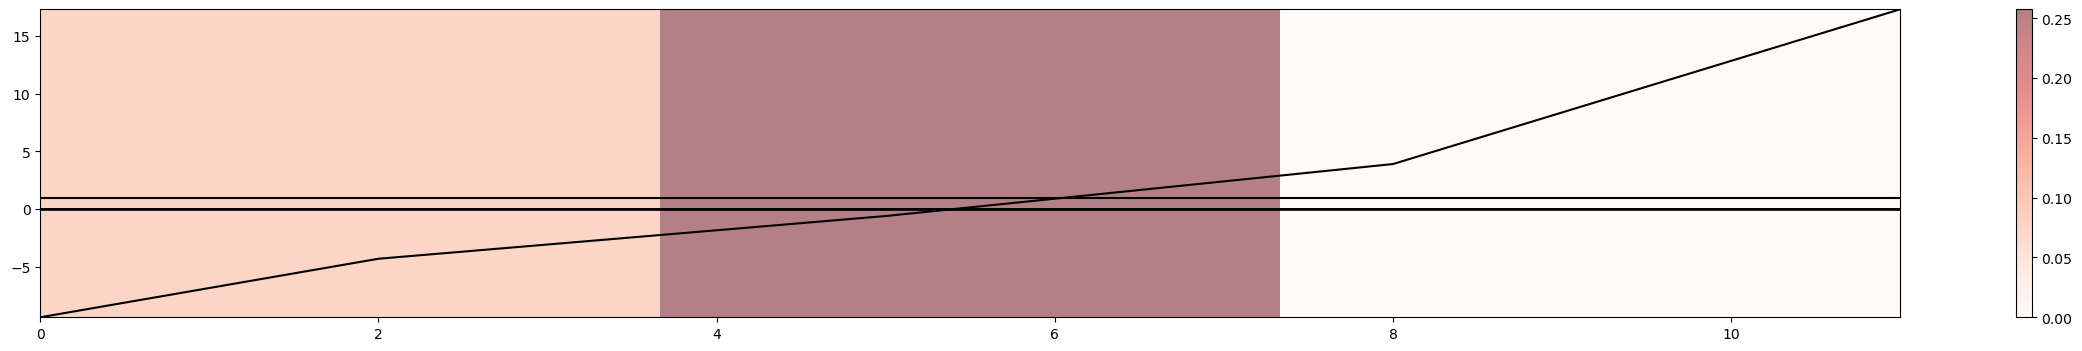

41
1/1 [==============================] - 0s 16ms/step
Model prediction = (14.018106460571289), True Value = [11.56666667]
[[ 8.92926757e-04 -8.02406974e-05  1.52221224e-05  9.99999318e-01
  -1.28436705e-04  3.13454682e-04  1.90444787e-04  6.64976266e-05
  -3.40906557e-06 -1.59005216e-04 -2.23226846e-04  2.40220303e-05
  -7.40010458e-05  5.68799148e-04 -6.83333333e+00]
 [ 8.11155985e-04 -1.24037049e-04  4.07751381e-05  9.99999289e-01
  -1.82428254e-05  3.14619021e-04  2.87502581e-04  2.36841116e-04
   1.68122939e-05 -5.54280316e-05 -2.51994748e-04  1.49255684e-05
   8.38231101e-06  6.65136379e-04 -4.30000000e+00]
 [ 8.37749953e-04 -9.86541113e-05  1.41845114e-06  9.99999390e-01
  -1.03677351e-04  3.53135826e-04 -4.57106744e-06 -5.29924351e-06
   3.15475980e-05 -1.06693915e-05 -2.17249288e-04  1.90297381e-05
   2.67171783e-05  5.69034215e-04 -3.06666667e+00]
 [ 8.14896108e-04 -1.42054774e-05 -4.16163384e-05  9.99999456e-01
  -9.64726511e-05  3.24739673e-04  1.98000919e-04 -4.10242041e-0

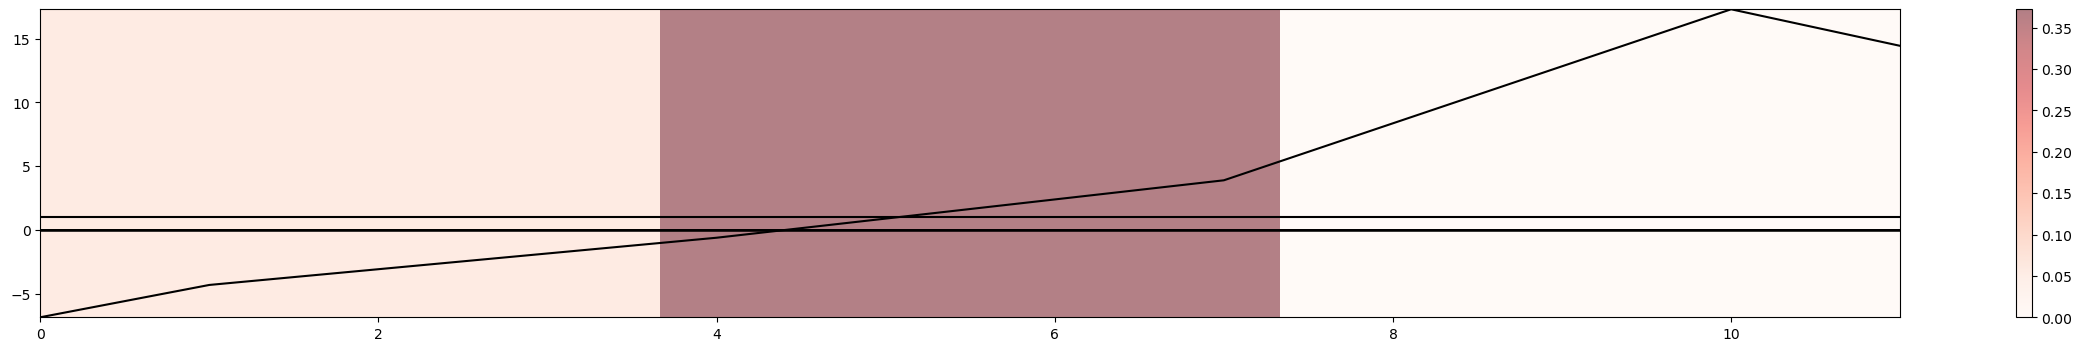

42
1/1 [==============================] - 0s 11ms/step
Model prediction = (17.896949768066406), True Value = [8.7]
[[ 8.11155985e-04 -1.24037049e-04  4.07751381e-05  9.99999289e-01
  -1.82428254e-05  3.14619021e-04  2.87502581e-04  2.36841116e-04
   1.68122939e-05 -5.54280316e-05 -2.51994748e-04  1.49255684e-05
   8.38231101e-06  6.65136379e-04 -4.30000000e+00]
 [ 8.37749953e-04 -9.86541113e-05  1.41845114e-06  9.99999390e-01
  -1.03677351e-04  3.53135826e-04 -4.57106744e-06 -5.29924351e-06
   3.15475980e-05 -1.06693915e-05 -2.17249288e-04  1.90297381e-05
   2.67171783e-05  5.69034215e-04 -3.06666667e+00]
 [ 8.14896108e-04 -1.42054774e-05 -4.16163384e-05  9.99999456e-01
  -9.64726511e-05  3.24739673e-04  1.98000919e-04 -4.10242041e-05
   4.49254037e-05  3.06513243e-05 -1.83827557e-04  2.26898771e-05
   4.34436330e-05  4.76798378e-04 -1.83333333e+00]
 [ 8.55520714e-04 -3.77112725e-05  2.12636084e-05  9.99999473e-01
  -3.26613909e-05  3.12532128e-04  1.62767860e-04  1.30364379e-04
   5.5

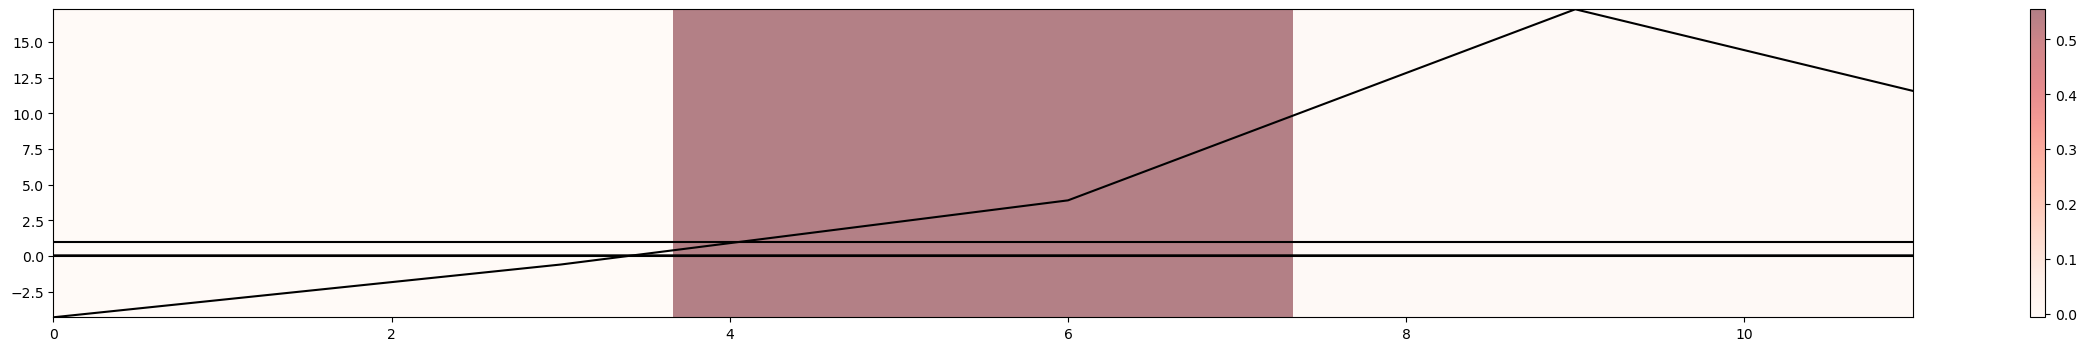

43
1/1 [==============================] - 0s 10ms/step
Model prediction = (17.22843360900879), True Value = [8.]
[[ 8.37749953e-04 -9.86541113e-05  1.41845114e-06  9.99999390e-01
  -1.03677351e-04  3.53135826e-04 -4.57106744e-06 -5.29924351e-06
   3.15475980e-05 -1.06693915e-05 -2.17249288e-04  1.90297381e-05
   2.67171783e-05  5.69034215e-04 -3.06666667e+00]
 [ 8.14896108e-04 -1.42054774e-05 -4.16163384e-05  9.99999456e-01
  -9.64726511e-05  3.24739673e-04  1.98000919e-04 -4.10242041e-05
   4.49254037e-05  3.06513243e-05 -1.83827557e-04  2.26898771e-05
   4.34436330e-05  4.76798378e-04 -1.83333333e+00]
 [ 8.55520714e-04 -3.77112725e-05  2.12636084e-05  9.99999473e-01
  -3.26613909e-05  3.12532128e-04  1.62767860e-04  1.30364379e-04
   5.55908528e-05  6.66634571e-05 -1.48777072e-04  2.53127198e-05
   5.71401061e-05  3.80934040e-04 -6.00000000e-01]
 [ 7.95890746e-04 -7.44024446e-05 -8.14558697e-06  9.99999532e-01
  -5.09210385e-05  3.04383409e-04  9.37909098e-05  1.31356952e-04
   6.595

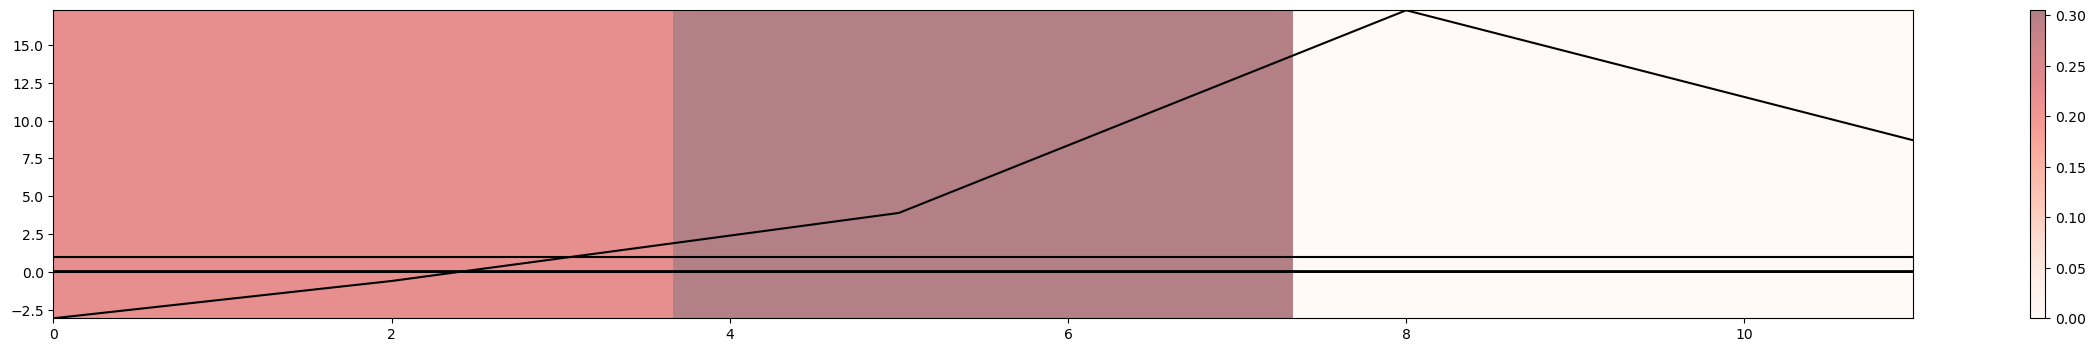

44
1/1 [==============================] - 0s 10ms/step
Model prediction = (17.6093807220459), True Value = [7.3]
[[ 8.14896108e-04 -1.42054774e-05 -4.16163384e-05  9.99999456e-01
  -9.64726511e-05  3.24739673e-04  1.98000919e-04 -4.10242041e-05
   4.49254037e-05  3.06513243e-05 -1.83827557e-04  2.26898771e-05
   4.34436330e-05  4.76798378e-04 -1.83333333e+00]
 [ 8.55520714e-04 -3.77112725e-05  2.12636084e-05  9.99999473e-01
  -3.26613909e-05  3.12532128e-04  1.62767860e-04  1.30364379e-04
   5.55908528e-05  6.66634571e-05 -1.48777072e-04  2.53127198e-05
   5.71401061e-05  3.80934040e-04 -6.00000000e-01]
 [ 7.95890746e-04 -7.44024446e-05 -8.14558697e-06  9.99999532e-01
  -5.09210385e-05  3.04383409e-04  9.37909098e-05  1.31356952e-04
   6.59541832e-05  8.12159934e-05 -1.36362024e-04  4.64627224e-05
   2.04342366e-04  3.18957356e-04  9.00000000e-01]
 [ 9.10230688e-04  7.64159967e-05 -6.80147617e-06  9.99999348e-01
  -5.34221663e-05  3.42421630e-04  1.95443143e-04  8.39009885e-05
   8.874

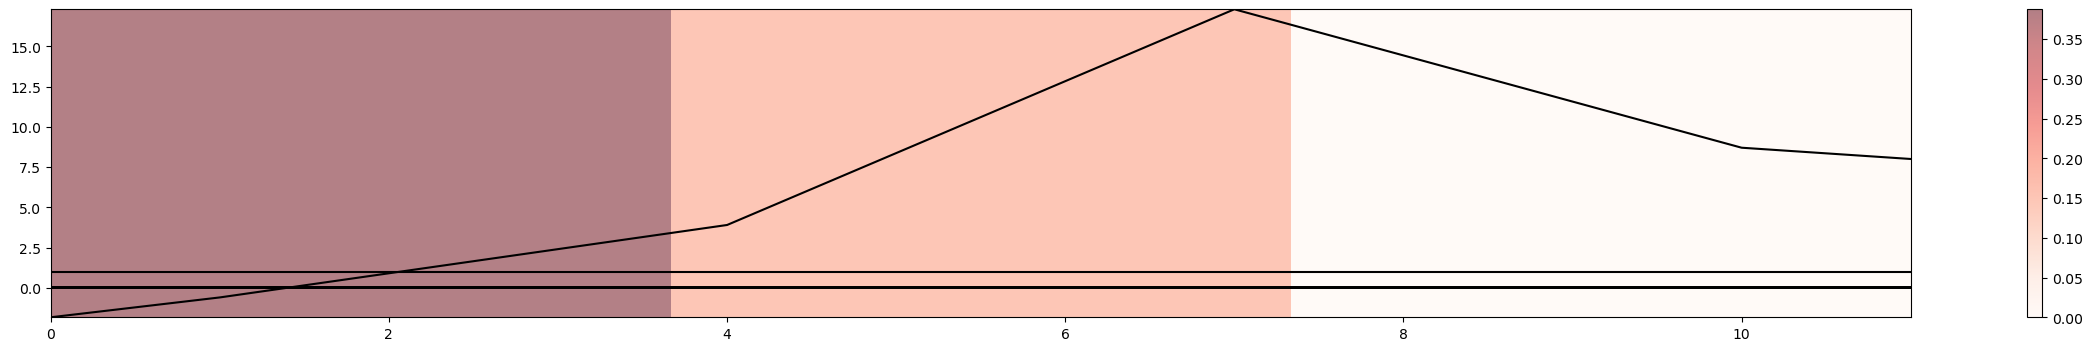

45
1/1 [==============================] - 0s 10ms/step
Model prediction = (14.159428596496582), True Value = [6.6]
[[ 8.55520714e-04 -3.77112725e-05  2.12636084e-05  9.99999473e-01
  -3.26613909e-05  3.12532128e-04  1.62767860e-04  1.30364379e-04
   5.55908528e-05  6.66634571e-05 -1.48777072e-04  2.53127198e-05
   5.71401061e-05  3.80934040e-04 -6.00000000e-01]
 [ 7.95890746e-04 -7.44024446e-05 -8.14558697e-06  9.99999532e-01
  -5.09210385e-05  3.04383409e-04  9.37909098e-05  1.31356952e-04
   6.59541832e-05  8.12159934e-05 -1.36362024e-04  4.64627224e-05
   2.04342366e-04  3.18957356e-04  9.00000000e-01]
 [ 9.10230688e-04  7.64159967e-05 -6.80147617e-06  9.99999348e-01
  -5.34221663e-05  3.42421630e-04  1.95443143e-04  8.39009885e-05
   8.87472328e-05  1.11451799e-04 -1.42516853e-04  7.92865261e-05
   4.14300165e-04  2.93478092e-04  2.40000000e+00]
 [ 7.52841965e-04  6.43830862e-05  2.06086433e-05  9.99996990e-01
   1.62220830e-04  2.25702678e-03  8.39992988e-05  2.20880804e-04
   7.8

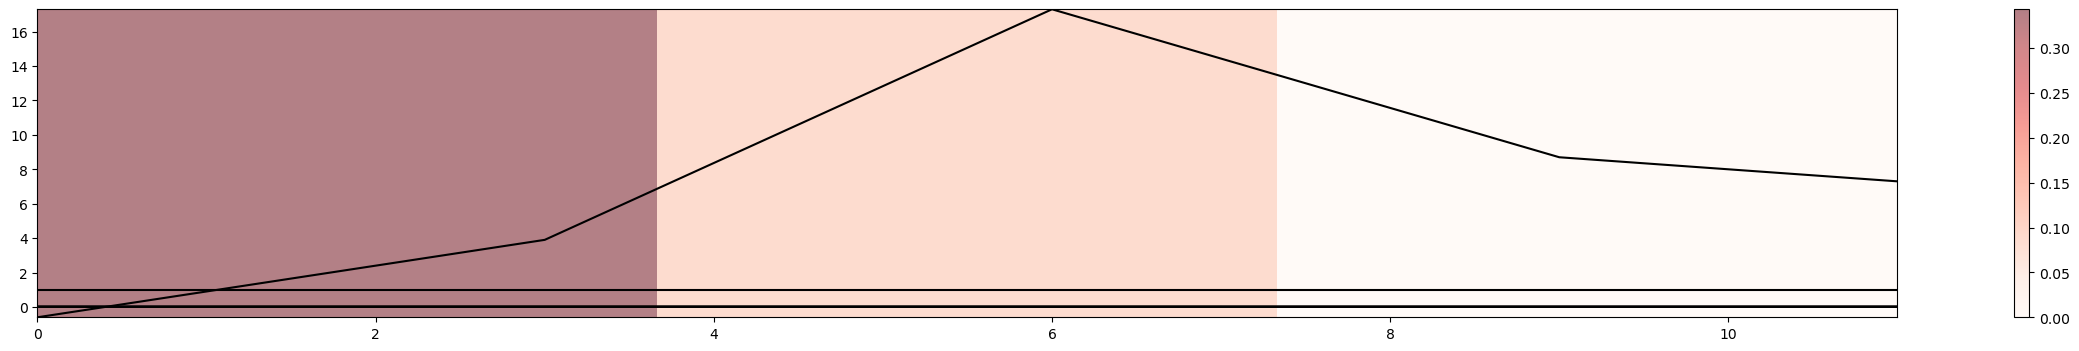

46
1/1 [==============================] - 0s 11ms/step
Model prediction = (10.091041564941406), True Value = [5.73333333]
[[ 7.95890746e-04 -7.44024446e-05 -8.14558697e-06  9.99999532e-01
  -5.09210385e-05  3.04383409e-04  9.37909098e-05  1.31356952e-04
   6.59541832e-05  8.12159934e-05 -1.36362024e-04  4.64627224e-05
   2.04342366e-04  3.18957356e-04  9.00000000e-01]
 [ 9.10230688e-04  7.64159967e-05 -6.80147617e-06  9.99999348e-01
  -5.34221663e-05  3.42421630e-04  1.95443143e-04  8.39009885e-05
   8.87472328e-05  1.11451799e-04 -1.42516853e-04  7.92865261e-05
   4.14300165e-04  2.93478092e-04  2.40000000e+00]
 [ 7.52841965e-04  6.43830862e-05  2.06086433e-05  9.99996990e-01
   1.62220830e-04  2.25702678e-03  8.39992988e-05  2.20880804e-04
   7.82100154e-05  9.97177697e-05 -9.72740024e-05  8.14629025e-05
   4.61429483e-04  1.64822760e-04  3.90000000e+00]
 [ 7.35503030e-04  5.29417104e-04  8.13331777e-05  9.99999279e-01
   2.41674455e-04  1.96682270e-04  2.58509167e-05  1.01856071e-04

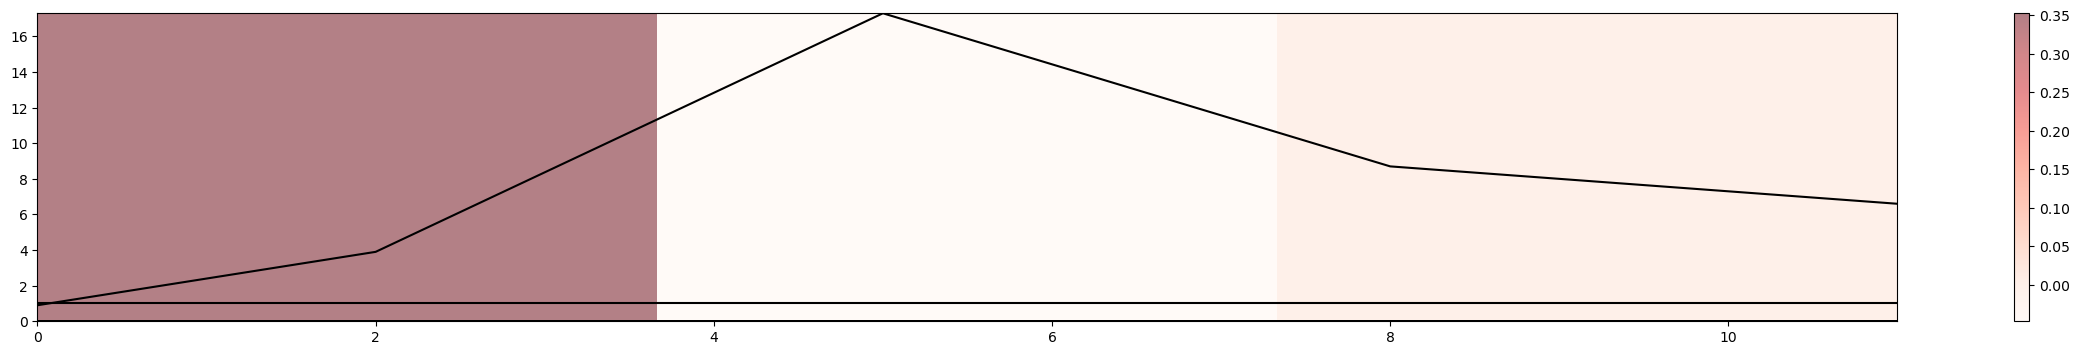

47
1/1 [==============================] - 0s 10ms/step
Model prediction = (7.414185523986816), True Value = [4.86666667]
[[ 9.10230688e-04  7.64159967e-05 -6.80147617e-06  9.99999348e-01
  -5.34221663e-05  3.42421630e-04  1.95443143e-04  8.39009885e-05
   8.87472328e-05  1.11451799e-04 -1.42516853e-04  7.92865261e-05
   4.14300165e-04  2.93478092e-04  2.40000000e+00]
 [ 7.52841965e-04  6.43830862e-05  2.06086433e-05  9.99996990e-01
   1.62220830e-04  2.25702678e-03  8.39992988e-05  2.20880804e-04
   7.82100154e-05  9.97177697e-05 -9.72740024e-05  8.14629025e-05
   4.61429483e-04  1.64822760e-04  3.90000000e+00]
 [ 7.35503030e-04  5.29417104e-04  8.13331777e-05  9.99999279e-01
   2.41674455e-04  1.96682270e-04  2.58509167e-05  1.01856071e-04
   8.73538600e-05  1.02662623e-04 -5.23240756e-05  7.56872039e-05
   6.87406152e-04  8.03796092e-05  8.36666667e+00]
 [ 6.51016229e-04  7.62777980e-04  1.36035867e-04  9.99998979e-01
   2.98884560e-04  1.53906302e-04  2.54227584e-04  1.02229452e-04


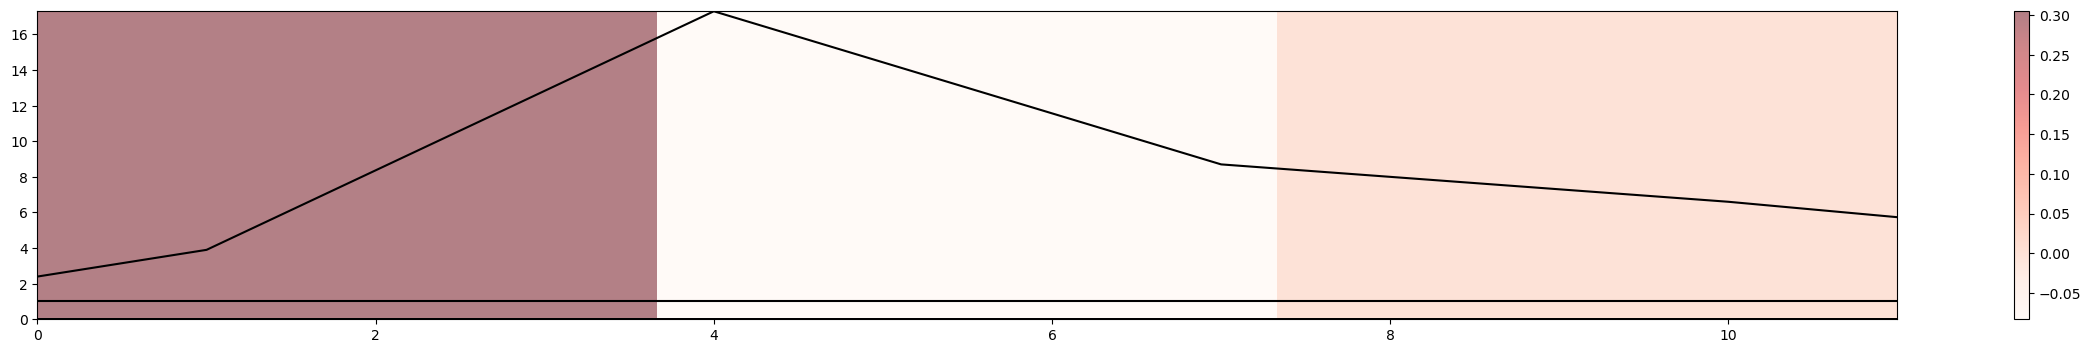

48
1/1 [==============================] - 0s 11ms/step
Model prediction = (4.560007095336914), True Value = [4.]
[[ 7.52841965e-04  6.43830862e-05  2.06086433e-05  9.99996990e-01
   1.62220830e-04  2.25702678e-03  8.39992988e-05  2.20880804e-04
   7.82100154e-05  9.97177697e-05 -9.72740024e-05  8.14629025e-05
   4.61429483e-04  1.64822760e-04  3.90000000e+00]
 [ 7.35503030e-04  5.29417104e-04  8.13331777e-05  9.99999279e-01
   2.41674455e-04  1.96682270e-04  2.58509167e-05  1.01856071e-04
   8.73538600e-05  1.02662623e-04 -5.23240756e-05  7.56872039e-05
   6.87406152e-04  8.03796092e-05  8.36666667e+00]
 [ 6.51016229e-04  7.62777980e-04  1.36035867e-04  9.99998979e-01
   2.98884560e-04  1.53906302e-04  2.54227584e-04  1.02229452e-04
   9.39354985e-05  1.02387386e-04 -4.48939615e-06  6.73247703e-05
   8.97343705e-04 -8.90712358e-06  1.28333333e+01]
 [ 5.55754046e-04  2.52006744e-04  6.53215405e-05  9.99999088e-01
   2.59391521e-04  1.58012566e-04  2.60694986e-04  2.34601349e-04
   9.941

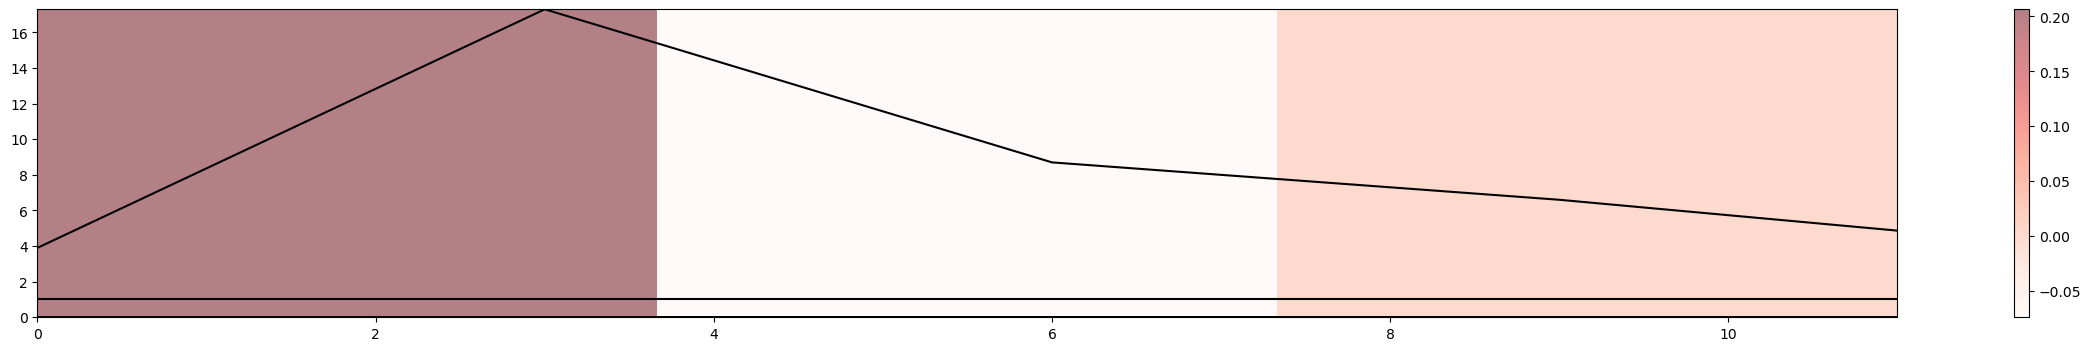

49
1/1 [==============================] - 0s 11ms/step
Model prediction = (4.060291767120361), True Value = [4.16666667]
[[ 7.35503030e-04  5.29417104e-04  8.13331777e-05  9.99999279e-01
   2.41674455e-04  1.96682270e-04  2.58509167e-05  1.01856071e-04
   8.73538600e-05  1.02662623e-04 -5.23240756e-05  7.56872039e-05
   6.87406152e-04  8.03796092e-05  8.36666667e+00]
 [ 6.51016229e-04  7.62777980e-04  1.36035867e-04  9.99998979e-01
   2.98884560e-04  1.53906302e-04  2.54227584e-04  1.02229452e-04
   9.39354985e-05  1.02387386e-04 -4.48939615e-06  6.73247703e-05
   8.97343705e-04 -8.90712358e-06  1.28333333e+01]
 [ 5.55754046e-04  2.52006744e-04  6.53215405e-05  9.99999088e-01
   2.59391521e-04  1.58012566e-04  2.60694986e-04  2.34601349e-04
   9.94151353e-05  1.01029491e-04  4.26320044e-05  5.83805847e-05
   1.09441462e-03 -9.66789389e-05  1.73000000e+01]
 [ 6.72896623e-04  5.45962734e-06  3.34804890e-05  9.99999148e-01
   2.05528193e-04  1.30572227e-04  1.55705030e-04  1.41066714e-04


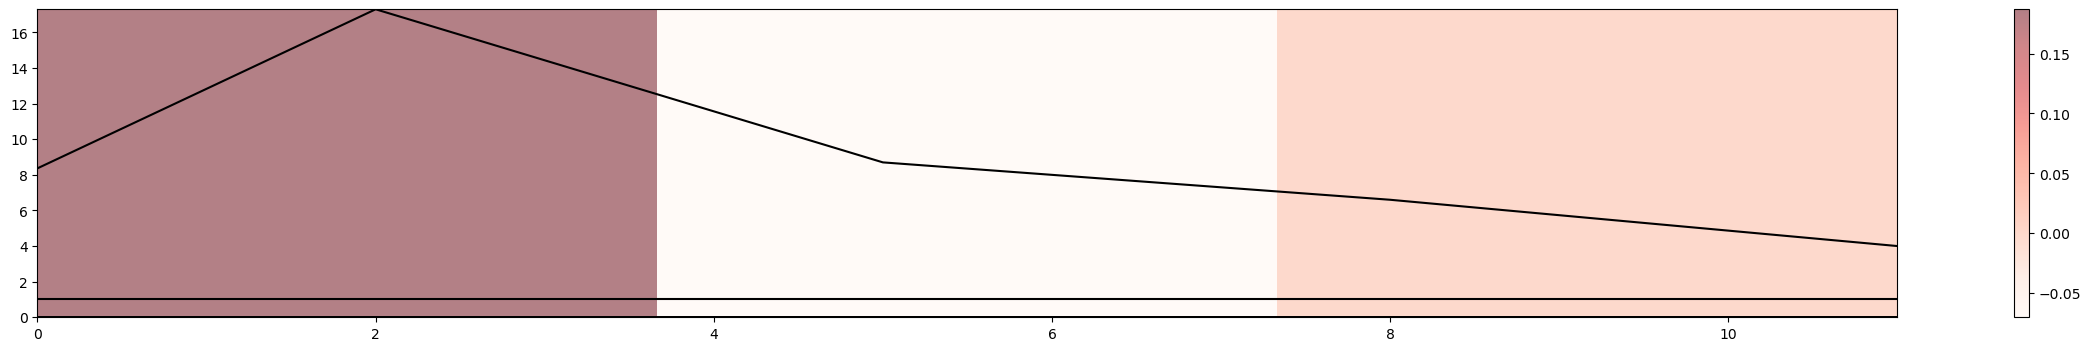

50
1/1 [==============================] - 0s 11ms/step
Model prediction = (2.6532647609710693), True Value = [4.33333333]
[[ 6.51016229e-04  7.62777980e-04  1.36035867e-04  9.99998979e-01
   2.98884560e-04  1.53906302e-04  2.54227584e-04  1.02229452e-04
   9.39354985e-05  1.02387386e-04 -4.48939615e-06  6.73247703e-05
   8.97343705e-04 -8.90712358e-06  1.28333333e+01]
 [ 5.55754046e-04  2.52006744e-04  6.53215405e-05  9.99999088e-01
   2.59391521e-04  1.58012566e-04  2.60694986e-04  2.34601349e-04
   9.94151353e-05  1.01029491e-04  4.26320044e-05  5.83805847e-05
   1.09441462e-03 -9.66789389e-05  1.73000000e+01]
 [ 6.72896623e-04  5.45962734e-06  3.34804890e-05  9.99999148e-01
   2.05528193e-04  1.30572227e-04  1.55705030e-04  1.41066714e-04
   8.08047260e-05  1.28626131e-04  4.68149222e-05  7.42706612e-05
   1.04725182e-03 -1.34673540e-04  1.44333333e+01]
 [ 6.72443048e-04 -2.08405850e-05  2.25972032e-06  9.99999214e-01
   2.13316608e-04  1.30956783e-04  1.07610712e-04  1.57876960e-04

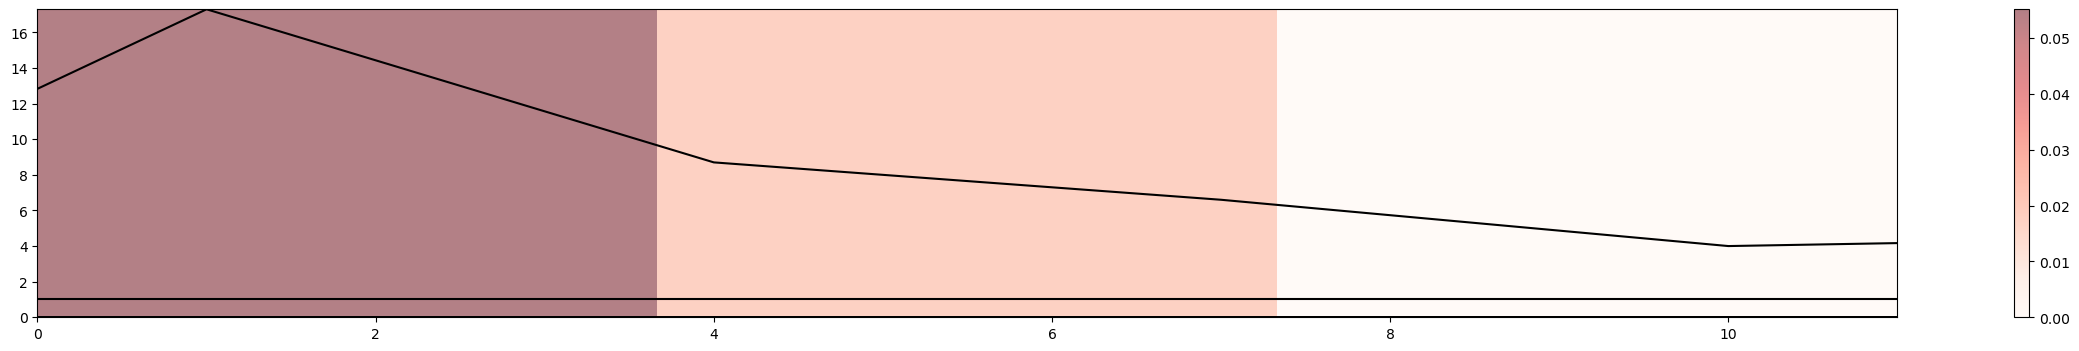

51
1/1 [==============================] - 0s 11ms/step
Model prediction = (2.6065571308135986), True Value = [4.5]
[[ 5.55754046e-04  2.52006744e-04  6.53215405e-05  9.99999088e-01
   2.59391521e-04  1.58012566e-04  2.60694986e-04  2.34601349e-04
   9.94151353e-05  1.01029491e-04  4.26320044e-05  5.83805847e-05
   1.09441462e-03 -9.66789389e-05  1.73000000e+01]
 [ 6.72896623e-04  5.45962734e-06  3.34804890e-05  9.99999148e-01
   2.05528193e-04  1.30572227e-04  1.55705030e-04  1.41066714e-04
   8.08047260e-05  1.28626131e-04  4.68149222e-05  7.42706612e-05
   1.04725182e-03 -1.34673540e-04  1.44333333e+01]
 [ 6.72443048e-04 -2.08405850e-05  2.25972032e-06  9.99999214e-01
   2.13316608e-04  1.30956783e-04  1.07610712e-04  1.57876960e-04
   5.99113182e-05  1.54176654e-04  5.00904735e-05  8.89780401e-05
   9.75885514e-04 -1.70778382e-04  1.15666667e+01]
 [ 6.88598452e-04  6.03300271e-05 -2.56330570e-05  9.99999310e-01
   1.68469175e-04  1.26325378e-04 -1.81871541e-05  1.28427632e-04
   3.7

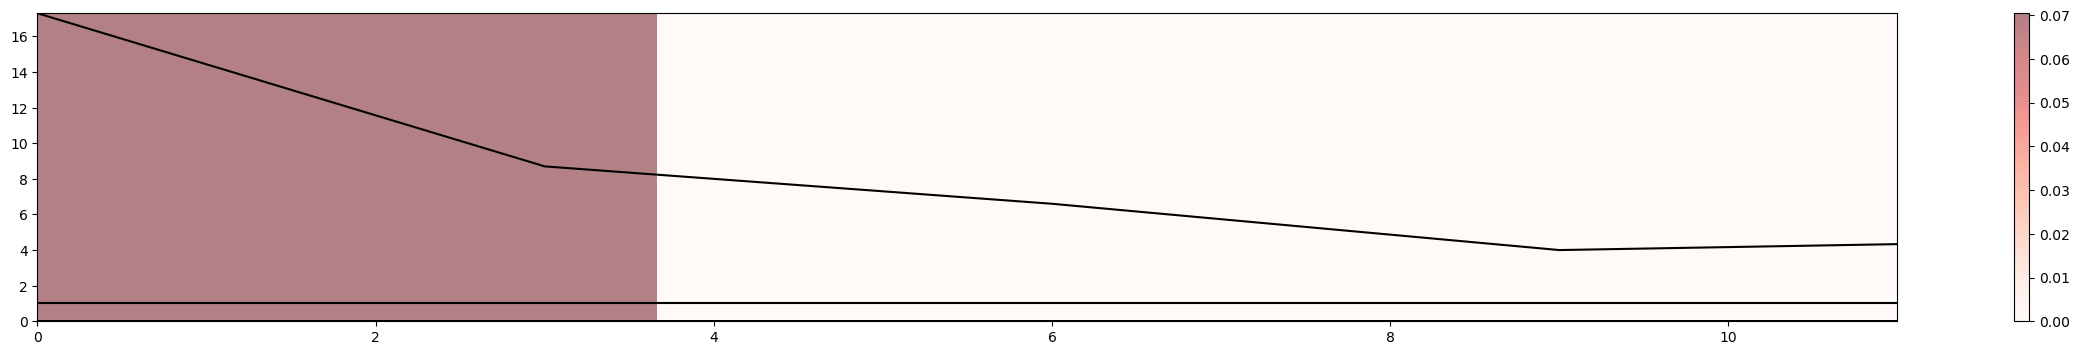

52
1/1 [==============================] - 0s 11ms/step
Model prediction = (3.05482816696167), True Value = [4.33333333]
[[ 6.72896623e-04  5.45962734e-06  3.34804890e-05  9.99999148e-01
   2.05528193e-04  1.30572227e-04  1.55705030e-04  1.41066714e-04
   8.08047260e-05  1.28626131e-04  4.68149222e-05  7.42706612e-05
   1.04725182e-03 -1.34673540e-04  1.44333333e+01]
 [ 6.72443048e-04 -2.08405850e-05  2.25972032e-06  9.99999214e-01
   2.13316608e-04  1.30956783e-04  1.07610712e-04  1.57876960e-04
   5.99113182e-05  1.54176654e-04  5.00904735e-05  8.89780401e-05
   9.75885514e-04 -1.70778382e-04  1.15666667e+01]
 [ 6.88598452e-04  6.03300271e-05 -2.56330570e-05  9.99999310e-01
   1.68469175e-04  1.26325378e-04 -1.81871541e-05  1.28427632e-04
   3.74084405e-05  1.73005535e-04  5.13456858e-05  9.98074873e-05
   8.69554828e-04 -1.99184004e-04  8.70000000e+00]
 [ 6.17641053e-04  5.97519583e-05 -6.76015097e-05  9.99999367e-01
   2.12443125e-04  1.15142733e-04  1.41778956e-04  1.23775267e-04
 

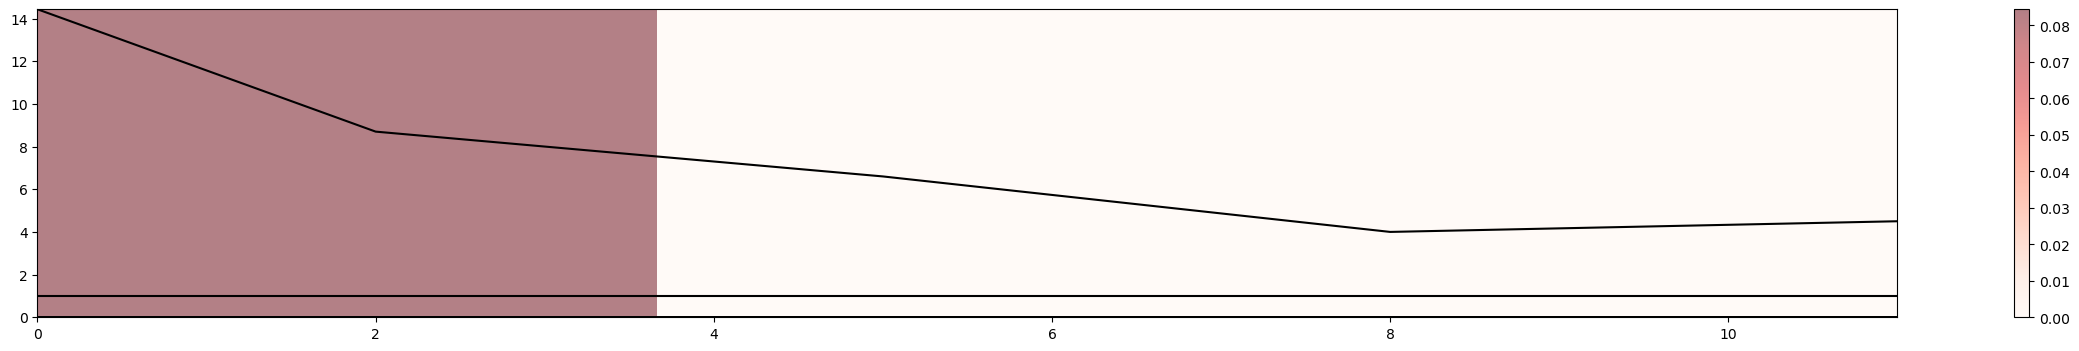

53
1/1 [==============================] - 0s 15ms/step
Model prediction = (2.9132678508758545), True Value = [4.16666667]
[[ 6.72443048e-04 -2.08405850e-05  2.25972032e-06  9.99999214e-01
   2.13316608e-04  1.30956783e-04  1.07610712e-04  1.57876960e-04
   5.99113182e-05  1.54176654e-04  5.00904735e-05  8.89780401e-05
   9.75885514e-04 -1.70778382e-04  1.15666667e+01]
 [ 6.88598452e-04  6.03300271e-05 -2.56330570e-05  9.99999310e-01
   1.68469175e-04  1.26325378e-04 -1.81871541e-05  1.28427632e-04
   3.74084405e-05  1.73005535e-04  5.13456858e-05  9.98074873e-05
   8.69554828e-04 -1.99184004e-04  8.70000000e+00]
 [ 6.17641053e-04  5.97519583e-05 -6.76015097e-05  9.99999367e-01
   2.12443125e-04  1.15142733e-04  1.41778956e-04  1.23775267e-04
   2.74838811e-05  1.43858131e-04  3.21202761e-05  8.51733029e-05
   8.46795191e-04 -1.90197048e-04  8.00000000e+00]
 [ 6.77638803e-04  1.32451034e-05  4.19297068e-06  9.99999225e-01
   2.70536715e-04  1.18404291e-04  1.21416553e-04  2.49298337e-04

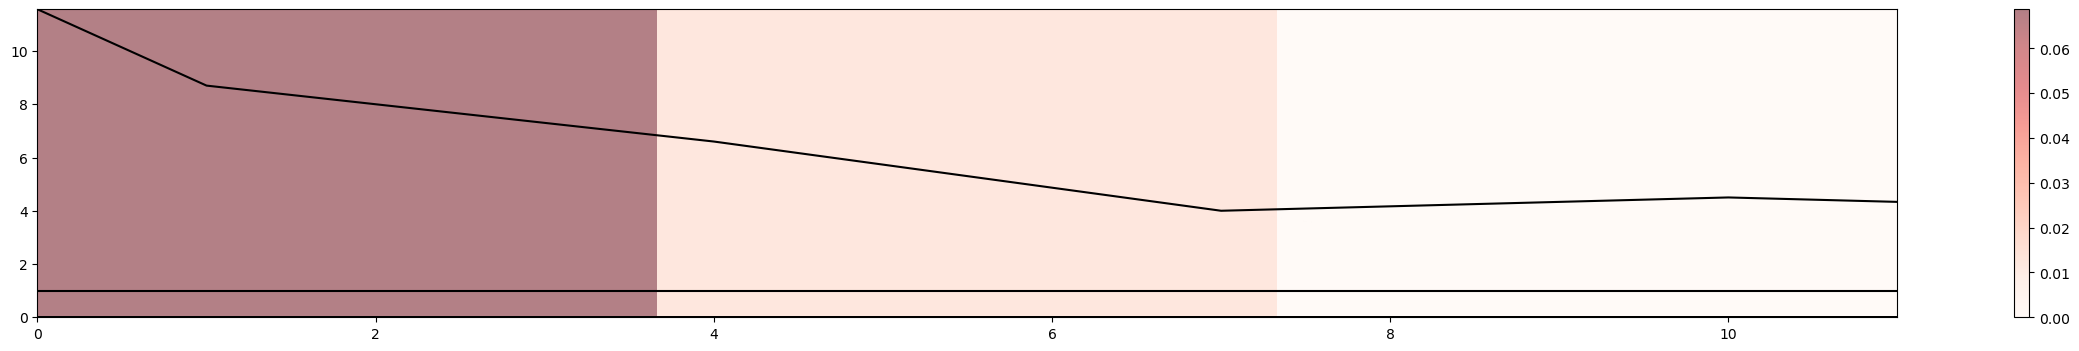

54
1/1 [==============================] - 0s 10ms/step
Model prediction = (3.2130939960479736), True Value = [4.]
[[ 6.88598452e-04  6.03300271e-05 -2.56330570e-05  9.99999310e-01
   1.68469175e-04  1.26325378e-04 -1.81871541e-05  1.28427632e-04
   3.74084405e-05  1.73005535e-04  5.13456858e-05  9.98074873e-05
   8.69554828e-04 -1.99184004e-04  8.70000000e+00]
 [ 6.17641053e-04  5.97519583e-05 -6.76015097e-05  9.99999367e-01
   2.12443125e-04  1.15142733e-04  1.41778956e-04  1.23775267e-04
   2.74838811e-05  1.43858131e-04  3.21202761e-05  8.51733029e-05
   8.46795191e-04 -1.90197048e-04  8.00000000e+00]
 [ 6.77638803e-04  1.32451034e-05  4.19297068e-06  9.99999225e-01
   2.70536715e-04  1.18404291e-04  1.21416553e-04  2.49298337e-04
   2.14620035e-05  1.33708753e-04  1.79341301e-05  8.16227067e-05
   9.26532994e-04 -2.04474821e-04  7.30000000e+00]
 [ 7.72151463e-04  5.30028501e-05 -1.00335368e-05  9.99999169e-01
   2.87661246e-04  1.12893994e-04  1.36285571e-04  1.10364814e-04
   1.39

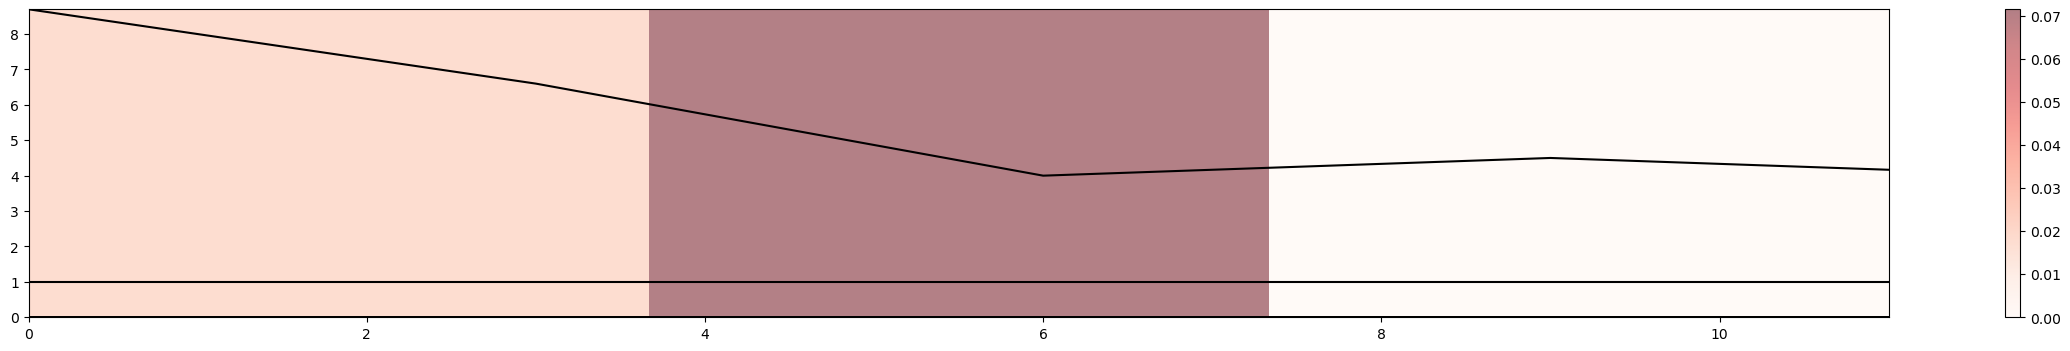

55
1/1 [==============================] - 0s 15ms/step
Model prediction = (3.402894973754883), True Value = [3.36666667]
[[ 6.17641053e-04  5.97519583e-05 -6.76015097e-05  9.99999367e-01
   2.12443125e-04  1.15142733e-04  1.41778956e-04  1.23775267e-04
   2.74838811e-05  1.43858131e-04  3.21202761e-05  8.51733029e-05
   8.46795191e-04 -1.90197048e-04  8.00000000e+00]
 [ 6.77638803e-04  1.32451034e-05  4.19297068e-06  9.99999225e-01
   2.70536715e-04  1.18404291e-04  1.21416553e-04  2.49298337e-04
   2.14620035e-05  1.33708753e-04  1.79341301e-05  8.16227067e-05
   9.26532994e-04 -2.04474821e-04  7.30000000e+00]
 [ 7.72151463e-04  5.30028501e-05 -1.00335368e-05  9.99999169e-01
   2.87661246e-04  1.12893994e-04  1.36285571e-04  1.10364814e-04
   1.39792896e-05  1.13923853e-04  2.70605692e-06  7.21384333e-05
   9.36570759e-04 -2.03435452e-04  6.60000000e+00]
 [ 8.05790175e-04  1.02809543e-04 -3.57330746e-06  9.99999122e-01
   2.58368537e-04  1.27199814e-04  1.07147531e-05  1.28315673e-04


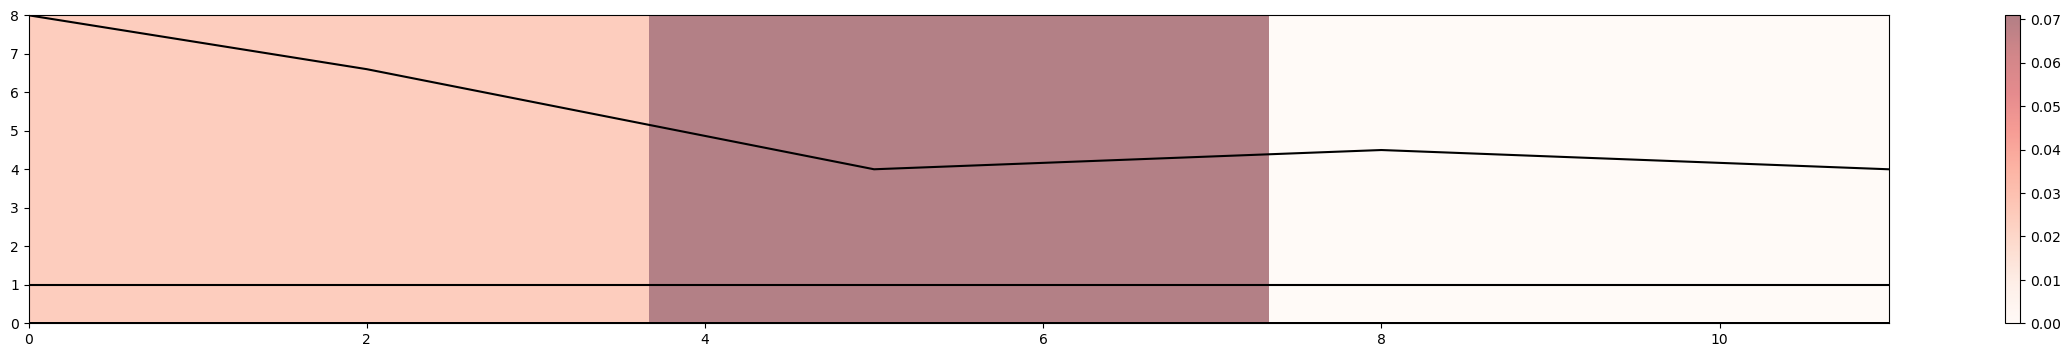

56
1/1 [==============================] - 0s 15ms/step
Model prediction = (3.990112543106079), True Value = [2.73333333]
[[ 6.77638803e-04  1.32451034e-05  4.19297068e-06  9.99999225e-01
   2.70536715e-04  1.18404291e-04  1.21416553e-04  2.49298337e-04
   2.14620035e-05  1.33708753e-04  1.79341301e-05  8.16227067e-05
   9.26532994e-04 -2.04474821e-04  7.30000000e+00]
 [ 7.72151463e-04  5.30028501e-05 -1.00335368e-05  9.99999169e-01
   2.87661246e-04  1.12893994e-04  1.36285571e-04  1.10364814e-04
   1.39792896e-05  1.13923853e-04  2.70605692e-06  7.21384333e-05
   9.36570759e-04 -2.03435452e-04  6.60000000e+00]
 [ 8.05790175e-04  1.02809543e-04 -3.57330746e-06  9.99999122e-01
   2.58368537e-04  1.27199814e-04  1.07147531e-05  1.28315673e-04
   1.35346163e-05  1.31416371e-04 -4.56210680e-05  8.04900179e-05
   9.59400701e-04 -2.23337303e-04  5.73333333e+00]
 [ 8.24332440e-04 -4.95912799e-05 -1.40382748e-05  9.99999054e-01
   2.06313489e-04  1.47301330e-04  1.47300461e-04  1.22893515e-04


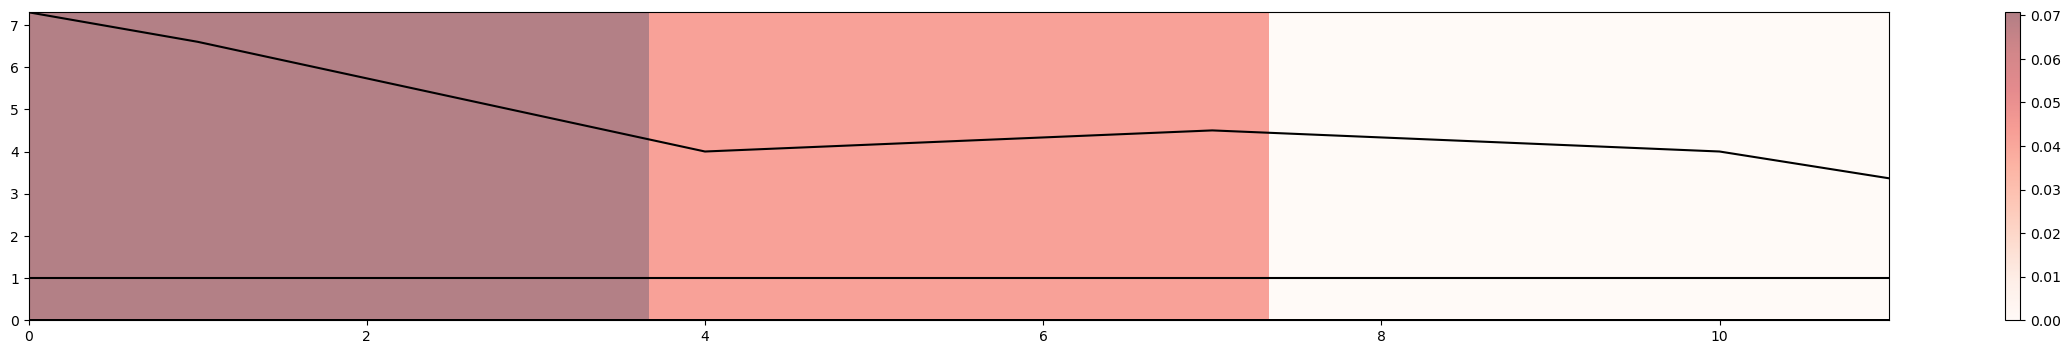

57
1/1 [==============================] - 0s 10ms/step
Model prediction = (4.205646514892578), True Value = [2.1]
[[ 7.72151463e-04  5.30028501e-05 -1.00335368e-05  9.99999169e-01
   2.87661246e-04  1.12893994e-04  1.36285571e-04  1.10364814e-04
   1.39792896e-05  1.13923853e-04  2.70605692e-06  7.21384333e-05
   9.36570759e-04 -2.03435452e-04  6.60000000e+00]
 [ 8.05790175e-04  1.02809543e-04 -3.57330746e-06  9.99999122e-01
   2.58368537e-04  1.27199814e-04  1.07147531e-05  1.28315673e-04
   1.35346163e-05  1.31416371e-04 -4.56210680e-05  8.04900179e-05
   9.59400701e-04 -2.23337303e-04  5.73333333e+00]
 [ 8.24332440e-04 -4.95912799e-05 -1.40382748e-05  9.99999054e-01
   2.06313489e-04  1.47301330e-04  1.47300461e-04  1.22893515e-04
   1.31071747e-05  1.55723401e-04 -1.09192020e-04  9.22954050e-05
   1.00001684e-03 -2.51825430e-04  4.86666667e+00]
 [ 8.23205934e-04  6.16704934e-05 -5.35995246e-05  9.99999241e-01
   2.11423953e-04  1.34293233e-04  4.28511791e-05  1.11001518e-04
   9.60

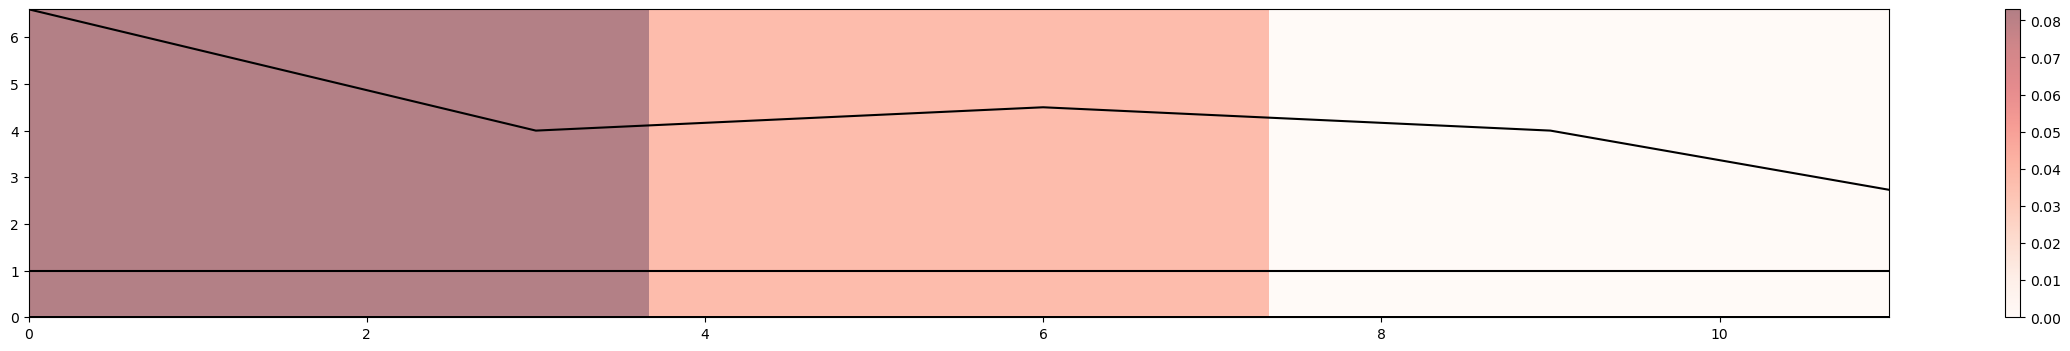

58
1/1 [==============================] - 0s 10ms/step
Model prediction = (4.273012638092041), True Value = [1.53333333]
[[ 8.05790175e-04  1.02809543e-04 -3.57330746e-06  9.99999122e-01
   2.58368537e-04  1.27199814e-04  1.07147531e-05  1.28315673e-04
   1.35346163e-05  1.31416371e-04 -4.56210680e-05  8.04900179e-05
   9.59400701e-04 -2.23337303e-04  5.73333333e+00]
 [ 8.24332440e-04 -4.95912799e-05 -1.40382748e-05  9.99999054e-01
   2.06313489e-04  1.47301330e-04  1.47300461e-04  1.22893515e-04
   1.31071747e-05  1.55723401e-04 -1.09192020e-04  9.22954050e-05
   1.00001684e-03 -2.51825430e-04  4.86666667e+00]
 [ 8.23205934e-04  6.16704934e-05 -5.35995246e-05  9.99999241e-01
   2.11423953e-04  1.34293233e-04  4.28511791e-05  1.11001518e-04
   9.60998799e-06  1.45198182e-04 -1.50933499e-04  8.33110804e-05
   8.10509256e-04 -2.23381819e-04  4.00000000e+00]
 [ 8.11824734e-04  7.84093877e-05 -1.51696198e-05  9.99999368e-01
   2.30513673e-04  1.31963291e-04  5.15167969e-05  1.21643513e-04


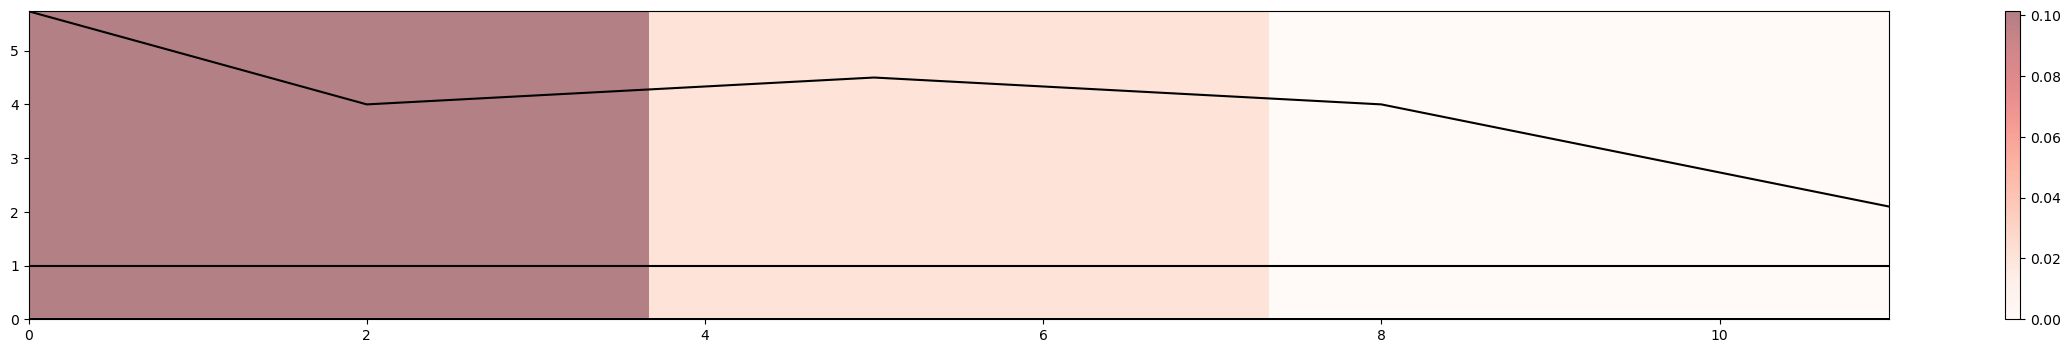

59
1/1 [==============================] - 0s 11ms/step
Model prediction = (3.916316270828247), True Value = [0.96666667]
[[ 8.24332440e-04 -4.95912799e-05 -1.40382748e-05  9.99999054e-01
   2.06313489e-04  1.47301330e-04  1.47300461e-04  1.22893515e-04
   1.31071747e-05  1.55723401e-04 -1.09192020e-04  9.22954050e-05
   1.00001684e-03 -2.51825430e-04  4.86666667e+00]
 [ 8.23205934e-04  6.16704934e-05 -5.35995246e-05  9.99999241e-01
   2.11423953e-04  1.34293233e-04  4.28511791e-05  1.11001518e-04
   9.60998799e-06  1.45198182e-04 -1.50933499e-04  8.33110804e-05
   8.10509256e-04 -2.23381819e-04  4.00000000e+00]
 [ 8.11824734e-04  7.84093877e-05 -1.51696198e-05  9.99999368e-01
   2.30513673e-04  1.31963291e-04  5.15167969e-05  1.21643513e-04
   7.43193738e-06  1.42679043e-04 -1.55789814e-04  5.75534940e-05
   6.43188069e-04 -2.20940902e-04  4.16666667e+00]
 [ 8.97502971e-04  1.33388321e-04 -2.81090338e-05  9.99999329e-01
   3.67851784e-04  1.32190874e-04  1.05482731e-04  1.22519750e-04


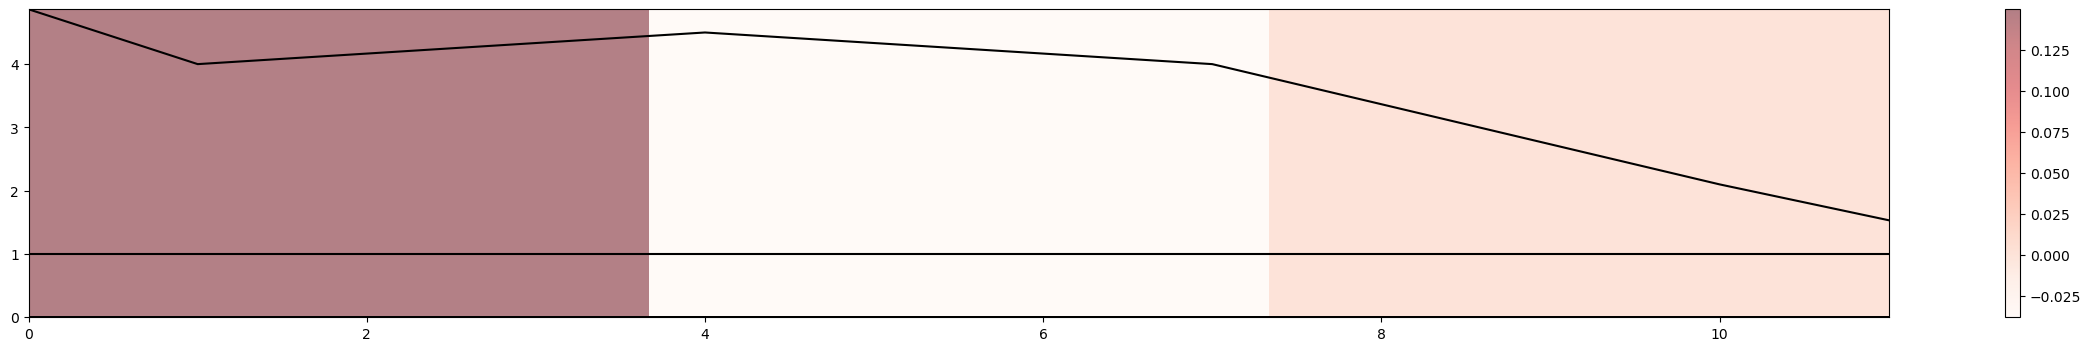

60
1/1 [==============================] - 0s 12ms/step
Model prediction = (3.321063995361328), True Value = [0.4]
[[ 8.23205934e-04  6.16704934e-05 -5.35995246e-05  9.99999241e-01
   2.11423953e-04  1.34293233e-04  4.28511791e-05  1.11001518e-04
   9.60998799e-06  1.45198182e-04 -1.50933499e-04  8.33110804e-05
   8.10509256e-04 -2.23381819e-04  4.00000000e+00]
 [ 8.11824734e-04  7.84093877e-05 -1.51696198e-05  9.99999368e-01
   2.30513673e-04  1.31963291e-04  5.15167969e-05  1.21643513e-04
   7.43193738e-06  1.42679043e-04 -1.55789814e-04  5.75534940e-05
   6.43188069e-04 -2.20940902e-04  4.16666667e+00]
 [ 8.97502971e-04  1.33388321e-04 -2.81090338e-05  9.99999329e-01
   3.67851784e-04  1.32190874e-04  1.05482731e-04  1.22519750e-04
   5.42996511e-06  1.42925107e-04 -1.63546339e-04  3.32986541e-05
   4.90773868e-04 -2.22759090e-04  4.33333333e+00]
 [ 8.36134607e-04  9.14066240e-05  1.51572513e-05  9.99999495e-01
   2.96176957e-04  1.26678365e-04  3.00688711e-05  3.71069021e-05
   3.27

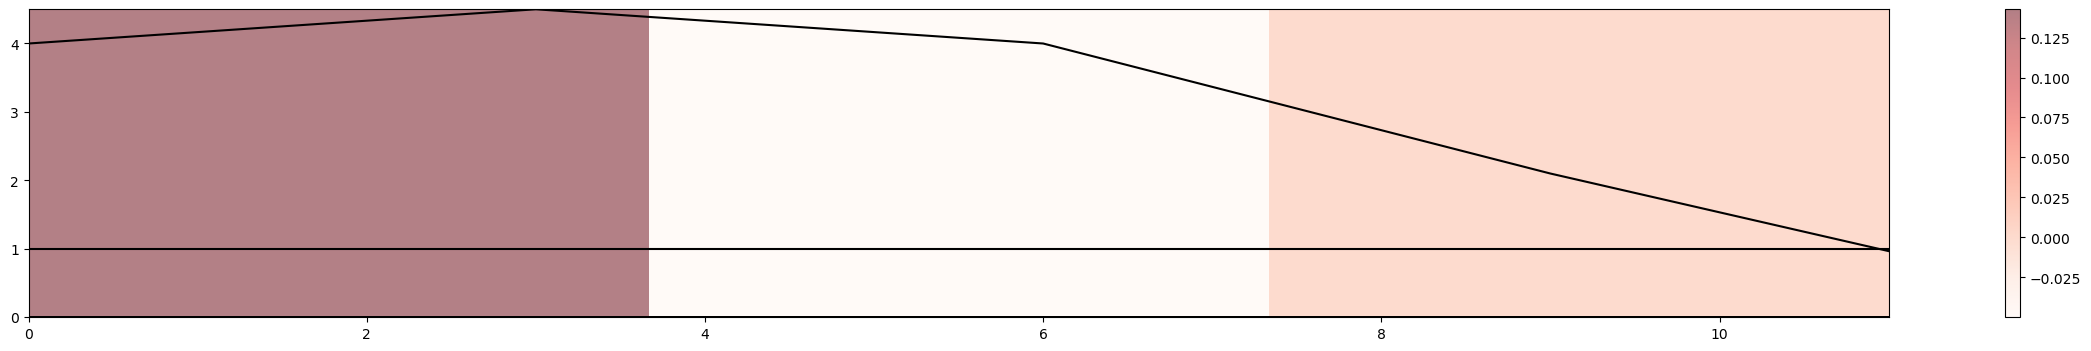

In [168]:
def grad_cam(model, layer_name, data):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    last_conv_layer_output, preds = grad_model(data)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output * pooled_grads
    heatmap = tf.reduce_mean(heatmap, axis=(1))
    heatmap = np.expand_dims(heatmap,0)
    return heatmap

model = model_eval2
layer_name = "conv1d_10"
for count, i in enumerate(X_test2):
    print(count)
    data = np.expand_dims(i,0)
    pred = model.predict(data)[0][0]
    print(f"Model prediction = ({pred}), True Value = {y_test2[count]}")
    heatmap = grad_cam(model,layer_name,data)
    print(i)
    plt.figure(figsize=(30,4))
    plt.imshow(np.expand_dims(heatmap,axis=2),cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,11,i.min(),i.max()], alpha=0.5)
    plt.plot(i,'k')
    plt.colorbar()
    plt.show()

In [165]:
X_test2.shape

(61, 12, 15)

### LIME

In [161]:
import lime
from lime import lime_tabular

In [181]:
X_train[0]

array([[ 1.18378166e-03,  1.67375137e-04,  5.84527252e-05,
         9.99999258e-01,  1.70457259e-05,  1.05845958e-04,
        -5.75879052e-05, -6.78014557e-06,  2.17171218e-05,
         5.68031723e-05, -5.27550902e-05,  5.11812033e-05,
        -7.17337410e-05, -1.49897260e-04,  5.76666667e+00],
       [ 1.14557136e-03, -2.06084599e-04,  5.34534570e-06,
         9.99999290e-01, -1.15237610e-04,  7.20781864e-05,
        -3.69623327e-05, -6.16889408e-05,  2.50249389e-05,
         3.83352194e-05, -1.06006233e-05,  7.29159618e-05,
        -5.34939867e-05, -1.78123242e-04,  5.73333333e+00],
       [ 1.25941957e-03,  3.89052299e-05,  1.72372641e-04,
         9.99999153e-01,  2.01313376e-05,  1.04103318e-04,
        -6.68622473e-05, -5.38601251e-05,  2.92198228e-05,
         2.12655377e-05,  3.11051807e-05,  9.72151489e-05,
        -3.71928129e-05, -2.12655377e-04,  5.70000000e+00],
       [ 1.14293679e-03,  3.14489110e-05,  1.00362032e-04,
         9.99999302e-01,  2.30671414e-05,  4.69422271

In [209]:
reshaped_X_train = X_train.reshape(-1, X_train.shape[-1])
# Step 3: Prepare the LIME Explainer
explainer = lime_tabular.LimeTabularExplainer(reshaped_X_train, mode='regression')

# Step 4: Generate Explanations
instance_to_explain = np.array([[1,2,3,4]])
  # Replace with the instance you want to explain
explanation = explainer.explain_instance(instance_to_explain, model.predict, num_features=5)

# Step 5: Interpret the Results
explanation.show_in_notebook() 

IndexError: index 4 is out of bounds for axis 1 with size 4

In [199]:
X_train[0].flatten()[0:6]

array([1.18378166e-03, 1.67375137e-04, 5.84527252e-05, 9.99999258e-01,
       1.70457259e-05, 1.05845958e-04])

In [185]:
X_train.shape

(247, 6, 15)

In [176]:
data.columns

Index(['Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars',
       'Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total',
       'Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total',
       'Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units)',
       'Air Cargo Tonnage | Total Direct Tonnage (Tonne)',
       'Merchandise Imports By Commodity Division | Total Merchandise Imports',
       'M1 Money Supply',
       'Index Of Industrial Production (2019 = 100) | Total',
       'Domestic Exports Of Major Non-Oil Products | Total Electronic Products',
       'Composite Leading Index (2015 = 100) | Quarterly Composite Leading Index',
       'Business Expectations For The Services Sector - General Business Outlook For The Next 6 Months, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector',
       'Domestic Wholesale Trade In